## Library Import

In [ ]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np
import gensim
import gensim.downloader
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import quantile_transform


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from ngboost import NGBClassifier
from ngboost.distns import k_categorical, Bernoulli

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch

import optuna

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

## Fix Seed 함수 정의

In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 14
seed_everything(SEED)

## 레이블 생성 함수 정의

- 레이블 생성 함수는 연월을 인자로 받아서 고객 아이디별로 총 구매액이 인자로 받는 구매액 임계값을 넘는지 여부를 바이너리 레이블로 생성하는 함수

In [ ]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

## 평가지표 출력 함수 정의

In [ ]:
def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

## 데이터 전처리 함수 정의
- 범주형 변수 레이블 인코딩
- 결측치 중위값으로 채움

In [ ]:
def feature_preprocessing(train, test, features, do_imputing=True):
    x_tr = train.copy()
    x_te = test.copy()
    
    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))
            
            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))
            
            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])
    
    return x_tr, x_te

## 피처 엔지니어링 함수 정의
- Pandas groupby aggregation 함수를 사용한 피처 엔지니어링

In [ ]:
def feature_engineering1(df, year_month):
    df = df.copy()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_func)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_func)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

## LightGBM cross validation out of fold train/predict 함수 정의

In [ ]:
def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

## xgboost prediction 정의

In [2]:
def make_xgb_oof_prediction(train, y, test, features, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # XGBoost 데이터셋 선언
        dtrain = xgb.DMatrix(x_tr, label=y_tr)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        dtest = xgb.DMatrix(x_test)
        
        dlist = [(dtrain, 'train'), (dvalid,'eval')]
        
        # XGBoost 모델 훈련
        clf = xgb.train(
            model_params,
            dtrain,
            evals=dlist, # Validation 성능을 측정할 수 있도록 설정
            num_boost_round=10000,
            early_stopping_rounds=100,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(dvalid)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(dtest) / folds
        
        # 폴드별 피처 중요도 저장
        feature_importance = np.array(clf.get_score().values())
        fi[f'fold_{fold+1}'] = feature_importance

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

# CatBoost prediction 정의

In [ ]:
def make_cbt_oof_prediction(train, y, test, features, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # CatBoost 데이터셋 선언
        #dtrain = Pool(x_tr, label=y_tr)
        #dvalid = Pool(x_val, label=y_val)
        #dtest = Pool(x_test)
        
        #dlist = [(dtrain, 'train'), (dvalid,'eval')]
        
        # CatBoostClasssifier 모델 훈련
        clf = CatBoostClassifier(**model_params)

        clf.fit(x_tr,y_tr,eval_set=(x_val,y_val),
                #cat_features=categorical_features,
                use_best_model=True,
                verbose=True,
                #verbose_eval=200
               )

        # Validation 데이터 예측
        val_preds = clf.predict_proba(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds[:,1]
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds[:,1])}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds[:,1]) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict_proba(x_test)[:,1] / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.get_feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

## random forest prediction 정의

In [4]:
def make_rf_oof_prediction(train, y, test, features, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        
        # randomforestClasssifier 모델 훈련
        clf = RandomForestClassifier(**model_params)

        clf.fit(x_tr,y_tr)

        # Validation 데이터 예측
        val_preds = clf.predict_proba(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds[:,1]
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds[:,1])}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds[:,1]) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict_proba(x_test)[:,1] / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importances_

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

## NGBoost prediction 정의

In [ ]:
def make_ngb_oof_prediction(train, y, test, features, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        
        # CatBoostClasssifier 모델 훈련
        clf = NGBClassifier(**model_params) # tell ngboost that there are 3 possible outcomes
        clf.fit(x_tr, y_tr, X_val=x_val, Y_val=y_val, early_stopping_rounds=30) # Y should have on

        # Validation 데이터 예측
        val_preds = clf.predict_proba(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds[:,1]
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds[:,1])}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds[:,1]) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict_proba(x_test)[:,1] / folds
        
        # 폴드별 피처 중요도 저장
        #fi[f'fold_{fold+1}'] = clf.feature_importances_

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    #fi_cols = [col for col in fi.columns if 'fold_' in col]
    #fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds

## LightGBM 피처 중요도 플롯 함수 정의

In [ ]:
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

## Train 데이터 읽기
- 9개의 feature를 가진 780502개의 train data

In [ ]:
data = pd.read_csv("../input/train.csv", parse_dates=["order_date"])
print(data.shape) # data shape 확인
data.head()

(780502, 9)


order_id product_id                          description  quantity  \
0   489434      85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434     79323P                   PINK CHERRY LIGHTS        12   
2   489434     79323W                  WHITE CHERRY LIGHTS        12   
3   489434      22041         RECORD FRAME 7" SINGLE SIZE         48   
4   489434      21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           order_date    price  customer_id         country   total  
0 2009-12-01 07:45:00  11.4675        13085  United Kingdom  137.61  
1 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65  
2 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65  
3 2009-12-01 07:45:00   3.4650        13085  United Kingdom  166.32  
4 2009-12-01 07:45:00   2.0625        13085  United Kingdom   49.50

## cumsum feature 생성

In [ ]:
#train feature 생성

df = data.copy()

year_month = '2011-11'

df_label = generate_label(df,year_month)[['customer_id','year_month','label']]

df = df[df['order_date']<year_month]

df['cumsum_total_by_cust_id'] = df.groupby(['customer_id'])['total'].cumsum()
df['cumsum_quantity_by_cust_id'] = df.groupby(['customer_id'])['quantity'].cumsum()
df['cumsum_price_by_cust_id'] = df.groupby(['customer_id'])['price'].cumsum()

df['cumsum_total_by_prod_id'] = df.groupby(['product_id'])['total'].cumsum()
df['cumsum_quantity_by_prod_id'] = df.groupby(['product_id'])['quantity'].cumsum()
df['cumsum_price_by_prod_id'] = df.groupby(['product_id'])['price'].cumsum()

df['cumsum_total_by_order_id'] = df.groupby(['order_id'])['total'].cumsum()
df['cumsum_quantity_by_order_id'] = df.groupby(['order_id'])['quantity'].cumsum()
df['cumsum_price_by_order_id'] = df.groupby(['order_id'])['price'].cumsum()

cols = [col for col in df.columns if 'cumsum' in col]

agg_func = ['mean','max','min','sum','count','std','skew']

df_agg = df.groupby(['customer_id'])[cols].agg(agg_func)

new_cols = []

for col in df_agg.columns.levels[0]:
    for stat in df_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

df_agg.columns = new_cols

df_all = df_label.merge(df_agg,on=['customer_id'],how='left')
df_all.head(10)

customer_id year_month  label  cumsum_total_by_cust_id-mean  \
0        12346    2011-11      0                   2953.304457   
1        12347    2011-11      0                   3491.749628   
2        12348    2011-11      0                   1096.986000   
3        12349    2011-11      1                   2014.247369   
4        12350    2011-11      0                    281.849118   
5        12351    2011-11      0                    250.658571   
6        12352    2011-11      1                   1283.192372   
7        12353    2011-11      0                    335.264875   
8        12354    2011-11      0                    897.228181   
9        12355    2011-11      0                    788.840486   

   cumsum_total_by_cust_id-max  cumsum_total_by_cust_id-min  \
0                  127267.5690                     -85.3710   
1                    7749.5715                      29.2050   
2                    3332.0100                      21.7800   
3                    4367.5335                     -39.8475   
4                     551.7600                      41.5800   
5                     496.5345                      17.3250   
6                    2602.8420                     -91.8225   
7                     671.1540                      12.8700   
8                    1781.0100                      34.3200   
9                    1563.5565                      49.5000   

   cumsum_total_by_cust_id-sum  cumsum_total_by_cust_id-count  \
0                  138805.3095                             47   
1                  736759.1715                            211   
2                   55946.2860                             51   
3                  215524.4685                            107   
4                    4791.4350                             17   
5                    5263.8300                             21   
6                  125752.8525                             98   
7                    8046.3570                             24   
8                   52039.2345                             58   
9                   27609.4170                             35   

   cumsum_total_by_cust_id-std  cumsum_total_by_cust_id-skew  \
0                 18527.811314                      6.855058   
1                  2302.307503                      0.228741   
2                  1000.019165                      0.812596   
3                  1402.866250                      0.089354   
4                   161.979220                      0.200043   
5                   155.766573                      0.003263   
6                   699.866814                     -0.003516   
7                   193.191489                     -0.024486   
8                   550.517570                      0.053336   
9                   468.119773                      0.146972   

   cumsum_quantity_by_cust_id-mean  cumsum_quantity_by_cust_id-max  \
0                      1631.063830                           74268   
1                      1339.677725                            2775   
2                      1069.450980                            2714   
3                       467.682243                             988   
4                       107.941176                             197   
5                       177.190476                             261   
6                       321.000000                             531   
7                       120.333333                             212   
8                       266.431034                             530   
9                       294.914286                             543   

   cumsum_quantity_by_cust_id-min  cumsum_quantity_by_cust_id-sum  \
0                              10                           76660   
1                               6                          282672   
2                              24                           54542   
3                              -5                           50042   
4                              12            

In [ ]:
#test feature 생성

df = data.copy()

year_month = '2011-12'

df_label = generate_label(df,year_month)[['customer_id','year_month','label']]

df = df[df['order_date']<year_month]

df['cumsum_total_by_cust_id'] = df.groupby(['customer_id'])['total'].cumsum()
df['cumsum_quantity_by_cust_id'] = df.groupby(['customer_id'])['quantity'].cumsum()
df['cumsum_price_by_cust_id'] = df.groupby(['customer_id'])['price'].cumsum()

df['cumsum_total_by_prod_id'] = df.groupby(['product_id'])['total'].cumsum()
df['cumsum_quantity_by_prod_id'] = df.groupby(['product_id'])['quantity'].cumsum()
df['cumsum_price_by_prod_id'] = df.groupby(['product_id'])['price'].cumsum()

df['cumsum_total_by_order_id'] = df.groupby(['order_id'])['total'].cumsum()
df['cumsum_quantity_by_order_id'] = df.groupby(['order_id'])['quantity'].cumsum()
df['cumsum_price_by_order_id'] = df.groupby(['order_id'])['price'].cumsum()

cols = [col for col in df.columns if 'cumsum' in col]

agg_func = ['mean','max','min','sum','count','std','skew']

df_agg_test = df.groupby(['customer_id'])[cols].agg(agg_func)

new_cols = []

for col in df_agg_test.columns.levels[0]:
    for stat in df_agg_test.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

df_agg_test.columns = new_cols

df_all_test = df_label.merge(df_agg_test,on=['customer_id'],how='left')
df_all_test.head(10)

customer_id year_month  label  cumsum_total_by_cust_id-mean  \
0        12346    2011-12      0                   2953.304457   
1        12347    2011-12      0                   3491.749628   
2        12348    2011-12      0                   1096.986000   
3        12349    2011-12      0                   3445.769525   
4        12350    2011-12      0                    281.849118   
5        12351    2011-12      0                    250.658571   
6        12352    2011-12      0                   1488.506761   
7        12353    2011-12      0                    335.264875   
8        12354    2011-12      0                    897.228181   
9        12355    2011-12      0                    788.840486   

   cumsum_total_by_cust_id-max  cumsum_total_by_cust_id-min  \
0                  127267.5690                     -85.3710   
1                    7749.5715                      29.2050   
2                    3332.0100                      21.7800   
3                    7267.4910                     -39.8475   
4                     551.7600                      41.5800   
5                     496.5345                      17.3250   
6                    3117.1965                     -91.8225   
7                     671.1540                      12.8700   
8                    1781.0100                      34.3200   
9                    1563.5565                      49.5000   

   cumsum_total_by_cust_id-sum  cumsum_total_by_cust_id-count  \
0                  138805.3095                             47   
1                  736759.1715                            211   
2                   55946.2860                             51   
3                  620238.5145                            180   
4                    4791.4350                             17   
5                    5263.8300                             21   
6                  168201.2640                            113   
7                    8046.3570                             24   
8                   52039.2345                             58   
9                   27609.4170                             35   

   cumsum_total_by_cust_id-std  cumsum_total_by_cust_id-skew  \
0                 18527.811314                      6.855058   
1                  2302.307503                      0.228741   
2                  1000.019165                      0.812596   
3                  2091.575371                     -0.182170   
4                   161.979220                      0.200043   
5                   155.766573                      0.003263   
6                   839.210186                      0.107357   
7                   193.191489                     -0.024486   
8                   550.517570                      0.053336   
9                   468.119773                      0.146972   

   cumsum_quantity_by_cust_id-mean  cumsum_quantity_by_cust_id-max  \
0                      1631.063830                           74268   
1                      1339.677725                            2775   
2                      1069.450980                            2714   
3                       786.527778                            1619   
4                       107.941176                             197   
5                       177.190476                             261   
6                       358.212389                             658   
7                       120.333333                             212   
8                       266.431034                             530   
9                       294.914286                             543   

   cumsum_quantity_by_cust_id-min  cumsum_quantity_by_cust_id-sum  \
0                              10                           76660   
1                               6                          282672   
2                              24                           54542   
3                              -5                          141575   
4                              12            

In [ ]:
cumsum_features = df_all.drop(columns=['customer_id', 'label', 'year_month']).columns

In [ ]:
#fill NaN value
imputer = SimpleImputer(strategy='median')
df_all[cumsum_features] = imputer.fit_transform(df_all[cumsum_features])
df_all.isna().sum()

customer_id                          0
year_month                           0
label                                0
cumsum_total_by_cust_id-mean         0
cumsum_total_by_cust_id-max          0
cumsum_total_by_cust_id-min          0
cumsum_total_by_cust_id-sum          0
cumsum_total_by_cust_id-count        0
cumsum_total_by_cust_id-std          0
cumsum_total_by_cust_id-skew         0
cumsum_quantity_by_cust_id-mean      0
cumsum_quantity_by_cust_id-max       0
cumsum_quantity_by_cust_id-min       0
cumsum_quantity_by_cust_id-sum       0
cumsum_quantity_by_cust_id-count     0
cumsum_quantity_by_cust_id-std       0
cumsum_quantity_by_cust_id-skew      0
cumsum_price_by_cust_id-mean         0
cumsum_price_by_cust_id-max          0
cumsum_price_by_cust_id-min          0
cumsum_price_by_cust_id-sum          0
cumsum_price_by_cust_id-count        0
cumsum_price_by_cust_id-std          0
cumsum_price_by_cust_id-skew         0
cumsum_total_by_prod_id-mean         0
cumsum_total_by_prod_id-m

In [ ]:
#fill NaN value
imputer = SimpleImputer(strategy='median')
df_all_test[cumsum_features] = imputer.fit_transform(df_all_test[cumsum_features])
df_all_test.isna().sum()

customer_id                          0
year_month                           0
label                                0
cumsum_total_by_cust_id-mean         0
cumsum_total_by_cust_id-max          0
cumsum_total_by_cust_id-min          0
cumsum_total_by_cust_id-sum          0
cumsum_total_by_cust_id-count        0
cumsum_total_by_cust_id-std          0
cumsum_total_by_cust_id-skew         0
cumsum_quantity_by_cust_id-mean      0
cumsum_quantity_by_cust_id-max       0
cumsum_quantity_by_cust_id-min       0
cumsum_quantity_by_cust_id-sum       0
cumsum_quantity_by_cust_id-count     0
cumsum_quantity_by_cust_id-std       0
cumsum_quantity_by_cust_id-skew      0
cumsum_price_by_cust_id-mean         0
cumsum_price_by_cust_id-max          0
cumsum_price_by_cust_id-min          0
cumsum_price_by_cust_id-sum          0
cumsum_price_by_cust_id-count        0
cumsum_price_by_cust_id-std          0
cumsum_price_by_cust_id-skew         0
cumsum_total_by_prod_id-mean         0
cumsum_total_by_prod_id-m

## nunique feature 생성

In [ ]:
#train feature

df = data.copy()

year_month = '2011-11'

df_label = generate_label(df,year_month)[['customer_id','year_month','label']]

df = df[df['order_date']<year_month]

cols = ['order_id','product_id']

df_agg_nunique = df.groupby(['customer_id'])[cols].agg(['nunique'])

new_cols = []

for col in df_agg_nunique.columns.levels[0]:
    for stat in df_agg_nunique.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

df_agg_nunique.columns = new_cols

df_all_nunique = df_label.merge(df_agg_nunique,on=['customer_id'],how='left')
df_all_nunique.head(10)

customer_id year_month  label  order_id-nunique  product_id-nunique
0        12346    2011-11      0                17                  30
1        12347    2011-11      0                 7                 123
2        12348    2011-11      0                 5                  25
3        12349    2011-11      1                 4                  92
4        12350    2011-11      0                 1                  17
5        12351    2011-11      0                 1                  21
6        12352    2011-11      1                12                  59
7        12353    2011-11      0                 2                  23
8        12354    2011-11      0                 1                  58
9        12355    2011-11      0                 2                  35

In [ ]:
#test feature

df = data.copy()

year_month = '2011-12'

df_label = generate_label(df,year_month)[['customer_id','year_month','label']]

df = df[df['order_date']<year_month]

cols = ['order_id','product_id']

df_agg_nunique_test = df.groupby(['customer_id'])[cols].agg(['nunique'])

new_cols = []

for col in df_agg_nunique_test.columns.levels[0]:
    for stat in df_agg_nunique_test.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

df_agg_nunique_test.columns = new_cols

df_all_nunique_test = df_label.merge(df_agg_nunique_test,on=['customer_id'],how='left')
df_all_nunique_test.head(10)

customer_id year_month  label  order_id-nunique  product_id-nunique
0        12346    2011-12      0                17                  30
1        12347    2011-12      0                 7                 123
2        12348    2011-12      0                 5                  25
3        12349    2011-12      0                 5                 139
4        12350    2011-12      0                 1                  17
5        12351    2011-12      0                 1                  21
6        12352    2011-12      0                13                  70
7        12353    2011-12      0                 2                  23
8        12354    2011-12      0                 1                  58
9        12355    2011-12      0                 2                  35

In [ ]:
nunique_features = df_all_nunique.drop(columns=['customer_id', 'label', 'year_month']).columns
nunique_features

Index(['order_id-nunique', 'product_id-nunique'], dtype='object')

In [ ]:
df_all_nunique.isna().sum()

customer_id           0
year_month            0
label                 0
order_id-nunique      0
product_id-nunique    0
dtype: int64

In [ ]:
df_all_nunique_test.isna().sum()

customer_id           0
year_month            0
label                 0
order_id-nunique      0
product_id-nunique    0
dtype: int64

## mode feature 생성

In [ ]:
#train feature
df = data.copy()

df['month'] = df['order_date'].dt.month
df['year_month'] = df['order_date'].dt.strftime('%Y-%m')

year_month = '2011-11'

df_label = generate_label(df,year_month)[['customer_id','year_month','label']]

df = df[df['order_date']<year_month]

cols = ['month','year_month']

df_agg_mode = df.groupby(['customer_id'])[cols].agg([lambda x:x.value_counts().index[0]])

df_agg_mode.columns = ['month-mode','year_month-mode']

df_all_mode = df_label.merge(df_agg_mode,on=['customer_id'],how='left')
df_all_mode.head(10)

customer_id year_month  label  month-mode year_month-mode
0        12346    2011-11      0           6         2010-06
1        12347    2011-11      0          10         2011-10
2        12348    2011-11      0           9         2010-09
3        12349    2011-11      1          10         2010-10
4        12350    2011-11      0           2         2011-02
5        12351    2011-11      0          11         2010-11
6        12352    2011-11      1           3         2011-03
7        12353    2011-11      0          10         2010-10
8        12354    2011-11      0           4         2011-04
9        12355    2011-11      0           5         2010-05

In [ ]:
#test feature

df = data.copy()

df['month'] = df['order_date'].dt.month
df['year_month'] = df['order_date'].dt.strftime('%Y-%m')

year_month = '2011-12'

df_label = generate_label(df,year_month)[['customer_id','year_month','label']]

df = df[df['order_date']<year_month]

cols = ['month','year_month']

df_agg_mode_test = df.groupby(['customer_id'])[cols].agg([lambda x:x.value_counts().index[0]])

df_agg_mode_test.columns = ['month-mode','year_month-mode']

df_all_mode_test = df_label.merge(df_agg_mode_test,on=['customer_id'],how='left')
df_all_mode_test.head(10)

customer_id year_month  label  month-mode year_month-mode
0        12346    2011-12      0           6         2010-06
1        12347    2011-12      0          10         2011-10
2        12348    2011-12      0           9         2010-09
3        12349    2011-12      0          11         2011-11
4        12350    2011-12      0           2         2011-02
5        12351    2011-12      0          11         2010-11
6        12352    2011-12      0          11         2011-03
7        12353    2011-12      0          10         2010-10
8        12354    2011-12      0           4         2011-04
9        12355    2011-12      0           5         2010-05

In [ ]:
mode_features = df_all_mode.drop(columns=['customer_id', 'label', 'year_month']).columns
mode_features

Index(['month-mode', 'year_month-mode'], dtype='object')

In [ ]:
df_all_mode.isna().sum()

customer_id        0
year_month         0
label              0
month-mode         0
year_month-mode    0
dtype: int64

In [ ]:
df_all_mode_test.isna().sum()

customer_id        0
year_month         0
label              0
month-mode         0
year_month-mode    0
dtype: int64

## order_ts feature 생성

In [ ]:
#train feature

df = data.copy()

df['order_ts'] = df['order_date'].astype(np.int64)//1e9
df['order_ts_diff'] = df.groupby(['customer_id'])['order_ts'].diff()
df['quantity_diff'] = df.groupby(['customer_id'])['quantity'].diff()
df['price_diff'] = df.groupby(['customer_id'])['price'].diff()
df['total_diff'] = df.groupby(['customer_id'])['total'].diff()

year_month = '2011-11'

df_label = generate_label(df,year_month)[['customer_id','year_month','label']]

df = df[df['order_date']<year_month]

agg_func = ['mean','max','min','sum','count','std','skew']
agg_dict = {
    'order_ts':['first','last'],
    'order_ts_diff':agg_func,
    'quantity_diff':agg_func,
    'price_diff':agg_func,
    'total_diff':agg_func
}

df_agg_ts = df.groupby(['customer_id']).agg(agg_dict)

new_cols = []

for col in agg_dict.keys():
    for stat in agg_dict[col]:
        new_cols.append(f'{col}-{stat}')

df_agg_ts.columns = new_cols

df_all_ts = df_label.merge(df_agg_ts,on=['customer_id'],how='left')
df_all_ts.head(10)

customer_id year_month  label  order_ts-first  order_ts-last  \
0        12346    2011-11      0    1.260780e+09   1.295346e+09   
1        12347    2011-11      0    1.288535e+09   1.320064e+09   
2        12348    2011-11      0    1.285600e+09   1.316956e+09   
3        12349    2011-11      1    1.259931e+09   1.288254e+09   
4        12350    2011-11      0    1.296662e+09   1.296662e+09   
5        12351    2011-11      0    1.291044e+09   1.291044e+09   
6        12352    2011-11      1    1.289557e+09   1.317222e+09   
7        12353    2011-11      0    1.288183e+09   1.305827e+09   
8        12354    2011-11      0    1.303391e+09   1.303391e+09   
9        12355    2011-11      0    1.274443e+09   1.304949e+09   

   order_ts_diff-mean  order_ts_diff-max  order_ts_diff-min  \
0       751438.695652         10197900.0                0.0   
1       150138.571429          7789020.0                0.0   
2       627136.800000         14955960.0                0.0   
3       267200.377358         14077560.0                0.0   
4            0.000000                0.0                0.0   
5            0.000000                0.0                0.0   
6       285202.886598         15719160.0                0.0   
7       767120.869565         17643780.0                0.0   
8            0.000000                0.0                0.0   
9       897229.411765         30505800.0                0.0   

   order_ts_diff-sum  order_ts_diff-count  order_ts_diff-std  \
0         34566180.0                   46       2.323281e+06   
1         31529100.0                  210       9.114535e+05   
2         31356840.0                   50       2.475659e+06   
3         28323240.0                  106       1.832081e+06   
4                0.0                   16       0.000000e+00   
5                0.0                   20       0.000000e+00   
6         27664680.0                   97       1.743815e+06   
7         17643780.0                   23       3.678982e+06   
8                0.0                   57       0.000000e+00   
9         30505800.0                   34       5.231702e+06   

   order_ts_diff-skew  quantity_diff-mean  quantity_diff-max  \
0            3.439852        -1613.586957            74216.0   
1            6.372104            0.000000              234.0   
2            4.710186           -0.460000              138.0   
3            7.131391            0.103774               36.0   
4            0.000000            0.000000               12.0   
5            0.000000           -0.850000                9.0   
6            7.940633           -0.113402               19.0   
7            4.795832           -0.260870                8.0   
8            0.000000            0.000000               31.0   
9            5.830952           -0.058824               72.0   

   quantity_diff-min  quantity_diff-sum  quantity_diff-count  \
0          -148430.0           -74225.0                   46   
1             -228.0                0.0                  210   
2             -143.0              -23.0                   50   
3              -36.0               11.0                  106   
4              -18.0                0.0                   16   
5              -13.0              -17.0                   20   
6              -18.0              -11.0                   97   
7               -8.0               -6.0                   23   
8              -28.0                0.0                   57   
9              -58.0               -2.0                   34   

   quantity_diff-std  quantity_diff-skew  price_diff-mean  price_diff-max  \
0       24684.548109           -4.214331    -1.241087e-01        182.3745   
1          24.500366            0.304318    -7.857143e-03         20.1300   
2          63.018692            0.066540     1.301850e+00         65.5215   
3           8.632088           -0.091287    -3.268868e-02        399.3825   
4           7.089899           -0.831202     4.440892e-16         63.60

In [ ]:
#test feature 생성

df = data.copy()

df['order_ts'] = df['order_date'].astype(np.int64)//1e9
df['order_ts_diff'] = df.groupby(['customer_id'])['order_ts'].diff()
df['quantity_diff'] = df.groupby(['customer_id'])['quantity'].diff()
df['price_diff'] = df.groupby(['customer_id'])['price'].diff()
df['total_diff'] = df.groupby(['customer_id'])['total'].diff()

year_month = '2011-12'

df_label = generate_label(df,year_month)[['customer_id','year_month','label']]

df = df[df['order_date']<year_month]

agg_func = ['mean','max','min','sum','count','std','skew']
agg_dict = {
    'order_ts':['first','last'],
    'order_ts_diff':agg_func,
    'quantity_diff':agg_func,
    'price_diff':agg_func,
    'total_diff':agg_func
}

df_agg_ts_test = df.groupby(['customer_id']).agg(agg_dict)

new_cols = []

for col in agg_dict.keys():
    for stat in agg_dict[col]:
        new_cols.append(f'{col}-{stat}')

df_agg_ts_test.columns = new_cols

df_all_ts_test = df_label.merge(df_agg_ts_test,on=['customer_id'],how='left')
df_all_ts_test.head(10)

customer_id year_month  label  order_ts-first  order_ts-last  \
0        12346    2011-12      0    1.260780e+09   1.295346e+09   
1        12347    2011-12      0    1.288535e+09   1.320064e+09   
2        12348    2011-12      0    1.285600e+09   1.316956e+09   
3        12349    2011-12      0    1.259931e+09   1.321869e+09   
4        12350    2011-12      0    1.296662e+09   1.296662e+09   
5        12351    2011-12      0    1.291044e+09   1.291044e+09   
6        12352    2011-12      0    1.289557e+09   1.320331e+09   
7        12353    2011-12      0    1.288183e+09   1.305827e+09   
8        12354    2011-12      0    1.303391e+09   1.303391e+09   
9        12355    2011-12      0    1.274443e+09   1.304949e+09   

   order_ts_diff-mean  order_ts_diff-max  order_ts_diff-min  \
0       751438.695652         10197900.0                0.0   
1       150138.571429          7789020.0                0.0   
2       627136.800000         14955960.0                0.0   
3       346023.016760         33614880.0                0.0   
4            0.000000                0.0                0.0   
5            0.000000                0.0                0.0   
6       274766.250000         15719160.0                0.0   
7       767120.869565         17643780.0                0.0   
8            0.000000                0.0                0.0   
9       897229.411765         30505800.0                0.0   

   order_ts_diff-sum  order_ts_diff-count  order_ts_diff-std  \
0         34566180.0                   46       2.323281e+06   
1         31529100.0                  210       9.114535e+05   
2         31356840.0                   50       2.475659e+06   
3         61938120.0                  179       2.872312e+06   
4                0.0                   16       0.000000e+00   
5                0.0                   20       0.000000e+00   
6         30773820.0                  112       1.646801e+06   
7         17643780.0                   23       3.678982e+06   
8                0.0                   57       0.000000e+00   
9         30505800.0                   34       5.231702e+06   

   order_ts_diff-skew  quantity_diff-mean  quantity_diff-max  \
0            3.439852        -1613.586957            74216.0   
1            6.372104            0.000000              234.0   
2            4.710186           -0.460000              138.0   
3            9.890780            0.011173               36.0   
4            0.000000            0.000000               12.0   
5            0.000000           -0.850000                9.0   
6            8.196222           -0.089286               19.0   
7            4.795832           -0.260870                8.0   
8            0.000000            0.000000               31.0   
9            5.830952           -0.058824               72.0   

   quantity_diff-min  quantity_diff-sum  quantity_diff-count  \
0          -148430.0           -74225.0                   46   
1             -228.0                0.0                  210   
2             -143.0              -23.0                   50   
3              -36.0                2.0                  179   
4              -18.0                0.0                   16   
5              -13.0              -17.0                   20   
6              -18.0              -10.0                  112   
7               -8.0               -6.0                   23   
8              -28.0                0.0                   57   
9              -58.0               -2.0                   34   

   quantity_diff-std  quantity_diff-skew  price_diff-mean  price_diff-max  \
0       24684.548109           -4.214331    -1.241087e-01        182.3745   
1          24.500366            0.304318    -7.857143e-03         20.1300   
2          63.018692            0.066540     1.301850e+00         65.5215   
3           8.330254           -0.099464     2.730796e+00        481.3875   
4           7.089899           -0.831202     4.440892e-16         63.60

In [ ]:
ts_features = df_all_ts.drop(columns=['customer_id', 'label', 'year_month']).columns
ts_features

Index(['order_ts-first', 'order_ts-last', 'order_ts_diff-mean',
       'order_ts_diff-max', 'order_ts_diff-min', 'order_ts_diff-sum',
       'order_ts_diff-count', 'order_ts_diff-std', 'order_ts_diff-skew',
       'quantity_diff-mean', 'quantity_diff-max', 'quantity_diff-min',
       'quantity_diff-sum', 'quantity_diff-count', 'quantity_diff-std',
       'quantity_diff-skew', 'price_diff-mean', 'price_diff-max',
       'price_diff-min', 'price_diff-sum', 'price_diff-count',
       'price_diff-std', 'price_diff-skew', 'total_diff-mean',
       'total_diff-max', 'total_diff-min', 'total_diff-sum',
       'total_diff-count', 'total_diff-std', 'total_diff-skew'],
      dtype='object')

In [ ]:
imputer = SimpleImputer(strategy='median')
df_all_ts[ts_features] = imputer.fit_transform(df_all_ts[ts_features])

In [ ]:
df_all_ts.isna().sum()

customer_id            0
year_month             0
label                  0
order_ts-first         0
order_ts-last          0
order_ts_diff-mean     0
order_ts_diff-max      0
order_ts_diff-min      0
order_ts_diff-sum      0
order_ts_diff-count    0
order_ts_diff-std      0
order_ts_diff-skew     0
quantity_diff-mean     0
quantity_diff-max      0
quantity_diff-min      0
quantity_diff-sum      0
quantity_diff-count    0
quantity_diff-std      0
quantity_diff-skew     0
price_diff-mean        0
price_diff-max         0
price_diff-min         0
price_diff-sum         0
price_diff-count       0
price_diff-std         0
price_diff-skew        0
total_diff-mean        0
total_diff-max         0
total_diff-min         0
total_diff-sum         0
total_diff-count       0
total_diff-std         0
total_diff-skew        0
dtype: int64

In [ ]:
imputer = SimpleImputer(strategy='median')
df_all_ts_test[ts_features] = imputer.fit_transform(df_all_ts_test[ts_features])

In [ ]:
df_all_ts_test.isna().sum()

customer_id            0
year_month             0
label                  0
order_ts-first         0
order_ts-last          0
order_ts_diff-mean     0
order_ts_diff-max      0
order_ts_diff-min      0
order_ts_diff-sum      0
order_ts_diff-count    0
order_ts_diff-std      0
order_ts_diff-skew     0
quantity_diff-mean     0
quantity_diff-max      0
quantity_diff-min      0
quantity_diff-sum      0
quantity_diff-count    0
quantity_diff-std      0
quantity_diff-skew     0
price_diff-mean        0
price_diff-max         0
price_diff-min         0
price_diff-sum         0
price_diff-count       0
price_diff-std         0
price_diff-skew        0
total_diff-mean        0
total_diff-max         0
total_diff-min         0
total_diff-sum         0
total_diff-count       0
total_diff-std         0
total_diff-skew        0
dtype: int64

## max product word embedding feature

In [ ]:
data_copy = data.copy()

In [ ]:
data_product = data_copy[['product_id','description']]

In [ ]:
data_product = data_product.drop_duplicates(['product_id']).reset_index(drop=True)

In [ ]:
product_dict = {}

for i, group in data_copy.groupby('product_id')['description']:
    product_dict[i] = list(set(group))[0]


description_token = []

product_description = product_dict.values()

for i in product_description:
    description_token.append(gensim.utils.simple_preprocess(i))

In [ ]:
description_token[:5]

[['inflatable', 'political', 'globe'],
 ['groovy', 'cactus', 'inflatable'],
 ['bendy', 'colour', 'pencils'],
 ['doggy', 'rubber'],
 ['hearts', 'wrapping', 'tape']]

In [ ]:
basic_model = gensim.models.Word2Vec(description_token,vector_size=300,min_count=1)

In [ ]:
product_vectors = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2021-04-21 20:12:50--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-04-21 20:12:50--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-04-21 20:12:51--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [ ]:
!unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [ ]:
c = 0

embedding_dict = dict()

f = open('glove.840B.300d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    if len(word_vector) == 301:
        word = word_vector[0]
        word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 300개의 값을 가지는 array로 변환
        embedding_dict[word] = word_vector_arr
    else:
        c = c + 1
f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

2195875개의 Embedding vector가 있습니다.


In [ ]:
description_embedding_dict = {}

vector_list = []

for key,token in zip(product_dict.keys(),description_token):
    for word in token:
        try:
            vector_list.append(product_vectors[word])
        except:
            try:
                vector_list.append(embedding_dict[word])
            except:
                vector_list.append(basic_model.wv[word])
    description_embedding_dict[key] = sum(vector_list)
    vector_list = []

In [ ]:
tsne = TSNE(n_components=1)

x=tsne.fit_transform(list(description_embedding_dict.values()))

In [ ]:
pca = PCA(n_components=1)

y=pca.fit_transform(list(description_embedding_dict.values()))

In [ ]:
one_embedding_dict = {}

for i,v in zip(description_embedding_dict.keys(),x):
    one_embedding_dict[i]=v.item()

In [ ]:
pca_one_embedding_dict = {}

for i,v in zip(description_embedding_dict.keys(),y):
    pca_one_embedding_dict[i]=v.item()

In [ ]:
#train feature 

df = data.copy()

year_month = '2011-11'

df = df[df['order_date']<year_month]

df_product = df.groupby(['customer_id','product_id'])['quantity'].agg(['sum'])

customer_list = list(set(df_product.reset_index()['customer_id']))

df_product_reset = df_product.reset_index()

max_product=[]

for i in customer_list:
    max_product.append(df_product_reset[df_product_reset['customer_id']==i].max().values[1])
    
train_country['max_product_id'] = max_product

train_country.head()

customer_id year_month  label  quantity-mean  quantity-max  quantity-min  \
0        12346    2011-11      0       1.127660       74215.0      -74215.0   
1        12347    2011-11      0      13.151659         240.0           2.0   
2        12348    2011-11      0      53.215686         144.0           1.0   
3        12349    2011-11      1       9.233645          48.0          -1.0   
4        12350    2011-11      0      11.588235          24.0           1.0   

   quantity-sum  quantity-count  quantity-std  quantity-skew  price-mean  \
0          53.0            47.0  15474.897433      -0.000228   19.922872   
1        2775.0           211.0     17.701647      10.216574    4.230803   
2        2714.0            51.0     48.700848       0.822147    6.247353   
3         988.0           107.0      8.408867       1.558634   13.870640   
4         197.0            17.0      4.345383       0.472554    6.337941   

   price-max  price-min  price-sum  price-count  price-std  price-skew  \
0   234.8115     1.6500   936.3750         47.0  40.530554    4.547689   
1    21.0375     0.4125   892.6995        211.0   3.737299    2.511623   
2    66.0000     0.4785   318.6150         51.0  17.617275    3.224035   
3   412.5000     0.6930  1484.1585        107.0  50.462126    7.102276   
4    66.0000     1.4025   107.7450         17.0  15.402339    4.098028   

   total-mean  total-max    total-min  total-sum  total-count     total-std  \
0   -1.816404  127352.94 -127352.9400   -85.3710         47.0  26554.972603   
1   36.727827     411.84       8.3160  7749.5715        211.0     36.057268   
2   65.333529     396.00       1.6500  3332.0100         51.0     72.939156   
3   40.818070     412.50     -24.6675  4367.5335        107.0     54.673882   
4   32.456471      66.00      14.0250   551.7600         17.0     12.004638   

   total-skew  cumsum_total_by_cust_id-mean  cumsum_total_by_cust_id-max  \
0    0.000214                   2953.304457                  127267.5690   
1    6.436852                   3491.749628                    7749.5715   
2    2.528198                   1096.986000                    3332.0100   
3    4.889357                   2014.247369                    4367.5335   
4    1.178640                    281.849118                     551.7600   

   cumsum_total_by_cust_id-min  cumsum_total_by_cust_id-sum  \
0                     -85.3710                  138805.3095   
1                      29.2050                  736759.1715   
2                      21.7800                   55946.2860   
3                     -39.8475                  215524.4685   
4                      41.5800                    4791.4350   

   cumsum_total_by_cust_id-count  cumsum_total_by_cust_id-std  \
0                           47.0                 18527.811314   
1                          211.0                  2302.307503   
2                           51.0                  1000.019165   
3                          107.0                  1402.866250   
4                           17.0                   161.979220   

   cumsum_total_by_cust_id-skew  cumsum_quantity_by_cust_id-mean  \
0                      6.855058                      1631.063830   
1                      0.228741                      1339.677725   
2                      0.812596                      1069.450980   
3                      0.089354                       467.682243   
4                      0.200043                       107.941176   

   cumsum_quantity_by_cust_id-max  cumsum_quantity_by_cust_id-min  \
0                         74268.0                            10.0   
1                          2775.0                             6.0   
2                          2714.0                            24.0   
3                           988.0                            -5.0   
4                           197.0                            12.0   

   cumsum_quantity_by_cust_id-sum  cumsum_quantity_by_cust_id-count  \
0                         766

In [ ]:
train_description = []

for i in max_product:
    train_description.append(one_embedding_dict[i])

train_description[:1]

[-3.9502077102661133]

In [ ]:
train_description_pca = []

for i in max_product:
    train_description_pca.append(pca_one_embedding_dict[i])

train_description_pca[:1]

[2.925712338847981]

In [ ]:
train_country['max_description_pca'] = train_description_pca
train_country['max_description'] = train_description

In [ ]:
train_country.head()

customer_id year_month  label  quantity-mean  quantity-max  quantity-min  \
0        12346    2011-11      0       1.127660       74215.0      -74215.0   
1        12347    2011-11      0      13.151659         240.0           2.0   
2        12348    2011-11      0      53.215686         144.0           1.0   
3        12349    2011-11      1       9.233645          48.0          -1.0   
4        12350    2011-11      0      11.588235          24.0           1.0   

   quantity-sum  quantity-count  quantity-std  quantity-skew  price-mean  \
0          53.0            47.0  15474.897433      -0.000228   19.922872   
1        2775.0           211.0     17.701647      10.216574    4.230803   
2        2714.0            51.0     48.700848       0.822147    6.247353   
3         988.0           107.0      8.408867       1.558634   13.870640   
4         197.0            17.0      4.345383       0.472554    6.337941   

   price-max  price-min  price-sum  price-count  price-std  price-skew  \
0   234.8115     1.6500   936.3750         47.0  40.530554    4.547689   
1    21.0375     0.4125   892.6995        211.0   3.737299    2.511623   
2    66.0000     0.4785   318.6150         51.0  17.617275    3.224035   
3   412.5000     0.6930  1484.1585        107.0  50.462126    7.102276   
4    66.0000     1.4025   107.7450         17.0  15.402339    4.098028   

   total-mean  total-max    total-min  total-sum  total-count     total-std  \
0   -1.816404  127352.94 -127352.9400   -85.3710         47.0  26554.972603   
1   36.727827     411.84       8.3160  7749.5715        211.0     36.057268   
2   65.333529     396.00       1.6500  3332.0100         51.0     72.939156   
3   40.818070     412.50     -24.6675  4367.5335        107.0     54.673882   
4   32.456471      66.00      14.0250   551.7600         17.0     12.004638   

   total-skew  cumsum_total_by_cust_id-mean  cumsum_total_by_cust_id-max  \
0    0.000214                   2953.304457                  127267.5690   
1    6.436852                   3491.749628                    7749.5715   
2    2.528198                   1096.986000                    3332.0100   
3    4.889357                   2014.247369                    4367.5335   
4    1.178640                    281.849118                     551.7600   

   cumsum_total_by_cust_id-min  cumsum_total_by_cust_id-sum  \
0                     -85.3710                  138805.3095   
1                      29.2050                  736759.1715   
2                      21.7800                   55946.2860   
3                     -39.8475                  215524.4685   
4                      41.5800                    4791.4350   

   cumsum_total_by_cust_id-count  cumsum_total_by_cust_id-std  \
0                           47.0                 18527.811314   
1                          211.0                  2302.307503   
2                           51.0                  1000.019165   
3                          107.0                  1402.866250   
4                           17.0                   161.979220   

   cumsum_total_by_cust_id-skew  cumsum_quantity_by_cust_id-mean  \
0                      6.855058                      1631.063830   
1                      0.228741                      1339.677725   
2                      0.812596                      1069.450980   
3                      0.089354                       467.682243   
4                      0.200043                       107.941176   

   cumsum_quantity_by_cust_id-max  cumsum_quantity_by_cust_id-min  \
0                         74268.0                            10.0   
1                          2775.0                             6.0   
2                          2714.0                            24.0   
3                           988.0                            -5.0   
4                           197.0                            12.0   

   cumsum_quantity_by_cust_id-sum  cumsum_quantity_by_cust_id-count  \
0                         766

In [ ]:
#test feature

df = data.copy()

year_month = '2011-12'

df = df[df['order_date']<year_month]

df_product = df.groupby(['customer_id','product_id'])['quantity'].agg(['sum'])

customer_list = list(set(df_product.reset_index()['customer_id']))

df_product_reset = df_product.reset_index()

max_product_test=[]

for i in customer_list:
    max_product_test.append(df_product_reset[df_product_reset['customer_id']==i].max().values[1])
    
test_country['max_product_id'] = max_product_test

In [ ]:
test_description = []

for i in max_product_test:
    test_description.append(one_embedding_dict[i])

test_description[:5]

[-3.9502077102661133,
 -19.912195205688477,
 -3.789565324783325,
 -3.789565324783325,
 -3.789565324783325]

In [ ]:
test_description_pca = []

for i in max_product_test:
    test_description_pca.append(pca_one_embedding_dict[i])

test_description_pca[:5]

[2.925712338847981,
 0.11307671267873019,
 2.9898793967138024,
 2.9898793967138024,
 2.9898793967138024]

In [ ]:
test_country['max_description_pca'] = test_description_pca
test_country['max_description'] = test_description

In [ ]:
total_features = train_country.drop(columns=['customer_id','year_month','label']).columns

In [ ]:
train_country,test_country = feature_preprocessing(train_country,test_country,total_features,do_imputing=False)

categorical feature: ['max_product_id']


## generate label for optimize threshold

In [ ]:
label_2010_9 = generate_label(data,'2010-09')['label']
label_2010_10 = generate_label(data,'2010-10')['label']
label_2010_11 = generate_label(data,'2010-11')['label']
label_2011_9 = generate_label(data,'2011-09')['label']
label_2011_10 = generate_label(data,'2011-10')['label']
label_2011_11 = generate_label(data, '2011-11')['label']
label_2010_12 = generate_label(data,'2010-12')['label']

## check label distribution for optimize threshold

0    3699
1     637
Name: label, dtype: int64

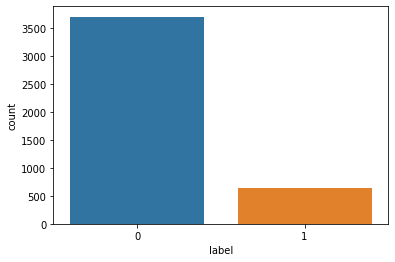

In [ ]:
sns.countplot(label_2010_12);
label_2010_12.value_counts()

0    2643
1     750
Name: label, dtype: int64

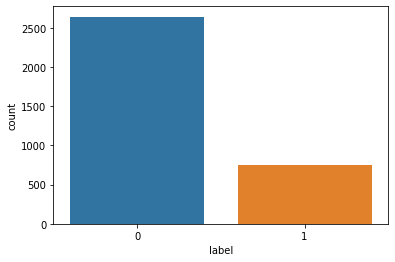

In [ ]:
sns.countplot(label_2010_9);
label_2010_9.value_counts()

0    4428
1     886
Name: label, dtype: int64

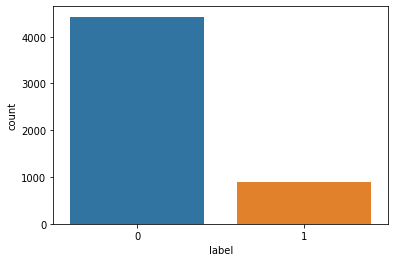

In [ ]:
sns.countplot(label_2011_9);
label_2011_9.value_counts()

0    2679
1     956
Name: label, dtype: int64

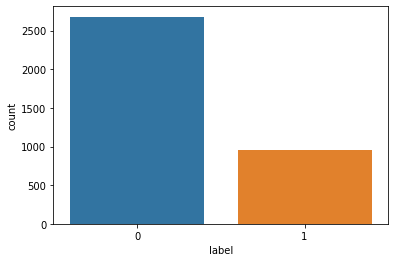

In [ ]:
sns.countplot(label_2010_10);
label_2010_10.value_counts()

0    4558
1     943
Name: label, dtype: int64

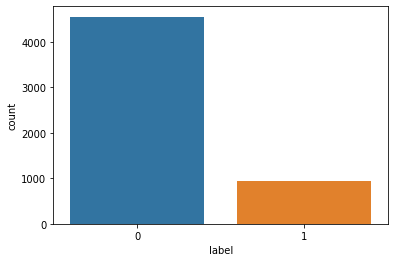

In [ ]:
sns.countplot(label_2011_10);
label_2011_10.value_counts()

0    2950
1    1064
Name: label, dtype: int64

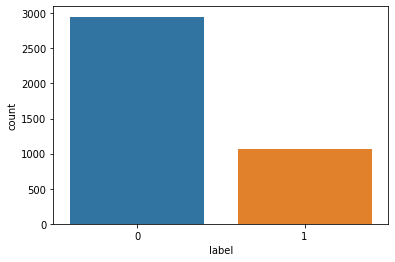

In [ ]:
sns.countplot(label_2010_11);
label_2010_11.value_counts()

0    4534
1    1188
Name: label, dtype: int64

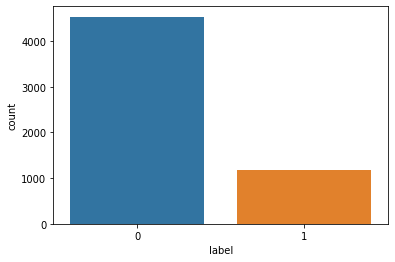

In [ ]:
sns.countplot(label_2011_11);
label_2011_11.value_counts()

## Hyperparameter 선언
- LightGBM hyperparameter
- XGBoost hyperparameter
- CatBoost hyperparameter
- random forest hyperparameter
- NGBoost hyperparameter

In [ ]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    #'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.6358813044063079, # 피처 샘플링 비율
    'bagging_fraction': 0.7019947002206903, # 데이터 샘플링 비율
    'bagging_freq': 4,
    'learning_rate':0.02179380661525133,
    #'max_depth':5,
    'max_bin':242,
    'num_leaves':8,
    'min_data_in_leaf':13,
    #'reg_alpha':0.5,
    #'reg_lambda':1.5,
    'lambda_l1':4.2493201658954217e-07,
    'lambda_l2':4.122433613632396e-07,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': 32,
    'verbose': -1,
    'n_jobs': -1,    
}

In [ ]:
model_params_xgb = {
    'objective': 'binary:logistic', # 이진 분류
    'eta': 0.01798811740179978,
    'gamma':4.71843869744652e-06,
    'lambda':0.00020474108445236137,
    'alpha':0.02412719930011848,
    'max_depth':3,
    'eval_metric': 'auc', # 평가 지표 설정
    'colsample_bytree': 0.6577690365339275, # 피처 샘플링 비율
    'subsample': 0.8551151322254398, # 데이터 샘플링 비율
    'seed': 89,
    'n_jobs': -1,    
}

In [ ]:
model_params_cbt = {
    'eta':0.026097276599840097,
    'iterations':10000,
    'loss_function':'Logloss',
    'eval_metric':'AUC',
    'rsm':0.6926711975224122,
    #'subsample': 0.6926711975224122, # 데이터 샘플링 비율
    'od_wait': 100,
    'l2_leaf_reg':0.004103327147246026,
    'depth':4,
    'random_seed':26,
    'verbose':-1,
    'thread_count':-1
}

In [ ]:
model_params_rf = {
    'n_estimators':139,
    'max_depth':8,
    'random_state':30,
    'max_features': 0.41482207743803173,
    'max_leaf_nodes': 50,
    'verbose':-1,
    'n_jobs':-1
}

In [ ]:
model_params_ngb = {
    'Dist':k_categorical(2),
    'n_estimators':100,
    'learning_rate':0.07,
    'col_sample':0.8,
    'random_state':14,
    'minibatch_frac':0.8,
    'verbose':-1,
    }

## create base data set

In [ ]:
train, test, y, features = feature_engineering1(data, '2011-12')

categorical feature: []
x_tr.shape (5722, 24) , x_te.shape (5914, 24)


In [ ]:
train_merge = train.merge(df_all,on=['customer_id','year_month','label'],how='left')

In [ ]:
print(len(train.columns))
print(len(df_all.columns))
print(len(train_merge.columns))

24
66
87


In [ ]:
test_merge = test.merge(df_all_test,on=['customer_id','year_month','label'],how='left')

print(len(test.columns))
print(len(df_all_test.columns))
print(len(test_merge.columns))

24
66
87


In [ ]:
print(len(train_merge.columns))

train_merge = train_merge.merge(df_all_nunique,on=['customer_id','year_month','label'],how='left')

print(len(df_all_nunique.columns))
print(len(train_merge.columns))

87
5
89


In [ ]:
print(len(test_merge.columns))

test_merge = test_merge.merge(df_all_nunique_test,on=['customer_id','year_month','label'],how='left')

print(len(df_all_nunique_test.columns))
print(len(test_merge.columns))

87
5
89


In [ ]:
print(len(train_merge.columns))

train_merge = train_merge.merge(df_all_mode,on=['customer_id','year_month','label'],how='left')

print(len(df_all_mode.columns))
print(len(train_merge.columns))

89
5
91


In [ ]:
print(len(test_merge.columns))

test_merge = test_merge.merge(df_all_mode_test,on=['customer_id','year_month','label'],how='left')

print(len(df_all_mode_test.columns))
print(len(test_merge.columns))

89
5
91


In [ ]:
print(len(train_merge.columns))

train_merge = train_merge.merge(df_all_ts,on=['customer_id','year_month','label'],how='left')

print(len(df_all_ts.columns))
print(len(train_merge.columns))

91
33
121


In [ ]:
print(len(test_merge.columns))

test_merge = test_merge.merge(df_all_ts_test,on=['customer_id','year_month','label'],how='left')

print(len(df_all_ts_test.columns))
print(len(test_merge.columns))

91
33
121


In [ ]:
total_features = train_merge.drop(columns=['customer_id', 'label', 'year_month']).columns

In [ ]:
len(total_features)

118

In [ ]:
train,test = feature_preprocessing(train_merge,test_merge,total_features,do_imputing=False)

categorical feature: ['year_month-mode']


In [ ]:
train.isna().sum()

customer_id                          0
year_month                           0
label                                0
quantity-mean                        0
quantity-max                         0
quantity-min                         0
quantity-sum                         0
quantity-count                       0
quantity-std                         0
quantity-skew                        0
price-mean                           0
price-max                            0
price-min                            0
price-sum                            0
price-count                          0
price-std                            0
price-skew                           0
total-mean                           0
total-max                            0
total-min                            0
total-sum                            0
total-count                          0
total-std                            0
total-skew                           0
cumsum_total_by_cust_id-mean         0
cumsum_total_by_cust_id-m

## drop feature

In [ ]:
train['quantity-count'].head(5)

0     47.0
1    211.0
2     51.0
3    107.0
4     17.0
Name: quantity-count, dtype: float64

In [ ]:
train['price-count'].head(5)

0     47.0
1    211.0
2     51.0
3    107.0
4     17.0
Name: price-count, dtype: float64

In [ ]:
train['total-count'].head(5)

0     47.0
1    211.0
2     51.0
3    107.0
4     17.0
Name: total-count, dtype: float64

In [ ]:
count_features = []

for i in total_features:
    if i.endswith('count'):
        count_features.append(i)

In [ ]:
count_features

['quantity-count',
 'price-count',
 'total-count',
 'cumsum_total_by_cust_id-count',
 'cumsum_quantity_by_cust_id-count',
 'cumsum_price_by_cust_id-count',
 'cumsum_total_by_prod_id-count',
 'cumsum_quantity_by_prod_id-count',
 'cumsum_price_by_prod_id-count',
 'cumsum_total_by_order_id-count',
 'cumsum_quantity_by_order_id-count',
 'cumsum_price_by_order_id-count',
 'order_ts_diff-count',
 'quantity_diff-count',
 'price_diff-count',
 'total_diff-count']

In [ ]:
for a,b in zip(count_features,count_features[1:]):
    c = (train[a] == train[b]).sum()
    if c != 5722:
        print(a)
        print(b)
        print(c)
        break

cumsum_price_by_order_id-count
order_ts_diff-count
0


In [ ]:
for a,b in zip(count_features,count_features[1:]):
    c = (test[a] == test[b]).sum()
    if c != 5914:
        print(a)
        print(b)
        print(c)
        break
        

cumsum_price_by_order_id-count
order_ts_diff-count
0


In [ ]:
train_drop = train_country.drop(columns=count_features[1:12])
test_drop = test_country.drop(columns=count_features[1:12])

In [ ]:
train_drop = train_drop.drop(columns = count_features[13:])
test_drop = test_drop.drop(columns = count_features[13:])

In [ ]:
drop_features = train_drop.drop(columns=['customer_id', 'label', 'year_month']).columns
print(len(drop_features))

107


In [ ]:
drop_features

Index(['quantity-mean', 'quantity-max', 'quantity-min', 'quantity-sum',
       'quantity-count', 'quantity-std', 'quantity-skew', 'price-mean',
       'price-max', 'price-min',
       ...
       'price_diff-skew', 'total_diff-mean', 'total_diff-max',
       'total_diff-min', 'total_diff-sum', 'total_diff-std', 'total_diff-skew',
       'country', 'max_product_id', 'max_description'],
      dtype='object', length=107)

# create trend feature

In [ ]:
def add_trend(train, test, year_month):
    train = train.copy()
    test = test.copy()

    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym_d = d - dateutil.relativedelta.relativedelta(months=1)

    train_window_ym = []
    test_window_ym = [] 
    for month_back in [1, 2, 3, 5, 7, 12, 20, 23]: # 1개월, 2개월, ... 20개월, 23개월 전 year_month 파악
        train_window_ym.append((prev_ym_d - dateutil.relativedelta.relativedelta(months = month_back)).strftime('%Y-%m'))
        test_window_ym.append((d - dateutil.relativedelta.relativedelta(months = month_back)).strftime('%Y-%m'))

    # aggregation 함수 선언
    agg_func = ['max','min','sum','mean','count','std','skew']

    # group by aggregation with Dictionary
    agg_dict = {
        'quantity': agg_func,
        'price': agg_func,
        'total': agg_func,
    }

    # general statistics for train data with time series trend
    for i, tr_ym in enumerate(train_window_ym):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['year_month'] >= tr_ym].groupby(['customer_id']).agg(agg_dict) # 해당 year_month 이후부터 모든 데이터에 대한 aggregation을 실시

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for level1, level2 in train_agg.columns:
            new_cols.append(f'{level1}-{level2}-{i}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        if i == 0:
            train_data = train_agg
        else:
            train_data = train_data.merge(train_agg, on=['customer_id'], how='right')


    # general statistics for test data with time series trend
    for i, tr_ym in enumerate(test_window_ym):
        # group by aggretation 함수로 test 데이터 피처 생성
        test_agg = test.loc[test['year_month'] >= tr_ym].groupby(['customer_id']).agg(agg_dict)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for level1, level2 in test_agg.columns:
            new_cols.append(f'{level1}-{level2}-{i}')

        test_agg.columns = new_cols
        test_agg.reset_index(inplace = True)
        
        if i == 0:
            test_data = test_agg
        else:
            test_data = test_data.merge(test_agg, on=['customer_id'], how='right')

    return train_data, test_data

In [ ]:
#train feature

df = data.copy()

year_month = '2011-11'

df_label = generate_label(df,year_month)[['customer_id','year_month','label']]

train = df[df['order_date']<year_month]

train= df_label.merge(train,on=['customer_id'],how='left')

train.head()

customer_id year_month  label order_id product_id              description  \
0        12346    2011-11      0   491725    TEST001  This is a test product.   
1        12346    2011-11      0   491742    TEST001  This is a test product.   
2        12346    2011-11      0   491744    TEST001  This is a test product.   
3        12346    2011-11      0   492718    TEST001  This is a test product.   
4        12346    2011-11      0   492722    TEST002  This is a test product.   

   quantity          order_date  price         country   total  
0        10 2009-12-14 08:34:00  7.425  United Kingdom  74.250  
1         5 2009-12-14 11:00:00  7.425  United Kingdom  37.125  
2         5 2009-12-14 11:02:00  7.425  United Kingdom  37.125  
3         5 2009-12-18 10:47:00  7.425  United Kingdom  37.125  
4         1 2009-12-18 10:55:00  1.650  United Kingdom   1.650

In [ ]:
#test feature

df = data.copy()

year_month = '2011-12'

df_label = generate_label(df,year_month)[['customer_id','year_month','label']]

test = df[df['order_date']<year_month]

test= df_label.merge(test,on=['customer_id'],how='left')

test.head()

customer_id year_month  label order_id product_id              description  \
0        12346    2011-12      0   491725    TEST001  This is a test product.   
1        12346    2011-12      0   491742    TEST001  This is a test product.   
2        12346    2011-12      0   491744    TEST001  This is a test product.   
3        12346    2011-12      0   492718    TEST001  This is a test product.   
4        12346    2011-12      0   492722    TEST002  This is a test product.   

   quantity          order_date  price         country   total  
0        10 2009-12-14 08:34:00  7.425  United Kingdom  74.250  
1         5 2009-12-14 11:00:00  7.425  United Kingdom  37.125  
2         5 2009-12-14 11:02:00  7.425  United Kingdom  37.125  
3         5 2009-12-18 10:47:00  7.425  United Kingdom  37.125  
4         1 2009-12-18 10:55:00  1.650  United Kingdom   1.650

In [ ]:
train_fe,test_fe = add_trend(train,test,'2011-11')

In [ ]:
train_fe.head()

customer_id  quantity-max-0  quantity-min-0  quantity-sum-0  \
0        12346           74215          -74215              53   
1        12347             240               2            2775   
2        12348             144               1            2714   
3        12349              48              -1             988   
4        12350              24               1             197   

   quantity-mean-0  quantity-count-0  quantity-std-0  quantity-skew-0  \
0         1.127660                47    15474.897433        -0.000228   
1        13.151659               211       17.701647        10.216574   
2        53.215686                51       48.700848         0.822147   
3         9.233645               107        8.408867         1.558634   
4        11.588235                17        4.345383         0.472554   

   price-max-0  price-min-0  price-sum-0  price-mean-0  price-count-0  \
0     234.8115       1.6500     936.3750     19.922872             47   
1      21.0375       0.4125     892.6995      4.230803            211   
2      66.0000       0.4785     318.6150      6.247353             51   
3     412.5000       0.6930    1484.1585     13.870640            107   
4      66.0000       1.4025     107.7450      6.337941             17   

   price-std-0  price-skew-0  total-max-0  total-min-0  total-sum-0  \
0    40.530554      4.547689    127352.94 -127352.9400     -85.3710   
1     3.737299      2.511623       411.84       8.3160    7749.5715   
2    17.617275      3.224035       396.00       1.6500    3332.0100   
3    50.462126      7.102276       412.50     -24.6675    4367.5335   
4    15.402339      4.098028        66.00      14.0250     551.7600   

   total-mean-0  total-count-0   total-std-0  total-skew-0  quantity-max-1  \
0     -1.816404             47  26554.972603      0.000214           74215   
1     36.727827            211     36.057268      6.436852             240   
2     65.333529             51     72.939156      2.528198             144   
3     40.818070            107     54.673882      4.889357              48   
4     32.456471             17     12.004638      1.178640              24   

   quantity-min-1  quantity-sum-1  quantity-mean-1  quantity-count-1  \
0          -74215              53         1.127660                47   
1               2            2775        13.151659               211   
2               1            2714        53.215686                51   
3              -1             988         9.233645               107   
4               1             197        11.588235                17   

   quantity-std-1  quantity-skew-1  price-max-1  price-min-1  price-sum-1  \
0    15474.897433        -0.000228     234.8115       1.6500     936.3750   
1       17.701647        10.216574      21.0375       0.4125     892.6995   
2       48.700848         0.822147      66.0000       0.4785     318.6150   
3        8.408867         1.558634     412.5000       0.6930    1484.1585   
4        4.345383         0.472554      66.0000       1.4025     107.7450   

   price-mean-1  price-count-1  price-std-1  price-skew-1  total-max-1  \
0     19.922872             47    40.530554      4.547689    127352.94   
1      4.230803            211     3.737299      2.511623       411.84   
2      6.247353             51    17.617275      3.224035       396.00   
3     13.870640            107    50.462126      7.102276       412.50   
4      6.337941             17    15.402339      4.098028        66.00   

   total-min-1  total-sum-1  total-mean-1  total-count-1   total-std-1  \
0 -127352.9400     -85.3710     -1.816404             47  26554.972603   
1       8.3160    7749.5715     36.727827            211     36.057268   
2       1.6500    3332.0100     65.333529             51     72.939156   
3     -24.6675    4367.5335     40.818070            107     54.673882   
4      14.0250     551.7600     32.456471             17     12.004638   

   total-skew-1  quantity-max-2  quantity-min-

In [ ]:
test_fe.head()

customer_id  quantity-max-0  quantity-min-0  quantity-sum-0  \
0        12346           74215          -74215              53   
1        12347             240               2            2775   
2        12348             144               1            2714   
3        12349              48              -1            1619   
4        12350              24               1             197   

   quantity-mean-0  quantity-count-0  quantity-std-0  quantity-skew-0  \
0         1.127660                47    15474.897433        -0.000228   
1        13.151659               211       17.701647        10.216574   
2        53.215686                51       48.700848         0.822147   
3         8.994444               180        7.846643         1.718638   
4        11.588235                17        4.345383         0.472554   

   price-max-0  price-min-0  price-sum-0  price-mean-0  price-count-0  \
0     234.8115       1.6500     936.3750     19.922872             47   
1      21.0375       0.4125     892.6995      4.230803            211   
2      66.0000       0.4785     318.6150      6.247353             51   
3     495.0000       0.6930    2482.5735     13.792075            180   
4      66.0000       1.4025     107.7450      6.337941             17   

   price-std-0  price-skew-0  total-max-0  total-min-0  total-sum-0  \
0    40.530554      4.547689    127352.94 -127352.9400     -85.3710   
1     3.737299      2.511623       411.84       8.3160    7749.5715   
2    17.617275      3.224035       396.00       1.6500    3332.0100   
3    53.400142      7.661229       495.00     -24.6675    7267.4910   
4    15.402339      4.098028        66.00      14.0250     551.7600   

   total-mean-0  total-count-0   total-std-0  total-skew-0  quantity-max-1  \
0     -1.816404             47  26554.972603      0.000214           74215   
1     36.727827            211     36.057268      6.436852             240   
2     65.333529             51     72.939156      2.528198             144   
3     40.374950            180     55.548906      5.864055              48   
4     32.456471             17     12.004638      1.178640              24   

   quantity-min-1  quantity-sum-1  quantity-mean-1  quantity-count-1  \
0          -74215              53         1.127660                47   
1               2            2775        13.151659               211   
2               1            2714        53.215686                51   
3              -1            1619         8.994444               180   
4               1             197        11.588235                17   

   quantity-std-1  quantity-skew-1  price-max-1  price-min-1  price-sum-1  \
0    15474.897433        -0.000228     234.8115       1.6500     936.3750   
1       17.701647        10.216574      21.0375       0.4125     892.6995   
2       48.700848         0.822147      66.0000       0.4785     318.6150   
3        7.846643         1.718638     495.0000       0.6930    2482.5735   
4        4.345383         0.472554      66.0000       1.4025     107.7450   

   price-mean-1  price-count-1  price-std-1  price-skew-1  total-max-1  \
0     19.922872             47    40.530554      4.547689    127352.94   
1      4.230803            211     3.737299      2.511623       411.84   
2      6.247353             51    17.617275      3.224035       396.00   
3     13.792075            180    53.400142      7.661229       495.00   
4      6.337941             17    15.402339      4.098028        66.00   

   total-min-1  total-sum-1  total-mean-1  total-count-1   total-std-1  \
0 -127352.9400     -85.3710     -1.816404             47  26554.972603   
1       8.3160    7749.5715     36.727827            211     36.057268   
2       1.6500    3332.0100     65.333529             51     72.939156   
3     -24.6675    7267.4910     40.374950            180     55.548906   
4      14.0250     551.7600     32.456471             17     12.004638   

   total-skew-1  quantity-max-2  quantity-min-

In [ ]:
train_trend = train.merge(train_fe,on=['customer_id'],how='left')

train_trend.head()

customer_id year_month  label  quantity-mean  quantity-max  quantity-min  \
0        12346    2011-11      0       1.127660       74215.0      -74215.0   
1        12347    2011-11      0      13.151659         240.0           2.0   
2        12348    2011-11      0      53.215686         144.0           1.0   
3        12349    2011-11      1       9.233645          48.0          -1.0   
4        12350    2011-11      0      11.588235          24.0           1.0   

   quantity-sum  quantity-count  quantity-std  quantity-skew  price-mean  \
0          53.0            47.0  15474.897433      -0.000228   19.922872   
1        2775.0           211.0     17.701647      10.216574    4.230803   
2        2714.0            51.0     48.700848       0.822147    6.247353   
3         988.0           107.0      8.408867       1.558634   13.870640   
4         197.0            17.0      4.345383       0.472554    6.337941   

   price-max  price-min  price-sum  price-count  price-std  price-skew  \
0   234.8115     1.6500   936.3750         47.0  40.530554    4.547689   
1    21.0375     0.4125   892.6995        211.0   3.737299    2.511623   
2    66.0000     0.4785   318.6150         51.0  17.617275    3.224035   
3   412.5000     0.6930  1484.1585        107.0  50.462126    7.102276   
4    66.0000     1.4025   107.7450         17.0  15.402339    4.098028   

   total-mean  total-max    total-min  total-sum  total-count     total-std  \
0   -1.816404  127352.94 -127352.9400   -85.3710         47.0  26554.972603   
1   36.727827     411.84       8.3160  7749.5715        211.0     36.057268   
2   65.333529     396.00       1.6500  3332.0100         51.0     72.939156   
3   40.818070     412.50     -24.6675  4367.5335        107.0     54.673882   
4   32.456471      66.00      14.0250   551.7600         17.0     12.004638   

   total-skew  cumsum_total_by_cust_id-mean  cumsum_total_by_cust_id-max  \
0    0.000214                   2953.304457                  127267.5690   
1    6.436852                   3491.749628                    7749.5715   
2    2.528198                   1096.986000                    3332.0100   
3    4.889357                   2014.247369                    4367.5335   
4    1.178640                    281.849118                     551.7600   

   cumsum_total_by_cust_id-min  cumsum_total_by_cust_id-sum  \
0                     -85.3710                  138805.3095   
1                      29.2050                  736759.1715   
2                      21.7800                   55946.2860   
3                     -39.8475                  215524.4685   
4                      41.5800                    4791.4350   

   cumsum_total_by_cust_id-count  cumsum_total_by_cust_id-std  \
0                           47.0                 18527.811314   
1                          211.0                  2302.307503   
2                           51.0                  1000.019165   
3                          107.0                  1402.866250   
4                           17.0                   161.979220   

   cumsum_total_by_cust_id-skew  cumsum_quantity_by_cust_id-mean  \
0                      6.855058                      1631.063830   
1                      0.228741                      1339.677725   
2                      0.812596                      1069.450980   
3                      0.089354                       467.682243   
4                      0.200043                       107.941176   

   cumsum_quantity_by_cust_id-max  cumsum_quantity_by_cust_id-min  \
0                         74268.0                            10.0   
1                          2775.0                             6.0   
2                          2714.0                            24.0   
3                           988.0                            -5.0   
4                           197.0                            12.0   

   cumsum_quantity_by_cust_id-sum  cumsum_quantity_by_cust_id-count  \
0                         766

In [ ]:
test_trend = test.merge(test_fe,on=['customer_id'],how='left')

test_trend.head()

customer_id year_month  label  quantity-mean  quantity-max  quantity-min  \
0        12346    2011-12      0       1.127660       74215.0      -74215.0   
1        12347    2011-12      0      13.151659         240.0           2.0   
2        12348    2011-12      0      53.215686         144.0           1.0   
3        12349    2011-12      0       8.994444          48.0          -1.0   
4        12350    2011-12      0      11.588235          24.0           1.0   

   quantity-sum  quantity-count  quantity-std  quantity-skew  price-mean  \
0          53.0            47.0  15474.897433      -0.000228   19.922872   
1        2775.0           211.0     17.701647      10.216574    4.230803   
2        2714.0            51.0     48.700848       0.822147    6.247353   
3        1619.0           180.0      7.846643       1.718638   13.792075   
4         197.0            17.0      4.345383       0.472554    6.337941   

   price-max  price-min  price-sum  price-count  price-std  price-skew  \
0   234.8115     1.6500   936.3750         47.0  40.530554    4.547689   
1    21.0375     0.4125   892.6995        211.0   3.737299    2.511623   
2    66.0000     0.4785   318.6150         51.0  17.617275    3.224035   
3   495.0000     0.6930  2482.5735        180.0  53.400142    7.661229   
4    66.0000     1.4025   107.7450         17.0  15.402339    4.098028   

   total-mean  total-max    total-min  total-sum  total-count     total-std  \
0   -1.816404  127352.94 -127352.9400   -85.3710         47.0  26554.972603   
1   36.727827     411.84       8.3160  7749.5715        211.0     36.057268   
2   65.333529     396.00       1.6500  3332.0100         51.0     72.939156   
3   40.374950     495.00     -24.6675  7267.4910        180.0     55.548906   
4   32.456471      66.00      14.0250   551.7600         17.0     12.004638   

   total-skew  cumsum_total_by_cust_id-mean  cumsum_total_by_cust_id-max  \
0    0.000214                   2953.304457                  127267.5690   
1    6.436852                   3491.749628                    7749.5715   
2    2.528198                   1096.986000                    3332.0100   
3    5.864055                   3445.769525                    7267.4910   
4    1.178640                    281.849118                     551.7600   

   cumsum_total_by_cust_id-min  cumsum_total_by_cust_id-sum  \
0                     -85.3710                  138805.3095   
1                      29.2050                  736759.1715   
2                      21.7800                   55946.2860   
3                     -39.8475                  620238.5145   
4                      41.5800                    4791.4350   

   cumsum_total_by_cust_id-count  cumsum_total_by_cust_id-std  \
0                           47.0                 18527.811314   
1                          211.0                  2302.307503   
2                           51.0                  1000.019165   
3                          180.0                  2091.575371   
4                           17.0                   161.979220   

   cumsum_total_by_cust_id-skew  cumsum_quantity_by_cust_id-mean  \
0                      6.855058                      1631.063830   
1                      0.228741                      1339.677725   
2                      0.812596                      1069.450980   
3                     -0.182170                       786.527778   
4                      0.200043                       107.941176   

   cumsum_quantity_by_cust_id-max  cumsum_quantity_by_cust_id-min  \
0                         74268.0                            10.0   
1                          2775.0                             6.0   
2                          2714.0                            24.0   
3                          1619.0                            -5.0   
4                           197.0                            12.0   

   cumsum_quantity_by_cust_id-sum  cumsum_quantity_by_cust_id-count  \
0                         766

In [ ]:
total_features = train_trend.drop(columns=['customer_id','year_month','label']).columns
len(total_features)

409

In [ ]:
train_trend, test_trend = feature_preprocessing(train_trend,test_trend,total_features,do_imputing=True)

categorical feature: []


## NGBoost optuna hyperparameter tuning

In [ ]:
def objective(trial, label=label_2011_11):
    model_params_ngb = {
    'Dist':k_categorical(2),
    'n_estimators':trial.suggest_int('n_estimators',80,300),
    'learning_rate':trial.suggest_uniform('learning_rate',0.01,0.3),
    #'col_sample':trial.suggest_uniform('col_sample',0.4,1.0),
    'random_state':trial.suggest_int('random_state',0,120),
    #'minibatch_frac':trial.suggest_uniform('minibatch_frac',0.4,1.0),
    'verbose':-1,
    }

    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds = make_ngb_oof_prediction(train_country, y, test_country, total_features, model_params=model_params_ngb)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(label, y_oof)
    
    return val_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) # 100회 동안 하이퍼 파라미터 탐색

[I 2021-04-22 12:34:36,864] A new study created in memory with name: no-name-59535627-304d-4709-aeac-3b6ab2a129b1


fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
[iter 0] loss=0.5108 val_loss=0.4720 scale=2.0000 norm=4.0000
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=0.4252)
Fold 1 | AUC: 0.7810035908636582
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
[iter 0] loss=0.5108 val_loss=0.4540 scale=2.0000 norm=4.0000
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=0.3851)
Fold 2 | AUC: 0.8279994817310183
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)
[iter 0] loss=0.5110 val_loss=0.4628 scale=2.0000 norm=4.0000
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=0.4086)
Fold 3 | AUC: 0.7939781975658927
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)
[iter 0] loss=0.5110 val_

[I 2021-04-22 12:35:57,412] Trial 0 finished with value: 0.8113564701566466 and parameters: {'n_estimators': 115, 'learning_rate': 0.13536851419037965, 'random_state': 95}. Best is trial 0 with value: 0.8113564701566466.



Mean AUC = 0.8117335114092246
OOF AUC = 0.8113564701566466
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
[iter 0] loss=0.5108 val_loss=0.4533 scale=2.0000 norm=4.0000
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=0.4274)
Fold 1 | AUC: 0.76890756302521
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
[iter 0] loss=0.5108 val_loss=0.4249 scale=2.0000 norm=4.0000
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=0.3894)
Fold 2 | AUC: 0.82338133491282
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)
[iter 0] loss=0.5110 val_loss=0.4392 scale=2.0000 norm=4.0000
== Early stopping achieved.
== Best iteration / VAL2 (val_loss=0.4095)
Fold 3 | AUC: 0.7940248637347868
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 1

[I 2021-04-22 12:37:01,474] Trial 1 finished with value: 0.8097834320264845 and parameters: {'n_estimators': 260, 'learning_rate': 0.2387500605078789, 'random_state': 2}. Best is trial 0 with value: 0.8113564701566466.



Mean AUC = 0.8095686341333312
OOF AUC = 0.8097834320264845
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
[iter 0] loss=0.5108 val_loss=0.4572 scale=2.0000 norm=4.0000
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=0.4297)
Fold 1 | AUC: 0.7744789545774258
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
[iter 0] loss=0.5108 val_loss=0.4311 scale=2.0000 norm=4.0000
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=0.3913)
Fold 2 | AUC: 0.8188002073075925
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)
[iter 0] loss=0.5110 val_loss=0.4443 scale=2.0000 norm=4.0000
== Early stopping achieved.
== Best iteration / VAL3 (val_loss=0.4125)
Fold 3 | AUC: 0.7872396027775703
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (515

[I 2021-04-22 12:38:06,381] Trial 2 finished with value: 0.806496723595312 and parameters: {'n_estimators': 181, 'learning_rate': 0.21215507662830116, 'random_state': 47}. Best is trial 0 with value: 0.8113564701566466.



Mean AUC = 0.8072217007809305
OOF AUC = 0.806496723595312
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
[iter 0] loss=0.5108 val_loss=0.4469 scale=2.0000 norm=4.0000


[W 2021-04-22 12:38:09,303] Trial 3 failed because of the following error: LinAlgError('Singular matrix')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/_optimize.py", line 217, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-1058-0b88fea32195>", line 13, in objective
    y_oof, test_preds = make_ngb_oof_prediction(train_country, y, test_country, total_features, model_params=model_params_ngb)
  File "<ipython-input-1051-445e3d9018d1>", line 31, in make_ngb_oof_prediction
    clf.fit(x_tr, y_tr, X_val=x_val, Y_val=y_val, early_stopping_rounds=30) # Y should have on
  File "/opt/conda/lib/python3.7/site-packages/ngboost/ngboost.py", line 269, in fit
    grads = D.grad(Y_batch, natural=self.natural_gradient)
  File "/opt/conda/lib/python3.7/site-packages/ngboost/scores.py", line 12, in grad
    grad = np.linalg.solve(metric, grad)
  File "<__array_function__ internals>", line 6, in solve
  File "/opt/conda/lib/python3.7/site

LinAlgError: Singular matrix

# NGBoost prediction

In [ ]:
y_oof, test_preds5 = make_ngb_oof_prediction(train_country, y, test_country, total_features, model_params=model_params_ngb)

fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
[iter 0] loss=0.5163 val_loss=0.4877 scale=2.0000 norm=4.0291
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=0.4237)
Fold 1 | AUC: 0.7856309924850998
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
[iter 0] loss=0.5156 val_loss=0.4814 scale=2.0000 norm=4.0256
== Early stopping achieved.
== Best iteration / VAL23 (val_loss=0.3839)
Fold 2 | AUC: 0.8296005626920371
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)
[iter 0] loss=0.5120 val_loss=0.4825 scale=2.0000 norm=4.0052
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=0.4027)
Fold 3 | AUC: 0.8049634137235869
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)
[iter 0] loss=0.5136 val

## random forest optuna hyperparameter tuning

In [ ]:
def objective(trial, label=label_2011_11):
    model_params_rf = {
    'n_estimators':trial.suggest_int('n_estimators',80,240),
    'max_depth':trial.suggest_int('max_depth',3,9),
    'random_state':trial.suggest_int('random_state',0,120),
    'max_features':trial.suggest_uniform('max_features',0.4,1.0),
    'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',10,100),
    'verbose':-1,
    'n_jobs':-1}

    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds, fi = make_rf_oof_prediction(train_country, y, test_country, total_features, model_params=model_params_rf)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(label, y_oof)
    
    return val_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) # 100회 동안 하이퍼 파라미터 탐색

[I 2021-04-22 09:41:34,293] A new study created in memory with name: no-name-a20346a1-4711-430c-ac45-a1d2409bfb7e
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7881390441639212
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8216414319031577
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8080153811692675
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8463189725976258
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7848145880868904
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8118055169087501
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8314504609790936
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8451499805220102
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8200975754540226
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7834047526295288
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 116 out of 116 | elapsed:    0.1s finished
[I 2021-04-22 09:42:03,072] Trial 0 finished with value: 0.8108825907954713 and parameters: {'n_estimators': 116, 'max_depth': 9, 'random_state': 52, 'max_features': 0.8430670335509013, 'max_leaf_nodes': 23}. Best is trial 0 with value: 0.8108825907954713.



Mean AUC = 0.8140837704414268
OOF AUC = 0.8108825907954713
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.79898567356458
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8207344611853552
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8037220936310013
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8491002762637199
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7875044057358042
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8098020665219731
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8355315636188251
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8528020479715066
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8229914482349231
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7833120002968074
--------------------------------------------------------------------------------


[I 2021-04-22 09:42:37,877] Trial 1 finished with value: 0.8152538842327108 and parameters: {'n_estimators': 130, 'max_depth': 6, 'random_state': 49, 'max_features': 0.7839862282572667, 'max_leaf_nodes': 81}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8164486037024496
OOF AUC = 0.8152538842327108
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7948857957279828
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8243715988598082
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.7995968043007542
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8464683043380871
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7856308086148367
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8104327823844768
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8330829020349861
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8478676238707403
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8206726399168939
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7768564379394141
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[I 2021-04-22 09:43:07,696] Trial 2 finished with value: 0.8133767464380609 and parameters: {'n_estimators': 82, 'max_depth': 8, 'random_state': 49, 'max_features': 0.908729239577553, 'max_leaf_nodes': 69}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.813986569798798
OOF AUC = 0.8133767464380609
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.1s finished


Fold 1 | AUC: 0.7933124791766927
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8199848221226815
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.1s finished


Fold 3 | AUC: 0.802919435526021
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8447883222578959
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7829966423655554
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8105904613501029
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8300406255217319
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.842525089506001
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8201346763871112
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7814198527092957
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    0.1s finished
[I 2021-04-22 09:43:40,079] Trial 3 finished with value: 0.8111373067537602 and parameters: {'n_estimators': 156, 'max_depth': 4, 'random_state': 99, 'max_features': 0.8846255854207665, 'max_leaf_nodes': 51}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8128712406923088
OOF AUC = 0.8111373067537602
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished


Fold 1 | AUC: 0.7950153629733832
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8185410728167919
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8028447696557903
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8458336444411259
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7821804218376092
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8096814884894354
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8301890292540857
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8447882464243974
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8191886025933552
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 239 out of 239 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7817166601740033
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 239 out of 239 | elapsed:    0.1s finished
[I 2021-04-22 09:44:23,126] Trial 4 finished with value: 0.8115910427610913 and parameters: {'n_estimators': 239, 'max_depth': 4, 'random_state': 83, 'max_features': 0.8204756389885257, 'max_leaf_nodes': 88}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8129979298659977
OOF AUC = 0.8115910427610913
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7929885610631919
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8222615037204308
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8056820727245575
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


Fold 4 | AUC: 0.848278951691182
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.787087020238559
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8093661305581834
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8374422616728812
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


Fold 8 | AUC: 0.8485261654330607
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.816313280278999
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7854267534828501
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished
[I 2021-04-22 09:44:56,902] Trial 5 finished with value: 0.814131426008356 and parameters: {'n_estimators': 155, 'max_depth': 7, 'random_state': 28, 'max_features': 0.6705330318779872, 'max_leaf_nodes': 43}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8153372700863896
OOF AUC = 0.814131426008356
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


Fold 1 | AUC: 0.7976714915040906
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8223818161625884
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8025461061748675
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8465056372732024
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7901942233847182
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8076687628693862
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.833546663698592
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8480160276030942
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8196338137904169
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7806778340475263
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 232 out of 232 | elapsed:    0.1s finished
[I 2021-04-22 09:45:40,964] Trial 6 finished with value: 0.8143499396256343 and parameters: {'n_estimators': 232, 'max_depth': 7, 'random_state': 26, 'max_features': 0.5514098364171407, 'max_leaf_nodes': 61}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8148842376508483
OOF AUC = 0.8143499396256343
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 1 | AUC: 0.80206752304446
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8235479213711917
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8012114537444934
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8464683043380871
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7833491012298959
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8080397722002709
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8310052497820319
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.850065854156232
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8158124176823047
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.783033743298644
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:    0.0s finished
[I 2021-04-22 09:46:00,292] Trial 7 finished with value: 0.8141421010576282 and parameters: {'n_estimators': 82, 'max_depth': 6, 'random_state': 47, 'max_features': 0.5506186333290621, 'max_leaf_nodes': 78}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8144601340847613
OOF AUC = 0.8141421010576282
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7984303853700071
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8231962388479622
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8063540655566339
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8466176360785485
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished


Fold 5 | AUC: 0.789619158921847
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8085962861965978
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8326933422375573
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8468473482108074
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8200419240543899
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.782087669504888
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:    0.1s finished
[I 2021-04-22 09:46:33,022] Trial 8 finished with value: 0.8146612797583244 and parameters: {'n_estimators': 161, 'max_depth': 7, 'random_state': 32, 'max_features': 0.5466404861382695, 'max_leaf_nodes': 63}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.815448405497924
OOF AUC = 0.8146612797583244
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7954503387257986
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8225854218339318
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8010994549391472
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8418576868513402
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7880794701986755
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8084571576975161
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8331200029680746
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8492403583950136
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8223607323724191
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7816239078412821
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 178 out of 178 | elapsed:    0.1s finished
[I 2021-04-22 09:47:29,531] Trial 9 finished with value: 0.813419632288181 and parameters: {'n_estimators': 178, 'max_depth': 8, 'random_state': 56, 'max_features': 0.9695547632201214, 'max_leaf_nodes': 64}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.81438745318232
OOF AUC = 0.813419632288181
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished


Fold 1 | AUC: 0.786972938955318
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished


Fold 2 | AUC: 0.817023285084959
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8040674232808183
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8389643843799
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7726825829669616
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8085684604967814
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8312278553805628
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8348730220565047
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished


Fold 9 | AUC: 0.817036748474224
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 117 out of 117 | elapsed:    0.0s finished


Fold 10 | AUC: 0.7819114400727178
--------------------------------------------------------------------------------


[I 2021-04-22 09:47:48,313] Trial 10 finished with value: 0.8074379844615839 and parameters: {'n_estimators': 117, 'max_depth': 3, 'random_state': 2, 'max_features': 0.6958728940616016, 'max_leaf_nodes': 98}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8093328141148747
OOF AUC = 0.8074379844615839
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7960796653463148
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished


Fold 2 | AUC: 0.822030133639359
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8070447248562683
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8465056372732024
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7849258908861557
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8112675533789675
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8347524440239673
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8482942846012578
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.819652364256961
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.783590257294971
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    0.1s finished
[I 2021-04-22 09:48:15,146] Trial 11 finished with value: 0.8144440657122616 and parameters: {'n_estimators': 194, 'max_depth': 5, 'random_state': 14, 'max_features': 0.4464767110401841, 'max_leaf_nodes': 99}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8154142955557424
OOF AUC = 0.8144440657122616
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 1 | AUC: 0.7961259393625293
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8232610224706622
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8025647726424252
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8472149630403942
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7873838277032666
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8100803235201365
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 7 | AUC: 0.834659691691246
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8492496336282858
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8202274287198323
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7842024226909307
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished
[I 2021-04-22 09:48:40,080] Trial 12 finished with value: 0.8145419048595052 and parameters: {'n_estimators': 126, 'max_depth': 6, 'random_state': 78, 'max_features': 0.5685348982309103, 'max_leaf_nodes': 36}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8154970025469709
OOF AUC = 0.8145419048595052
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7987080294672935
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8218635471809869
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8059247368028074
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.0s finished


Fold 4 | AUC: 0.844788322257896
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7878197636670563
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8079284694010054
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished


Fold 7 | AUC: 0.8314133600460052
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished


Fold 8 | AUC: 0.8520414788431929
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8187990427959263
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.781846513439813
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:    0.1s finished
[I 2021-04-22 09:49:04,623] Trial 13 finished with value: 0.8142441173980653 and parameters: {'n_estimators': 136, 'max_depth': 7, 'random_state': 33, 'max_features': 0.403690839463156, 'max_leaf_nodes': 78}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8151133263901983
OOF AUC = 0.8142441173980653
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.795820530855514
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8198460000740384
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8017434480698873
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8468416336892407
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7850000927523326
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8128072421021388
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8315803142449032
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8486096425325097
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8199677221882131
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7813085499100303
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 207 out of 207 | elapsed:    0.1s finished
[I 2021-04-22 09:49:46,749] Trial 14 finished with value: 0.8134734716671195 and parameters: {'n_estimators': 207, 'max_depth': 5, 'random_state': 74, 'max_features': 0.7599906245242631, 'max_leaf_nodes': 82}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8143525176418808
OOF AUC = 0.8134734716671195
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 1 | AUC: 0.791063561988672
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8199570577129529
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8073433883371911
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8478869558724706
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7873745524699947
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8091435249596528
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8342701318938173
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8452705585545478
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8177045652698165
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7845363310887269
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:    0.1s finished
[I 2021-04-22 09:50:11,274] Trial 15 finished with value: 0.8133798097130694 and parameters: {'n_estimators': 99, 'max_depth': 9, 'random_state': 5, 'max_features': 0.6360491831858548, 'max_leaf_nodes': 52}. Best is trial 1 with value: 0.8152538842327108.



Mean AUC = 0.8144550628147843
OOF AUC = 0.8133798097130694
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.799383630104024
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8227705178987895
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8069700589860375
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.848092287015605
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7862800749438847
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8123805813716214
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8343257832934499
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8482015322685366
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.821470309978296
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7821618713710649
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished
[I 2021-04-22 09:50:33,972] Trial 16 finished with value: 0.815310972539689 and parameters: {'n_estimators': 144, 'max_depth': 5, 'random_state': 35, 'max_features': 0.47027581377239003, 'max_leaf_nodes': 90}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.816203664723131
OOF AUC = 0.815310972539689
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.795117165809055
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8191426350275794
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8027514373180018
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8442283282311654
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7856308086148366
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8114159571113214
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8319884245088764
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8473018346411412
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8200419240543899
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7828111377001131
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished
[I 2021-04-22 09:51:05,576] Trial 17 finished with value: 0.8129206897678447 and parameters: {'n_estimators': 139, 'max_depth': 5, 'random_state': 67, 'max_features': 0.7705707918649548, 'max_leaf_nodes': 92}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.814042965301648
OOF AUC = 0.8129206897678447
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.789490245437382
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8164402324806574
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8013421190173972
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8368550735458822
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.772153894670451
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8092177268258297
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8262192294136198
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8349564991559537
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8193926577253418
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.777477878568646
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.0s finished
[I 2021-04-22 09:51:27,063] Trial 18 finished with value: 0.8059671483248899 and parameters: {'n_estimators': 101, 'max_depth': 3, 'random_state': 99, 'max_features': 0.9908919557406998, 'max_leaf_nodes': 74}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8083545556841161
OOF AUC = 0.8059671483248899
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


Fold 1 | AUC: 0.7907026246621998
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


Fold 2 | AUC: 0.819568355976752
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8075860524154409
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8485962816396626
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7827740367670247
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8113510304784165
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8307455432504128
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8437215945981041
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8183909325319533
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7844435787560057
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished
[I 2021-04-22 09:51:49,922] Trial 19 finished with value: 0.8128675930010294 and parameters: {'n_estimators': 182, 'max_depth': 4, 'random_state': 41, 'max_features': 0.4683471644836892, 'max_leaf_nodes': 89}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8137880031075974
OOF AUC = 0.8128675930010294
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7990226927775516
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.820290230629697
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8010527887702532
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8462069737922795
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7865954328751368
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8115829113102195
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8328973973695438
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8495186153931772
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8180570241341569
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7796019069879607
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished
[I 2021-04-22 09:52:25,519] Trial 20 finished with value: 0.8136624664524974 and parameters: {'n_estimators': 143, 'max_depth': 6, 'random_state': 118, 'max_features': 0.7480086109459401, 'max_leaf_nodes': 99}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8144825974039976
OOF AUC = 0.8136624664524974
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.8017250953244734
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8223633065561026
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8045994176062122
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8414470245650713
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7880238187990428
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8029940453002393
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8321368282412301
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8513922125141448
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8199491717216688
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7834975049622498
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished
[I 2021-04-22 09:53:02,281] Trial 21 finished with value: 0.8137101792814188 and parameters: {'n_estimators': 164, 'max_depth': 7, 'random_state': 20, 'max_features': 0.6162391124359015, 'max_leaf_nodes': 66}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8148128425590435
OOF AUC = 0.8137101792814188
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7981712508792063
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8227705178987895
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8072500559994027
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8487082804450086
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7856308086148367
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8104142319179328
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8363848850798598
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8449366501567515
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8201532268536554
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7836273582280594
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished
[I 2021-04-22 09:53:28,081] Trial 22 finished with value: 0.8148424771164074 and parameters: {'n_estimators': 169, 'max_depth': 5, 'random_state': 38, 'max_features': 0.48109392059039935, 'max_leaf_nodes': 85}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8158047266073502
OOF AUC = 0.8148424771164074
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


Fold 1 | AUC: 0.794154666271795
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8226409506533892
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8057567385947884
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8496416038228926
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7866696347413138
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8087446899289517
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


Fold 7 | AUC: 0.8343814346930825
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8471719813753317
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8201903277867438
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7858348637468233
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished
[I 2021-04-22 09:53:54,500] Trial 23 finished with value: 0.8145403268087432 and parameters: {'n_estimators': 175, 'max_depth': 5, 'random_state': 41, 'max_features': 0.48180057889033, 'max_leaf_nodes': 85}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8155186891615113
OOF AUC = 0.8145403268087432
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7990226927775517
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8241587383852219
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8081087135070558
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8473642947808556
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7878754150666889
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8094496076576325
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8340846272283748
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8454189622869014
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.821154952047044
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7829595414324669
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 204 out of 204 | elapsed:    0.1s finished
[I 2021-04-22 09:54:20,543] Trial 24 finished with value: 0.8148133295905682 and parameters: {'n_estimators': 204, 'max_depth': 5, 'random_state': 62, 'max_features': 0.40613999870176853, 'max_leaf_nodes': 92}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8159597545169794
OOF AUC = 0.8148133295905682
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7897863991411543
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8202717210232111
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8065220637646533
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8468416336892407
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7828482386332017
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8092733782254624
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8304858367187935
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8436752184317438
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8187248409297493
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 out of 129 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7842766245571076
--------------------------------------------------------------------------------


[I 2021-04-22 09:54:39,259] Trial 25 finished with value: 0.8125081687333562 and parameters: {'n_estimators': 129, 'max_depth': 4, 'random_state': 40, 'max_features': 0.49524635513694865, 'max_leaf_nodes': 73}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8132705955114319
OOF AUC = 0.8125081687333562
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7957094732165995
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8199755673194388
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8073807212723064
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8452736504143956
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7858163132802789
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8105997365833751
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8339176730294767
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


Fold 8 | AUC: 0.846810247277719
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8198378689224034
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7818836143729014
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.1s finished
[I 2021-04-22 09:55:10,122] Trial 26 finished with value: 0.813885992701608 and parameters: {'n_estimators': 143, 'max_depth': 6, 'random_state': 16, 'max_features': 0.6226844707534854, 'max_leaf_nodes': 81}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8147204865688894
OOF AUC = 0.813885992701608
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 1 | AUC: 0.794552622811239
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8209288120534557
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8079220488314791
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8463003061300679
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7887287365277236
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8137347654293506
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8300035245886435
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 8 | AUC: 0.845613742185616
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8194483091249746
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7826998349008478
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[I 2021-04-22 09:55:28,237] Trial 27 finished with value: 0.8138452418613424 and parameters: {'n_estimators': 108, 'max_depth': 5, 'random_state': 58, 'max_features': 0.4314175838424629, 'max_leaf_nodes': 95}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8149932702583398
OOF AUC = 0.8138452418613424
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.78624180949913
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8172824195757596
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8049914134249235
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8458709773762413
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7794164023225183
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8096258370898027
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8298365703897452
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.83831413360046
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8175654367707347
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.784796037620346
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 152 out of 152 | elapsed:    0.1s finished
[I 2021-04-22 09:55:49,930] Trial 28 finished with value: 0.8080616858186334 and parameters: {'n_estimators': 152, 'max_depth': 6, 'random_state': 39, 'max_features': 0.5062540440374298, 'max_leaf_nodes': 10}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8113941037669661
OOF AUC = 0.8080616858186334
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7926183689334765
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8217247251323437
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8050940789964907
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8437336668408871
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7824957797688612
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8122043519394513
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8319142226426995
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8448717235238467
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8187619418628378
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7812343480438534
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 169 out of 169 | elapsed:    0.1s finished
[I 2021-04-22 09:56:22,862] Trial 29 finished with value: 0.8122373009613857 and parameters: {'n_estimators': 169, 'max_depth': 4, 'random_state': 48, 'max_features': 0.841588145983883, 'max_leaf_nodes': 85}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8134653207684748
OOF AUC = 0.8122373009613857
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7932476955539924
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8249268870543813
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.802406107668185
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8465616366758755
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.788042369265587
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8076873133359304
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8296510657243029
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8498988999573339
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.820190327786744
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7836459086946037
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.1s finished
[I 2021-04-22 09:56:51,406] Trial 30 finished with value: 0.8135509818074883 and parameters: {'n_estimators': 120, 'max_depth': 5, 'random_state': 68, 'max_features': 0.7966867049343086, 'max_leaf_nodes': 72}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8146258211716936
OOF AUC = 0.8135509818074883
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7966719727538593
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8227520082923038
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8065593966997684
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8496789367580079
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7862615244773405
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.811304654312056
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.833787819763667
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8452149071549151
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8198935203220361
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7816053573747379
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 216 out of 216 | elapsed:    0.1s finished
[I 2021-04-22 09:57:19,665] Trial 31 finished with value: 0.8147658024146777 and parameters: {'n_estimators': 216, 'max_depth': 5, 'random_state': 63, 'max_features': 0.42022471921306537, 'max_leaf_nodes': 90}. Best is trial 16 with value: 0.815310972539689.



Mean AUC = 0.8153730097908692
OOF AUC = 0.8147658024146777
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.8024099507644469
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.823122200422019
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8055887403867692
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8473642947808556
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7902684252508951
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8111933515127906
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8341588290945517
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8490177527964828
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8182054278665108
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7834047526295287
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished
[I 2021-04-22 09:57:47,582] Trial 32 finished with value: 0.8155409038183631 and parameters: {'n_estimators': 191, 'max_depth': 6, 'random_state': 54, 'max_features': 0.4006493427042752, 'max_leaf_nodes': 94}. Best is trial 32 with value: 0.8155409038183631.



Mean AUC = 0.816473372550485
OOF AUC = 0.8155409038183631
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7946544256469107
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8242883056306223
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8027327708504443
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8479802882102592
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7872632496707292
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8127886916355946
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8312649563136513
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8502049826553137
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8197822175227708
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7824215779026842
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished
[I 2021-04-22 09:58:39,471] Trial 33 finished with value: 0.8144669010350529 and parameters: {'n_estimators': 189, 'max_depth': 6, 'random_state': 52, 'max_features': 0.8980458390450141, 'max_leaf_nodes': 95}. Best is trial 32 with value: 0.8155409038183631.



Mean AUC = 0.815338146603898
OOF AUC = 0.8144669010350529
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7950431273831118
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8219560952134157
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.7969274994400061
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8454229821548571
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7876157085350697
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8112861038455117
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.1s finished


Fold 7 | AUC: 0.8297252675904798
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8486281929990539
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8175376110709185
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.0s finished


Fold 10 | AUC: 0.7793607509228857
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 151 out of 151 | elapsed:    0.1s finished
[I 2021-04-22 09:59:21,637] Trial 34 finished with value: 0.8127529522544961 and parameters: {'n_estimators': 151, 'max_depth': 8, 'random_state': 49, 'max_features': 0.7212041917994871, 'max_leaf_nodes': 86}. Best is trial 32 with value: 0.8155409038183631.



Mean AUC = 0.813350333915531
OOF AUC = 0.8127529522544961
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.793608632880465
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8191889090437938
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8087620398715747
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.84652430374076
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7849258908861558
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8096907637227077
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


Fold 7 | AUC: 0.8328788469029995
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8421540801751165
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8187619418628378
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7818094125067246
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 193 out of 193 | elapsed:    0.1s finished
[I 2021-04-22 09:59:46,766] Trial 35 finished with value: 0.8128726984593769 and parameters: {'n_estimators': 193, 'max_depth': 4, 'random_state': 26, 'max_features': 0.5024883989718247, 'max_leaf_nodes': 81}. Best is trial 32 with value: 0.8155409038183631.



Mean AUC = 0.8138304821593136
OOF AUC = 0.8128726984593769
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7988561063191797
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8225854218339319
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.805084745762712
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.848222952288509
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7880238187990428
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8085962861965977
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8368115458103772
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.849110505129204
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8184280334650417
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7855751572152041
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished
[I 2021-04-22 10:00:14,568] Trial 36 finished with value: 0.815493747948534 and parameters: {'n_estimators': 172, 'max_depth': 6, 'random_state': 34, 'max_features': 0.4515154636549695, 'max_leaf_nodes': 77}. Best is trial 32 with value: 0.8155409038183631.



Mean AUC = 0.81612945728198
OOF AUC = 0.815493747948534
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7950986562025691
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.822724243882575
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8042634211901739
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8440416635555887
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.790973342979576
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8092826534587345
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8291316526610645
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8498710742575177
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8223050809727864
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7782106219971433
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 220 out of 220 | elapsed:    0.1s finished
[I 2021-04-22 10:01:16,078] Trial 37 finished with value: 0.8136462218123003 and parameters: {'n_estimators': 220, 'max_depth': 7, 'random_state': 8, 'max_features': 0.86964497050452, 'max_leaf_nodes': 59}. Best is trial 32 with value: 0.8155409038183631.



Mean AUC = 0.8145902411157728
OOF AUC = 0.8136462218123003
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7985784622218931
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.825028689890053
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8060180691405958
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8480922870156052
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.788042369265587
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8086333871296864
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8352718570872057
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8492403583950137
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8205056857179958
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7810117424453225
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 182 out of 182 | elapsed:    0.1s finished
[I 2021-04-22 10:01:44,870] Trial 38 finished with value: 0.815323875425331 and parameters: {'n_estimators': 182, 'max_depth': 6, 'random_state': 55, 'max_features': 0.4500163665881366, 'max_leaf_nodes': 78}. Best is trial 32 with value: 0.8155409038183631.



Mean AUC = 0.8160422908308957
OOF AUC = 0.815323875425331
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7991892792359234
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8214563358383002
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8056820727245576
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8488202792503547
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7910660953122971
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8086333871296864
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8335095627655036
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8482571836681693
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8212106034466767
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7806221826478936
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[I 2021-04-22 10:02:13,852] Trial 39 finished with value: 0.8152431163569231 and parameters: {'n_estimators': 184, 'max_depth': 6, 'random_state': 93, 'max_features': 0.4447184447359002, 'max_leaf_nodes': 77}. Best is trial 32 with value: 0.8155409038183631.



Mean AUC = 0.8158446982019363
OOF AUC = 0.8152431163569231
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7943675267463814
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8232610224706622
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8059807362054805
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8484469498992012
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7924388298365704
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8125475355705197
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.832118277774686
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8468937243771683
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8222308791066095
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7829780918990112
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 201 out of 201 | elapsed:    0.1s finished
[I 2021-04-22 10:02:50,054] Trial 40 finished with value: 0.8151750745211266 and parameters: {'n_estimators': 201, 'max_depth': 7, 'random_state': 32, 'max_features': 0.531756826173964, 'max_leaf_nodes': 46}. Best is trial 32 with value: 0.8155409038183631.



Mean AUC = 0.8161263573886289
OOF AUC = 0.8151750745211266
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


Fold 1 | AUC: 0.8018361529633881
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8233443156998482
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8017434480698873
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8471776301052789
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7859090656130002
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8111748010462462
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8355501140853692
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8498154228578849
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8193370063257092
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7786187322611163
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 175 out of 175 | elapsed:    0.1s finished
[I 2021-04-22 10:03:24,187] Trial 41 finished with value: 0.8146657354310639 and parameters: {'n_estimators': 175, 'max_depth': 6, 'random_state': 55, 'max_features': 0.5843654690532669, 'max_leaf_nodes': 69}. Best is trial 32 with value: 0.8155409038183631.



Mean AUC = 0.8154506689027727
OOF AUC = 0.8146657354310639
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7993188464813239
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8215673934772146
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.7980661539610243
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8410736952139177
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7847960376203461
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8114901589774983
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8331756543677074
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8506687443189196
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8146993896896507
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 158 out of 158 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7786558331942048
--------------------------------------------------------------------------------


[I 2021-04-22 10:04:15,050] Trial 42 finished with value: 0.8122444486030723 and parameters: {'n_estimators': 158, 'max_depth': 7, 'random_state': 45, 'max_features': 0.9410523421684194, 'max_leaf_nodes': 69}. Best is trial 32 with value: 0.8155409038183631.



Mean AUC = 0.8133511907301808
OOF AUC = 0.8122444486030723
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


Fold 1 | AUC: 0.7963943286565728
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8229185947506755
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8084260434555366
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8454976480250878
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7908620401803106
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8104884337841098
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8356428664180905
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8526907451722411
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8215074109113844
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7819392657725341
--------------------------------------------------------------------------------


[I 2021-04-22 10:04:39,000] Trial 43 finished with value: 0.8160707575683314 and parameters: {'n_estimators': 132, 'max_depth': 6, 'random_state': 22, 'max_features': 0.4625104792550855, 'max_leaf_nodes': 95}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.8166367377126543
OOF AUC = 0.8160707575683314
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.8013734128012439
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8259911894273129
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8020607780183678
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.847513626521317
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.788357727196839
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8083087539651622
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8374051607397927
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8466247426122767
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8173706568720204
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7832192479640863
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 168 out of 168 | elapsed:    0.1s finished
[I 2021-04-22 10:05:06,864] Trial 44 finished with value: 0.8152179603712466 and parameters: {'n_estimators': 168, 'max_depth': 6, 'random_state': 23, 'max_features': 0.4567461684061525, 'max_leaf_nodes': 100}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.8158225296118419
OOF AUC = 0.8152179603712466
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.8003183652315552
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished


Fold 2 | AUC: 0.822492873801503
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8047487493466736
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8445643246472038
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7876342590016139
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.806221826478936
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8357912701504443
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8497226705251638
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8212662548463094
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7837943124269575
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[I 2021-04-22 10:05:34,759] Trial 45 finished with value: 0.8146371448643173 and parameters: {'n_estimators': 148, 'max_depth': 6, 'random_state': 12, 'max_features': 0.5208776511021143, 'max_leaf_nodes': 96}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.8156554906456359
OOF AUC = 0.8146371448643173
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7981527412727205
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8252322955613964
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8053647427760771
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8464683043380871
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7864655796093273
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8102843786521231
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8330272506353534
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8478305229376519
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8159608214146585
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.78240302743614
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 out of 184 | elapsed:    0.1s finished
[I 2021-04-22 10:06:01,929] Trial 46 finished with value: 0.8145485883686148 and parameters: {'n_estimators': 184, 'max_depth': 6, 'random_state': 33, 'max_features': 0.4001775345716166, 'max_leaf_nodes': 92}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.8151189664633535
OOF AUC = 0.8145485883686148
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.798754303483508
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8238625846814497
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8009687896662436
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8473082953781826
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7888400393269891
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8061661750793032
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8316916170441686
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8476264678056655
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8159608214146585
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 195 out of 195 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7828482386332016
--------------------------------------------------------------------------------


[I 2021-04-22 10:06:34,934] Trial 47 finished with value: 0.8139223806956494 and parameters: {'n_estimators': 195, 'max_depth': 8, 'random_state': 27, 'max_features': 0.42914866981122773, 'max_leaf_nodes': 77}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.814402733251337
OOF AUC = 0.8139223806956494
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7993928849072669
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8241957575981933
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.7994288060927349
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8423430150078399
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7897304617211124
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8081139740664479
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8337321683640344
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8467545958780863
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8209879978481459
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7793422004563414
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.1s finished
[I 2021-04-22 10:07:01,669] Trial 48 finished with value: 0.8136838165510419 and parameters: {'n_estimators': 160, 'max_depth': 7, 'random_state': 0, 'max_features': 0.4003088844757864, 'max_leaf_nodes': 100}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.8144021861940203
OOF AUC = 0.8136838165510419
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


Fold 1 | AUC: 0.7991707696294376
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8213267685928998
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8069233928171433
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8518442469946989
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7863357263435176
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8094588828909048
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8314690114456378
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.846494889346467
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8181312260003339
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7833862021629844
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished
[I 2021-04-22 10:07:23,543] Trial 49 finished with value: 0.8143018554906511 and parameters: {'n_estimators': 134, 'max_depth': 5, 'random_state': 20, 'max_features': 0.4682712076433271, 'max_leaf_nodes': 33}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.8154541116224026
OOF AUC = 0.8143018554906511
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7940621182393661
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8178654721800616
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8078847158963637
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8471962965728366
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7844621292225499
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.0s finished


Fold 6 | AUC: 0.806388780677834
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.1s finished


Fold 7 | AUC: 0.8333611590331497
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8471348804422432
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8182425287995992
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7841838722243865
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 123 out of 123 | elapsed:    0.1s finished
[I 2021-04-22 10:07:50,089] Trial 50 finished with value: 0.8132051102110652 and parameters: {'n_estimators': 123, 'max_depth': 6, 'random_state': 33, 'max_features': 0.5797078621358818, 'max_leaf_nodes': 89}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.814078195328839
OOF AUC = 0.8132051102110652
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7968755784252026
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8224558545885314
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.800362129470619
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8450309863361458
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7863913777431504
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8094774333574489
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8305229376518819
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8516890199788523
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8204685847849074
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7815682564416495
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished
[I 2021-04-22 10:08:21,731] Trial 51 finished with value: 0.8136590318714271 and parameters: {'n_estimators': 114, 'max_depth': 6, 'random_state': 54, 'max_features': 0.796380657139486, 'max_leaf_nodes': 80}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.8144842158778388
OOF AUC = 0.8136590318714271
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


Fold 1 | AUC: 0.8017250953244734
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8219931144263873
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8084447099230943
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8470282983648174
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7881907729979409
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8076594876361141
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8332498562338841
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8466803940119094
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8214332090452076
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7829966423655554
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    0.1s finished
[I 2021-04-22 10:08:47,664] Trial 52 finished with value: 0.8156757807452559 and parameters: {'n_estimators': 144, 'max_depth': 7, 'random_state': 47, 'max_features': 0.4539870982963378, 'max_leaf_nodes': 59}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.8159401580329383
OOF AUC = 0.8156757807452559
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7974493762262614
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


Fold 2 | AUC: 0.821622922296672
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8040207571119241
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8450869857388188
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7871890478045523
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8073348544715899
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


Fold 7 | AUC: 0.8316359656445359
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished


Fold 8 | AUC: 0.848711670098503
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.818613538130484
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7802326228504646
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished
[I 2021-04-22 10:09:13,806] Trial 53 finished with value: 0.8134219529510662 and parameters: {'n_estimators': 146, 'max_depth': 7, 'random_state': 44, 'max_features': 0.4455969408263996, 'max_leaf_nodes': 60}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.8141897740373806
OOF AUC = 0.8134219529510662
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7965424055084589
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8235849405841633
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8020421115508102
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8471402971701635
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7861873226111636
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8089672955274824
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.834975049622498
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8494536887602723
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8226389893705826
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7836088077615152
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 155 out of 155 | elapsed:    0.1s finished
[I 2021-04-22 10:09:43,908] Trial 54 finished with value: 0.8146700982772884 and parameters: {'n_estimators': 155, 'max_depth': 7, 'random_state': 69, 'max_features': 0.5304665133064935, 'max_leaf_nodes': 52}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.815514090846711
OOF AUC = 0.8146700982772884
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7960519009365861
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8229926331766186
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8045527514373179
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8467669678190098
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7867160109076743
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8102751034188509
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8329344983026322
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8511788821488862
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8191886025933554
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.781364201309663
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished
[I 2021-04-22 10:10:06,666] Trial 55 finished with value: 0.8147725787503025 and parameters: {'n_estimators': 134, 'max_depth': 7, 'random_state': 37, 'max_features': 0.4263533221698839, 'max_leaf_nodes': 47}. Best is trial 43 with value: 0.8160707575683314.



Mean AUC = 0.8152021552050596
OOF AUC = 0.8147725787503025
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7932106763410212
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.823122200422019
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished


Fold 3 | AUC: 0.807819383259912
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8493802732770851
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7925686831023799
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.81193537017456
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8336579664978574
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8536182684994528
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished


Fold 9 | AUC: 0.820357281985642
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7857792123471905
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.1s finished
[I 2021-04-22 10:10:37,371] Trial 56 finished with value: 0.8164757596550715 and parameters: {'n_estimators': 180, 'max_depth': 8, 'random_state': 51, 'max_features': 0.4753459038784248, 'max_leaf_nodes': 55}. Best is trial 56 with value: 0.8164757596550715.



Mean AUC = 0.817144931590712
OOF AUC = 0.8164757596550715
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7979769000111058
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8234090993225482
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8050660792951543
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8486522810423356
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7910289943792087
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.808290203498618
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8336023150982248
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished


Fold 8 | AUC: 0.8515313410132265
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8192071530598994
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7854824048824828
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 181 out of 181 | elapsed:    0.1s finished
[I 2021-04-22 10:11:11,525] Trial 57 finished with value: 0.81546125866814 and parameters: {'n_estimators': 181, 'max_depth': 9, 'random_state': 60, 'max_features': 0.5518410918463195, 'max_leaf_nodes': 56}. Best is trial 56 with value: 0.8164757596550715.



Mean AUC = 0.8164246771602804
OOF AUC = 0.81546125866814
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7935068300447934
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8224373449820458
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8060180691405958
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8486709475098931
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7868551394067561
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8126124622034243
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8330829020349861
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8458363477841467
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8206540894503496
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7853154506835848
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 198 out of 198 | elapsed:    0.1s finished
[I 2021-04-22 10:11:45,660] Trial 58 finished with value: 0.814383914130275 and parameters: {'n_estimators': 198, 'max_depth': 9, 'random_state': 74, 'max_features': 0.5474495374746426, 'max_leaf_nodes': 39}. Best is trial 56 with value: 0.8164757596550715.



Mean AUC = 0.8154989583240575
OOF AUC = 0.814383914130275
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.800022211527783
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8228630659312183
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8076233853505564
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8468416336892407
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7898417645203778
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8061197989129426
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8396868681247334
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


Fold 8 | AUC: 0.8476357430389374
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8239375220286791
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7842580740905634
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished
[I 2021-04-22 10:12:21,177] Trial 59 finished with value: 0.8159471126498034 and parameters: {'n_estimators': 210, 'max_depth': 9, 'random_state': 60, 'max_features': 0.48746215339906396, 'max_leaf_nodes': 56}. Best is trial 56 with value: 0.8164757596550715.



Mean AUC = 0.8168830067215033
OOF AUC = 0.8159471126498034
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7991337504164662
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8232887868803909
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8052247442693946
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8463003061300679
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7885988832619141
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8106553879830078
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8334910122989593
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8484334131003395
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8211735025135882
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7863171758769733
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.1s finished
[I 2021-04-22 10:12:58,966] Trial 60 finished with value: 0.8152811752282418 and parameters: {'n_estimators': 230, 'max_depth': 8, 'random_state': 49, 'max_features': 0.4869844868858357, 'max_leaf_nodes': 56}. Best is trial 56 with value: 0.8164757596550715.



Mean AUC = 0.8162616962731102
OOF AUC = 0.8152811752282418
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7982267796986636
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8223447969496168
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8056167400881059
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8486896139774509
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7910011686793923
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8083180291984343
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8336765169644017
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8465134398130113
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8188732446621033
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7876899104012466
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 215 out of 215 | elapsed:    0.1s finished
[I 2021-04-22 10:13:36,332] Trial 61 finished with value: 0.8151653277370083 and parameters: {'n_estimators': 215, 'max_depth': 9, 'random_state': 60, 'max_features': 0.51205140781776, 'max_leaf_nodes': 56}. Best is trial 56 with value: 0.8164757596550715.



Mean AUC = 0.8160950240432426
OOF AUC = 0.8151653277370083
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7945248584015105
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8227797727020323
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8052340775031733
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8480362876129321
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7872725249040013
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8095330847570816
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


Fold 7 | AUC: 0.838703693397889
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8502049826553139
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8212106034466768
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7867809375405792
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    0.1s finished
[I 2021-04-22 10:14:09,929] Trial 62 finished with value: 0.8153128290699972 and parameters: {'n_estimators': 210, 'max_depth': 9, 'random_state': 64, 'max_features': 0.4679772267879066, 'max_leaf_nodes': 48}. Best is trial 56 with value: 0.8164757596550715.



Mean AUC = 0.8164280822921189
OOF AUC = 0.8153128290699972
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7978565875689483
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8231129456187762
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8026581049802137
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8466363025461061
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7886267089617303
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8040421466599885
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8343072328269057
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8474966145398558
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8228244940360251
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7867623870740349
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 177 out of 177 | elapsed:    0.1s finished
[I 2021-04-22 10:14:50,345] Trial 63 finished with value: 0.8145020822843937 and parameters: {'n_estimators': 177, 'max_depth': 9, 'random_state': 80, 'max_features': 0.6628923725716879, 'max_leaf_nodes': 63}. Best is trial 56 with value: 0.8164757596550715.



Mean AUC = 0.8154323524812584
OOF AUC = 0.8145020822843937
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7951449302187835
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8232795320771481
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8051314119316061
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8481482864182782
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.789155397258241
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8077986161351959
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8376463168048677
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8508820746841783
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8217114660433711
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7848702394865231
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 172 out of 172 | elapsed:    0.1s finished
[I 2021-04-22 10:15:17,335] Trial 64 finished with value: 0.8155962284215482 and parameters: {'n_estimators': 172, 'max_depth': 8, 'random_state': 44, 'max_features': 0.41749257892761626, 'max_leaf_nodes': 54}. Best is trial 56 with value: 0.8164757596550715.



Mean AUC = 0.8163768271058194
OOF AUC = 0.8155962284215482
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7943952911561102
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8237422722392922
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8066060628686629
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8501269319793922
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7911402971784741
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8079470198675498
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8366260411449348
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8481273304023595
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8201717773201995
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7879125159997774
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished
[I 2021-04-22 10:15:45,006] Trial 65 finished with value: 0.8158683957647345 and parameters: {'n_estimators': 191, 'max_depth': 8, 'random_state': 43, 'max_features': 0.4186897853529984, 'max_leaf_nodes': 42}. Best is trial 56 with value: 0.8164757596550715.



Mean AUC = 0.8166795540156753
OOF AUC = 0.8158683957647345
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


Fold 1 | AUC: 0.792507311294562
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8219375856069299
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8111140147838422
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8467576345852311
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7837108353275084
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8122971042721725
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8330458011018977
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8457714211512419
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8184651343981301
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7872632496707291
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.1s finished
[I 2021-04-22 10:16:11,659] Trial 66 finished with value: 0.8138962964448186 and parameters: {'n_estimators': 189, 'max_depth': 8, 'random_state': 45, 'max_features': 0.4133280619571816, 'max_leaf_nodes': 31}. Best is trial 56 with value: 0.8164757596550715.



Mean AUC = 0.8152870092192245
OOF AUC = 0.8138962964448186
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


Fold 1 | AUC: 0.7966164439344019
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8235294117647058
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8102273575748525
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8493616068095273
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7874951305025322
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


Fold 6 | AUC: 0.810442057617749
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8365703897453021
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8496577438922588
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8222123286400653
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7871148459383754
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 164 out of 164 | elapsed:    0.1s finished
[I 2021-04-22 10:16:36,626] Trial 67 finished with value: 0.8164970169271006 and parameters: {'n_estimators': 164, 'max_depth': 8, 'random_state': 43, 'max_features': 0.40227416334729876, 'max_leaf_nodes': 41}. Best is trial 67 with value: 0.8164970169271006.



Mean AUC = 0.8173227316419771
OOF AUC = 0.8164970169271006
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7907859178913856
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8228723207344613
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8092847009631898
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8465149705069813
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7862244235442521
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8109614706809876
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8327304431706457
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8460404029161332
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8221381267738885
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7867252861409465
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 167 out of 167 | elapsed:    0.1s finished
[I 2021-04-22 10:17:00,590] Trial 68 finished with value: 0.8137190906268982 and parameters: {'n_estimators': 167, 'max_depth': 8, 'random_state': 43, 'max_features': 0.4314742734968635, 'max_leaf_nodes': 26}. Best is trial 67 with value: 0.8164970169271006.



Mean AUC = 0.8154278063322872
OOF AUC = 0.8137190906268982
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7949598341539259
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8239736423203642
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8058500709325767
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8478869558724706
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7874487543361717
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8095701856901701
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8335466636985921
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8465969169124603
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8211735025135882
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7903055261839835
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished
[I 2021-04-22 10:17:27,548] Trial 69 finished with value: 0.8149192446446527 and parameters: {'n_estimators': 162, 'max_depth': 8, 'random_state': 49, 'max_features': 0.4843171151640635, 'max_leaf_nodes': 41}. Best is trial 67 with value: 0.8164970169271006.



Mean AUC = 0.8161312052614302
OOF AUC = 0.8149192446446527
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7964961314922445
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8229185947506756
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8041327559172703
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8444709923094152
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7898881406867383
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8145138850242083
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8403546849203258
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8523568367744447
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8220453744411672
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished


Fold 10 | AUC: 0.7875415066688927
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished
[I 2021-04-22 10:17:50,382] Trial 70 finished with value: 0.8166305014562624 and parameters: {'n_estimators': 139, 'max_depth': 8, 'random_state': 30, 'max_features': 0.41482207743803173, 'max_leaf_nodes': 50}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8174718902985383
OOF AUC = 0.8166305014562624
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7962092325917154
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8270462369970015
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8067553946091242
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8460949749869334
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7913165266106442
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8098113417552452
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8335095627655036
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8477470458382028
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8214146585786632
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7841282208247536
--------------------------------------------------------------------------------


[I 2021-04-22 10:18:13,298] Trial 71 finished with value: 0.8156086671746134 and parameters: {'n_estimators': 140, 'max_depth': 8, 'random_state': 29, 'max_features': 0.42226808330352317, 'max_leaf_nodes': 44}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8164033195557786
OOF AUC = 0.8156086671746134
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished


Fold 1 | AUC: 0.800790360196942
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8242697960241365
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8081460464421713
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8470656312999327
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7882464243975738
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8113417552451443
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8363663346133154
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8516611942790362
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8199862726547572
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7871333964049195
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:    0.1s finished
[I 2021-04-22 10:18:36,410] Trial 72 finished with value: 0.816340511422117 and parameters: {'n_estimators': 132, 'max_depth': 8, 'random_state': 30, 'max_features': 0.43917012030895247, 'max_leaf_nodes': 43}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.817500721155793
OOF AUC = 0.816340511422117
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7956169251841706
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8237330174360493
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8089953707160458
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8467016351825581
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7867067356744022
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8104606080842933
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8332127553007957
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8514200382139612
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8238818706290465
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7845734320218153
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 131 out of 131 | elapsed:    0.1s finished
[I 2021-04-22 10:18:59,190] Trial 73 finished with value: 0.8152139688310839 and parameters: {'n_estimators': 131, 'max_depth': 8, 'random_state': 21, 'max_features': 0.46685786154076825, 'max_leaf_nodes': 37}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8165302388443139
OOF AUC = 0.8152139688310839
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished


Fold 1 | AUC: 0.7911098360048866
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished


Fold 2 | AUC: 0.823372080109577
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8061300679459419
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8477189576644516
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7893780028567718
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8108779935815384
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8339176730294766
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished


Fold 8 | AUC: 0.8493980373606398
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8237334668966925
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7872632496707292
--------------------------------------------------------------------------------


[I 2021-04-22 10:19:23,898] Trial 74 finished with value: 0.8152612175274283 and parameters: {'n_estimators': 138, 'max_depth': 8, 'random_state': 17, 'max_features': 0.497548196309432, 'max_leaf_nodes': 43}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8162899365120705
OOF AUC = 0.8152612175274283
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7980046644208345
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8211324177247993
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8040674232808181
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8429963413723587
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7888122136271727
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8030775223996884
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8300777264548205
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.852050754076465
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8221752277069767
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7841653217578421
--------------------------------------------------------------------------------


[I 2021-04-22 10:19:44,795] Trial 75 finished with value: 0.81379957121576 and parameters: {'n_estimators': 114, 'max_depth': 9, 'random_state': 29, 'max_features': 0.43608856620016784, 'max_leaf_nodes': 50}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8146559612821778
OOF AUC = 0.81379957121576
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7979676452078629
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8226779698663607
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.1s finished


Fold 3 | AUC: 0.807231389531845
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8466176360785485
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7886823603613631
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8118982692414715
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.1s finished


Fold 7 | AUC: 0.836644591611479
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.1s finished


Fold 8 | AUC: 0.8519023503441111
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8215630623110172
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7843508264232846
--------------------------------------------------------------------------------


[I 2021-04-22 10:20:08,013] Trial 76 finished with value: 0.8161674827973902 and parameters: {'n_estimators': 128, 'max_depth': 8, 'random_state': 37, 'max_features': 0.4593521604423517, 'max_leaf_nodes': 50}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8169536100977345
OOF AUC = 0.8161674827973902
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7952374782512124
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 2 | AUC: 0.82556546847814
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8109740162771598
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8451056522063766
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7897119112545681
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8109336449811713
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8387407943309774
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 8 | AUC: 0.8489899270966663
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8191329511937225
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7879681673994101
--------------------------------------------------------------------------------


[I 2021-04-22 10:20:28,880] Trial 77 finished with value: 0.8161057531646415 and parameters: {'n_estimators': 126, 'max_depth': 8, 'random_state': 37, 'max_features': 0.4009450267841748, 'max_leaf_nodes': 50}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8172360011469405
OOF AUC = 0.8161057531646415
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7949968533668975
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8263613815570282
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8103206899126411
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8464776375718659
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7892203238911458
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8094310571910883
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


Fold 7 | AUC: 0.8358098206169886
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8500473036896878
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8181497764668781
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7880423692655871
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished
[I 2021-04-22 10:20:47,963] Trial 78 finished with value: 0.8158124213759415 and parameters: {'n_estimators': 108, 'max_depth': 8, 'random_state': 37, 'max_features': 0.40063987004385326, 'max_leaf_nodes': 50}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8168857213529809
OOF AUC = 0.8158124213759415
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7941731758782808
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8250286898900528
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 3 | AUC: 0.806111401478384
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.845189651310386
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7879867178659543
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8088838184280334
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8324892871055707
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 8 | AUC: 0.8473203851076854
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8193555567922534
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished


Fold 10 | AUC: 0.7869849926725657
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished
[I 2021-04-22 10:21:10,916] Trial 79 finished with value: 0.8142549781003685 and parameters: {'n_estimators': 126, 'max_depth': 9, 'random_state': 29, 'max_features': 0.48722978575909687, 'max_leaf_nodes': 45}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8153523676529166
OOF AUC = 0.8142549781003685
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7837615222300374
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8168196794136158
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8060740685432688
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8421563503322631
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7807334854471589
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8100803235201365
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8311814792142022
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8407164190179384
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8173613816387482
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.0s finished


Fold 10 | AUC: 0.7826163578013987
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    0.1s finished
[I 2021-04-22 10:21:31,743] Trial 80 finished with value: 0.8077852484557381 and parameters: {'n_estimators': 126, 'max_depth': 8, 'random_state': 11, 'max_features': 0.5185213709900335, 'max_leaf_nodes': 12}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8111501067158768
OOF AUC = 0.8077852484557381
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7902398845000558
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8250657091030245
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8064473978944224
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8495669379526618
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7886174337284582
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8110820487135251
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8361437290147847
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.846235182814848
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8195596119242399
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.786131671211531
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:    0.1s finished
[I 2021-04-22 10:21:51,784] Trial 81 finished with value: 0.8148730170399778 and parameters: {'n_estimators': 121, 'max_depth': 8, 'random_state': 25, 'max_features': 0.4088968689038532, 'max_leaf_nodes': 34}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8159089606857551
OOF AUC = 0.8148730170399778
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7923962536556473
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8211231629215563
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8118606734861494
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8501269319793923
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7907785630808615
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8124547832377986
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8325634889717476
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8493331107277349
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8209879978481459
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7856957352477415
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[I 2021-04-22 10:22:09,408] Trial 82 finished with value: 0.815920378613365 and parameters: {'n_estimators': 89, 'max_depth': 8, 'random_state': 41, 'max_features': 0.43703202614130865, 'max_leaf_nodes': 41}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8167320701156775
OOF AUC = 0.815920378613365
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7955521415614704
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8240106615333358
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.810320689912641
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8439109982826849
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7864006529764223
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8108687183482666
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8360695271486077
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8481922570352644
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8170367484742241
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7886545346615467
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    0.1s finished
[I 2021-04-22 10:22:29,180] Trial 83 finished with value: 0.8152062642303047 and parameters: {'n_estimators': 108, 'max_depth': 8, 'random_state': 36, 'max_features': 0.44001301863596864, 'max_leaf_nodes': 40}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8161016929934463
OOF AUC = 0.8152062642303047
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 1 | AUC: 0.792100099951875
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8226687150631179
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8022941088628388
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8459083103113566
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7886174337284583
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8080212217337264
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8355593893186413
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8468009720444469
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8185207857977629
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


Fold 10 | AUC: 0.789711911254568
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished
[I 2021-04-22 10:22:46,824] Trial 84 finished with value: 0.8140458399611465 and parameters: {'n_estimators': 85, 'max_depth': 9, 'random_state': 39, 'max_features': 0.4597483661851266, 'max_leaf_nodes': 49}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8150202948066791
OOF AUC = 0.8140458399611465
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7892126013400955
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8225484026209604
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8140259837228403
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8491749421339505
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7867902127738513
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8100895987534086
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8359953252824308
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8484055874005232
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8195781623907841
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.79160405884208
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:    0.0s finished
[I 2021-04-22 10:23:04,953] Trial 85 finished with value: 0.8154579169135852 and parameters: {'n_estimators': 84, 'max_depth': 8, 'random_state': 41, 'max_features': 0.4795940656598116, 'max_leaf_nodes': 46}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8167424875260925
OOF AUC = 0.8154579169135852
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7939880798134231
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8225113834079887
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8071567236616143
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8456656462331068
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7949802437531304
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8104884337841097
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8368486467434656
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8496577438922589
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.821470309978296
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  91 out of  91 | elapsed:    0.0s finished


Fold 10 | AUC: 0.7857421114141021
--------------------------------------------------------------------------------


[I 2021-04-22 10:23:23,650] Trial 86 finished with value: 0.8163678952441633 and parameters: {'n_estimators': 91, 'max_depth': 8, 'random_state': 23, 'max_features': 0.44025812835851785, 'max_leaf_nodes': 53}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8168509322681495
OOF AUC = 0.8163678952441633
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.794635916040425
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8231222004220189
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8049354140222504
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8463376390651833
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7858348637468232
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8096072866232585
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.832674791771013
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8518003227781179
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8229172463687462
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  94 out of  94 | elapsed:    0.0s finished


Fold 10 | AUC: 0.7861687721446193
--------------------------------------------------------------------------------


[I 2021-04-22 10:23:44,222] Trial 87 finished with value: 0.8149415230083514 and parameters: {'n_estimators': 94, 'max_depth': 8, 'random_state': 17, 'max_features': 0.5010339720276107, 'max_leaf_nodes': 54}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8158034452982456
OOF AUC = 0.8149415230083514
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7927109169659055
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


Fold 2 | AUC: 0.822094917262059
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8065967296348839
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8482416187560666
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7920307195725973
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


Fold 6 | AUC: 0.8096907637227075
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8345112879588923
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8477470458382027
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.817741666202905
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7886174337284584
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:    0.1s finished
[I 2021-04-22 10:24:08,825] Trial 88 finished with value: 0.815168855144594 and parameters: {'n_estimators': 130, 'max_depth': 9, 'random_state': 23, 'max_features': 0.4769560763520594, 'max_leaf_nodes': 52}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8159983099642678
OOF AUC = 0.815168855144594
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7939695702069375
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8237607818457783
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8065220637646531
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8477376241320093
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7876806351679745
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8086148366631422
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8339733244291094
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8490455784962991
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished


Fold 9 | AUC: 0.8228430445025693
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7850557441519653
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    0.1s finished
[I 2021-04-22 10:24:32,759] Trial 89 finished with value: 0.8148392281883681 and parameters: {'n_estimators': 140, 'max_depth': 7, 'random_state': 51, 'max_features': 0.45228006841777746, 'max_leaf_nodes': 37}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8159203203360438
OOF AUC = 0.8148392281883681
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.1s finished


Fold 1 | AUC: 0.793617887683708
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8249916706770815
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8033114313447324
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8446763234525498
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7891182963251526
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8064351568441946
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8327489936371899
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8501771569554974
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8191886025933552
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 104 out of 104 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7812343480438534
--------------------------------------------------------------------------------


[I 2021-04-22 10:24:52,003] Trial 90 finished with value: 0.813590618729569 and parameters: {'n_estimators': 104, 'max_depth': 8, 'random_state': 31, 'max_features': 0.40194408679792343, 'max_leaf_nodes': 58}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8145499867557314
OOF AUC = 0.813590618729569
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7954873579387702
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8234831377484915
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8083327111177481
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8474949600537593
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7961860240785055
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8111005991800693
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8332684067004286
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8463928617804737
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8212106034466767
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7851299460181423
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:    0.0s finished
[I 2021-04-22 10:25:10,598] Trial 91 finished with value: 0.8159175938179025 and parameters: {'n_estimators': 89, 'max_depth': 8, 'random_state': 35, 'max_features': 0.44076925486348945, 'max_leaf_nodes': 52}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8168086608063065
OOF AUC = 0.8159175938179025
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished


Fold 1 | AUC: 0.79131344167623
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished


Fold 2 | AUC: 0.824871358234924
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8080620473381617
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8483069513925184
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished


Fold 5 | AUC: 0.7920770957389579
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished


Fold 6 | AUC: 0.8125382603372475
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8292058545272415
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished


Fold 8 | AUC: 0.8458827239505073
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8210993006474113
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:    0.0s finished


Fold 10 | AUC: 0.785983267479177
--------------------------------------------------------------------------------


[I 2021-04-22 10:25:28,038] Trial 92 finished with value: 0.8149087552484111 and parameters: {'n_estimators': 95, 'max_depth': 8, 'random_state': 26, 'max_features': 0.4178697831759028, 'max_leaf_nodes': 47}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8159340301322376
OOF AUC = 0.8149087552484111
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.0s finished


Fold 1 | AUC: 0.7959500981009143
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.0s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8221597008847592
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8048140819831255
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8469722989621444
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.1s finished


Fold 5 | AUC: 0.7857421114141021
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8052664774519078
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8333982599662383
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8484334131003395
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8200233735878458
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7843693768898288
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 118 out of 118 | elapsed:    0.1s finished
[I 2021-04-22 10:25:51,411] Trial 93 finished with value: 0.8140156713436378 and parameters: {'n_estimators': 118, 'max_depth': 8, 'random_state': 31, 'max_features': 0.4599024790061391, 'max_leaf_nodes': 66}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8147129192341205
OOF AUC = 0.8140156713436378
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


Fold 1 | AUC: 0.7946729352533967
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8261577758856847
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8098073620548049
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8487082804450086
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.788598883261914
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished


Fold 6 | AUC: 0.811388131411505
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


Fold 7 | AUC: 0.8369413990761867
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8492218079284695
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8189103455951917
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 10 | AUC: 0.7868922403398445
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished
[I 2021-04-22 10:26:16,034] Trial 94 finished with value: 0.81631294194704 and parameters: {'n_estimators': 150, 'max_depth': 7, 'random_state': 57, 'max_features': 0.43088798342075296, 'max_leaf_nodes': 44}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8171299161252007
OOF AUC = 0.81631294194704
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7962740162144153
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8220023692296301
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8072500559994027
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished


Fold 4 | AUC: 0.8487269469125664
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.790732186914501
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.810432782384477
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8370898028085407
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8503626616209399
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished


Fold 9 | AUC: 0.8205427866510842
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished


Fold 10 | AUC: 0.7825143302354054
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished
[I 2021-04-22 10:26:41,259] Trial 95 finished with value: 0.8157270209817631 and parameters: {'n_estimators': 150, 'max_depth': 7, 'random_state': 66, 'max_features': 0.41032133835364376, 'max_leaf_nodes': 54}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8165927938970963
OOF AUC = 0.8157270209817631
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7969681264576315
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 2 | AUC: 0.8200310961388961
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.0s finished


Fold 3 | AUC: 0.8038714253714627
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8443216605689539
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7928098391674552
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8085777357300536
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8358654720166212
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.1s finished


Fold 8 | AUC: 0.85102120318326
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8217856679095479
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7822175227706977
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 154 out of 154 | elapsed:    0.1s finished
[I 2021-04-22 10:27:10,668] Trial 96 finished with value: 0.8153749300088073 and parameters: {'n_estimators': 154, 'max_depth': 7, 'random_state': 52, 'max_features': 0.4712903354344785, 'max_leaf_nodes': 62}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.815746974931458
OOF AUC = 0.8153749300088073
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7944785843852961
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished


Fold 2 | AUC: 0.8200218413356531
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8039554244754723
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 4 | AUC: 0.8468043007541253
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.789563507522214
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 6 | AUC: 0.8119168197080158
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.8313948095794609
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8494815144600887
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8194297586584303
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7842395236240192
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 134 out of 134 | elapsed:    0.1s finished
[I 2021-04-22 10:27:33,419] Trial 97 finished with value: 0.8139415957843394 and parameters: {'n_estimators': 134, 'max_depth': 7, 'random_state': 58, 'max_features': 0.42913661868434827, 'max_leaf_nodes': 44}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8151286084502776
OOF AUC = 0.8139415957843394
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7922481768037613
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8222337393107022
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 3 | AUC: 0.8068393937131337
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8463749720002987
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.791937967239876
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8100153968872317
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 7 | AUC: 0.837442261672881
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 8 | AUC: 0.8465598159793719
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 9 | AUC: 0.8223607323724191
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7844435787560058
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 146 out of 146 | elapsed:    0.1s finished
[I 2021-04-22 10:27:57,172] Trial 98 finished with value: 0.8149618520152266 and parameters: {'n_estimators': 146, 'max_depth': 8, 'random_state': 24, 'max_features': 0.44820038698974246, 'max_leaf_nodes': 39}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.816045603473568
OOF AUC = 0.8149618520152266
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 1 | AUC: 0.7975326694554474
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 2 | AUC: 0.8236774886165921
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.1s finished


fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.1s finished


Fold 3 | AUC: 0.8088553722093631
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 4 | AUC: 0.8465803031434331
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.1s finished


fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 5 | AUC: 0.7874951305025322
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8102287272524904
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 7 | AUC: 0.8392231064611275
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Fold 8 | AUC: 0.8482850093679855
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.1s finished


fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8251618528205984
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.1s finished


Fold 10 | AUC: 0.7878197636670563
--------------------------------------------------------------------------------


[I 2021-04-22 10:28:21,042] Trial 99 finished with value: 0.8163792200790435 and parameters: {'n_estimators': 125, 'max_depth': 9, 'random_state': 19, 'max_features': 0.4940991418201413, 'max_leaf_nodes': 49}. Best is trial 70 with value: 0.8166305014562624.



Mean AUC = 0.8174859423496624
OOF AUC = 0.8163792200790435


# random forest prediction

In [ ]:
y_oof, test_preds4, fi = make_rf_oof_prediction(train_country, y, test_country, total_features, model_params=model_params_rf)

fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 1 | AUC: 0.7964961314922445
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 2, x_tr.shape: (5149, 119), x_val.shape: (573, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


Fold 2 | AUC: 0.8229185947506756
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 3 | AUC: 0.8041327559172703
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 4, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


Fold 4 | AUC: 0.8444709923094152
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 5 | AUC: 0.7898881406867383
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 6, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 6 | AUC: 0.8145138850242083
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 7, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished


Fold 7 | AUC: 0.8403546849203258
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 8, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


Fold 8 | AUC: 0.8523568367744447
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 9 | AUC: 0.8220453744411672
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished


fold: 10, x_tr.shape: (5150, 119), x_val.shape: (572, 119)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Fold 10 | AUC: 0.7875415066688927
--------------------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done 139 out of 139 | elapsed:    0.1s finished



Mean AUC = 0.8174718902985383
OOF AUC = 0.8166305014562624


## lightgbm prediction

In [ ]:
y_oof, test_preds, fi = make_lgb_oof_prediction(normal_train_trend, y, normal_test_trend, total_features, model_params=model_params)

fold: 1, x_tr.shape: (5149, 409), x_val.shape: (573, 409)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.33331	valid_1's binary_logloss: 0.408398
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.350856	valid_1's binary_logloss: 0.407931
Fold 1 | AUC: 0.7998556250694109
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 409), x_val.shape: (573, 409)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.336491	valid_1's binary_logloss: 0.37269
[400]	training's binary_logloss: 0.291089	valid_1's binary_logloss: 0.370484
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.300119	valid_1's binary_logloss: 0.369539
Fold 2 | AUC: 0.8380039240365751
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 409), x_val.shape: (572, 409)
Training until valida

## lgb optuna optimization

In [ ]:
def objective(trial, label=label_2011_11):
    lgb_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'learning_rate':trial.suggest_uniform('leanrning_rate',0.01,0.3),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), # num_leaves 값을 2-256까지 정수값 중에 사용
        'max_bin': trial.suggest_int('max_bin', 128, 256), # max_bin 값을 128-256까지 정수값 중에 사용
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'n_estimators': 10000, # 트리 개수
        'early_stopping_rounds': 100,
        # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'seed': trial.suggest_int('seed',1,120),
        'verbose': -1,
        'n_jobs': -1,    
    }
    
    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds, fi = make_lgb_oof_prediction(train_country, y, test_country, total_features, model_params=lgb_params)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(label, y_oof)
    
    return val_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) # 100회 동안 하이퍼 파라미터 탐색

[I 2021-04-22 04:21:33,868] A new study created in memory with name: no-name-21bc6e0f-274b-4f0c-8efd-8409a28d96ff


fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.354048	valid_1's binary_logloss: 0.425314
Fold 1 | AUC: 0.777690371302706
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.330756	valid_1's binary_logloss: 0.392967
Fold 2 | AUC: 0.8128678784289046
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.345206	valid_1's binary_logloss: 0.422945
Fold 3 | AUC: 0.7810423355484208
-------------------------------------------------

[I 2021-04-22 04:21:41,591] Trial 0 finished with value: 0.8019999287092361 and parameters: {'leanrning_rate': 0.20304101591699114, 'num_leaves': 27, 'max_bin': 193, 'min_data_in_leaf': 17, 'feature_fraction': 0.5634172818275698, 'bagging_fraction': 0.46459537538099394, 'bagging_freq': 6, 'lambda_l1': 0.08135890199002757, 'lambda_l2': 0.0010617018814648052, 'seed': 116}. Best is trial 0 with value: 0.8019999287092361.



Mean AUC = 0.8034704105951511
OOF AUC = 0.8019999287092361
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.307064	valid_1's binary_logloss: 0.431226
Fold 1 | AUC: 0.7648354495983417
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.340087	valid_1's binary_logloss: 0.388274
Fold 2 | AUC: 0.8149594639617962
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.323986	valid_1's binary_logloss: 0.418694
Fold 3 | AUC: 0.776637

[I 2021-04-22 04:21:53,872] Trial 1 finished with value: 0.7876740125857903 and parameters: {'leanrning_rate': 0.2191653168092304, 'num_leaves': 103, 'max_bin': 207, 'min_data_in_leaf': 21, 'feature_fraction': 0.792009913471046, 'bagging_fraction': 0.473234916747123, 'bagging_freq': 2, 'lambda_l1': 1.2143054097188902e-08, 'lambda_l2': 0.001038516500320645, 'seed': 32}. Best is trial 0 with value: 0.8019999287092361.



Mean AUC = 0.7882228830480233
OOF AUC = 0.7876740125857903
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.248878	valid_1's binary_logloss: 0.423524
Fold 1 | AUC: 0.7907488986784141
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.305325	valid_1's binary_logloss: 0.389702
Fold 2 | AUC: 0.8191426350275793
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.314549	valid_1's binary_logloss: 0.422466
Fold 3 | AUC: 0.77827

[I 2021-04-22 04:22:04,609] Trial 2 finished with value: 0.7962669631174263 and parameters: {'leanrning_rate': 0.213444346868303, 'num_leaves': 204, 'max_bin': 146, 'min_data_in_leaf': 28, 'feature_fraction': 0.8973734514842546, 'bagging_fraction': 0.5366062052235459, 'bagging_freq': 5, 'lambda_l1': 9.051121945529588e-08, 'lambda_l2': 1.7241137119266116e-08, 'seed': 5}. Best is trial 0 with value: 0.8019999287092361.



Mean AUC = 0.7994241874864145
OOF AUC = 0.7962669631174263
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.318327	valid_1's binary_logloss: 0.417813
Fold 1 | AUC: 0.7865379632029024
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.298003	valid_1's binary_logloss: 0.396486
Fold 2 | AUC: 0.8145152334061379
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.34908	valid_1's binary_logloss: 0.411625
Fold 3 | AUC: 0.79215

[I 2021-04-22 04:22:11,758] Trial 3 finished with value: 0.8065955838342252 and parameters: {'leanrning_rate': 0.1673234699009458, 'num_leaves': 33, 'max_bin': 192, 'min_data_in_leaf': 39, 'feature_fraction': 0.5153810298618065, 'bagging_fraction': 0.464514089119192, 'bagging_freq': 5, 'lambda_l1': 0.08431160930149494, 'lambda_l2': 0.0007877955500666591, 'seed': 18}. Best is trial 3 with value: 0.8065955838342252.



Mean AUC = 0.8065521509475105
OOF AUC = 0.8065955838342252
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.272926	valid_1's binary_logloss: 0.420398
Fold 1 | AUC: 0.782049383630104
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.269803	valid_1's binary_logloss: 0.401726
Fold 2 | AUC: 0.8017991337504164
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.297366	valid_1's binary_logloss: 0.41505
Fold 3 | AUC: 0.78585

[I 2021-04-22 04:22:21,710] Trial 4 finished with value: 0.7989591177173886 and parameters: {'leanrning_rate': 0.17993259809748804, 'num_leaves': 92, 'max_bin': 170, 'min_data_in_leaf': 36, 'feature_fraction': 0.7258960544996511, 'bagging_fraction': 0.5956553130184229, 'bagging_freq': 1, 'lambda_l1': 5.9362805771086e-07, 'lambda_l2': 0.00023253674076329338, 'seed': 88}. Best is trial 3 with value: 0.8065955838342252.



Mean AUC = 0.7996819106084666
OOF AUC = 0.7989591177173886
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.271146	valid_1's binary_logloss: 0.413888
Fold 1 | AUC: 0.7883426498352645
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.219958	valid_1's binary_logloss: 0.377917
Fold 2 | AUC: 0.8328952726465036
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.292521	valid_1's binary_logloss: 0.413253
Fold 3 | AUC: 0.789

[I 2021-04-22 04:22:34,062] Trial 5 finished with value: 0.8066044951797047 and parameters: {'leanrning_rate': 0.11743380296075787, 'num_leaves': 94, 'max_bin': 180, 'min_data_in_leaf': 35, 'feature_fraction': 0.9565626036520696, 'bagging_fraction': 0.7324870600747584, 'bagging_freq': 6, 'lambda_l1': 0.005057136163277237, 'lambda_l2': 4.6524802994706776e-07, 'seed': 38}. Best is trial 5 with value: 0.8066044951797047.



Mean AUC = 0.8070251429848923
OOF AUC = 0.8066044951797047
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.245958	valid_1's binary_logloss: 0.415627
Fold 1 | AUC: 0.7877688520342058
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.227626	valid_1's binary_logloss: 0.392216
Fold 2 | AUC: 0.8115444415651724
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.249868	valid_1's binary_logloss: 0.421184
Fold 3 | AUC: 0.783

[I 2021-04-22 04:22:47,833] Trial 6 finished with value: 0.8105499005642367 and parameters: {'leanrning_rate': 0.1176776734762502, 'num_leaves': 208, 'max_bin': 178, 'min_data_in_leaf': 13, 'feature_fraction': 0.5675660173639293, 'bagging_fraction': 0.7547495999101297, 'bagging_freq': 7, 'lambda_l1': 8.119041800254045e-08, 'lambda_l2': 2.339405623367463, 'seed': 54}. Best is trial 6 with value: 0.8105499005642367.



Mean AUC = 0.8099446067320553
OOF AUC = 0.8105499005642367
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.259736	valid_1's binary_logloss: 0.40536
Fold 1 | AUC: 0.805075334098397
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.172413	valid_1's binary_logloss: 0.386997
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.225084	valid_1's binary_logloss: 0.376002
Fold 2 | AUC: 0.8348758005404806
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's bin

[I 2021-04-22 04:22:57,520] Trial 7 finished with value: 0.8181472867180852 and parameters: {'leanrning_rate': 0.0356110472715773, 'num_leaves': 31, 'max_bin': 145, 'min_data_in_leaf': 35, 'feature_fraction': 0.5680238200305145, 'bagging_fraction': 0.5491671758977748, 'bagging_freq': 6, 'lambda_l1': 0.00033934270307033293, 'lambda_l2': 5.613827906689419e-06, 'seed': 81}. Best is trial 7 with value: 0.8181472867180852.



Mean AUC = 0.8184091067396878
OOF AUC = 0.8181472867180852
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.255112	valid_1's binary_logloss: 0.424598
Fold 1 | AUC: 0.775719098211972
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.189767	valid_1's binary_logloss: 0.402743
Fold 2 | AUC: 0.8233072964868767
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.293577	valid_1's binary_logloss: 0.43618
Fold 3 | AUC: 0.7591839

[I 2021-04-22 04:23:18,785] Trial 8 finished with value: 0.7891913548067055 and parameters: {'leanrning_rate': 0.17214895670101094, 'num_leaves': 196, 'max_bin': 186, 'min_data_in_leaf': 13, 'feature_fraction': 0.9648203040616274, 'bagging_fraction': 0.522236439601258, 'bagging_freq': 3, 'lambda_l1': 2.8876339723052072e-08, 'lambda_l2': 5.6610358268778996e-08, 'seed': 26}. Best is trial 7 with value: 0.8181472867180852.



Mean AUC = 0.7894209746877189
OOF AUC = 0.7891913548067055
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.317039	valid_1's binary_logloss: 0.415812
Fold 1 | AUC: 0.7886758227520082
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.296654	valid_1's binary_logloss: 0.378588
Fold 2 | AUC: 0.8292488801688077
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.291962	valid_1's binary_logloss: 0.405379
Fold 3 | AUC: 0.793

[I 2021-04-22 04:23:28,269] Trial 9 finished with value: 0.8054300541067193 and parameters: {'leanrning_rate': 0.12571409241012652, 'num_leaves': 85, 'max_bin': 156, 'min_data_in_leaf': 29, 'feature_fraction': 0.6158947631526992, 'bagging_fraction': 0.47888025837717824, 'bagging_freq': 7, 'lambda_l1': 0.009698688280756712, 'lambda_l2': 0.9410272981009701, 'seed': 50}. Best is trial 7 with value: 0.8181472867180852.



Mean AUC = 0.8051402518321197
OOF AUC = 0.8054300541067193
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.365199	valid_1's binary_logloss: 0.412399
Fold 1 | AUC: 0.795348535890127
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.330787	valid_1's binary_logloss: 0.374252
[400]	training's binary_logloss: 0.286952	valid_1's binary_logloss: 0.371727
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.288068	valid_1's binary_logloss: 0.371633
Fold 2 | AUC: 0.8386887794765483
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't

[I 2021-04-22 04:23:37,965] Trial 10 finished with value: 0.8238263201044409 and parameters: {'leanrning_rate': 0.0412050154712061, 'num_leaves': 6, 'max_bin': 254, 'min_data_in_leaf': 32, 'feature_fraction': 0.42570029067179554, 'bagging_fraction': 0.9945999141980445, 'bagging_freq': 4, 'lambda_l1': 2.4321412639393032e-05, 'lambda_l2': 4.60072447369802e-06, 'seed': 84}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.8235764179723918
OOF AUC = 0.8238263201044409
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.392482	valid_1's binary_logloss: 0.420949
[400]	training's binary_logloss: 0.376567	valid_1's binary_logloss: 0.415233
[600]	training's binary_logloss: 0.368493	valid_1's binary_logloss: 0.414664
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.368838	valid_1's binary_logloss: 0.414363
Fold 1 | AUC: 0.7928034649983341
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.396019	valid_1's binary_logloss: 0.393972
[400]	training's binary_logloss: 0.380396	valid_1's binary_logloss: 0.381458
[600]	training's binary_logloss: 0.372015	valid_1's binary_logloss: 0.378291
[800]	traini

[I 2021-04-22 04:23:53,178] Trial 11 finished with value: 0.8222379655992362 and parameters: {'leanrning_rate': 0.011795039482517804, 'num_leaves': 3, 'max_bin': 255, 'min_data_in_leaf': 32, 'feature_fraction': 0.41438770136862824, 'bagging_fraction': 0.9955660203965676, 'bagging_freq': 4, 'lambda_l1': 2.31851536474369e-05, 'lambda_l2': 4.277872851948078e-06, 'seed': 83}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.821924428979748
OOF AUC = 0.8222379655992362
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.372311	valid_1's binary_logloss: 0.41404
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.3615	valid_1's binary_logloss: 0.41197
Fold 1 | AUC: 0.7963017806241439
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.375605	valid_1's binary_logloss: 0.382181
[400]	training's binary_logloss: 0.352305	valid_1's binary_logloss: 0.376258
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.343338	valid_1's binary_logloss: 0.374789
Fold 2 | AUC: 0.8337096953318772
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (

[I 2021-04-22 04:24:05,884] Trial 12 finished with value: 0.8236357472683014 and parameters: {'leanrning_rate': 0.012744891772106692, 'num_leaves': 6, 'max_bin': 256, 'min_data_in_leaf': 30, 'feature_fraction': 0.404063203320033, 'bagging_fraction': 0.9905128094993932, 'bagging_freq': 4, 'lambda_l1': 7.78606167207846e-06, 'lambda_l2': 5.161356399607871e-06, 'seed': 85}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.823770301616112
OOF AUC = 0.8236357472683014
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.142294	valid_1's binary_logloss: 0.412851
Fold 1 | AUC: 0.7941546662717951
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.135807	valid_1's binary_logloss: 0.384266
Fold 2 | AUC: 0.825583978084626
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.187326	valid_1's binary_logloss: 0.406193
Fold 3 | AUC: 0.80172

[I 2021-04-22 04:24:24,659] Trial 13 finished with value: 0.81110676683019 and parameters: {'leanrning_rate': 0.05697039364601002, 'num_leaves': 154, 'max_bin': 250, 'min_data_in_leaf': 23, 'feature_fraction': 0.4059709398611303, 'bagging_fraction': 0.9830906349374825, 'bagging_freq': 3, 'lambda_l1': 8.226359447573067e-06, 'lambda_l2': 1.901407387439281e-05, 'seed': 117}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.810496526291825
OOF AUC = 0.81110676683019
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.377073	valid_1's binary_logloss: 0.411109
Fold 1 | AUC: 0.7972827897678896
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.346187	valid_1's binary_logloss: 0.37225
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.359828	valid_1's binary_logloss: 0.370234
Fold 2 | AUC: 0.8396327694073225
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's binar

[I 2021-04-22 04:24:29,209] Trial 14 finished with value: 0.8195470177439741 and parameters: {'leanrning_rate': 0.2925985002540596, 'num_leaves': 2, 'max_bin': 231, 'min_data_in_leaf': 27, 'feature_fraction': 0.4580000859425554, 'bagging_fraction': 0.8834845320244948, 'bagging_freq': 4, 'lambda_l1': 1.2250360809540851e-05, 'lambda_l2': 0.0291148987184213, 'seed': 101}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.8198098223185676
OOF AUC = 0.8195470177439741
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.213599	valid_1's binary_logloss: 0.412733
Fold 1 | AUC: 0.795505867545256
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.189332	valid_1's binary_logloss: 0.381597
Fold 2 | AUC: 0.8277310924369747
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.235224	valid_1's binary_logloss: 0.402354
Fold 3 | AUC: 0.8073

[I 2021-04-22 04:24:40,353] Trial 15 finished with value: 0.8164010343101653 and parameters: {'leanrning_rate': 0.07025462830538795, 'num_leaves': 58, 'max_bin': 234, 'min_data_in_leaf': 31, 'feature_fraction': 0.4052650965317407, 'bagging_fraction': 0.8884928913490032, 'bagging_freq': 3, 'lambda_l1': 0.00030849813622402114, 'lambda_l2': 3.781041065019859e-07, 'seed': 70}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.8163272821899837
OOF AUC = 0.8164010343101653
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.228983	valid_1's binary_logloss: 0.400617
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.22831	valid_1's binary_logloss: 0.400453
Fold 1 | AUC: 0.8073149964831748
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.229122	valid_1's binary_logloss: 0.375611
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.242861	valid_1's binary_logloss: 0.374502
Fold 2 | AUC: 0.8329322918594751
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don'

[I 2021-04-22 04:24:57,907] Trial 16 finished with value: 0.8216423906763562 and parameters: {'leanrning_rate': 0.018493546086349125, 'num_leaves': 140, 'max_bin': 235, 'min_data_in_leaf': 40, 'feature_fraction': 0.4663849828233779, 'bagging_fraction': 0.9065750631857891, 'bagging_freq': 5, 'lambda_l1': 2.2690589773006766, 'lambda_l2': 4.566334292880002e-05, 'seed': 95}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.8212489640815169
OOF AUC = 0.8216423906763562
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.367053	valid_1's binary_logloss: 0.413033
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.373244	valid_1's binary_logloss: 0.412532
Fold 1 | AUC: 0.7958112760522712
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.371311	valid_1's binary_logloss: 0.370396
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.370543	valid_1's binary_logloss: 0.369529
Fold 2 | AUC: 0.8400029615370378
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don

[I 2021-04-22 04:25:04,466] Trial 17 finished with value: 0.8234460098708004 and parameters: {'leanrning_rate': 0.08332425174468142, 'num_leaves': 2, 'max_bin': 214, 'min_data_in_leaf': 25, 'feature_fraction': 0.6650879671642012, 'bagging_fraction': 0.8112061219531707, 'bagging_freq': 2, 'lambda_l1': 2.1005462505790198e-06, 'lambda_l2': 5.51468619469858e-07, 'seed': 66}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.8233250999588352
OOF AUC = 0.8234460098708004
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.204892	valid_1's binary_logloss: 0.411596
Fold 1 | AUC: 0.7930070706696776
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.151223	valid_1's binary_logloss: 0.384419
Fold 2 | AUC: 0.8192907118794656
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.206386	valid_1's binary_logloss: 0.413803
Fold 3 | AUC: 0.794

[I 2021-04-22 04:25:25,813] Trial 18 finished with value: 0.8104508546722928 and parameters: {'leanrning_rate': 0.04165976516686447, 'num_leaves': 246, 'max_bin': 255, 'min_data_in_leaf': 20, 'feature_fraction': 0.4981965859025205, 'bagging_fraction': 0.9597941737104074, 'bagging_freq': 4, 'lambda_l1': 0.00021153444929387737, 'lambda_l2': 0.04506139993220865, 'seed': 106}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.8100987074300018
OOF AUC = 0.8104508546722928
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.258739	valid_1's binary_logloss: 0.413993
Fold 1 | AUC: 0.7901010624514124
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.257304	valid_1's binary_logloss: 0.379486
Fold 2 | AUC: 0.8216784511161292
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.273938	valid_1's binary_logloss: 0.410843
Fold 3 | AUC: 0.794

[I 2021-04-22 04:25:37,275] Trial 19 finished with value: 0.8118976487414952 and parameters: {'leanrning_rate': 0.08563684019399541, 'num_leaves': 57, 'max_bin': 221, 'min_data_in_leaf': 32, 'feature_fraction': 0.769318841670213, 'bagging_fraction': 0.650792204746238, 'bagging_freq': 2, 'lambda_l1': 5.9807945878511e-07, 'lambda_l2': 4.759318444715696e-08, 'seed': 75}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.8115073542059338
OOF AUC = 0.8118976487414952
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.285548	valid_1's binary_logloss: 0.426885
Fold 1 | AUC: 0.7674545589160775
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.303999	valid_1's binary_logloss: 0.392882
Fold 2 | AUC: 0.8133398733942916
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.287987	valid_1's binary_logloss: 0.420171
Fold 3 | AUC: 0.780603

[I 2021-04-22 04:25:47,791] Trial 20 finished with value: 0.7958775558852754 and parameters: {'leanrning_rate': 0.2729343769249445, 'num_leaves': 54, 'max_bin': 242, 'min_data_in_leaf': 37, 'feature_fraction': 0.40059930530753224, 'bagging_fraction': 0.8270397111901049, 'bagging_freq': 3, 'lambda_l1': 7.20954958365086e-05, 'lambda_l2': 8.179815636040006e-05, 'seed': 60}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.7958198774235367
OOF AUC = 0.7958775558852754
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.366042	valid_1's binary_logloss: 0.411694
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.368	valid_1's binary_logloss: 0.410592
Fold 1 | AUC: 0.7991152408099804
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.369515	valid_1's binary_logloss: 0.373886
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.364725	valid_1's binary_logloss: 0.373162
Fold 2 | AUC: 0.8368748380409432
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't 

[I 2021-04-22 04:25:54,205] Trial 21 finished with value: 0.8217705840941394 and parameters: {'leanrning_rate': 0.08874433339642432, 'num_leaves': 2, 'max_bin': 214, 'min_data_in_leaf': 25, 'feature_fraction': 0.6232201127204202, 'bagging_fraction': 0.800338157038984, 'bagging_freq': 1, 'lambda_l1': 9.469814020682468e-07, 'lambda_l2': 1.0968241712728536e-06, 'seed': 75}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.8217228117215972
OOF AUC = 0.8217705840941394
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.326934	valid_1's binary_logloss: 0.406722
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.316664	valid_1's binary_logloss: 0.405755
Fold 1 | AUC: 0.8027801428941621
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.329269	valid_1's binary_logloss: 0.374889
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.310909	valid_1's binary_logloss: 0.373189
Fold 2 | AUC: 0.8353015214896532
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don

[I 2021-04-22 04:26:09,223] Trial 22 finished with value: 0.8232206270913813 and parameters: {'leanrning_rate': 0.015405613555657977, 'num_leaves': 13, 'max_bin': 205, 'min_data_in_leaf': 24, 'feature_fraction': 0.6721683370606076, 'bagging_fraction': 0.91260590467209, 'bagging_freq': 2, 'lambda_l1': 2.9230596924678353e-06, 'lambda_l2': 3.643967077903514e-06, 'seed': 66}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.8228761121669882
OOF AUC = 0.8232206270913813
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.238728	valid_1's binary_logloss: 0.411267
Fold 1 | AUC: 0.795431829119313
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.263426	valid_1's binary_logloss: 0.375218
Fold 2 | AUC: 0.8322474364195017
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.250765	valid_1's binary_logloss: 0.39812
Fold 3 | AUC: 0.81038

[I 2021-04-22 04:26:20,286] Trial 23 finished with value: 0.8164882912346522 and parameters: {'leanrning_rate': 0.04606073206837515, 'num_leaves': 40, 'max_bin': 129, 'min_data_in_leaf': 30, 'feature_fraction': 0.8562746368830542, 'bagging_fraction': 0.8272932075741743, 'bagging_freq': 4, 'lambda_l1': 2.691018563614207e-06, 'lambda_l2': 2.1318710264130025e-07, 'seed': 92}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.816169097217549
OOF AUC = 0.8164882912346522
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.367534	valid_1's binary_logloss: 0.414199
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.375844	valid_1's binary_logloss: 0.411312
Fold 1 | AUC: 0.7950801465960834
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.37204	valid_1's binary_logloss: 0.375139
[400]	training's binary_logloss: 0.359348	valid_1's binary_logloss: 0.371164
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.357877	valid_1's binary_logloss: 0.370682
Fold 2 | AUC: 0.8397253174397512
--------------------------------------------------------------------------------
fold: 3, x_tr.shape

[I 2021-04-22 04:26:26,680] Trial 24 finished with value: 0.8214784590501397 and parameters: {'leanrning_rate': 0.08552786514545951, 'num_leaves': 2, 'max_bin': 243, 'min_data_in_leaf': 27, 'feature_fraction': 0.4593317748399348, 'bagging_fraction': 0.9429552836582974, 'bagging_freq': 5, 'lambda_l1': 5.071415928735204e-05, 'lambda_l2': 1.0360911288655234e-08, 'seed': 46}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.8213108299497709
OOF AUC = 0.8214784590501397
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.2513	valid_1's binary_logloss: 0.410366
Fold 1 | AUC: 0.7935623588642504
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.226529	valid_1's binary_logloss: 0.391713
Fold 2 | AUC: 0.8121460037759598
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.240803	valid_1's binary_logloss: 0.410987
Fold 3 | AUC: 0.79274

[I 2021-04-22 04:26:40,444] Trial 25 finished with value: 0.8035204270316754 and parameters: {'leanrning_rate': 0.1380509868334142, 'num_leaves': 72, 'max_bin': 223, 'min_data_in_leaf': 33, 'feature_fraction': 0.6754288112474154, 'bagging_fraction': 0.6709870640669571, 'bagging_freq': 3, 'lambda_l1': 0.0015140569688474328, 'lambda_l2': 1.6611758919821135e-05, 'seed': 105}. Best is trial 10 with value: 0.8238263201044409.



Mean AUC = 0.8053956680229727
OOF AUC = 0.8035204270316754
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.316637	valid_1's binary_logloss: 0.405986
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.286908	valid_1's binary_logloss: 0.405156
Fold 1 | AUC: 0.8026320660422761
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.319653	valid_1's binary_logloss: 0.378042
[400]	training's binary_logloss: 0.258178	valid_1's binary_logloss: 0.373254
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.247878	valid_1's binary_logloss: 0.372567
Fold 2 | AUC: 0.8360789249620554
--------------------------------------------------------------------------------
fold: 3, x_tr.sha

[I 2021-04-22 04:26:58,642] Trial 26 finished with value: 0.8239389186676351 and parameters: {'leanrning_rate': 0.011055865892146917, 'num_leaves': 22, 'max_bin': 247, 'min_data_in_leaf': 25, 'feature_fraction': 0.5188769990142618, 'bagging_fraction': 0.8489658757448757, 'bagging_freq': 2, 'lambda_l1': 2.635604980211088e-07, 'lambda_l2': 1.5588497208537596e-06, 'seed': 59}. Best is trial 26 with value: 0.8239389186676351.



Mean AUC = 0.8241072060950089
OOF AUC = 0.8239389186676351
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.320967	valid_1's binary_logloss: 0.409276
[400]	training's binary_logloss: 0.261072	valid_1's binary_logloss: 0.406191
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.284802	valid_1's binary_logloss: 0.405045
Fold 1 | AUC: 0.8026320660422759
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.32374	valid_1's binary_logloss: 0.379558
[400]	training's binary_logloss: 0.26402	valid_1's binary_logloss: 0.37334
[600]	training's binary_logloss: 0.221976	valid_1's binary_logloss: 0.372792
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.240659	valid_1's binar

[I 2021-04-22 04:27:19,031] Trial 27 finished with value: 0.8246308475135118 and parameters: {'leanrning_rate': 0.010175987740296625, 'num_leaves': 22, 'max_bin': 256, 'min_data_in_leaf': 18, 'feature_fraction': 0.5191910716712616, 'bagging_fraction': 0.8651287274870261, 'bagging_freq': 4, 'lambda_l1': 1.7720442063927495e-07, 'lambda_l2': 2.282685556144735e-06, 'seed': 58}. Best is trial 27 with value: 0.8246308475135118.



Mean AUC = 0.8243123524329466
OOF AUC = 0.8246308475135118
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.21974	valid_1's binary_logloss: 0.411227
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.266308	valid_1's binary_logloss: 0.407044
Fold 1 | AUC: 0.8005404805093843
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.222157	valid_1's binary_logloss: 0.375691
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.186105	valid_1's binary_logloss: 0.374297
Fold 2 | AUC: 0.8400214711435235
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don'

[I 2021-04-22 04:27:29,335] Trial 28 finished with value: 0.8239899732511113 and parameters: {'leanrning_rate': 0.035867472046944376, 'num_leaves': 19, 'max_bin': 247, 'min_data_in_leaf': 17, 'feature_fraction': 0.510129967943057, 'bagging_fraction': 0.847512850522075, 'bagging_freq': 5, 'lambda_l1': 2.1910884643540556e-07, 'lambda_l2': 8.903398675053992e-08, 'seed': 58}. Best is trial 27 with value: 0.8246308475135118.



Mean AUC = 0.8233897731381822
OOF AUC = 0.8239899732511113
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.187433	valid_1's binary_logloss: 0.410463
Fold 1 | AUC: 0.7986154814348646
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.166639	valid_1's binary_logloss: 0.382775
Fold 2 | AUC: 0.8239181135009069
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.22737	valid_1's binary_logloss: 0.409655
Fold 3 | AUC: 0.7986

[I 2021-04-22 04:27:51,824] Trial 29 finished with value: 0.8152520277024027 and parameters: {'leanrning_rate': 0.02682512739756608, 'num_leaves': 113, 'max_bin': 244, 'min_data_in_leaf': 16, 'feature_fraction': 0.6040465328988133, 'bagging_fraction': 0.7650487743842092, 'bagging_freq': 6, 'lambda_l1': 1.0383013323607883e-07, 'lambda_l2': 1.121521925960422e-07, 'seed': 44}. Best is trial 27 with value: 0.8246308475135118.



Mean AUC = 0.8151969571303926
OOF AUC = 0.8152520277024027
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.303255	valid_1's binary_logloss: 0.410827
Fold 1 | AUC: 0.79686632362196
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.244701	valid_1's binary_logloss: 0.382427
Fold 2 | AUC: 0.8260837374597416
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.266766	valid_1's binary_logloss: 0.395849
Fold 3 | AUC: 0.81159

[I 2021-04-22 04:28:01,337] Trial 30 finished with value: 0.8171389122811707 and parameters: {'leanrning_rate': 0.06135240069279491, 'num_leaves': 28, 'max_bin': 229, 'min_data_in_leaf': 18, 'feature_fraction': 0.5122776684963022, 'bagging_fraction': 0.8540081375477103, 'bagging_freq': 5, 'lambda_l1': 2.901975181870655e-08, 'lambda_l2': 1.2323591475230403e-08, 'seed': 57}. Best is trial 27 with value: 0.8246308475135118.



Mean AUC = 0.81736408411609
OOF AUC = 0.8171389122811707
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.317715	valid_1's binary_logloss: 0.405946
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.295014	valid_1's binary_logloss: 0.404398
Fold 1 | AUC: 0.804371969051938
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.319344	valid_1's binary_logloss: 0.377874
[400]	training's binary_logloss: 0.258459	valid_1's binary_logloss: 0.372454
[600]	training's binary_logloss: 0.216599	valid_1's binary_logloss: 0.371609
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.225826	valid_1's binary_logloss: 0.371086
Fold 2 | AUC: 0.837837337578203
-------------------------

[I 2021-04-22 04:28:21,629] Trial 31 finished with value: 0.8250643473404831 and parameters: {'leanrning_rate': 0.010853391713474195, 'num_leaves': 21, 'max_bin': 248, 'min_data_in_leaf': 10, 'feature_fraction': 0.5404619126854766, 'bagging_fraction': 0.8567823504337847, 'bagging_freq': 5, 'lambda_l1': 2.168348549296032e-07, 'lambda_l2': 1.2580035742872862e-06, 'seed': 60}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8244357485975675
OOF AUC = 0.8250643473404831
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.21121	valid_1's binary_logloss: 0.405971
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.245264	valid_1's binary_logloss: 0.405278
Fold 1 | AUC: 0.8043164402324806
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.212268	valid_1's binary_logloss: 0.375251
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.19456	valid_1's binary_logloss: 0.37338
Fold 2 | AUC: 0.8346536852626514
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't 

[I 2021-04-22 04:28:42,407] Trial 32 finished with value: 0.8232204414383506 and parameters: {'leanrning_rate': 0.01517228956780163, 'num_leaves': 46, 'max_bin': 247, 'min_data_in_leaf': 10, 'feature_fraction': 0.5329755507223303, 'bagging_fraction': 0.846118686709324, 'bagging_freq': 6, 'lambda_l1': 1.1218111470749697e-08, 'lambda_l2': 1.0989458964740469e-06, 'seed': 38}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8225911997232164
OOF AUC = 0.8232204414383506
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.335705	valid_1's binary_logloss: 0.423337
Fold 1 | AUC: 0.7829285899381779
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.232383	valid_1's binary_logloss: 0.377171
Fold 2 | AUC: 0.835468107948025
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.325761	valid_1's binary_logloss: 0.412133
Fold 3 | AUC: 0.789946

[I 2021-04-22 04:28:49,921] Trial 33 finished with value: 0.8084853460349711 and parameters: {'leanrning_rate': 0.2372484942358349, 'num_leaves': 20, 'max_bin': 239, 'min_data_in_leaf': 10, 'feature_fraction': 0.5480143013900693, 'bagging_fraction': 0.7850287888161794, 'bagging_freq': 5, 'lambda_l1': 1.5293358589219467e-07, 'lambda_l2': 2.9215934072535488e-08, 'seed': 62}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8084710148842515
OOF AUC = 0.8084853460349711
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.193704	valid_1's binary_logloss: 0.411752
Fold 1 | AUC: 0.7932662051604783
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.192469	valid_1's binary_logloss: 0.378786
Fold 2 | AUC: 0.8291933513493503
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.223678	valid_1's binary_logloss: 0.412381
Fold 3 | AUC: 0.796

[I 2021-04-22 04:29:06,098] Trial 34 finished with value: 0.8181365188422975 and parameters: {'leanrning_rate': 0.026947630172097975, 'num_leaves': 73, 'max_bin': 201, 'min_data_in_leaf': 15, 'feature_fraction': 0.49153467426406044, 'bagging_fraction': 0.7224168806495657, 'bagging_freq': 5, 'lambda_l1': 2.4166124018390775e-07, 'lambda_l2': 1.4881633920774027e-07, 'seed': 51}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8177733220137952
OOF AUC = 0.8181365188422975
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.20932	valid_1's binary_logloss: 0.40682
Fold 1 | AUC: 0.8039092288897938
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.252206	valid_1's binary_logloss: 0.372113
Fold 2 | AUC: 0.8352645022766816
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.246699	valid_1's binary_logloss: 0.399458
Fold 3 | AUC: 0.80930

[I 2021-04-22 04:29:16,607] Trial 35 finished with value: 0.8200021461490362 and parameters: {'leanrning_rate': 0.054285075091035084, 'num_leaves': 28, 'max_bin': 250, 'min_data_in_leaf': 20, 'feature_fraction': 0.5866359074323871, 'bagging_fraction': 0.8670393765481744, 'bagging_freq': 5, 'lambda_l1': 1.0735743897681903e-08, 'lambda_l2': 9.444873488846438e-07, 'seed': 30}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8199874116808279
OOF AUC = 0.8200021461490362
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.171093	valid_1's binary_logloss: 0.408281
Fold 1 | AUC: 0.7999851923148114
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.177198	valid_1's binary_logloss: 0.379488
Fold 2 | AUC: 0.8286935919742346
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.230606	valid_1's binary_logloss: 0.407395
Fold 3 | AUC: 0.801

[I 2021-04-22 04:29:34,827] Trial 36 finished with value: 0.8153819848239786 and parameters: {'leanrning_rate': 0.03062602712847276, 'num_leaves': 70, 'max_bin': 224, 'min_data_in_leaf': 22, 'feature_fraction': 0.6362748042013251, 'bagging_fraction': 0.9201567940448583, 'bagging_freq': 5, 'lambda_l1': 3.834401990247202e-08, 'lambda_l2': 0.0002803666527237974, 'seed': 42}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8154003256056339
OOF AUC = 0.8153819848239786
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.196266	valid_1's binary_logloss: 0.405565
Fold 1 | AUC: 0.8045570651167956
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.238031	valid_1's binary_logloss: 0.384013
Fold 2 | AUC: 0.8204197978750972
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.274347	valid_1's binary_logloss: 0.415197
Fold 3 | AUC: 0.785

[I 2021-04-22 04:29:46,692] Trial 37 finished with value: 0.8150293368919306 and parameters: {'leanrning_rate': 0.06969520347576015, 'num_leaves': 44, 'max_bin': 238, 'min_data_in_leaf': 12, 'feature_fraction': 0.5392777163294431, 'bagging_fraction': 0.9402368674950938, 'bagging_freq': 6, 'lambda_l1': 3.1508658342570186e-07, 'lambda_l2': 0.005226972360311077, 'seed': 13}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8145699576806557
OOF AUC = 0.8150293368919306
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.312517	valid_1's binary_logloss: 0.405765
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.297683	valid_1's binary_logloss: 0.404465
Fold 1 | AUC: 0.8015399992596158
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.315312	valid_1's binary_logloss: 0.377282
[400]	training's binary_logloss: 0.253831	valid_1's binary_logloss: 0.372534
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.261118	valid_1's binary_logloss: 0.371484
Fold 2 | AUC: 0.8375226742679451
--------------------------------------------------------------------------------
fold: 3, x_tr.sha

[I 2021-04-22 04:30:03,471] Trial 38 finished with value: 0.8244613462963706 and parameters: {'leanrning_rate': 0.011966434012946236, 'num_leaves': 21, 'max_bin': 256, 'min_data_in_leaf': 19, 'feature_fraction': 0.47880312799189945, 'bagging_fraction': 0.763278132522235, 'bagging_freq': 1, 'lambda_l1': 9.585001564560393e-07, 'lambda_l2': 1.787163431309694e-05, 'seed': 75}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.823776928217289
OOF AUC = 0.8244613462963706
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.24798	valid_1's binary_logloss: 0.409137
Fold 1 | AUC: 0.7968570688187168
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.216573	valid_1's binary_logloss: 0.384588
Fold 2 | AUC: 0.8229185947506756
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.256276	valid_1's binary_logloss: 0.403374
Fold 3 | AUC: 0.80357

[I 2021-04-22 04:30:12,937] Trial 39 finished with value: 0.8165550334992329 and parameters: {'leanrning_rate': 0.10705965367649663, 'num_leaves': 38, 'max_bin': 256, 'min_data_in_leaf': 18, 'feature_fraction': 0.47185657814244264, 'bagging_fraction': 0.6960368031707455, 'bagging_freq': 6, 'lambda_l1': 1.3111833155758966e-06, 'lambda_l2': 1.8600505614088166e-05, 'seed': 75}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8159898579226651
OOF AUC = 0.8165550334992329
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.233749	valid_1's binary_logloss: 0.430663
Fold 1 | AUC: 0.7603376152223004
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.200598	valid_1's binary_logloss: 0.400193
Fold 2 | AUC: 0.7998833894791396
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.240001	valid_1's binary_logloss: 0.423903
Fold 3 | AUC: 0.77631

[I 2021-04-22 04:30:26,582] Trial 40 finished with value: 0.786068670828265 and parameters: {'leanrning_rate': 0.19830928662075667, 'num_leaves': 111, 'max_bin': 229, 'min_data_in_leaf': 14, 'feature_fraction': 0.43974855978499977, 'bagging_fraction': 0.7692812446128073, 'bagging_freq': 7, 'lambda_l1': 4.378113172391242e-08, 'lambda_l2': 0.00012818639910343874, 'seed': 70}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.7869696321992641
OOF AUC = 0.786068670828265
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.318814	valid_1's binary_logloss: 0.409606
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.291953	valid_1's binary_logloss: 0.407163
Fold 1 | AUC: 0.8004664420834414
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.321071	valid_1's binary_logloss: 0.37753
[400]	training's binary_logloss: 0.260848	valid_1's binary_logloss: 0.371278
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.239448	valid_1's binary_logloss: 0.37063
Fold 2 | AUC: 0.8385777218376338
--------------------------------------------------------------------------------
fold: 3, x_tr.shape:

[I 2021-04-22 04:30:46,700] Trial 41 finished with value: 0.8248051757094544 and parameters: {'leanrning_rate': 0.010807555353549204, 'num_leaves': 21, 'max_bin': 248, 'min_data_in_leaf': 18, 'feature_fraction': 0.5701001678609512, 'bagging_fraction': 0.844188212406417, 'bagging_freq': 1, 'lambda_l1': 3.888876037518281e-07, 'lambda_l2': 1.2997479672969412e-06, 'seed': 57}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8242720335278637
OOF AUC = 0.8248051757094544
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.230116	valid_1's binary_logloss: 0.410619
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.293838	valid_1's binary_logloss: 0.405644
Fold 1 | AUC: 0.8035390367600784
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.230956	valid_1's binary_logloss: 0.372092
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.251124	valid_1's binary_logloss: 0.369994
Fold 2 | AUC: 0.8382630585273757
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don

[I 2021-04-22 04:30:56,884] Trial 42 finished with value: 0.8240219055724128 and parameters: {'leanrning_rate': 0.033896869104689156, 'num_leaves': 18, 'max_bin': 250, 'min_data_in_leaf': 17, 'feature_fraction': 0.5744412666094352, 'bagging_fraction': 0.7382453526421063, 'bagging_freq': 1, 'lambda_l1': 7.033663350130637e-08, 'lambda_l2': 1.1373692335322631e-05, 'seed': 53}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8242646763626921
OOF AUC = 0.8240219055724128
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.271185	valid_1's binary_logloss: 0.404447
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.312176	valid_1's binary_logloss: 0.40264
Fold 1 | AUC: 0.803964757709251
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.274238	valid_1's binary_logloss: 0.374529
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.286029	valid_1's binary_logloss: 0.373311
Fold 2 | AUC: 0.8353015214896532
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't

[I 2021-04-22 04:31:08,019] Trial 43 finished with value: 0.8245597424027067 and parameters: {'leanrning_rate': 0.025445758538422555, 'num_leaves': 16, 'max_bin': 256, 'min_data_in_leaf': 19, 'feature_fraction': 0.5748862816458912, 'bagging_fraction': 0.7454551158209279, 'bagging_freq': 1, 'lambda_l1': 5.4267436585571716e-08, 'lambda_l2': 0.0009120201974861557, 'seed': 48}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8245230421996133
OOF AUC = 0.8245597424027067
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.185682	valid_1's binary_logloss: 0.404792
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.245791	valid_1's binary_logloss: 0.399351
Fold 1 | AUC: 0.8082960056269204
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.186729	valid_1's binary_logloss: 0.379828
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.235293	valid_1's binary_logloss: 0.376715
Fold 2 | AUC: 0.830248398919039
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don'

[I 2021-04-22 04:31:23,993] Trial 44 finished with value: 0.8202815539604248 and parameters: {'leanrning_rate': 0.023686881545521878, 'num_leaves': 36, 'max_bin': 254, 'min_data_in_leaf': 20, 'feature_fraction': 0.7375794873926985, 'bagging_fraction': 0.6285011545936119, 'bagging_freq': 1, 'lambda_l1': 1.3382042399828806e-08, 'lambda_l2': 0.004920398445649183, 'seed': 35}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8196244592955567
OOF AUC = 0.8202815539604248
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.213633	valid_1's binary_logloss: 0.405408
Fold 1 | AUC: 0.8015770184725872
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.227064	valid_1's binary_logloss: 0.379075
Fold 2 | AUC: 0.8271758042424018
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.22648	valid_1's binary_logloss: 0.400548
Fold 3 | AUC: 0.8099

[I 2021-04-22 04:31:37,911] Trial 45 finished with value: 0.8188809874958969 and parameters: {'leanrning_rate': 0.049624958664593904, 'num_leaves': 52, 'max_bin': 256, 'min_data_in_leaf': 12, 'feature_fraction': 0.5601746030870365, 'bagging_fraction': 0.7065228840339646, 'bagging_freq': 1, 'lambda_l1': 5.709716262208312e-07, 'lambda_l2': 0.001693517422841901, 'seed': 46}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8190435822469783
OOF AUC = 0.8188809874958969
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.33939	valid_1's binary_logloss: 0.40748
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.316318	valid_1's binary_logloss: 0.405482
Fold 1 | AUC: 0.8019657202087884
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.341563	valid_1's binary_logloss: 0.379673
[400]	training's binary_logloss: 0.293223	valid_1's binary_logloss: 0.373603
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.296918	valid_1's binary_logloss: 0.373385
Fold 2 | AUC: 0.8343945507718507
--------------------------------------------------------------------------------
fold: 3, x_tr.shape

[I 2021-04-22 04:31:54,145] Trial 46 finished with value: 0.8234085079585741 and parameters: {'leanrning_rate': 0.010798556632263317, 'num_leaves': 15, 'max_bin': 243, 'min_data_in_leaf': 19, 'feature_fraction': 0.5825806602686813, 'bagging_fraction': 0.7955112143359663, 'bagging_freq': 1, 'lambda_l1': 4.140142487589951e-06, 'lambda_l2': 6.506482774792616e-05, 'seed': 66}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8230242134310277
OOF AUC = 0.8234085079585741
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.174256	valid_1's binary_logloss: 0.409122
Fold 1 | AUC: 0.8018176433569022
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.17682	valid_1's binary_logloss: 0.386155
Fold 2 | AUC: 0.8244919113019656
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.222216	valid_1's binary_logloss: 0.405692
Fold 3 | AUC: 0.8009

[I 2021-04-22 04:32:10,009] Trial 47 finished with value: 0.8142288938495379 and parameters: {'leanrning_rate': 0.06731974197301638, 'num_leaves': 175, 'max_bin': 167, 'min_data_in_leaf': 22, 'feature_fraction': 0.6551445257858404, 'bagging_fraction': 0.7548332464207808, 'bagging_freq': 1, 'lambda_l1': 2.044772761163903e-08, 'lambda_l2': 3.948156386019421e-05, 'seed': 78}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8140935105444318
OOF AUC = 0.8142288938495379
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.194858	valid_1's binary_logloss: 0.407502
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.151903	valid_1's binary_logloss: 0.404834
Fold 1 | AUC: 0.8050383148854255
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.195408	valid_1's binary_logloss: 0.380861
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.151081	valid_1's binary_logloss: 0.377831
Fold 2 | AUC: 0.8289157072520639
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don

[I 2021-04-22 04:32:50,354] Trial 48 finished with value: 0.8190757375252302 and parameters: {'leanrning_rate': 0.010039845020615987, 'num_leaves': 88, 'max_bin': 238, 'min_data_in_leaf': 15, 'feature_fraction': 0.702334266051728, 'bagging_fraction': 0.8781534310757603, 'bagging_freq': 2, 'lambda_l1': 8.2935272087427e-08, 'lambda_l2': 0.0013657256746092252, 'seed': 20}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8185925026105874
OOF AUC = 0.8190757375252302
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.233144	valid_1's binary_logloss: 0.416512
Fold 1 | AUC: 0.7873153666753044
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.199716	valid_1's binary_logloss: 0.379294
Fold 2 | AUC: 0.8287676304001778
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.214618	valid_1's binary_logloss: 0.390799
Fold 3 | AUC: 0.818

[I 2021-04-22 04:33:02,185] Trial 49 finished with value: 0.8088763313178841 and parameters: {'leanrning_rate': 0.1501872240119386, 'num_leaves': 68, 'max_bin': 250, 'min_data_in_leaf': 22, 'feature_fraction': 0.4888975368676056, 'bagging_fraction': 0.8214403947224974, 'bagging_freq': 1, 'lambda_l1': 5.801023039805809e-07, 'lambda_l2': 0.00037408277105842466, 'seed': 52}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8095761706845477
OOF AUC = 0.8088763313178841
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.300746	valid_1's binary_logloss: 0.42018
Fold 1 | AUC: 0.786713804464517
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.307812	valid_1's binary_logloss: 0.381101
Fold 2 | AUC: 0.8292766445785362
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.301269	valid_1's binary_logloss: 0.401413
Fold 3 | AUC: 0.80071

[I 2021-04-22 04:33:11,940] Trial 50 finished with value: 0.8084677089970431 and parameters: {'leanrning_rate': 0.10236371785878645, 'num_leaves': 34, 'max_bin': 256, 'min_data_in_leaf': 19, 'feature_fraction': 0.6066511683734642, 'bagging_fraction': 0.40398565472623793, 'bagging_freq': 3, 'lambda_l1': 1.126420158793013e-06, 'lambda_l2': 2.0291917952510144e-06, 'seed': 70}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8085505039900532
OOF AUC = 0.8084677089970431
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.31569	valid_1's binary_logloss: 0.402682
Fold 1 | AUC: 0.8077036982193758
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.317769	valid_1's binary_logloss: 0.373307
Fold 2 | AUC: 0.8336726761189057
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.304927	valid_1's binary_logloss: 0.401565
Fold 3 | AUC: 0.8080

[I 2021-04-22 04:33:21,678] Trial 51 finished with value: 0.8224594496650077 and parameters: {'leanrning_rate': 0.03627845948171734, 'num_leaves': 17, 'max_bin': 250, 'min_data_in_leaf': 16, 'feature_fraction': 0.5768055226615791, 'bagging_fraction': 0.7216749646835764, 'bagging_freq': 1, 'lambda_l1': 8.258746467911969e-08, 'lambda_l2': 9.008176806038606e-06, 'seed': 54}. Best is trial 31 with value: 0.8250643473404831.



Mean AUC = 0.8231021645538409
OOF AUC = 0.8224594496650077
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.307056	valid_1's binary_logloss: 0.408898
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.287424	valid_1's binary_logloss: 0.407976
Fold 1 | AUC: 0.8013919224077297
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.309451	valid_1's binary_logloss: 0.373132
[400]	training's binary_logloss: 0.251221	valid_1's binary_logloss: 0.372404
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.275342	valid_1's binary_logloss: 0.371316
Fold 2 | AUC: 0.8390959908192351
--------------------------------------------------------------------------------
fold: 3, x_tr.sha

[I 2021-04-22 04:33:33,339] Trial 52 finished with value: 0.8261474471223038 and parameters: {'leanrning_rate': 0.02454941647191522, 'num_leaves': 11, 'max_bin': 251, 'min_data_in_leaf': 17, 'feature_fraction': 0.5545751636851097, 'bagging_fraction': 0.7390607196599221, 'bagging_freq': 1, 'lambda_l1': 4.931569145630245e-08, 'lambda_l2': 9.91533971479689e-06, 'seed': 49}. Best is trial 52 with value: 0.8261474471223038.



Mean AUC = 0.8264163024619207
OOF AUC = 0.8261474471223038
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.317369	valid_1's binary_logloss: 0.407452
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.342003	valid_1's binary_logloss: 0.406794
Fold 1 | AUC: 0.8016140376855587
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.32097	valid_1's binary_logloss: 0.371352
[400]	training's binary_logloss: 0.267909	valid_1's binary_logloss: 0.368596
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.26892	valid_1's binary_logloss: 0.368414
Fold 2 | AUC: 0.8421685854958723
--------------------------------------------------------------------------------
fold: 3, x_tr.shape

[I 2021-04-22 04:33:43,709] Trial 53 finished with value: 0.8260293717947004 and parameters: {'leanrning_rate': 0.02351702455935655, 'num_leaves': 10, 'max_bin': 234, 'min_data_in_leaf': 21, 'feature_fraction': 0.5478838698490838, 'bagging_fraction': 0.6802640386848441, 'bagging_freq': 2, 'lambda_l1': 4.0890723140389277e-07, 'lambda_l2': 2.918922004914131e-06, 'seed': 48}. Best is trial 52 with value: 0.8261474471223038.



Mean AUC = 0.8260214468546426
OOF AUC = 0.8260293717947004
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.266862	valid_1's binary_logloss: 0.412073
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.299101	valid_1's binary_logloss: 0.409505
Fold 1 | AUC: 0.7990597119905231
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.269171	valid_1's binary_logloss: 0.378493
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.29824	valid_1's binary_logloss: 0.375347
Fold 2 | AUC: 0.8313404657016992
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don'

[I 2021-04-22 04:33:51,337] Trial 54 finished with value: 0.8225976683464553 and parameters: {'leanrning_rate': 0.046828083361093606, 'num_leaves': 10, 'max_bin': 237, 'min_data_in_leaf': 21, 'feature_fraction': 0.5384635566332441, 'bagging_fraction': 0.6152967061330202, 'bagging_freq': 2, 'lambda_l1': 3.920170184410555e-08, 'lambda_l2': 3.237516560449434e-07, 'seed': 40}. Best is trial 52 with value: 0.8261474471223038.



Mean AUC = 0.8225300939213045
OOF AUC = 0.8225976683464553
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.259889	valid_1's binary_logloss: 0.406389
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.291278	valid_1's binary_logloss: 0.404119
Fold 1 | AUC: 0.8047051419686817
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.260441	valid_1's binary_logloss: 0.372784
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.2483	valid_1's binary_logloss: 0.371889
Fold 2 | AUC: 0.8343390219523933
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't

[I 2021-04-22 04:34:04,697] Trial 55 finished with value: 0.8241039642120365 and parameters: {'leanrning_rate': 0.02444002712417149, 'num_leaves': 28, 'max_bin': 232, 'min_data_in_leaf': 23, 'feature_fraction': 0.5981195708540258, 'bagging_fraction': 0.5844597404307136, 'bagging_freq': 2, 'lambda_l1': 3.030002642723069, 'lambda_l2': 2.555305799464256e-06, 'seed': 48}. Best is trial 52 with value: 0.8261474471223038.



Mean AUC = 0.824058572652808
OOF AUC = 0.8241039642120365
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.335173	valid_1's binary_logloss: 0.407727
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.342911	valid_1's binary_logloss: 0.406724
Fold 1 | AUC: 0.8015029800466442
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.338477	valid_1's binary_logloss: 0.370772
[400]	training's binary_logloss: 0.294326	valid_1's binary_logloss: 0.366472
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.280251	valid_1's binary_logloss: 0.364875
Fold 2 | AUC: 0.8432051234590753
--------------------------------------------------------------------------------
fold: 3, x_tr.shap

[I 2021-04-22 04:34:17,116] Trial 56 finished with value: 0.8265722212568265 and parameters: {'leanrning_rate': 0.02179380661525133, 'num_leaves': 8, 'max_bin': 242, 'min_data_in_leaf': 13, 'feature_fraction': 0.6358813044063079, 'bagging_fraction': 0.7019947002206903, 'bagging_freq': 4, 'lambda_l1': 4.2493201658954217e-07, 'lambda_l2': 4.122433613632396e-07, 'seed': 32}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8258930335942494
OOF AUC = 0.8265722212568265
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.289318	valid_1's binary_logloss: 0.410621
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.299218	valid_1's binary_logloss: 0.406788
Fold 1 | AUC: 0.8034649983341354
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.290015	valid_1's binary_logloss: 0.373769
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.293836	valid_1's binary_logloss: 0.373099
Fold 2 | AUC: 0.8367267611890572
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don

[I 2021-04-22 04:34:25,472] Trial 57 finished with value: 0.8238878640841587 and parameters: {'leanrning_rate': 0.05560335881037508, 'num_leaves': 7, 'max_bin': 219, 'min_data_in_leaf': 11, 'feature_fraction': 0.5538377412105272, 'bagging_fraction': 0.6510343094347033, 'bagging_freq': 4, 'lambda_l1': 5.3028594108478465e-06, 'lambda_l2': 6.664979886578364e-07, 'seed': 28}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8240366764746458
OOF AUC = 0.8238878640841587
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.378845	valid_1's binary_logloss: 0.410735
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.375899	valid_1's binary_logloss: 0.410331
Fold 1 | AUC: 0.797949135601377
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.382984	valid_1's binary_logloss: 0.378077
[400]	training's binary_logloss: 0.370708	valid_1's binary_logloss: 0.371567
[600]	training's binary_logloss: 0.362622	valid_1's binary_logloss: 0.368273
[800]	training's binary_logloss: 0.356175	valid_1's binary_logloss: 0.366009
Early stopping, best iteration is:
[821]	training's binary_logloss: 0.355483	valid_1's bin

[I 2021-04-22 04:34:33,460] Trial 58 finished with value: 0.8231201888017062 and parameters: {'leanrning_rate': 0.04174481604106496, 'num_leaves': 2, 'max_bin': 228, 'min_data_in_leaf': 14, 'feature_fraction': 0.6344666711105266, 'bagging_fraction': 0.674127983860761, 'bagging_freq': 4, 'lambda_l1': 0.37549754937159036, 'lambda_l2': 6.9677085532851064e-06, 'seed': 24}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.823274812532632
OOF AUC = 0.8231201888017062
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.175385	valid_1's binary_logloss: 0.418263
Fold 1 | AUC: 0.7891200533076668
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.134366	valid_1's binary_logloss: 0.384507
Fold 2 | AUC: 0.8259541702143413
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.194119	valid_1's binary_logloss: 0.429451
Fold 3 | AUC: 0.7755

[I 2021-04-22 04:35:00,660] Trial 59 finished with value: 0.806336969162289 and parameters: {'leanrning_rate': 0.07637551895816547, 'num_leaves': 254, 'max_bin': 242, 'min_data_in_leaf': 13, 'feature_fraction': 0.6374850234009101, 'bagging_fraction': 0.6887120649578421, 'bagging_freq': 3, 'lambda_l1': 3.9350517802502925e-07, 'lambda_l2': 2.6127203297708905e-06, 'seed': 36}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8065942294148317
OOF AUC = 0.806336969162289
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.156216	valid_1's binary_logloss: 0.408429
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.185944	valid_1's binary_logloss: 0.403986
Fold 1 | AUC: 0.8050198052789398
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.157672	valid_1's binary_logloss: 0.376129
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.195495	valid_1's binary_logloss: 0.374843
Fold 2 | AUC: 0.8338392625772775
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don'

[I 2021-04-22 04:35:17,941] Trial 60 finished with value: 0.819525574818914 and parameters: {'leanrning_rate': 0.019821297442238178, 'num_leaves': 63, 'max_bin': 197, 'min_data_in_leaf': 16, 'feature_fraction': 0.4448647013032373, 'bagging_fraction': 0.5659785922840298, 'bagging_freq': 4, 'lambda_l1': 1.3810701051929924e-07, 'lambda_l2': 3.1711976538429225e-07, 'seed': 32}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8194305853128164
OOF AUC = 0.819525574818914
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.152491	valid_1's binary_logloss: 0.409138
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.197569	valid_1's binary_logloss: 0.402945
Fold 1 | AUC: 0.8076111501869471
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.154307	valid_1's binary_logloss: 0.373398
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.176992	valid_1's binary_logloss: 0.370332
Fold 2 | AUC: 0.8389664235738348
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don'

[I 2021-04-22 04:35:35,284] Trial 61 finished with value: 0.8219401781377962 and parameters: {'leanrning_rate': 0.024374109243662987, 'num_leaves': 47, 'max_bin': 245, 'min_data_in_leaf': 18, 'feature_fraction': 0.532646493356758, 'bagging_fraction': 0.7861472497310511, 'bagging_freq': 3, 'lambda_l1': 1.5925743467231418e-07, 'lambda_l2': 4.854985678090054e-06, 'seed': 63}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8219817523868241
OOF AUC = 0.8219401781377962
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.289185	valid_1's binary_logloss: 0.411208
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.326782	valid_1's binary_logloss: 0.405423
Fold 1 | AUC: 0.8035575463665643
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.28977	valid_1's binary_logloss: 0.370489
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.283688	valid_1's binary_logloss: 0.370389
Fold 2 | AUC: 0.8373005589901159
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don'

[I 2021-04-22 04:35:44,655] Trial 62 finished with value: 0.8250775287056716 and parameters: {'leanrning_rate': 0.03567791849681766, 'num_leaves': 10, 'max_bin': 252, 'min_data_in_leaf': 17, 'feature_fraction': 0.558570355596864, 'bagging_fraction': 0.7436423364177731, 'bagging_freq': 2, 'lambda_l1': 2.128866638364056e-06, 'lambda_l2': 6.302903898944177e-07, 'seed': 49}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8249359379728578
OOF AUC = 0.8250775287056716
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.294588	valid_1's binary_logloss: 0.411277
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.318795	valid_1's binary_logloss: 0.408639
Fold 1 | AUC: 0.8003183652315552
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.29763	valid_1's binary_logloss: 0.371374
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.294815	valid_1's binary_logloss: 0.371302
Fold 2 | AUC: 0.8377447895457744
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don'

[I 2021-04-22 04:35:53,290] Trial 63 finished with value: 0.8248291249504307 and parameters: {'leanrning_rate': 0.037381294367601695, 'num_leaves': 9, 'max_bin': 234, 'min_data_in_leaf': 17, 'feature_fraction': 0.5194722959673275, 'bagging_fraction': 0.6467184136104278, 'bagging_freq': 2, 'lambda_l1': 1.746814190352718e-06, 'lambda_l2': 4.771635762920808e-07, 'seed': 54}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8246558513097542
OOF AUC = 0.8248291249504307
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.347308	valid_1's binary_logloss: 0.404738
Fold 1 | AUC: 0.8035945655795358
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.30247	valid_1's binary_logloss: 0.37165
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.30551	valid_1's binary_logloss: 0.370616
Fold 2 | AUC: 0.8388183467219487
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.298611	valid_1's bin

[I 2021-04-22 04:36:02,390] Trial 64 finished with value: 0.8261914468906087 and parameters: {'leanrning_rate': 0.03996216013478214, 'num_leaves': 8, 'max_bin': 234, 'min_data_in_leaf': 15, 'feature_fraction': 0.6223045344986526, 'bagging_fraction': 0.6506536401779026, 'bagging_freq': 2, 'lambda_l1': 1.6165600253350963e-05, 'lambda_l2': 5.716722145478982e-08, 'seed': 1}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8261726556646375
OOF AUC = 0.8261914468906087
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.342639	valid_1's binary_logloss: 0.406142
Fold 1 | AUC: 0.8023729315514752
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.281072	valid_1's binary_logloss: 0.372951
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.310526	valid_1's binary_logloss: 0.371255
Fold 2 | AUC: 0.8356902232258543
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	training's b

[I 2021-04-22 04:36:08,715] Trial 65 finished with value: 0.8243158871467209 and parameters: {'leanrning_rate': 0.061475615983589776, 'num_leaves': 7, 'max_bin': 213, 'min_data_in_leaf': 14, 'feature_fraction': 0.6914718672476589, 'bagging_fraction': 0.6408508164755932, 'bagging_freq': 2, 'lambda_l1': 1.5807558005295138e-05, 'lambda_l2': 3.631193881226489e-08, 'seed': 10}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8241268599562674
OOF AUC = 0.8243158871467209
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.17878	valid_1's binary_logloss: 0.403738
Fold 1 | AUC: 0.8026505756487616
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.160353	valid_1's binary_logloss: 0.377105
Fold 2 | AUC: 0.8333209935956762
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.197367	valid_1's binary_logloss: 0.412521
Fold 3 | AUC: 0.7912

[I 2021-04-22 04:36:36,663] Trial 66 finished with value: 0.8158849188844778 and parameters: {'leanrning_rate': 0.04083171527507613, 'num_leaves': 232, 'max_bin': 235, 'min_data_in_leaf': 12, 'feature_fraction': 0.6498881455977686, 'bagging_fraction': 0.6843029822031553, 'bagging_freq': 2, 'lambda_l1': 8.38053966628962e-06, 'lambda_l2': 2.188687245550726e-08, 'seed': 2}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8152095937613899
OOF AUC = 0.8158849188844778
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.2638	valid_1's binary_logloss: 0.404235
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.295988	valid_1's binary_logloss: 0.398561
Fold 1 | AUC: 0.8116277347943582
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.267223	valid_1's binary_logloss: 0.379354
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.3208	valid_1's binary_logloss: 0.374983
Fold 2 | AUC: 0.8322474364195018
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't i

[I 2021-04-22 04:36:44,630] Trial 67 finished with value: 0.8229176413450785 and parameters: {'leanrning_rate': 0.04620514400940509, 'num_leaves': 10, 'max_bin': 225, 'min_data_in_leaf': 15, 'feature_fraction': 0.6209591799398754, 'bagging_fraction': 0.605509066769274, 'bagging_freq': 2, 'lambda_l1': 4.330541325475267e-05, 'lambda_l2': 7.673752963594483e-08, 'seed': 42}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8232475835628051
OOF AUC = 0.8229176413450785
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.248875	valid_1's binary_logloss: 0.407179
Fold 1 | AUC: 0.8002998556250693
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.153103	valid_1's binary_logloss: 0.377545
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.217247	valid_1's binary_logloss: 0.371475
Fold 2 | AUC: 0.8375782030874023
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	training's b

[I 2021-04-22 04:36:57,428] Trial 68 finished with value: 0.822555432281943 and parameters: {'leanrning_rate': 0.0356662287352373, 'num_leaves': 31, 'max_bin': 240, 'min_data_in_leaf': 11, 'feature_fraction': 0.5915247546323363, 'bagging_fraction': 0.6666888814893891, 'bagging_freq': 3, 'lambda_l1': 2.142838231564677e-06, 'lambda_l2': 2.3372036932142067e-07, 'seed': 23}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8216697001035563
OOF AUC = 0.822555432281943
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.356823	valid_1's binary_logloss: 0.407741
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.364664	valid_1's binary_logloss: 0.405159
Fold 1 | AUC: 0.8046496131492246
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.35964	valid_1's binary_logloss: 0.373
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.35606	valid_1's binary_logloss: 0.37116
Fold 2 | AUC: 0.8383741161662902
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't impr

[I 2021-04-22 04:37:04,236] Trial 69 finished with value: 0.8250598916677434 and parameters: {'leanrning_rate': 0.052953524472271744, 'num_leaves': 3, 'max_bin': 234, 'min_data_in_leaf': 17, 'feature_fraction': 0.5047215890440023, 'bagging_fraction': 0.5173942835396461, 'bagging_freq': 2, 'lambda_l1': 0.00014684312052383114, 'lambda_l2': 7.157208249279189e-07, 'seed': 49}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8250369422714039
OOF AUC = 0.8250598916677434
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.373231	valid_1's binary_logloss: 0.409231
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.367454	valid_1's binary_logloss: 0.406031
Fold 1 | AUC: 0.804612593936253
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.377762	valid_1's binary_logloss: 0.373897
[400]	training's binary_logloss: 0.363885	valid_1's binary_logloss: 0.370657
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.367265	valid_1's binary_logloss: 0.369919
Fold 2 | AUC: 0.8388738755414061
--------------------------------------------------------------------------------
fold: 3, x_tr.shap

[I 2021-04-22 04:37:11,150] Trial 70 finished with value: 0.8232829136832225 and parameters: {'leanrning_rate': 0.055825645217514645, 'num_leaves': 2, 'max_bin': 219, 'min_data_in_leaf': 13, 'feature_fraction': 0.5011799541797475, 'bagging_fraction': 0.5067302232088967, 'bagging_freq': 3, 'lambda_l1': 0.0011084221791816658, 'lambda_l2': 1.8565611465382706e-07, 'seed': 44}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.823431469304253
OOF AUC = 0.8232829136832225
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.339469	valid_1's binary_logloss: 0.407285
Fold 1 | AUC: 0.8018176433569022
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.291255	valid_1's binary_logloss: 0.374084
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.280788	valid_1's binary_logloss: 0.372335
Fold 2 | AUC: 0.8370044052863437
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.288583	valid_1's b

[I 2021-04-22 04:37:19,910] Trial 71 finished with value: 0.8255411043236364 and parameters: {'leanrning_rate': 0.03168026213115556, 'num_leaves': 11, 'max_bin': 233, 'min_data_in_leaf': 17, 'feature_fraction': 0.5185517309072711, 'bagging_fraction': 0.582937756118304, 'bagging_freq': 2, 'lambda_l1': 2.739372135223312e-05, 'lambda_l2': 5.414282758672123e-07, 'seed': 48}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.825279394154367
OOF AUC = 0.8255411043236364
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.252069	valid_1's binary_logloss: 0.408375
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.274524	valid_1's binary_logloss: 0.404541
Fold 1 | AUC: 0.8028912005330766
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.254985	valid_1's binary_logloss: 0.369661
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.258185	valid_1's binary_logloss: 0.36951
Fold 2 | AUC: 0.8396327694073225
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't

[I 2021-04-22 04:37:33,326] Trial 72 finished with value: 0.8243861568188873 and parameters: {'leanrning_rate': 0.018883373936650474, 'num_leaves': 26, 'max_bin': 232, 'min_data_in_leaf': 16, 'feature_fraction': 0.5540676277130366, 'bagging_fraction': 0.5074753848361135, 'bagging_freq': 2, 'lambda_l1': 0.0001285602211271462, 'lambda_l2': 5.621641866010238e-07, 'seed': 49}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8236346605230203
OOF AUC = 0.8243861568188873
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.287738	valid_1's binary_logloss: 0.412762
Fold 1 | AUC: 0.7970051456706029
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.321135	valid_1's binary_logloss: 0.37738
Fold 2 | AUC: 0.8333580128086477
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.330603	valid_1's binary_logloss: 0.399697
Fold 3 | AUC: 0.8103

[I 2021-04-22 04:37:40,931] Trial 73 finished with value: 0.8225499555175337 and parameters: {'leanrning_rate': 0.07752128683781623, 'num_leaves': 12, 'max_bin': 228, 'min_data_in_leaf': 15, 'feature_fraction': 0.6139214876784009, 'bagging_fraction': 0.4427028010580003, 'bagging_freq': 2, 'lambda_l1': 9.147693750386507e-05, 'lambda_l2': 1.1777832452791137e-07, 'seed': 40}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8227016576542052
OOF AUC = 0.8225499555175337
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.262038	valid_1's binary_logloss: 0.409333
Fold 1 | AUC: 0.7968200496057454
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.15174	valid_1's binary_logloss: 0.38384
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.202762	valid_1's binary_logloss: 0.378027
Fold 2 | AUC: 0.8331544071373043
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's bin

[I 2021-04-22 04:37:52,907] Trial 74 finished with value: 0.820308473649894 and parameters: {'leanrning_rate': 0.030831393469691125, 'num_leaves': 38, 'max_bin': 187, 'min_data_in_leaf': 14, 'feature_fraction': 0.526264694993241, 'bagging_fraction': 0.549672049846565, 'bagging_freq': 2, 'lambda_l1': 2.8419177126249594e-05, 'lambda_l2': 5.6332225768900365e-08, 'seed': 64}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8205914422892999
OOF AUC = 0.820308473649894
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.3409	valid_1's binary_logloss: 0.41334
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.348707	valid_1's binary_logloss: 0.411434
Fold 1 | AUC: 0.7985044237959501
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.344828	valid_1's binary_logloss: 0.37555
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.345774	valid_1's binary_logloss: 0.37424
Fold 2 | AUC: 0.8331914263502758
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't imp

[I 2021-04-22 04:37:59,586] Trial 75 finished with value: 0.8245894468876385 and parameters: {'leanrning_rate': 0.05010755926510953, 'num_leaves': 4, 'max_bin': 241, 'min_data_in_leaf': 11, 'feature_fraction': 0.50025757491665, 'bagging_fraction': 0.5815824409756819, 'bagging_freq': 2, 'lambda_l1': 0.0002714410414312706, 'lambda_l2': 8.010418898280418e-07, 'seed': 51}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8245968649329256
OOF AUC = 0.8245894468876385
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.221266	valid_1's binary_logloss: 0.407281
Fold 1 | AUC: 0.8019472106023026
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.228676	valid_1's binary_logloss: 0.365503
Fold 2 | AUC: 0.8408544034353829
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.288066	valid_1's binary_logloss: 0.401273
Fold 3 | AUC: 0.807

[I 2021-04-22 04:38:10,026] Trial 76 finished with value: 0.8247440030357983 and parameters: {'leanrning_rate': 0.0627589132234273, 'num_leaves': 25, 'max_bin': 252, 'min_data_in_leaf': 21, 'feature_fraction': 0.48149370012241266, 'bagging_fraction': 0.7216926184316986, 'bagging_freq': 3, 'lambda_l1': 1.7442504272062814e-05, 'lambda_l2': 1.4154074186013585e-06, 'seed': 34}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8244171693558464
OOF AUC = 0.8247440030357983
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.383095	valid_1's binary_logloss: 0.413373
Fold 1 | AUC: 0.7945988968274534
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.368401	valid_1's binary_logloss: 0.370737
[400]	training's binary_logloss: 0.352419	valid_1's binary_logloss: 0.368379
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.359131	valid_1's binary_logloss: 0.3675
Fold 2 | AUC: 0.8427794025099027
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't 

[I 2021-04-22 04:38:15,873] Trial 77 finished with value: 0.822504192045436 and parameters: {'leanrning_rate': 0.09433074642164549, 'num_leaves': 2, 'max_bin': 245, 'min_data_in_leaf': 17, 'feature_fraction': 0.5952152172979933, 'bagging_fraction': 0.6198834045103321, 'bagging_freq': 3, 'lambda_l1': 0.0010099581768618006, 'lambda_l2': 2.4053529480264375e-07, 'seed': 56}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8217987763010848
OOF AUC = 0.822504192045436
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.26632	valid_1's binary_logloss: 0.403753
Fold 1 | AUC: 0.8056121126864844
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.167887	valid_1's binary_logloss: 0.376784
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.175179	valid_1's binary_logloss: 0.374974
Fold 2 | AUC: 0.8373560878095732
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	training's bin

[I 2021-04-22 04:38:28,553] Trial 78 finished with value: 0.8208315510642374 and parameters: {'leanrning_rate': 0.031438740167088364, 'num_leaves': 32, 'max_bin': 236, 'min_data_in_leaf': 13, 'feature_fraction': 0.550938401078079, 'bagging_fraction': 0.7052127492852435, 'bagging_freq': 2, 'lambda_l1': 4.365302467487693e-06, 'lambda_l2': 3.146379171718402e-05, 'seed': 46}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.820792325988206
OOF AUC = 0.8208315510642374
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.314136	valid_1's binary_logloss: 0.406572
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.321594	valid_1's binary_logloss: 0.405512
Fold 1 | AUC: 0.8040017769222225
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.317773	valid_1's binary_logloss: 0.37305
[400]	training's binary_logloss: 0.262101	valid_1's binary_logloss: 0.368728
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.273636	valid_1's binary_logloss: 0.367706
Fold 2 | AUC: 0.8415392588753563
--------------------------------------------------------------------------------
fold: 3, x_tr.shape

[I 2021-04-22 04:38:39,232] Trial 79 finished with value: 0.825856900129066 and parameters: {'leanrning_rate': 0.018552258717873502, 'num_leaves': 13, 'max_bin': 226, 'min_data_in_leaf': 17, 'feature_fraction': 0.45533385631622864, 'bagging_fraction': 0.5317641121250976, 'bagging_freq': 2, 'lambda_l1': 0.0006584572879349132, 'lambda_l2': 3.973504768690336e-06, 'seed': 38}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8254115564636332
OOF AUC = 0.825856900129066
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.188238	valid_1's binary_logloss: 0.403174
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.209548	valid_1's binary_logloss: 0.399566
Fold 1 | AUC: 0.807999851923148
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.190378	valid_1's binary_logloss: 0.384418
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.220306	valid_1's binary_logloss: 0.381652
Fold 2 | AUC: 0.8247140265797949
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't

[I 2021-04-22 04:38:58,954] Trial 80 finished with value: 0.8195983508069966 and parameters: {'leanrning_rate': 0.017728302047356252, 'num_leaves': 45, 'max_bin': 226, 'min_data_in_leaf': 10, 'feature_fraction': 0.9974317145491571, 'bagging_fraction': 0.5369527285980733, 'bagging_freq': 3, 'lambda_l1': 0.0005427256229080132, 'lambda_l2': 3.0079957513935597e-06, 'seed': 38}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8190410702883161
OOF AUC = 0.8195983508069966
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.310196	valid_1's binary_logloss: 0.411397
[400]	training's binary_logloss: 0.252848	valid_1's binary_logloss: 0.412281
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.266782	valid_1's binary_logloss: 0.408807
Fold 1 | AUC: 0.8007440861807278
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.314031	valid_1's binary_logloss: 0.373661
[400]	training's binary_logloss: 0.256183	valid_1's binary_logloss: 0.371929
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.271253	valid_1's binary_logloss: 0.369238
Fold 2 | AUC: 0.8408729130418687
---------------------

[I 2021-04-22 04:39:09,146] Trial 81 finished with value: 0.8246650076711832 and parameters: {'leanrning_rate': 0.018486929703687757, 'num_leaves': 14, 'max_bin': 232, 'min_data_in_leaf': 17, 'feature_fraction': 0.44222979070666213, 'bagging_fraction': 0.4563771859307116, 'bagging_freq': 2, 'lambda_l1': 0.0029809433843266857, 'lambda_l2': 8.110479230747774e-07, 'seed': 60}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8248066924484772
OOF AUC = 0.8246650076711832
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.37937	valid_1's binary_logloss: 0.411121
[400]	training's binary_logloss: 0.366088	valid_1's binary_logloss: 0.408781
[600]	training's binary_logloss: 0.357952	valid_1's binary_logloss: 0.40859
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.35589	valid_1's binary_logloss: 0.407753
Fold 1 | AUC: 0.8022618739125605
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.383391	valid_1's binary_logloss: 0.378783
[400]	training's binary_logloss: 0.370511	valid_1's binary_logloss: 0.373211
[600]	training's binary_logloss: 0.362184	valid_1's binary_logloss: 0.370055
[800]	training'

[I 2021-04-22 04:39:16,459] Trial 82 finished with value: 0.8247405684547282 and parameters: {'leanrning_rate': 0.03904158144735469, 'num_leaves': 2, 'max_bin': 220, 'min_data_in_leaf': 16, 'feature_fraction': 0.5112485269504047, 'bagging_fraction': 0.5043689042113834, 'bagging_freq': 2, 'lambda_l1': 0.00011577289024454558, 'lambda_l2': 4.506470882788047e-06, 'seed': 43}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8245829387861849
OOF AUC = 0.8247405684547282
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.323544	valid_1's binary_logloss: 0.40922
Fold 1 | AUC: 0.7987820678932367
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.263494	valid_1's binary_logloss: 0.378031
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.287284	valid_1's binary_logloss: 0.375456
Fold 2 | AUC: 0.8300447932476956
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.262488	valid_1's b

[I 2021-04-22 04:39:25,192] Trial 83 finished with value: 0.822130101188328 and parameters: {'leanrning_rate': 0.029549387778168793, 'num_leaves': 16, 'max_bin': 210, 'min_data_in_leaf': 20, 'feature_fraction': 0.42651835764876567, 'bagging_fraction': 0.530546486340053, 'bagging_freq': 2, 'lambda_l1': 4.859615226978707e-05, 'lambda_l2': 3.660865910802018e-07, 'seed': 48}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8224027102997572
OOF AUC = 0.822130101188328
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.319539	valid_1's binary_logloss: 0.403053
Fold 1 | AUC: 0.8046496131492245
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.232122	valid_1's binary_logloss: 0.378889
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.276158	valid_1's binary_logloss: 0.372952
Fold 2 | AUC: 0.8345611372302224
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's bi

[I 2021-04-22 04:39:34,808] Trial 84 finished with value: 0.8244234730780827 and parameters: {'leanrning_rate': 0.0496240104699271, 'num_leaves': 24, 'max_bin': 240, 'min_data_in_leaf': 15, 'feature_fraction': 0.45730843630501017, 'bagging_fraction': 0.48519684216081427, 'bagging_freq': 2, 'lambda_l1': 0.024172930832493913, 'lambda_l2': 9.375023256240096, 'seed': 31}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8238671219485523
OOF AUC = 0.8244234730780827
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.334812	valid_1's binary_logloss: 0.404254
Fold 1 | AUC: 0.8059823048161996
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.276016	valid_1's binary_logloss: 0.373603
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.296152	valid_1's binary_logloss: 0.370273
Fold 2 | AUC: 0.8363010402398846
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's b

[I 2021-04-22 04:39:42,694] Trial 85 finished with value: 0.8251477055513227 and parameters: {'leanrning_rate': 0.04324393636633318, 'num_leaves': 10, 'max_bin': 246, 'min_data_in_leaf': 18, 'feature_fraction': 0.5388142678492621, 'bagging_fraction': 0.5601254795109908, 'bagging_freq': 3, 'lambda_l1': 0.0004275494076093837, 'lambda_l2': 1.5836131398362126e-06, 'seed': 55}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8249333507001048
OOF AUC = 0.8251477055513227
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.33024	valid_1's binary_logloss: 0.405123
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.327639	valid_1's binary_logloss: 0.405059
Fold 1 | AUC: 0.8035760559730499
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.331942	valid_1's binary_logloss: 0.376093
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.313627	valid_1's binary_logloss: 0.373224
Fold 2 | AUC: 0.835394069522082
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't

[I 2021-04-22 04:39:52,346] Trial 86 finished with value: 0.8239910871692964 and parameters: {'leanrning_rate': 0.02156962049999365, 'num_leaves': 9, 'max_bin': 252, 'min_data_in_leaf': 19, 'feature_fraction': 0.5657573076416544, 'bagging_fraction': 0.595587953475174, 'bagging_freq': 3, 'lambda_l1': 0.00047847562145414765, 'lambda_l2': 1.6152964964093458e-06, 'seed': 56}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8241149857116323
OOF AUC = 0.8239910871692964
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.199149	valid_1's binary_logloss: 0.409036
Fold 1 | AUC: 0.7947839928923113
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.167386	valid_1's binary_logloss: 0.380328
Fold 2 | AUC: 0.8274534483396884
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.235798	valid_1's binary_logloss: 0.399046
Fold 3 | AUC: 0.805

[I 2021-04-22 04:40:12,591] Trial 87 finished with value: 0.8133843582123248 and parameters: {'leanrning_rate': 0.0437614437094406, 'num_leaves': 131, 'max_bin': 247, 'min_data_in_leaf': 18, 'feature_fraction': 0.5453743975155976, 'bagging_fraction': 0.6648076831107882, 'bagging_freq': 3, 'lambda_l1': 0.006647136467777864, 'lambda_l2': 1.3832733197920167e-05, 'seed': 39}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8131574697648969
OOF AUC = 0.8133843582123248
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.321948	valid_1's binary_logloss: 0.409266
[400]	training's binary_logloss: 0.263087	valid_1's binary_logloss: 0.407731
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.286603	valid_1's binary_logloss: 0.405847
Fold 1 | AUC: 0.8013178839817866
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.324941	valid_1's binary_logloss: 0.380247
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.293768	valid_1's binary_logloss: 0.37475
Fold 2 | AUC: 0.8327842150075889
--------------------------------------------------------------------------------
fold: 3, x_tr.shap

[I 2021-04-22 04:40:28,644] Trial 88 finished with value: 0.8245994721513027 and parameters: {'leanrning_rate': 0.010654185645883007, 'num_leaves': 21, 'max_bin': 245, 'min_data_in_leaf': 20, 'feature_fraction': 0.5281004957379932, 'bagging_fraction': 0.5585275548938259, 'bagging_freq': 4, 'lambda_l1': 0.002918096921087553, 'lambda_l2': 8.135470822846672e-06, 'seed': 61}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8239656739510468
OOF AUC = 0.8245994721513027
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.286565	valid_1's binary_logloss: 0.427489
Fold 1 | AUC: 0.7772276311405619
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.255251	valid_1's binary_logloss: 0.392204
Fold 2 | AUC: 0.8114889127457151
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.283857	valid_1's binary_logloss: 0.413489
Fold 3 | AUC: 0.79190

[I 2021-04-22 04:40:37,823] Trial 89 finished with value: 0.8003476167349127 and parameters: {'leanrning_rate': 0.2560357737010601, 'num_leaves': 40, 'max_bin': 252, 'min_data_in_leaf': 21, 'feature_fraction': 0.5630505402852518, 'bagging_fraction': 0.7270906082859893, 'bagging_freq': 1, 'lambda_l1': 8.205137426126206e-06, 'lambda_l2': 1.6085169024825083e-07, 'seed': 52}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.803633677485417
OOF AUC = 0.8003476167349127
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.175524	valid_1's binary_logloss: 0.416132
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.2047	valid_1's binary_logloss: 0.408514
Fold 1 | AUC: 0.802780142894162
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.177404	valid_1's binary_logloss: 0.380407
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.257903	valid_1's binary_logloss: 0.37547
Fold 2 | AUC: 0.8338947913967348
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't im

[I 2021-04-22 04:40:49,525] Trial 90 finished with value: 0.8205667170157687 and parameters: {'leanrning_rate': 0.02970763252641538, 'num_leaves': 32, 'max_bin': 238, 'min_data_in_leaf': 16, 'feature_fraction': 0.6101273896911349, 'bagging_fraction': 0.568042392632528, 'bagging_freq': 5, 'lambda_l1': 7.206946108790522e-07, 'lambda_l2': 2.8115855215346455e-05, 'seed': 66}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8211823136735523
OOF AUC = 0.8205667170157687
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.324504	valid_1's binary_logloss: 0.405369
Fold 1 | AUC: 0.8033169214822493
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.298208	valid_1's binary_logloss: 0.372793
Fold 2 | AUC: 0.8344870988042793
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.324121	valid_1's binary_logloss: 0.406864
Fold 3 | AUC: 0.805

[I 2021-04-22 04:40:56,815] Trial 91 finished with value: 0.8223091635365566 and parameters: {'leanrning_rate': 0.05399110833240249, 'num_leaves': 13, 'max_bin': 234, 'min_data_in_leaf': 17, 'feature_fraction': 0.4877791299879977, 'bagging_fraction': 0.5320651333975112, 'bagging_freq': 2, 'lambda_l1': 0.0001844056240665003, 'lambda_l2': 1.2978453974265975e-06, 'seed': 46}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8221076616528037
OOF AUC = 0.8223091635365566
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.360601	valid_1's binary_logloss: 0.410697
[400]	training's binary_logloss: 0.332281	valid_1's binary_logloss: 0.408796
[600]	training's binary_logloss: 0.309508	valid_1's binary_logloss: 0.406462
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.31048	valid_1's binary_logloss: 0.406106
Fold 1 | AUC: 0.8037426424314219
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.364532	valid_1's binary_logloss: 0.377773
[400]	training's binary_logloss: 0.336695	valid_1's binary_logloss: 0.37315
[600]	training's binary_logloss: 0.31324	valid_1's binary_logloss: 0.371914
[800]	training'

[I 2021-04-22 04:41:08,382] Trial 92 finished with value: 0.8253392994791319 and parameters: {'leanrning_rate': 0.01670362862166272, 'num_leaves': 6, 'max_bin': 230, 'min_data_in_leaf': 18, 'feature_fraction': 0.5048235845772995, 'bagging_fraction': 0.4924362010674925, 'bagging_freq': 2, 'lambda_l1': 0.0006150090166805712, 'lambda_l2': 5.377075705637396e-07, 'seed': 50}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.825360737562339
OOF AUC = 0.8253392994791319
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.304403	valid_1's binary_logloss: 0.406868
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.299247	valid_1's binary_logloss: 0.405895
Fold 1 | AUC: 0.8021878354866177
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.307033	valid_1's binary_logloss: 0.376504
[400]	training's binary_logloss: 0.244455	valid_1's binary_logloss: 0.378443
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.272153	valid_1's binary_logloss: 0.374587
Fold 2 | AUC: 0.8371524821382297
--------------------------------------------------------------------------------
fold: 3, x_tr.shap

[I 2021-04-22 04:41:20,182] Trial 93 finished with value: 0.824305769056541 and parameters: {'leanrning_rate': 0.015624146239806708, 'num_leaves': 18, 'max_bin': 217, 'min_data_in_leaf': 18, 'feature_fraction': 0.4681252739963102, 'bagging_fraction': 0.47977724077025213, 'bagging_freq': 2, 'lambda_l1': 0.0018248361773068478, 'lambda_l2': 4.200305963639637e-06, 'seed': 42}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8243282788180581
OOF AUC = 0.824305769056541
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.311855	valid_1's binary_logloss: 0.408431
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.332288	valid_1's binary_logloss: 0.406429
Fold 1 | AUC: 0.8012808647688151
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.314679	valid_1's binary_logloss: 0.375997
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.316088	valid_1's binary_logloss: 0.375845
Fold 2 | AUC: 0.8334505608410765
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don'

[I 2021-04-22 04:41:29,981] Trial 94 finished with value: 0.8243458701111988 and parameters: {'leanrning_rate': 0.025544389829448445, 'num_leaves': 10, 'max_bin': 222, 'min_data_in_leaf': 14, 'feature_fraction': 0.5352152348588933, 'bagging_fraction': 0.7122114349609788, 'bagging_freq': 3, 'lambda_l1': 0.0008194589500616096, 'lambda_l2': 4.473497850161142e-07, 'seed': 55}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8243188058982827
OOF AUC = 0.8243458701111988
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.281296	valid_1's binary_logloss: 0.404408
Fold 1 | AUC: 0.8025210084033614
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.184681	valid_1's binary_logloss: 0.383267
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.257435	valid_1's binary_logloss: 0.371728
Fold 2 | AUC: 0.8375967126938881
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's b

[I 2021-04-22 04:41:39,724] Trial 95 finished with value: 0.8228422662145644 and parameters: {'leanrning_rate': 0.03677628286740625, 'num_leaves': 25, 'max_bin': 230, 'min_data_in_leaf': 19, 'feature_fraction': 0.5839094666365989, 'bagging_fraction': 0.4904095127036001, 'bagging_freq': 1, 'lambda_l1': 0.0003874178694289428, 'lambda_l2': 7.751016615768285e-08, 'seed': 45}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8225898588900097
OOF AUC = 0.8228422662145644
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.364113	valid_1's binary_logloss: 0.409547
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.350614	valid_1's binary_logloss: 0.406819
Fold 1 | AUC: 0.802391441157961
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.367298	valid_1's binary_logloss: 0.37897
[400]	training's binary_logloss: 0.340234	valid_1's binary_logloss: 0.37459
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.33669	valid_1's binary_logloss: 0.374047
Fold 2 | AUC: 0.8342279643134787
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: 

[I 2021-04-22 04:41:51,199] Trial 96 finished with value: 0.8250829126435655 and parameters: {'leanrning_rate': 0.015226494118556415, 'num_leaves': 6, 'max_bin': 244, 'min_data_in_leaf': 15, 'feature_fraction': 0.5192040778718163, 'bagging_fraction': 0.6327993816053316, 'bagging_freq': 2, 'lambda_l1': 0.0006276800269405377, 'lambda_l2': 2.0416176926615042e-06, 'seed': 14}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8250929295891951
OOF AUC = 0.8250829126435655
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.382927	valid_1's binary_logloss: 0.416665
[400]	training's binary_logloss: 0.361051	valid_1's binary_logloss: 0.41024
[600]	training's binary_logloss: 0.346898	valid_1's binary_logloss: 0.408753
[800]	training's binary_logloss: 0.334534	valid_1's binary_logloss: 0.408753
Early stopping, best iteration is:
[749]	training's binary_logloss: 0.337665	valid_1's binary_logloss: 0.407815
Fold 1 | AUC: 0.8002258171991264
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.386116	valid_1's binary_logloss: 0.387091
[400]	training's binary_logloss: 0.364012	valid_1's binary_logloss: 0.376103
[600]	trainin

[I 2021-04-22 04:42:05,641] Trial 97 finished with value: 0.825241645984919 and parameters: {'leanrning_rate': 0.010263913263255719, 'num_leaves': 5, 'max_bin': 242, 'min_data_in_leaf': 16, 'feature_fraction': 0.5185349689871517, 'bagging_fraction': 0.6335586832024969, 'bagging_freq': 2, 'lambda_l1': 0.0006944182950417264, 'lambda_l2': 2.1802140888958464e-06, 'seed': 8}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8253722784858533
OOF AUC = 0.825241645984919
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.145896	valid_1's binary_logloss: 0.41386
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.189781	valid_1's binary_logloss: 0.408385
Fold 1 | AUC: 0.7988561063191796
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.147827	valid_1's binary_logloss: 0.378766
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.181021	valid_1's binary_logloss: 0.377719
Fold 2 | AUC: 0.8319512827157294
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't

[I 2021-04-22 04:42:35,734] Trial 98 finished with value: 0.8187027605863072 and parameters: {'leanrning_rate': 0.014671836558001448, 'num_leaves': 159, 'max_bin': 226, 'min_data_in_leaf': 15, 'feature_fraction': 0.42316365425733754, 'bagging_fraction': 0.6296964085390937, 'bagging_freq': 2, 'lambda_l1': 0.0007588924126363098, 'lambda_l2': 1.9808475655086643e-06, 'seed': 9}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8182344772211967
OOF AUC = 0.8187027605863072
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.369231	valid_1's binary_logloss: 0.408779
Fold 1 | AUC: 0.7990967312034947
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.353762	valid_1's binary_logloss: 0.372622
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.363049	valid_1's binary_logloss: 0.369324
Fold 2 | AUC: 0.8407248361899826
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	training's b

[I 2021-04-22 04:42:40,581] Trial 99 finished with value: 0.8201578162153813 and parameters: {'leanrning_rate': 0.18536755783034398, 'num_leaves': 2, 'max_bin': 242, 'min_data_in_leaf': 16, 'feature_fraction': 0.45629317019639604, 'bagging_fraction': 0.6001194831943768, 'bagging_freq': 2, 'lambda_l1': 0.000280326798393651, 'lambda_l2': 7.3649653508630695e-06, 'seed': 2}. Best is trial 56 with value: 0.8265722212568265.



Mean AUC = 0.8204001750917218
OOF AUC = 0.8201578162153813


In [ ]:
study.best_params

{'leanrning_rate': 0.018469610663961848,
 'num_leaves': 7,
 'max_bin': 199,
 'min_data_in_leaf': 32,
 'feature_fraction': 0.42761288139162923,
 'bagging_freq': 6,
 'n_estimators': 488,
 'lambda_l1': 0.8430731429088402,
 'lambda_l2': 0.00022176949641975738,
 'seed': 104}

In [ ]:
study.best_value

0.8225099472893915

In [ ]:
study.trials_dataframe()[:5]

number     value             datetime_start          datetime_complete  \
0       0  0.807278 2021-04-19 20:40:12.143921 2021-04-19 20:40:29.014008   
1       1  0.806189 2021-04-19 20:40:29.015312 2021-04-19 20:40:41.304922   
2       2  0.803650 2021-04-19 20:40:41.306100 2021-04-19 20:40:50.120799   
3       3  0.799060 2021-04-19 20:40:50.122127 2021-04-19 20:41:18.384747   
4       4  0.812509 2021-04-19 20:41:18.386017 2021-04-19 20:41:23.716634   

                duration  params_bagging_freq  params_feature_fraction  \
0 0 days 00:00:16.870087                    1                 0.553708   
1 0 days 00:00:12.289610                    2                 0.529103   
2 0 days 00:00:08.814699                    7                 0.632943   
3 0 days 00:00:28.262620                    4                 0.697102   
4 0 days 00:00:05.330617                    5                 0.763250   

   params_lambda_l1  params_lambda_l2  params_leanrning_rate  params_max_bin  \
0          0.169033      2.977474e-03               0.119373             252   
1          2.188188      2.363946e-07               0.123475             144   
2          0.243605      5.725177e-05               0.187978             238   
3          0.000024      1.377986e-01               0.231131             218   
4          0.769588      2.270306e-08               0.110668             229   

   params_min_data_in_leaf  params_n_estimators  params_num_leaves  \
0                       11                  231                 65   
1                       12                  465                177   
2                       18                   92                 70   
3                       19                  312                255   
4                       38                   50                184   

   params_seed     state  
0           71  COMPLETE  
1           59  COMPLETE  
2           97  COMPLETE  
3           10  COMPLETE  
4           41  COMPLETE

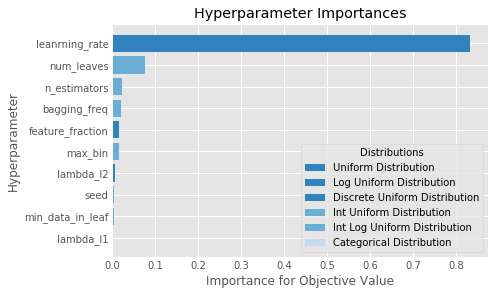

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

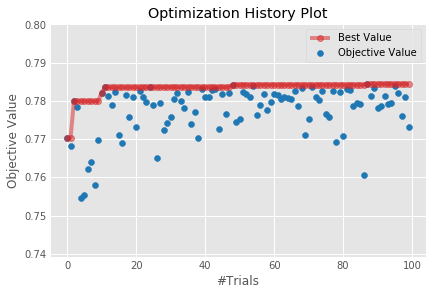

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

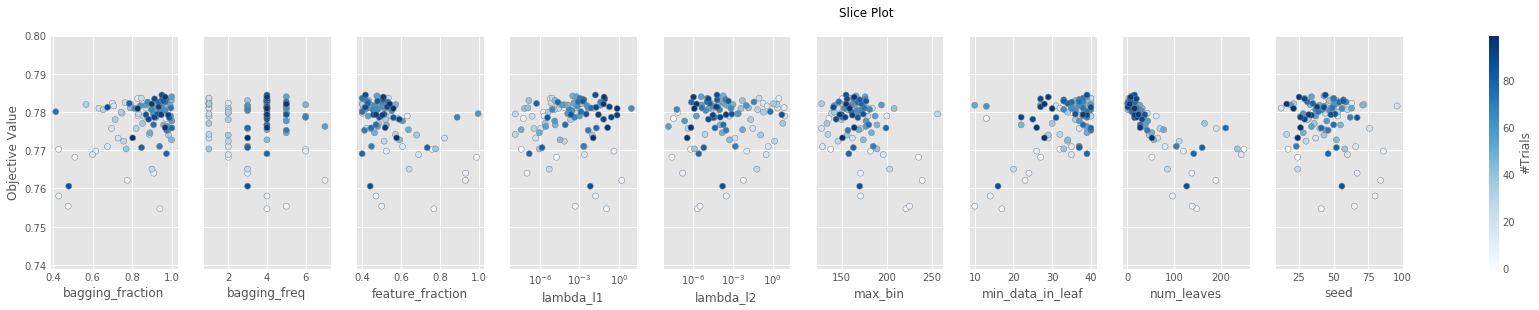

In [ ]:
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

[W 2021-04-19 20:30:41,168] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


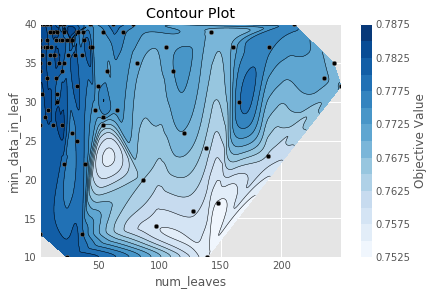

In [ ]:
optuna.visualization.matplotlib.plot_contour(study, params=['num_leaves','min_data_in_leaf'])
plt.show()

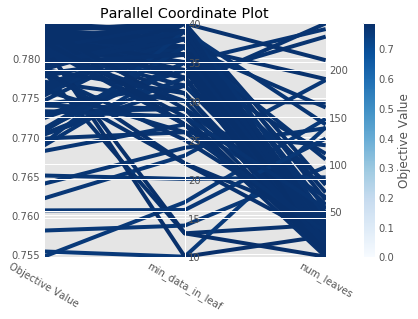

In [ ]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['num_leaves','min_data_in_leaf'])
plt.show()

## xgboost prediction

In [ ]:
y_oof, test_preds2, fi = make_xgb_oof_prediction(normal_train_trend, y, normal_test_trend, total_features, model_params=model_params_xgb)

fold: 1, x_tr.shape: (5149, 409), x_val.shape: (573, 409)
[0]	train-auc:0.80028	eval-auc:0.76714
[200]	train-auc:0.86352	eval-auc:0.79806
[279]	train-auc:0.87729	eval-auc:0.79704
Fold 1 | AUC: 0.7970976937030319
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 409), x_val.shape: (573, 409)
[0]	train-auc:0.80455	eval-auc:0.79876
[200]	train-auc:0.86306	eval-auc:0.82703
[400]	train-auc:0.89657	eval-auc:0.83247
[462]	train-auc:0.90513	eval-auc:0.83214
Fold 2 | AUC: 0.8321363787805871
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 409), x_val.shape: (572, 409)
[0]	train-auc:0.80490	eval-auc:0.77125
[200]	train-auc:0.86572	eval-auc:0.80794
[400]	train-auc:0.89767	eval-auc:0.80943
[508]	train-auc:0.91264	eval-auc:0.80947
Fold 3 | AUC: 0.8094900321063241
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 409), x_val

## xgb optuna hyperparameter tuning prediction

In [ ]:
def objective(trial, label=label_2011_11):
    model_params_xgb = {
        'objective': 'binary:logistic', # 이진 분류
        'eta': trial.suggest_uniform('eta',0.01,0.3),
        'gamma':trial.suggest_loguniform('gamma', 1e-8, 10.0),
        'lambda':trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha':trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'max_depth':trial.suggest_int('max_depth',3,9),
        'eval_metric': 'auc', # 평가 지표 설정
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_uniform('subsample',0.4,1.0), # 데이터 샘플링 비율
        'seed': trial.suggest_int('seed',1,120),
        'n_jobs': -1,
    }
        
    
    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds, fi = make_xgb_oof_prediction(train_country, y, test_country, total_features, model_params=model_params_xgb)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(label, y_oof)
    
    return val_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) # 100회 동안 하이퍼 파라미터 탐색

[I 2021-04-22 05:12:01,074] A new study created in memory with name: no-name-d667a32f-639f-42a6-b2f5-a7b4acd0f986


fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.88121	eval-auc:0.71963
[137]	train-auc:1.00000	eval-auc:0.78995
Fold 1 | AUC: 0.7899529855995262
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.88087	eval-auc:0.73383
[200]	train-auc:1.00000	eval-auc:0.82520
[332]	train-auc:1.00000	eval-auc:0.82644
Fold 2 | AUC: 0.8266020064413431
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.89942	eval-auc:0.71836
[107]	train-auc:1.00000	eval-auc:0.79829
Fold 3 | AUC: 0.7981781527663705
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.89365	eval-auc:0.74623
[129]	train-auc:1.00000	eval-auc:0.83030
Fold 4 | AUC: 0.8294258194579258
--------------------------------

[I 2021-04-22 05:12:46,538] Trial 0 finished with value: 0.810711511527568 and parameters: {'eta': 0.10560869831147067, 'gamma': 1.3454148765904723e-05, 'lambda': 2.137902804637415e-06, 'alpha': 0.202516556834886, 'max_depth': 8, 'colsample_bytree': 0.9893534966646561, 'subsample': 0.8521977975468278, 'seed': 24}. Best is trial 0 with value: 0.810711511527568.



Mean AUC = 0.8121688784140135
OOF AUC = 0.810711511527568
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80230	eval-auc:0.74851
[105]	train-auc:0.99550	eval-auc:0.76334
Fold 1 | AUC: 0.7633361714729944
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80926	eval-auc:0.78244
[173]	train-auc:0.99999	eval-auc:0.80371
Fold 2 | AUC: 0.8037056232184504
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80755	eval-auc:0.78434
[112]	train-auc:0.99608	eval-auc:0.77494
Fold 3 | AUC: 0.7749384006570597
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80239	eval-auc:0.79945
[106]	train-auc:0.99616	eval-auc:0.78500
Fold 4 | AUC: 0.7831703128499963
--------------

[I 2021-04-22 05:13:08,489] Trial 1 finished with value: 0.7840645463605322 and parameters: {'eta': 0.2814252800456212, 'gamma': 1.9762482439626024e-05, 'lambda': 0.001122066665566296, 'alpha': 5.465656354803785e-06, 'max_depth': 4, 'colsample_bytree': 0.8450506655120466, 'subsample': 0.5024954126731181, 'seed': 35}. Best is trial 0 with value: 0.810711511527568.



Mean AUC = 0.7851865035068851
OOF AUC = 0.7840645463605322
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80118	eval-auc:0.75180
[121]	train-auc:0.99951	eval-auc:0.79451
Fold 1 | AUC: 0.7945063487950245
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79902	eval-auc:0.76360
[123]	train-auc:0.99972	eval-auc:0.80959
Fold 2 | AUC: 0.8095916780809239
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.77125	eval-auc:0.75541
[112]	train-auc:0.99951	eval-auc:0.76398
Fold 3 | AUC: 0.7639811842007018
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79393	eval-auc:0.81226
[129]	train-auc:0.99977	eval-auc:0.80981
Fold 4 | AUC: 0.8099566937952662
-------------

[I 2021-04-22 05:13:42,402] Trial 2 finished with value: 0.7962565665477002 and parameters: {'eta': 0.21080847023439803, 'gamma': 1.3836389555936282, 'lambda': 9.446457316978135, 'alpha': 0.04627735279906964, 'max_depth': 9, 'colsample_bytree': 0.9929588555204035, 'subsample': 0.5026134189830384, 'seed': 48}. Best is trial 0 with value: 0.810711511527568.



Mean AUC = 0.7961088198637105
OOF AUC = 0.7962565665477002
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81693	eval-auc:0.73774
[125]	train-auc:0.99987	eval-auc:0.77561
Fold 1 | AUC: 0.7756080405730575
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81650	eval-auc:0.77329
[114]	train-auc:0.99952	eval-auc:0.82051
Fold 2 | AUC: 0.8209565764631843
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.82303	eval-auc:0.74133
[138]	train-auc:0.99994	eval-auc:0.76865
Fold 3 | AUC: 0.7680131411931606
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80666	eval-auc:0.79759
[113]	train-auc:0.99952	eval-auc:0.80131
Fold 4 | AUC: 0.8017807810050026
-------------

[I 2021-04-22 05:14:06,509] Trial 3 finished with value: 0.7944858079397118 and parameters: {'eta': 0.1630642612024329, 'gamma': 1.1307483866424774e-08, 'lambda': 0.00028783067557704227, 'alpha': 0.01634226993517848, 'max_depth': 5, 'colsample_bytree': 0.9741428283366421, 'subsample': 0.5291195605049774, 'seed': 12}. Best is trial 0 with value: 0.810711511527568.



Mean AUC = 0.7942046297781533
OOF AUC = 0.7944858079397118
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.83779	eval-auc:0.74608
[127]	train-auc:0.97421	eval-auc:0.80239
Fold 1 | AUC: 0.8023914411579609
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.84149	eval-auc:0.76550
[200]	train-auc:0.99119	eval-auc:0.83369
[400]	train-auc:0.99999	eval-auc:0.84078
[512]	train-auc:1.00000	eval-auc:0.84000
Fold 2 | AUC: 0.8399104135046089
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.82877	eval-auc:0.70775
[200]	train-auc:0.99336	eval-auc:0.80947
[240]	train-auc:0.99726	eval-auc:0.80802
Fold 3 | AUC: 0.8077353841559023
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]

[I 2021-04-22 05:14:55,950] Trial 4 finished with value: 0.8204868862125148 and parameters: {'eta': 0.030759461637751832, 'gamma': 0.0014030943541800175, 'lambda': 1.3758755232931368e-05, 'alpha': 6.0797318182818425e-05, 'max_depth': 6, 'colsample_bytree': 0.667015210855437, 'subsample': 0.6743308211685226, 'seed': 103}. Best is trial 4 with value: 0.8204868862125148.



Mean AUC = 0.8237581247646539
OOF AUC = 0.8204868862125148
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.87707	eval-auc:0.68959
[123]	train-auc:1.00000	eval-auc:0.78531
Fold 1 | AUC: 0.7851589975197127
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.87595	eval-auc:0.73624
[153]	train-auc:1.00000	eval-auc:0.82218
Fold 2 | AUC: 0.822178210491245
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.88704	eval-auc:0.73851
[143]	train-auc:1.00000	eval-auc:0.79641
Fold 3 | AUC: 0.7967035018293138
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.88121	eval-auc:0.73228
[128]	train-auc:1.00000	eval-auc:0.82058
Fold 4 | AUC: 0.8205779138355858
--------------

[I 2021-04-22 05:15:38,288] Trial 5 finished with value: 0.8056448546633813 and parameters: {'eta': 0.12729127393945278, 'gamma': 1.756307540529502e-05, 'lambda': 0.4647125768778717, 'alpha': 0.04827354331068851, 'max_depth': 8, 'colsample_bytree': 0.9463218552964974, 'subsample': 0.869117055388016, 'seed': 71}. Best is trial 4 with value: 0.8204868862125148.



Mean AUC = 0.8066772703850974
OOF AUC = 0.8056448546633813
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80334	eval-auc:0.74430
[200]	train-auc:0.99990	eval-auc:0.79973
[237]	train-auc:0.99994	eval-auc:0.80134
Fold 1 | AUC: 0.8013363935882722
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80867	eval-auc:0.75742
[200]	train-auc:0.99996	eval-auc:0.82086
[288]	train-auc:0.99998	eval-auc:0.81885
Fold 2 | AUC: 0.8195313367637804
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80152	eval-auc:0.75078
[145]	train-auc:0.99968	eval-auc:0.78866
Fold 3 | AUC: 0.788079593817666
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80844	eval-auc:0.80312
[121]	

[I 2021-04-22 05:16:10,116] Trial 6 finished with value: 0.8073749552576195 and parameters: {'eta': 0.11850435120397759, 'gamma': 0.9888234382813464, 'lambda': 2.0980726505781177e-08, 'alpha': 2.585643671398006, 'max_depth': 8, 'colsample_bytree': 0.460953869149136, 'subsample': 0.5578349771851896, 'seed': 5}. Best is trial 4 with value: 0.8204868862125148.



Mean AUC = 0.8077504812549627
OOF AUC = 0.8073749552576195
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80195	eval-auc:0.78315
[200]	train-auc:0.85580	eval-auc:0.79651
[311]	train-auc:0.86924	eval-auc:0.79604
Fold 1 | AUC: 0.7960426461333433
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80167	eval-auc:0.79426
[200]	train-auc:0.85430	eval-auc:0.82722
[400]	train-auc:0.87912	eval-auc:0.83121
[600]	train-auc:0.89914	eval-auc:0.83138
[601]	train-auc:0.89925	eval-auc:0.83143
Fold 2 | AUC: 0.8314515233406139
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80311	eval-auc:0.77689
[200]	train-auc:0.85731	eval-auc:0.80549
[358]	train-auc:0.87760	eval-auc:0.80746
Fold 3 | AUC: 0.8073620548047487
------------------------------------------------------------

[I 2021-04-22 05:17:09,589] Trial 7 finished with value: 0.8170063560171632 and parameters: {'eta': 0.016321128939914192, 'gamma': 0.09929227838661499, 'lambda': 4.346381153020287, 'alpha': 0.0015676582097684094, 'max_depth': 3, 'colsample_bytree': 0.8999443621949439, 'subsample': 0.9999334471053696, 'seed': 34}. Best is trial 4 with value: 0.8204868862125148.



Mean AUC = 0.8201096187138659
OOF AUC = 0.8170063560171632
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81778	eval-auc:0.72575
[117]	train-auc:1.00000	eval-auc:0.78029
Fold 1 | AUC: 0.7791433754118388
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81803	eval-auc:0.71662
[143]	train-auc:1.00000	eval-auc:0.82322
Fold 2 | AUC: 0.8242883056306224
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79576	eval-auc:0.62253
[118]	train-auc:1.00000	eval-auc:0.78616
Fold 3 | AUC: 0.7867916075561862
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.83091	eval-auc:0.74090
[200]	train-auc:1.00000	eval-auc:0.81468
[221]	train-auc:1.00000	eval-auc:0.81669
Fold 

[I 2021-04-22 05:17:44,666] Trial 8 finished with value: 0.7952679641585686 and parameters: {'eta': 0.1783116620532732, 'gamma': 1.989707411577186e-06, 'lambda': 1.7254120303434018e-05, 'alpha': 0.0008887047651117754, 'max_depth': 9, 'colsample_bytree': 0.8819091780162721, 'subsample': 0.5067643082150075, 'seed': 52}. Best is trial 4 with value: 0.8204868862125148.



Mean AUC = 0.7961662859000924
OOF AUC = 0.7952679641585686
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81070	eval-auc:0.71853
[122]	train-auc:1.00000	eval-auc:0.77409
Fold 1 | AUC: 0.7740902528412246
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80789	eval-auc:0.79881
[125]	train-auc:1.00000	eval-auc:0.81054
Fold 2 | AUC: 0.810535668011698
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80424	eval-auc:0.78856
[104]	train-auc:0.99999	eval-auc:0.77393
Fold 3 | AUC: 0.7737437467333682
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80503	eval-auc:0.78570
[110]	train-auc:1.00000	eval-auc:0.81052
Fold 4 | AUC: 0.8105166878219965
--------------

[I 2021-04-22 05:18:05,706] Trial 9 finished with value: 0.7928492764730082 and parameters: {'eta': 0.255531000115222, 'gamma': 0.38266028393292917, 'lambda': 6.252364437788414e-05, 'alpha': 3.124288344473321e-05, 'max_depth': 5, 'colsample_bytree': 0.4786546684396934, 'subsample': 0.7177576016527453, 'seed': 21}. Best is trial 4 with value: 0.8204868862125148.



Mean AUC = 0.7941587488841794
OOF AUC = 0.7928492764730082
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82805	eval-auc:0.71180
[120]	train-auc:0.93035	eval-auc:0.79900
Fold 1 | AUC: 0.7989671639580942
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.83391	eval-auc:0.74233
[200]	train-auc:0.95020	eval-auc:0.83003
[400]	train-auc:0.97866	eval-auc:0.83413
[557]	train-auc:0.99114	eval-auc:0.83506
Fold 2 | AUC: 0.8350608966053381
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.82666	eval-auc:0.73978
[126]	train-auc:0.93502	eval-auc:0.80367
Fold 3 | AUC: 0.8034047636825208
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.83525	eval-auc:0.77442
[149]

[I 2021-04-22 05:19:11,847] Trial 10 finished with value: 0.8025453773137937 and parameters: {'eta': 0.010682738978923995, 'gamma': 0.0070418566419294115, 'lambda': 2.1340786575377084e-08, 'alpha': 1.5195063376241158e-08, 'max_depth': 6, 'colsample_bytree': 0.6308772144810235, 'subsample': 0.6869163401085553, 'seed': 115}. Best is trial 4 with value: 0.8204868862125148.



Mean AUC = 0.8202627812925716
OOF AUC = 0.8025453773137937
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.84405	eval-auc:0.76207
[200]	train-auc:0.97199	eval-auc:0.80363
[263]	train-auc:0.98325	eval-auc:0.80141
Fold 1 | AUC: 0.8014844704401585
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.84502	eval-auc:0.78689
[200]	train-auc:0.97435	eval-auc:0.82921
[255]	train-auc:0.98459	eval-auc:0.83012
Fold 2 | AUC: 0.8301188316736386
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.84832	eval-auc:0.76348
[104]	train-auc:0.95254	eval-auc:0.80023
Fold 3 | AUC: 0.8002314641977153
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.84270	eval-auc:0.82147
[121]

[I 2021-04-22 05:20:01,042] Trial 11 finished with value: 0.8147891946965612 and parameters: {'eta': 0.020580126919686526, 'gamma': 0.008800741409901289, 'lambda': 1.0385453247057381, 'alpha': 1.0139043696228164e-06, 'max_depth': 6, 'colsample_bytree': 0.6785474315953465, 'subsample': 0.967541642034602, 'seed': 85}. Best is trial 4 with value: 0.8204868862125148.



Mean AUC = 0.8197284357478303
OOF AUC = 0.8147891946965612
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79561	eval-auc:0.72536
[200]	train-auc:0.91518	eval-auc:0.80535
[283]	train-auc:0.93778	eval-auc:0.80387
Fold 1 | AUC: 0.8038722096768223
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79041	eval-auc:0.76984
[200]	train-auc:0.91485	eval-auc:0.83262
[400]	train-auc:0.96219	eval-auc:0.83454
[480]	train-auc:0.97415	eval-auc:0.83412
Fold 2 | AUC: 0.8343945507718504
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79438	eval-auc:0.76084
[200]	train-auc:0.91791	eval-auc:0.80589
[283]	train-auc:0.93971	eval-auc:0.80604
Fold 3 | AUC: 0.8060367356081535
--------------------------------------------------------------------------------
fold: 4, x_tr.shape:

[I 2021-04-22 05:20:38,700] Trial 12 finished with value: 0.8226088075283046 and parameters: {'eta': 0.04924762957976982, 'gamma': 0.013349250885232727, 'lambda': 7.924188912888022e-07, 'alpha': 0.0004142989572382898, 'max_depth': 3, 'colsample_bytree': 0.7553392874002288, 'subsample': 0.6685166577423911, 'seed': 97}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8234071492243171
OOF AUC = 0.8226088075283046
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80134	eval-auc:0.76097
[173]	train-auc:0.92649	eval-auc:0.79902
Fold 1 | AUC: 0.7990226927775517
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78669	eval-auc:0.77158
[198]	train-auc:0.93437	eval-auc:0.83188
Fold 2 | AUC: 0.8318772442897864
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79661	eval-auc:0.79281
[153]	train-auc:0.91886	eval-auc:0.80189
Fold 3 | AUC: 0.8024714403046368
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79512	eval-auc:0.80717
[179]	train-auc:0.92705	eval-auc:0.83189
Fold 4 | AUC: 0.8318897931755396
-------------

[I 2021-04-22 05:21:09,971] Trial 13 finished with value: 0.8199961124255346 and parameters: {'eta': 0.06783033646652864, 'gamma': 0.0007782363109059034, 'lambda': 6.472356440763188e-07, 'alpha': 1.3358770818024974e-07, 'max_depth': 3, 'colsample_bytree': 0.768842878295037, 'subsample': 0.653801608650062, 'seed': 107}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8196939802265102
OOF AUC = 0.8199961124255346
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.84988	eval-auc:0.71482
[130]	train-auc:0.99989	eval-auc:0.80271
Fold 1 | AUC: 0.802706104468219
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.86332	eval-auc:0.73901
[200]	train-auc:1.00000	eval-auc:0.83106
[333]	train-auc:1.00000	eval-auc:0.83264
Fold 2 | AUC: 0.8330433494983897
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.85680	eval-auc:0.74868
[125]	train-auc:0.99997	eval-auc:0.79891
Fold 3 | AUC: 0.7989994773389085
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.85987	eval-auc:0.74931
[110]	train-auc:0.99961	eval-auc:0.83760
Fold 4

[I 2021-04-22 05:21:48,260] Trial 14 finished with value: 0.8128090194698047 and parameters: {'eta': 0.06261550242283113, 'gamma': 0.0013219757518882222, 'lambda': 0.010678083874828262, 'alpha': 7.294976337771368e-05, 'max_depth': 7, 'colsample_bytree': 0.5785719165735325, 'subsample': 0.7696443057499095, 'seed': 95}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8156276334350966
OOF AUC = 0.8128090194698047
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81202	eval-auc:0.75185
[177]	train-auc:0.94477	eval-auc:0.79386
Fold 1 | AUC: 0.7938585125680228
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81588	eval-auc:0.79283
[172]	train-auc:0.94323	eval-auc:0.82697
Fold 2 | AUC: 0.8268056121126865
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80519	eval-auc:0.77614
[129]	train-auc:0.93484	eval-auc:0.80227
Fold 3 | AUC: 0.8011461211080414
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80180	eval-auc:0.81063
[123]	train-auc:0.93027	eval-auc:0.82881
Fold 4 | AUC: 0.8288098260285224
-------------

[I 2021-04-22 05:22:22,971] Trial 15 finished with value: 0.8170948196863503 and parameters: {'eta': 0.05827037200720605, 'gamma': 8.970791246636212, 'lambda': 3.8145725253845356e-07, 'alpha': 0.0004450570485019468, 'max_depth': 5, 'colsample_bytree': 0.7809046881560876, 'subsample': 0.6147832949997017, 'seed': 119}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8169480331152795
OOF AUC = 0.8170948196863503
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81449	eval-auc:0.74165
[170]	train-auc:0.94229	eval-auc:0.80098
Fold 1 | AUC: 0.8009847110650427
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80999	eval-auc:0.79475
[200]	train-auc:0.95346	eval-auc:0.83693
[352]	train-auc:0.98675	eval-auc:0.83427
Fold 2 | AUC: 0.8341354162810499
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80688	eval-auc:0.76378
[200]	train-auc:0.95562	eval-auc:0.80869
[231]	train-auc:0.96470	eval-auc:0.80628
Fold 3 | AUC: 0.8059434032703651
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81245	eval-auc:0.80913
[131]

[I 2021-04-22 05:22:57,883] Trial 16 finished with value: 0.8212553041070906 and parameters: {'eta': 0.044857488768500015, 'gamma': 0.019586261220433734, 'lambda': 6.077845304898219e-06, 'alpha': 1.0772628322343857e-05, 'max_depth': 4, 'colsample_bytree': 0.5673299194950004, 'subsample': 0.7756012089617841, 'seed': 78}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8220501555874153
OOF AUC = 0.8212553041070906
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81792	eval-auc:0.76644
[143]	train-auc:0.97200	eval-auc:0.79225
Fold 1 | AUC: 0.7922481768037611
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81025	eval-auc:0.79420
[200]	train-auc:0.99013	eval-auc:0.83754
[260]	train-auc:0.99677	eval-auc:0.83798
Fold 2 | AUC: 0.8379854144300892
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80819	eval-auc:0.79683
[200]	train-auc:0.98922	eval-auc:0.80921
[208]	train-auc:0.99022	eval-auc:0.80844
Fold 3 | AUC: 0.8084447099230943
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80807	eval-auc:0.81424
[148]

[I 2021-04-22 05:23:24,470] Trial 17 finished with value: 0.8173395103809749 and parameters: {'eta': 0.08552474108547051, 'gamma': 0.03501841147322483, 'lambda': 1.2906257445290075e-07, 'alpha': 2.8949874522727273e-06, 'max_depth': 4, 'colsample_bytree': 0.5232217073982002, 'subsample': 0.7893328706693747, 'seed': 76}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8177370318412227
OOF AUC = 0.8173395103809749
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81817	eval-auc:0.77002
[200]	train-auc:0.93183	eval-auc:0.79852
[271]	train-auc:0.94526	eval-auc:0.79412
Fold 1 | AUC: 0.7941176470588234
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81807	eval-auc:0.79635
[200]	train-auc:0.93498	eval-auc:0.83523
[390]	train-auc:0.95892	eval-auc:0.83528
Fold 2 | AUC: 0.8354125791285676
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80834	eval-auc:0.77798
[200]	train-auc:0.93670	eval-auc:0.80994
[355]	train-auc:0.96044	eval-auc:0.80751
Fold 3 | AUC: 0.8075113865452103
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]

[I 2021-04-22 05:24:12,299] Trial 18 finished with value: 0.8213403331952074 and parameters: {'eta': 0.043876816950503196, 'gamma': 6.563417524475535, 'lambda': 2.953424710423758e-06, 'alpha': 1.292332979370561e-07, 'max_depth': 4, 'colsample_bytree': 0.7659707860082204, 'subsample': 0.9226182025605815, 'seed': 88}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8219495495359308
OOF AUC = 0.8213403331952074
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79163	eval-auc:0.73753
[169]	train-auc:0.90978	eval-auc:0.79416
Fold 1 | AUC: 0.7941546662717951
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.77828	eval-auc:0.77011
[200]	train-auc:0.91907	eval-auc:0.83506
[235]	train-auc:0.92692	eval-auc:0.83280
Fold 2 | AUC: 0.8328027246140746
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.77709	eval-auc:0.73789
[181]	train-auc:0.91033	eval-auc:0.80764
Fold 3 | AUC: 0.8064287314268648
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78688	eval-auc:0.79409
[122]	train-auc:0.89479	eval-auc:0.83534
Fold 

[I 2021-04-22 05:24:35,456] Trial 19 finished with value: 0.815588987953346 and parameters: {'eta': 0.09425356412624314, 'gamma': 9.26015028915578, 'lambda': 5.535077602140789e-08, 'alpha': 1.7718777305591715e-07, 'max_depth': 3, 'colsample_bytree': 0.7572435181454827, 'subsample': 0.43341153193371584, 'seed': 97}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.815377197081183
OOF AUC = 0.815588987953346
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81536	eval-auc:0.75419
[109]	train-auc:0.98011	eval-auc:0.78886
Fold 1 | AUC: 0.7888609188168659
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81601	eval-auc:0.80720
[200]	train-auc:0.99892	eval-auc:0.83464
[233]	train-auc:0.99973	eval-auc:0.83528
Fold 2 | AUC: 0.8352830118831673
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81780	eval-auc:0.75044
[138]	train-auc:0.99310	eval-auc:0.79553
Fold 3 | AUC: 0.79552751437318
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81371	eval-auc:0.83626
[125]	train-auc:0.98728	eval-auc:0.83213
Fold 4 | 

[I 2021-04-22 05:25:02,250] Trial 20 finished with value: 0.8111736019212861 and parameters: {'eta': 0.13821872398460294, 'gamma': 4.2857993295386514e-08, 'lambda': 0.0020905872145555457, 'alpha': 0.002731582381825232, 'max_depth': 4, 'colsample_bytree': 0.8127258727101493, 'subsample': 0.9258898610335266, 'seed': 67}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8114788184414063
OOF AUC = 0.8111736019212861
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81998	eval-auc:0.75726
[200]	train-auc:0.95381	eval-auc:0.79619
[230]	train-auc:0.96332	eval-auc:0.79656
Fold 1 | AUC: 0.7965238959019731
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81164	eval-auc:0.80738
[200]	train-auc:0.95440	eval-auc:0.83180
[241]	train-auc:0.96734	eval-auc:0.83214
Fold 2 | AUC: 0.8321363787805871
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81036	eval-auc:0.77056
[109]	train-auc:0.91765	eval-auc:0.80561
Fold 3 | AUC: 0.8056074068543269
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80959	eval-auc:0.82624
[104]

[I 2021-04-22 05:25:35,855] Trial 21 finished with value: 0.8188791309655888 and parameters: {'eta': 0.044478027123090916, 'gamma': 0.07361240640944619, 'lambda': 3.826907900509733e-06, 'alpha': 3.27669026195221e-08, 'max_depth': 4, 'colsample_bytree': 0.71671976858018, 'subsample': 0.7850672398090766, 'seed': 86}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8197996961053235
OOF AUC = 0.8188791309655888
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79810	eval-auc:0.76510
[200]	train-auc:0.90242	eval-auc:0.79695
[230]	train-auc:0.91019	eval-auc:0.79871
Fold 1 | AUC: 0.7987080294672935
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79902	eval-auc:0.78989
[200]	train-auc:0.90350	eval-auc:0.83408
[331]	train-auc:0.93497	eval-auc:0.83436
Fold 2 | AUC: 0.834357531558879
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80013	eval-auc:0.77048
[184]	train-auc:0.89997	eval-auc:0.80734
Fold 3 | AUC: 0.8073993877398642
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79263	eval-auc:0.81300
[200]	

[I 2021-04-22 05:26:10,185] Trial 22 finished with value: 0.8223142689949042 and parameters: {'eta': 0.04257524436876355, 'gamma': 0.00011785289267997577, 'lambda': 2.1886169949820823e-06, 'alpha': 1.113615836297316e-05, 'max_depth': 3, 'colsample_bytree': 0.5949601089858786, 'subsample': 0.869578417580433, 'seed': 84}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8222839177478934
OOF AUC = 0.8223142689949042
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80264	eval-auc:0.76366
[182]	train-auc:0.93118	eval-auc:0.80126
Fold 1 | AUC: 0.8012623551623292
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80262	eval-auc:0.78435
[200]	train-auc:0.94257	eval-auc:0.83867
[382]	train-auc:0.98233	eval-auc:0.83973
Fold 2 | AUC: 0.839743827046237
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79910	eval-auc:0.77589
[178]	train-auc:0.93572	eval-auc:0.80719
Fold 3 | AUC: 0.8071940565967297
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79337	eval-auc:0.80353
[132]	train-auc:0.91465	eval-auc:0.84104
Fold 4

[I 2021-04-22 05:26:38,148] Trial 23 finished with value: 0.8202512925164005 and parameters: {'eta': 0.07799748702811231, 'gamma': 0.00015836746475114593, 'lambda': 3.9923755436042357e-07, 'alpha': 3.0940162319258e-07, 'max_depth': 3, 'colsample_bytree': 0.631722546896098, 'subsample': 0.9013674016972744, 'seed': 92}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8207821735448821
OOF AUC = 0.8202512925164005
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80463	eval-auc:0.78831
[200]	train-auc:0.89753	eval-auc:0.79830
[239]	train-auc:0.90776	eval-auc:0.79934
Fold 1 | AUC: 0.7993373560878096
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79923	eval-auc:0.80680
[200]	train-auc:0.89607	eval-auc:0.83043
[400]	train-auc:0.94174	eval-auc:0.83632
[404]	train-auc:0.94224	eval-auc:0.83625
Fold 2 | AUC: 0.8362455114204272
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80294	eval-auc:0.78355
[200]	train-auc:0.89961	eval-auc:0.80977
[296]	train-auc:0.92381	eval-auc:0.80975
Fold 3 | AUC: 0.8097513626521318
--------------------------------------------------------------------------------
fold: 4, x_tr.shape:

[I 2021-04-22 05:27:20,066] Trial 24 finished with value: 0.8225845798077822 and parameters: {'eta': 0.03750624889358537, 'gamma': 5.114134950254069e-07, 'lambda': 3.6975392397912446e-05, 'alpha': 0.00016255246908076235, 'max_depth': 3, 'colsample_bytree': 0.7229253356996354, 'subsample': 0.8437585067924521, 'seed': 109}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8229707626918152
OOF AUC = 0.8225845798077822
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79263	eval-auc:0.77205
[200]	train-auc:0.84738	eval-auc:0.79312
[400]	train-auc:0.86731	eval-auc:0.79806
[600]	train-auc:0.88484	eval-auc:0.80030
[747]	train-auc:0.89638	eval-auc:0.80000
Fold 1 | AUC: 0.8000037019212971
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78928	eval-auc:0.78558
[200]	train-auc:0.84601	eval-auc:0.82573
[400]	train-auc:0.86600	eval-auc:0.83125
[600]	train-auc:0.88418	eval-auc:0.83310
[800]	train-auc:0.89932	eval-auc:0.83406
[1000]	train-auc:0.91305	eval-auc:0.83512
[1200]	train-auc:0.92554	eval-auc:0.83571
[1367]	train-auc:0.93445	eval-auc:0.83541
Fold 2 | AUC: 0.8355236367674823
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	tr

[I 2021-04-22 05:28:31,375] Trial 25 finished with value: 0.8105063649285088 and parameters: {'eta': 0.010454581680895345, 'gamma': 6.184419771722391e-07, 'lambda': 7.548178537563607e-05, 'alpha': 0.00017581090210593125, 'max_depth': 3, 'colsample_bytree': 0.4067357093993423, 'subsample': 0.8570886898574157, 'seed': 111}. Best is trial 12 with value: 0.8226088075283046.



Mean AUC = 0.8214022300569469
OOF AUC = 0.8105063649285088
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79358	eval-auc:0.75887
[200]	train-auc:0.88984	eval-auc:0.80156
[280]	train-auc:0.90917	eval-auc:0.80150
Fold 1 | AUC: 0.8017806241439307
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78365	eval-auc:0.78274
[200]	train-auc:0.88847	eval-auc:0.83301
[400]	train-auc:0.93283	eval-auc:0.83725
[551]	train-auc:0.95525	eval-auc:0.83671
Fold 2 | AUC: 0.8369303668604006
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79380	eval-auc:0.76622
[200]	train-auc:0.89120	eval-auc:0.81134
[255]	train-auc:0.90516	eval-auc:0.81007
Fold 3 | AUC: 0.8100686926006123
--------------------------------------------------------------------------------
fold: 4, x_tr.shape:

[I 2021-04-22 05:29:19,294] Trial 26 finished with value: 0.8238156450551687 and parameters: {'eta': 0.03246700316656226, 'gamma': 1.8169129211894983e-07, 'lambda': 5.680313811803861e-05, 'alpha': 0.004947815939094285, 'max_depth': 3, 'colsample_bytree': 0.7002359299530986, 'subsample': 0.6094713674720244, 'seed': 120}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8238321352464721
OOF AUC = 0.8238156450551687
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82298	eval-auc:0.71942
[132]	train-auc:0.99740	eval-auc:0.78594
Fold 1 | AUC: 0.7859364009921149
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82386	eval-auc:0.78335
[200]	train-auc:0.99994	eval-auc:0.83234
[227]	train-auc:0.99999	eval-auc:0.83569
Fold 2 | AUC: 0.8356902232258543
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80935	eval-auc:0.74720
[166]	train-auc:0.99966	eval-auc:0.79319
Fold 3 | AUC: 0.79319420592847
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.82020	eval-auc:0.78792
[126]	train-auc:0.99670	eval-auc:0.83452
Fold 4 

[I 2021-04-22 05:29:50,139] Trial 27 finished with value: 0.8104148379843131 and parameters: {'eta': 0.1047267307833201, 'gamma': 1.305446208107887e-07, 'lambda': 0.017272617273567072, 'alpha': 0.007560505457490399, 'max_depth': 5, 'colsample_bytree': 0.7163109232503138, 'subsample': 0.5940990772090909, 'seed': 118}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8109954389634241
OOF AUC = 0.8104148379843131
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79953	eval-auc:0.75485
[200]	train-auc:0.88353	eval-auc:0.79904
[278]	train-auc:0.90295	eval-auc:0.79952
Fold 1 | AUC: 0.7995224521526674
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79473	eval-auc:0.78330
[200]	train-auc:0.88242	eval-auc:0.83358
[400]	train-auc:0.92703	eval-auc:0.84265
[500]	train-auc:0.94279	eval-auc:0.84087
Fold 2 | AUC: 0.8408729130418687
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79574	eval-auc:0.77499
[200]	train-auc:0.88592	eval-auc:0.80772
[282]	train-auc:0.90527	eval-auc:0.80581
Fold 3 | AUC: 0.8059994026730382
--------------------------------------------------------------------------------
fold: 4, x_tr.shape:

[I 2021-04-22 05:30:32,106] Trial 28 finished with value: 0.8228879368601469 and parameters: {'eta': 0.030005888158737597, 'gamma': 4.6832124323555394e-07, 'lambda': 7.57008223473374e-05, 'alpha': 0.6077020329703534, 'max_depth': 3, 'colsample_bytree': 0.7194751491068994, 'subsample': 0.7231167823109996, 'seed': 104}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8233793983538115
OOF AUC = 0.8228879368601469
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81045	eval-auc:0.74248
[156]	train-auc:0.97597	eval-auc:0.79763
Fold 1 | AUC: 0.7976344722911191
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80471	eval-auc:0.80324
[200]	train-auc:0.98882	eval-auc:0.83447
[311]	train-auc:0.99897	eval-auc:0.83103
Fold 2 | AUC: 0.8310258023914411
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80987	eval-auc:0.77229
[171]	train-auc:0.98206	eval-auc:0.79683
Fold 3 | AUC: 0.7968341671022175
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80421	eval-auc:0.80229
[125]	train-auc:0.96302	eval-auc:0.83154
Fold 

[I 2021-04-22 05:31:00,861] Trial 29 finished with value: 0.8149081982893187 and parameters: {'eta': 0.08281789268637994, 'gamma': 1.1966829707226257e-08, 'lambda': 0.0002868763209276986, 'alpha': 1.1913525176599535, 'max_depth': 4, 'colsample_bytree': 0.8172270950108629, 'subsample': 0.7155723729561538, 'seed': 101}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.814993772871686
OOF AUC = 0.8149081982893187
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79424	eval-auc:0.76984
[200]	train-auc:0.84944	eval-auc:0.79338
[400]	train-auc:0.86998	eval-auc:0.79969
[573]	train-auc:0.88667	eval-auc:0.79973
Fold 1 | AUC: 0.7997075482175249
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80204	eval-auc:0.80190
[200]	train-auc:0.84751	eval-auc:0.82677
[400]	train-auc:0.86833	eval-auc:0.83112
[600]	train-auc:0.88841	eval-auc:0.83397
[800]	train-auc:0.90619	eval-auc:0.83663
[910]	train-auc:0.91470	eval-auc:0.83639
Fold 2 | AUC: 0.8364491170917706
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80520	eval-auc:0.77934
[200]	train-auc:0.85008	eval-auc:0.80835
[400]	train-auc:0.87117	eval-auc:0.81048
[539]	train-

[I 2021-04-22 05:32:14,075] Trial 30 finished with value: 0.8140181776595539 and parameters: {'eta': 0.011067151943554548, 'gamma': 2.762874244216673e-06, 'lambda': 0.002570388621001709, 'alpha': 0.5406286782469188, 'max_depth': 3, 'colsample_bytree': 0.6560685328375292, 'subsample': 0.6474349779598166, 'seed': 119}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8232360604376556
OOF AUC = 0.8140181776595539
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.77987	eval-auc:0.77036
[200]	train-auc:0.86248	eval-auc:0.79595
[330]	train-auc:0.88078	eval-auc:0.79686
Fold 1 | AUC: 0.7969866360641172
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78545	eval-auc:0.78297
[200]	train-auc:0.86122	eval-auc:0.83067
[400]	train-auc:0.88962	eval-auc:0.83469
[511]	train-auc:0.90258	eval-auc:0.83567
Fold 2 | AUC: 0.8355236367674823
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78436	eval-auc:0.75882
[200]	train-auc:0.86318	eval-auc:0.80714
[257]	train-auc:0.87226	eval-auc:0.80686
Fold 3 | AUC: 0.8068580601806914
--------------------------------------------------------------------------------
fold: 4, x_tr.shape:

[I 2021-04-22 05:33:13,685] Trial 31 finished with value: 0.8225392804682614 and parameters: {'eta': 0.026300847963504383, 'gamma': 1.855413376914407e-07, 'lambda': 5.545048408521541e-05, 'alpha': 7.476818862951813, 'max_depth': 3, 'colsample_bytree': 0.7184239923321103, 'subsample': 0.815740942917613, 'seed': 108}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8227449628755273
OOF AUC = 0.8225392804682614
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79996	eval-auc:0.76713
[197]	train-auc:0.92512	eval-auc:0.79682
Fold 1 | AUC: 0.7970421648835746
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78968	eval-auc:0.76603
[200]	train-auc:0.92570	eval-auc:0.83315
[214]	train-auc:0.92965	eval-auc:0.83254
Fold 2 | AUC: 0.83269166697516
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78911	eval-auc:0.79944
[187]	train-auc:0.92510	eval-auc:0.80484
Fold 3 | AUC: 0.804842081684462
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79171	eval-auc:0.79386
[161]	train-auc:0.91160	eval-auc:0.84242
Fold 4 |

[I 2021-04-22 05:33:45,391] Trial 32 finished with value: 0.8198886193206881 and parameters: {'eta': 0.06059936683567388, 'gamma': 2.965742911443023e-06, 'lambda': 2.6913445566502186e-05, 'alpha': 0.08964703277083833, 'max_depth': 3, 'colsample_bytree': 0.7457632073058261, 'subsample': 0.743651344852721, 'seed': 112}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8205908206623764
OOF AUC = 0.8198886193206881
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80268	eval-auc:0.73587
[200]	train-auc:0.93013	eval-auc:0.80537
[201]	train-auc:0.93050	eval-auc:0.80515
Fold 1 | AUC: 0.8050383148854255
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81406	eval-auc:0.79684
[200]	train-auc:0.92903	eval-auc:0.83410
[400]	train-auc:0.97693	eval-auc:0.83771
[600]	train-auc:0.99501	eval-auc:0.84143
[711]	train-auc:0.99807	eval-auc:0.84210
Fold 2 | AUC: 0.8417428645466998
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80790	eval-auc:0.78172
[165]	train-auc:0.91873	eval-auc:0.80120
Fold 3 | AUC: 0.8007167923542149
--------------------------------------------------------------------------------
fold: 4, x_tr.shape:

[I 2021-04-22 05:34:27,732] Trial 33 finished with value: 0.821265329370755 and parameters: {'eta': 0.03085382302719538, 'gamma': 5.2583900669740723e-08, 'lambda': 0.0006572793562470401, 'alpha': 0.006558308178208885, 'max_depth': 4, 'colsample_bytree': 0.8103366682682466, 'subsample': 0.6098240726409564, 'seed': 103}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8217491847251399
OOF AUC = 0.821265329370755
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79471	eval-auc:0.77464
[106]	train-auc:0.95725	eval-auc:0.77748
Fold 1 | AUC: 0.7774775108281198
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78414	eval-auc:0.78418
[197]	train-auc:0.99088	eval-auc:0.82751
Fold 2 | AUC: 0.8269166697516012
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79410	eval-auc:0.75425
[118]	train-auc:0.96187	eval-auc:0.78950
Fold 3 | AUC: 0.7894982453520496
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78649	eval-auc:0.81537
[104]	train-auc:0.95395	eval-auc:0.82116
Fold 4 | AUC: 0.8211565743298738
--------------

[I 2021-04-22 05:34:48,414] Trial 34 finished with value: 0.8020565528836371 and parameters: {'eta': 0.20628098068376757, 'gamma': 6.048974857789648e-07, 'lambda': 0.00017220028016461496, 'alpha': 0.0002840394369246574, 'max_depth': 3, 'colsample_bytree': 0.701855015679091, 'subsample': 0.5803648951229319, 'seed': 120}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8037150026102443
OOF AUC = 0.8020565528836371
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79409	eval-auc:0.74279
[131]	train-auc:0.97541	eval-auc:0.79554
Fold 1 | AUC: 0.7955428867582276
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79760	eval-auc:0.78366
[175]	train-auc:0.98874	eval-auc:0.82129
Fold 2 | AUC: 0.8225669122274462
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79758	eval-auc:0.77134
[137]	train-auc:0.97939	eval-auc:0.78687
Fold 3 | AUC: 0.7868662734264168
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79799	eval-auc:0.81983
[122]	train-auc:0.96988	eval-auc:0.82106
Fold 4 | AUC: 0.8208392443813932
-------------

[I 2021-04-22 05:35:12,508] Trial 35 finished with value: 0.8047048933683252 and parameters: {'eta': 0.10205878280537461, 'gamma': 5.6138034022607557e-05, 'lambda': 9.444958898106464e-07, 'alpha': 0.2986584194753435, 'max_depth': 4, 'colsample_bytree': 0.8517770635081745, 'subsample': 0.44743643793228355, 'seed': 99}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8054371904991676
OOF AUC = 0.8047048933683252
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82316	eval-auc:0.75943
[200]	train-auc:0.97071	eval-auc:0.80695
[207]	train-auc:0.97326	eval-auc:0.80652
Fold 1 | AUC: 0.8065190834042869
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82152	eval-auc:0.79724
[200]	train-auc:0.97230	eval-auc:0.83212
[266]	train-auc:0.98600	eval-auc:0.83247
Fold 2 | AUC: 0.8326546477621886
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81163	eval-auc:0.75455
[200]	train-auc:0.97351	eval-auc:0.81518
[267]	train-auc:0.98751	eval-auc:0.81341
Fold 3 | AUC: 0.8134099902934367
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]

[I 2021-04-22 05:35:55,810] Trial 36 finished with value: 0.8212296839888371 and parameters: {'eta': 0.03310957027623376, 'gamma': 1.1095772857828756e-05, 'lambda': 9.513765869994058e-06, 'alpha': 0.010497097297462425, 'max_depth': 5, 'colsample_bytree': 0.681450120799649, 'subsample': 0.6373459297550909, 'seed': 112}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8221868493464201
OOF AUC = 0.8212296839888371
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80819	eval-auc:0.77108
[200]	train-auc:0.92306	eval-auc:0.80139
[265]	train-auc:0.94184	eval-auc:0.80119
Fold 1 | AUC: 0.8011883167363864
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79627	eval-auc:0.78332
[200]	train-auc:0.92393	eval-auc:0.83606
[400]	train-auc:0.96933	eval-auc:0.83527
[416]	train-auc:0.97248	eval-auc:0.83512
Fold 2 | AUC: 0.834931329359938
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80518	eval-auc:0.77581
[116]	train-auc:0.89267	eval-auc:0.80602
Fold 3 | AUC: 0.8059807362054805
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	

[I 2021-04-22 05:36:31,968] Trial 37 finished with value: 0.8221655609172149 and parameters: {'eta': 0.05900673657077758, 'gamma': 1.1145750557288634e-08, 'lambda': 0.009530199984083417, 'alpha': 0.044924408697092154, 'max_depth': 3, 'colsample_bytree': 0.631977691559872, 'subsample': 0.8303047723945989, 'seed': 56}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8226934292694819
OOF AUC = 0.8221655609172149
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78735	eval-auc:0.74951
[200]	train-auc:0.84870	eval-auc:0.79506
[400]	train-auc:0.86936	eval-auc:0.80121
[600]	train-auc:0.88772	eval-auc:0.80297
[713]	train-auc:0.89724	eval-auc:0.80210
Fold 1 | AUC: 0.8023544219449894
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78765	eval-auc:0.78910
[200]	train-auc:0.84749	eval-auc:0.82468
[400]	train-auc:0.86784	eval-auc:0.82945
[600]	train-auc:0.88741	eval-auc:0.83341
[800]	train-auc:0.90482	eval-auc:0.83471
[1000]	train-auc:0.91891	eval-auc:0.83464
[1003]	train-auc:0.91920	eval-auc:0.83462
Fold 2 | AUC: 0.8346166660496798
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79318	eval-auc:0.79436
[200]	tra

[I 2021-04-22 05:37:47,286] Trial 38 finished with value: 0.8129763856770915 and parameters: {'eta': 0.010443574219644671, 'gamma': 6.491366530016738e-07, 'lambda': 0.0001640435846720383, 'alpha': 0.002321726384960342, 'max_depth': 3, 'colsample_bytree': 0.6602984661911511, 'subsample': 0.5597733909989175, 'seed': 105}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8238178650441882
OOF AUC = 0.8129763856770915
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.85398	eval-auc:0.72378
[173]	train-auc:1.00000	eval-auc:0.79867
Fold 1 | AUC: 0.7987080294672936
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.85541	eval-auc:0.71499
[163]	train-auc:1.00000	eval-auc:0.82817
Fold 2 | AUC: 0.8277125828304891
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.86219	eval-auc:0.74433
[154]	train-auc:1.00000	eval-auc:0.79174
Fold 3 | AUC: 0.7917382214589712
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.84545	eval-auc:0.75266
[151]	train-auc:1.00000	eval-auc:0.82730
Fold 4 | AUC: 0.8274658403643694
-------------

[I 2021-04-22 05:38:25,823] Trial 39 finished with value: 0.8111531800878956 and parameters: {'eta': 0.07730160568360285, 'gamma': 3.421001407016143e-08, 'lambda': 0.0011448564923870652, 'alpha': 8.689444972882327e-05, 'max_depth': 7, 'colsample_bytree': 0.7367857191819615, 'subsample': 0.7401337367928491, 'seed': 44}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8131353800208644
OOF AUC = 0.8111531800878956
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81557	eval-auc:0.76949
[103]	train-auc:0.99868	eval-auc:0.78390
Fold 1 | AUC: 0.7830303927738496
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82023	eval-auc:0.79268
[111]	train-auc:0.99969	eval-auc:0.78640
Fold 2 | AUC: 0.786732314071003
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81426	eval-auc:0.74497
[109]	train-auc:0.99859	eval-auc:0.78939
Fold 3 | AUC: 0.7893862465467035
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81804	eval-auc:0.83369
[122]	train-auc:0.99914	eval-auc:0.81046
Fold 4 | AUC: 0.8104606884193235
--------------

[I 2021-04-22 05:38:47,537] Trial 40 finished with value: 0.7959834709393597 and parameters: {'eta': 0.29067025573962885, 'gamma': 1.1419170027992037e-05, 'lambda': 1.5279612915978195e-05, 'alpha': 0.0007040497862120767, 'max_depth': 4, 'colsample_bytree': 0.8470717809062569, 'subsample': 0.6915282599696604, 'seed': 92}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.7965628711690487
OOF AUC = 0.7959834709393597
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.77987	eval-auc:0.77036
[200]	train-auc:0.86173	eval-auc:0.79675
[327]	train-auc:0.87932	eval-auc:0.79697
Fold 1 | AUC: 0.7969681264576314
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78545	eval-auc:0.78297
[200]	train-auc:0.85921	eval-auc:0.82845
[400]	train-auc:0.88750	eval-auc:0.83447
[600]	train-auc:0.90996	eval-auc:0.83545
[615]	train-auc:0.91148	eval-auc:0.83588
Fold 2 | AUC: 0.8358753192907118
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78436	eval-auc:0.75882
[200]	train-auc:0.86232	eval-auc:0.80721
[258]	train-auc:0.87103	eval-auc:0.80645
Fold 3 | AUC: 0.8064473978944224
------------------------------------------------------------

[I 2021-04-22 05:39:44,139] Trial 41 finished with value: 0.8224668757862406 and parameters: {'eta': 0.024465429461863846, 'gamma': 1.8948458300447866e-07, 'lambda': 4.988187894400464e-05, 'alpha': 6.8456875014702225, 'max_depth': 3, 'colsample_bytree': 0.7189013125429587, 'subsample': 0.8167930912934729, 'seed': 108}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8229357619311048
OOF AUC = 0.8224668757862406
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78887	eval-auc:0.73719
[200]	train-auc:0.86899	eval-auc:0.79975
[392]	train-auc:0.89679	eval-auc:0.80024
Fold 1 | AUC: 0.8000037019212971
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78675	eval-auc:0.77033
[200]	train-auc:0.86725	eval-auc:0.83247
[400]	train-auc:0.89687	eval-auc:0.83791
[600]	train-auc:0.91835	eval-auc:0.83941
[783]	train-auc:0.93315	eval-auc:0.83902
Fold 2 | AUC: 0.8390219523932921
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78131	eval-auc:0.78074
[188]	train-auc:0.86785	eval-auc:0.80466
Fold 3 | AUC: 0.8046554170088852
--------------------------------------------------------------------------------
fold: 4, x_tr.shape:

[I 2021-04-22 05:40:47,422] Trial 42 finished with value: 0.8229319366284519 and parameters: {'eta': 0.035220335251796256, 'gamma': 1.9317975078198334e-07, 'lambda': 3.93938204107952e-05, 'alpha': 9.986718121334986, 'max_depth': 3, 'colsample_bytree': 0.7858602057576893, 'subsample': 0.8178815218060076, 'seed': 107}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8233680257183347
OOF AUC = 0.8229319366284519
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79125	eval-auc:0.75367
[200]	train-auc:0.90490	eval-auc:0.79834
[209]	train-auc:0.90732	eval-auc:0.79714
Fold 1 | AUC: 0.7972087513419465
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80389	eval-auc:0.80005
[200]	train-auc:0.90510	eval-auc:0.83438
[274]	train-auc:0.92627	eval-auc:0.83456
Fold 2 | AUC: 0.8341169066745641
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79992	eval-auc:0.78132
[175]	train-auc:0.89989	eval-auc:0.80426
Fold 3 | AUC: 0.8042634211901741
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78498	eval-auc:0.79769
[192]

[I 2021-04-22 05:41:22,575] Trial 43 finished with value: 0.8206225985780464 and parameters: {'eta': 0.05063104017195518, 'gamma': 2.0202518384480516e-06, 'lambda': 0.0005116367861572695, 'alpha': 2.4263634484017262, 'max_depth': 3, 'colsample_bytree': 0.7807617277346462, 'subsample': 0.6687743550007136, 'seed': 115}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8207328100234671
OOF AUC = 0.8206225985780464
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81523	eval-auc:0.78573
[135]	train-auc:0.98826	eval-auc:0.78207
Fold 1 | AUC: 0.7828082774960203
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81731	eval-auc:0.79562
[136]	train-auc:0.98969	eval-auc:0.82129
Fold 2 | AUC: 0.8223262873431312
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81883	eval-auc:0.77170
[137]	train-auc:0.99031	eval-auc:0.78976
Fold 3 | AUC: 0.7897595758978572
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81731	eval-auc:0.84155
[131]	train-auc:0.98850	eval-auc:0.81953
Fold 4 | AUC: 0.8192152617038752
-------------

[I 2021-04-22 05:41:48,294] Trial 44 finished with value: 0.8078505983225878 and parameters: {'eta': 0.1218925257734409, 'gamma': 3.0604350782628855e-07, 'lambda': 0.00012802853450683783, 'alpha': 2.3209632730949087e-05, 'max_depth': 4, 'colsample_bytree': 0.911650776408728, 'subsample': 0.7437644438297463, 'seed': 102}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8082159933911751
OOF AUC = 0.8078505983225878
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80127	eval-auc:0.76479
[200]	train-auc:0.88544	eval-auc:0.80052
[266]	train-auc:0.90129	eval-auc:0.79941
Fold 1 | AUC: 0.7996335097915818
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79868	eval-auc:0.80897
[200]	train-auc:0.88530	eval-auc:0.83425
[368]	train-auc:0.92127	eval-auc:0.83519
Fold 2 | AUC: 0.8353755599155962
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80308	eval-auc:0.77915
[120]	train-auc:0.86537	eval-auc:0.80533
Fold 3 | AUC: 0.8053274098409617
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79591	eval-auc:0.80448
[200]

[I 2021-04-22 05:42:34,157] Trial 45 finished with value: 0.8229681389694623 and parameters: {'eta': 0.029361817398124143, 'gamma': 6.621684656788596e-08, 'lambda': 2.873805093840043e-05, 'alpha': 0.03440448564195265, 'max_depth': 3, 'colsample_bytree': 0.7891646386806781, 'subsample': 0.7046793673461598, 'seed': 95}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8228160031081125
OOF AUC = 0.8229681389694623
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80021	eval-auc:0.75338
[200]	train-auc:0.87352	eval-auc:0.80189
[317]	train-auc:0.89666	eval-auc:0.80023
Fold 1 | AUC: 0.8002258171991263
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80064	eval-auc:0.78939
[200]	train-auc:0.87174	eval-auc:0.83180
[400]	train-auc:0.91045	eval-auc:0.83602
[537]	train-auc:0.93157	eval-auc:0.83588
Fold 2 | AUC: 0.8358753192907117
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78861	eval-auc:0.76070
[148]	train-auc:0.86308	eval-auc:0.80649
Fold 3 | AUC: 0.8064847308295379
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]

[I 2021-04-22 05:43:24,129] Trial 46 finished with value: 0.822341745643466 and parameters: {'eta': 0.022681395191843246, 'gamma': 2.5734602720668887e-08, 'lambda': 1.4265152869245773e-06, 'alpha': 0.028508006573009906, 'max_depth': 3, 'colsample_bytree': 0.8739459818692563, 'subsample': 0.7073206569644956, 'seed': 78}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.822778708470645
OOF AUC = 0.822341745643466
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82436	eval-auc:0.74784
[127]	train-auc:0.98628	eval-auc:0.78444
Fold 1 | AUC: 0.7844371228667678
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82046	eval-auc:0.74778
[200]	train-auc:0.99871	eval-auc:0.83365
[351]	train-auc:1.00000	eval-auc:0.83373
Fold 2 | AUC: 0.8337282049383632
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.82548	eval-auc:0.76592
[143]	train-auc:0.99242	eval-auc:0.80764
Fold 3 | AUC: 0.8068020607780184
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81684	eval-auc:0.80507
[116]	train-auc:0.98272	eval-auc:0.83601
Fold 4 

[I 2021-04-22 05:43:56,217] Trial 47 finished with value: 0.8136881793972663 and parameters: {'eta': 0.06984385274417293, 'gamma': 6.663168291604346e-08, 'lambda': 9.916579190629801e-06, 'alpha': 0.09356059353087408, 'max_depth': 5, 'colsample_bytree': 0.8155258645845589, 'subsample': 0.6319658916696254, 'seed': 65}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8145561468250715
OOF AUC = 0.8136881793972663
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.84454	eval-auc:0.74750
[134]	train-auc:0.99999	eval-auc:0.79960
Fold 1 | AUC: 0.7997075482175249
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.84954	eval-auc:0.73236
[200]	train-auc:1.00000	eval-auc:0.83308
[242]	train-auc:1.00000	eval-auc:0.83097
Fold 2 | AUC: 0.8312664272757561
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.82721	eval-auc:0.68063
[200]	train-auc:1.00000	eval-auc:0.79556
[224]	train-auc:1.00000	eval-auc:0.79351
Fold 3 | AUC: 0.7939035316956619
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80531	eval-auc:0.65189
[198]

[I 2021-04-22 05:44:46,329] Trial 48 finished with value: 0.8083364523042512 and parameters: {'eta': 0.05186750913113384, 'gamma': 1.1281284540082539e-08, 'lambda': 1.610205019143332e-07, 'alpha': 0.15910842752252138, 'max_depth': 9, 'colsample_bytree': 0.7919539825490881, 'subsample': 0.5394235481683846, 'seed': 92}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8112230069121743
OOF AUC = 0.8083364523042512
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80692	eval-auc:0.71575
[137]	train-auc:0.99955	eval-auc:0.78540
Fold 1 | AUC: 0.7859734202050864
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80512	eval-auc:0.79471
[117]	train-auc:0.99864	eval-auc:0.81703
Fold 2 | AUC: 0.8170325398882019
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81193	eval-auc:0.76766
[104]	train-auc:0.99748	eval-auc:0.77072
Fold 3 | AUC: 0.7732957515119839
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80407	eval-auc:0.78729
[112]	train-auc:0.99840	eval-auc:0.80443
Fold 4 | AUC: 0.8044314193981931
-------------

[I 2021-04-22 05:45:08,741] Trial 49 finished with value: 0.7998901676669653 and parameters: {'eta': 0.2432175116557246, 'gamma': 0.3179451458973853, 'lambda': 2.1705420502600425e-05, 'alpha': 0.7067654119452053, 'max_depth': 4, 'colsample_bytree': 0.6874268039994218, 'subsample': 0.6793746207911526, 'seed': 97}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8000737954124766
OOF AUC = 0.7998901676669653
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.84932	eval-auc:0.74308
[158]	train-auc:1.00000	eval-auc:0.79343
Fold 1 | AUC: 0.7934327916188503
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.85211	eval-auc:0.76139
[128]	train-auc:1.00000	eval-auc:0.81764
Fold 2 | AUC: 0.8166623477584867
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.86339	eval-auc:0.73455
[142]	train-auc:1.00000	eval-auc:0.78681
Fold 3 | AUC: 0.7868102740237437
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.84890	eval-auc:0.75272
[134]	train-auc:1.00000	eval-auc:0.81431
Fold 4 | AUC: 0.8143059807362055
-------------

[I 2021-04-22 05:45:42,766] Trial 50 finished with value: 0.7988724177519944 and parameters: {'eta': 0.1722050689578944, 'gamma': 0.007137694671690173, 'lambda': 4.091219385571594e-06, 'alpha': 0.017470710562007188, 'max_depth': 7, 'colsample_bytree': 0.7938878285367841, 'subsample': 0.7312928362323377, 'seed': 81}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8000403892328616
OOF AUC = 0.7988724177519944
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80591	eval-auc:0.76421
[200]	train-auc:0.88855	eval-auc:0.80526
[387]	train-auc:0.92785	eval-auc:0.80348
Fold 1 | AUC: 0.8034835079406211
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80570	eval-auc:0.79483
[200]	train-auc:0.88629	eval-auc:0.83512
[388]	train-auc:0.92751	eval-auc:0.83660
Fold 2 | AUC: 0.8361899826009699
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80640	eval-auc:0.77304
[200]	train-auc:0.89068	eval-auc:0.80848
[258]	train-auc:0.90446	eval-auc:0.80835
Fold 3 | AUC: 0.8085007093257672
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]

[I 2021-04-22 05:46:29,904] Trial 51 finished with value: 0.8234790561102868 and parameters: {'eta': 0.03131281216288179, 'gamma': 1.1064545228615038e-06, 'lambda': 3.3973910511041226e-05, 'alpha': 0.0012468544419725806, 'max_depth': 3, 'colsample_bytree': 0.7447806206357035, 'subsample': 0.766089700553667, 'seed': 115}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8235289469642273
OOF AUC = 0.8234790561102868
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80591	eval-auc:0.76421
[200]	train-auc:0.86114	eval-auc:0.79969
[397]	train-auc:0.89011	eval-auc:0.79965
Fold 1 | AUC: 0.7996520193980676
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80570	eval-auc:0.79483
[200]	train-auc:0.85882	eval-auc:0.82838
[400]	train-auc:0.88936	eval-auc:0.83434
[600]	train-auc:0.91491	eval-auc:0.83486
[800]	train-auc:0.93582	eval-auc:0.83602
[803]	train-auc:0.93600	eval-auc:0.83604
Fold 2 | AUC: 0.8360419057490838
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80640	eval-auc:0.77304
[200]	train-auc:0.86204	eval-auc:0.80732
[369]	train-auc:0.88854	eval-auc:0.80811
Fold 3 | AUC: 0.808108713507056
--------------------

[I 2021-04-22 05:47:24,092] Trial 52 finished with value: 0.8179875322850622 and parameters: {'eta': 0.016304646713537034, 'gamma': 9.351840683972718e-08, 'lambda': 0.00010133110631269297, 'alpha': 0.0012208608519337536, 'max_depth': 3, 'colsample_bytree': 0.7482862467420024, 'subsample': 0.7650048626557144, 'seed': 115}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.82166974775054
OOF AUC = 0.8179875322850622
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80113	eval-auc:0.75605
[200]	train-auc:0.89148	eval-auc:0.79504
[201]	train-auc:0.89187	eval-auc:0.79495
Fold 1 | AUC: 0.7949505793506833
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79902	eval-auc:0.78800
[200]	train-auc:0.89102	eval-auc:0.83241
[298]	train-auc:0.91472	eval-auc:0.83180
Fold 2 | AUC: 0.8319883019287009
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79495	eval-auc:0.77768
[134]	train-auc:0.87264	eval-auc:0.80549
Fold 3 | AUC: 0.8055700739192115
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79408	eval-auc:0.79888
[200]	t

[I 2021-04-22 05:48:03,903] Trial 53 finished with value: 0.8209840650290585 and parameters: {'eta': 0.033208638625105376, 'gamma': 1.3991750960993446e-06, 'lambda': 0.0003668893691594297, 'alpha': 0.0037721060895223296, 'max_depth': 3, 'colsample_bytree': 0.8359420836340111, 'subsample': 0.7988302832721104, 'seed': 106}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8211839399385062
OOF AUC = 0.8209840650290585
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80376	eval-auc:0.73959
[178]	train-auc:0.96428	eval-auc:0.80021
Fold 1 | AUC: 0.8002073075926406
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80916	eval-auc:0.78523
[200]	train-auc:0.97496	eval-auc:0.83651
[235]	train-auc:0.98360	eval-auc:0.83730
Fold 2 | AUC: 0.8368563284344575
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81174	eval-auc:0.76545
[140]	train-auc:0.94970	eval-auc:0.79961
Fold 3 | AUC: 0.7996154707683117
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80257	eval-auc:0.83335
[128]	train-auc:0.94029	eval-auc:0.83609
Fold 

[I 2021-04-22 05:48:35,213] Trial 54 finished with value: 0.8189127341641679 and parameters: {'eta': 0.06951753306675747, 'gamma': 4.617872339417541e-06, 'lambda': 7.761528486296572e-06, 'alpha': 2.7568450294520823, 'max_depth': 4, 'colsample_bytree': 0.7572714455348671, 'subsample': 0.7603893048119423, 'seed': 120}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8190901702277267
OOF AUC = 0.8189127341641679
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79822	eval-auc:0.75131
[189]	train-auc:0.91347	eval-auc:0.79875
Fold 1 | AUC: 0.798745048680265
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79827	eval-auc:0.79345
[200]	train-auc:0.91800	eval-auc:0.83086
[400]	train-auc:0.96648	eval-auc:0.83754
[449]	train-auc:0.97294	eval-auc:0.83543
Fold 2 | AUC: 0.8354310887350535
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80428	eval-auc:0.77562
[141]	train-auc:0.89894	eval-auc:0.80927
Fold 3 | AUC: 0.8092660344956321
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79415	eval-auc:0.80661
[176]	

[I 2021-04-22 05:49:12,892] Trial 55 finished with value: 0.8222789020925324 and parameters: {'eta': 0.052752501743404276, 'gamma': 0.0028279425755256635, 'lambda': 2.75001508028831e-05, 'alpha': 0.018991083786189494, 'max_depth': 3, 'colsample_bytree': 0.7743131108227918, 'subsample': 0.6573122449415307, 'seed': 89}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8228453824597113
OOF AUC = 0.8222789020925324
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81543	eval-auc:0.75222
[200]	train-auc:0.94321	eval-auc:0.80160
[282]	train-auc:0.96709	eval-auc:0.80089
Fold 1 | AUC: 0.800892163032614
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80813	eval-auc:0.79092
[200]	train-auc:0.94467	eval-auc:0.83602
[400]	train-auc:0.98766	eval-auc:0.83860
[566]	train-auc:0.99769	eval-auc:0.83993
Fold 2 | AUC: 0.8399289231110947
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81106	eval-auc:0.80035
[175]	train-auc:0.93724	eval-auc:0.81102
Fold 3 | AUC: 0.811020682446054
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	t

[I 2021-04-22 05:49:54,729] Trial 56 finished with value: 0.8224048676739458 and parameters: {'eta': 0.03877979686353375, 'gamma': 2.1608959735081094e-08, 'lambda': 0.0037643960236581416, 'alpha': 0.0007219716964553593, 'max_depth': 4, 'colsample_bytree': 0.6963063165032072, 'subsample': 0.7014209155890183, 'seed': 95}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8227965746697189
OOF AUC = 0.8224048676739458
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79670	eval-auc:0.75583
[200]	train-auc:0.86710	eval-auc:0.80024
[314]	train-auc:0.88738	eval-auc:0.79897
Fold 1 | AUC: 0.7989671639580943
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79113	eval-auc:0.78707
[200]	train-auc:0.86504	eval-auc:0.83062
[400]	train-auc:0.90049	eval-auc:0.83488
[600]	train-auc:0.92790	eval-auc:0.83700
[711]	train-auc:0.93906	eval-auc:0.83500
Fold 2 | AUC: 0.8349868581793949
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79694	eval-auc:0.77938
[200]	train-auc:0.86835	eval-auc:0.80863
[336]	train-auc:0.89318	eval-auc:0.80897
Fold 3 | AUC: 0.8089673710147092
------------------------------------------------------------

[I 2021-04-22 05:50:43,123] Trial 57 finished with value: 0.8201829722010577 and parameters: {'eta': 0.01963387883237904, 'gamma': 1.2093373686372115e-06, 'lambda': 0.0009469913495020308, 'alpha': 0.0041309755410798435, 'max_depth': 3, 'colsample_bytree': 0.738240955169316, 'subsample': 0.6788310735161744, 'seed': 114}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8226900251764583
OOF AUC = 0.8201829722010577
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79717	eval-auc:0.72747
[136]	train-auc:0.95718	eval-auc:0.78788
Fold 1 | AUC: 0.7881575537704069
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79739	eval-auc:0.79125
[196]	train-auc:0.97877	eval-auc:0.82183
Fold 2 | AUC: 0.8219005663939585
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79488	eval-auc:0.78086
[125]	train-auc:0.95252	eval-auc:0.78571
Fold 3 | AUC: 0.7867169416859553
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79024	eval-auc:0.79876
[139]	train-auc:0.95959	eval-auc:0.81599
Fold 4 | AUC: 0.8157806316732621
-------------

[I 2021-04-22 05:51:04,356] Trial 58 finished with value: 0.8074530223570806 and parameters: {'eta': 0.15111903986240108, 'gamma': 5.7085893716882545e-06, 'lambda': 0.00022064626857634147, 'alpha': 0.25906809950719206, 'max_depth': 3, 'colsample_bytree': 0.6441896617296814, 'subsample': 0.619994813121678, 'seed': 72}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8072638799613702
OOF AUC = 0.8074530223570806
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81941	eval-auc:0.75451
[200]	train-auc:0.95433	eval-auc:0.80000
[226]	train-auc:0.96257	eval-auc:0.79780
Fold 1 | AUC: 0.7974123570132899
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80765	eval-auc:0.79459
[200]	train-auc:0.95535	eval-auc:0.83069
[205]	train-auc:0.95684	eval-auc:0.83060
Fold 2 | AUC: 0.8307666679006405
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81346	eval-auc:0.78509
[149]	train-auc:0.93608	eval-auc:0.79930
Fold 3 | AUC: 0.7992981408198313
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80253	eval-auc:0.81384
[130]

[I 2021-04-22 05:51:38,359] Trial 59 finished with value: 0.8188620508867532 and parameters: {'eta': 0.0459611828720076, 'gamma': 3.552495148793136e-07, 'lambda': 0.060206709991679215, 'alpha': 0.00038932701839948487, 'max_depth': 4, 'colsample_bytree': 0.6098865517119939, 'subsample': 0.7244451658843596, 'seed': 100}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8192086427553024
OOF AUC = 0.8188620508867532
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79884	eval-auc:0.76136
[200]	train-auc:0.88509	eval-auc:0.79998
[269]	train-auc:0.90233	eval-auc:0.79891
Fold 1 | AUC: 0.7989116351386367
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79448	eval-auc:0.78414
[200]	train-auc:0.88525	eval-auc:0.83303
[400]	train-auc:0.92861	eval-auc:0.83515
[483]	train-auc:0.94232	eval-auc:0.83475
Fold 2 | AUC: 0.83474623329508
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80374	eval-auc:0.77353
[200]	train-auc:0.88818	eval-auc:0.81205
[266]	train-auc:0.90324	eval-auc:0.81098
Fold 3 | AUC: 0.8112820129918613
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (

[I 2021-04-22 05:52:22,940] Trial 60 finished with value: 0.8225194155939635 and parameters: {'eta': 0.0297872635167217, 'gamma': 4.394769614613251e-05, 'lambda': 1.6933959883972623e-06, 'alpha': 0.0013267771916894962, 'max_depth': 3, 'colsample_bytree': 0.8729620671048606, 'subsample': 0.587076944085802, 'seed': 14}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.823118630499487
OOF AUC = 0.8225194155939635
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80438	eval-auc:0.78574
[196]	train-auc:0.89487	eval-auc:0.79691
Fold 1 | AUC: 0.7970051456706031
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80208	eval-auc:0.79919
[200]	train-auc:0.89556	eval-auc:0.83178
[400]	train-auc:0.94022	eval-auc:0.83730
[600]	train-auc:0.96641	eval-auc:0.83865
[704]	train-auc:0.97611	eval-auc:0.83728
Fold 2 | AUC: 0.8370229148928294
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80678	eval-auc:0.77425
[200]	train-auc:0.89813	eval-auc:0.80731
[363]	train-auc:0.93608	eval-auc:0.80617
Fold 3 | AUC: 0.8063167326215188
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: 

[I 2021-04-22 05:53:11,511] Trial 61 finished with value: 0.8226324782897345 and parameters: {'eta': 0.03658962919501776, 'gamma': 2.874041458413467e-07, 'lambda': 3.762827395995195e-05, 'alpha': 0.00022272448141251648, 'max_depth': 3, 'colsample_bytree': 0.7318390639216021, 'subsample': 0.8745345859054827, 'seed': 108}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8233449311631358
OOF AUC = 0.8226324782897345
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80022	eval-auc:0.75276
[138]	train-auc:0.92583	eval-auc:0.78338
Fold 1 | AUC: 0.7839743827046237
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79968	eval-auc:0.79439
[200]	train-auc:0.95157	eval-auc:0.83691
[219]	train-auc:0.95869	eval-auc:0.83558
Fold 2 | AUC: 0.8355791655869396
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79714	eval-auc:0.78215
[115]	train-auc:0.91772	eval-auc:0.80589
Fold 3 | AUC: 0.8057380721272307
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79537	eval-auc:0.80998
[131]	train-auc:0.92634	eval-auc:0.83682
Fold 

[I 2021-04-22 05:53:37,819] Trial 62 finished with value: 0.8169172425623682 and parameters: {'eta': 0.09129340020915755, 'gamma': 1.184889422520477e-07, 'lambda': 5.2262715052338604e-05, 'alpha': 0.0001301423694587801, 'max_depth': 3, 'colsample_bytree': 0.79869992910507, 'subsample': 0.9113036364926668, 'seed': 105}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8172083946890396
OOF AUC = 0.8169172425623682
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80197	eval-auc:0.75342
[200]	train-auc:0.85384	eval-auc:0.79521
[400]	train-auc:0.87769	eval-auc:0.79880
[494]	train-auc:0.88816	eval-auc:0.79888
Fold 1 | AUC: 0.7988746159256654
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80383	eval-auc:0.79893
[200]	train-auc:0.85233	eval-auc:0.82475
[400]	train-auc:0.87619	eval-auc:0.83005
[600]	train-auc:0.89755	eval-auc:0.83328
[800]	train-auc:0.91552	eval-auc:0.83495
[972]	train-auc:0.92796	eval-auc:0.83475
Fold 2 | AUC: 0.8347462332950802
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80431	eval-auc:0.77490
[200]	train-auc:0.85476	eval-auc:0.80736
[356]	train-auc:0.87411	eval-auc:0.80731
Fold 3 | AU

[I 2021-04-22 05:54:41,354] Trial 63 finished with value: 0.8129671030255503 and parameters: {'eta': 0.012665129482105558, 'gamma': 2.734089117513977e-07, 'lambda': 5.510738688478096e-06, 'alpha': 0.00031282469033349486, 'max_depth': 3, 'colsample_bytree': 0.7058699958283536, 'subsample': 0.8853897659696967, 'seed': 117}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8212690276168025
OOF AUC = 0.8129671030255503
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80307	eval-auc:0.76484
[200]	train-auc:0.89786	eval-auc:0.79578
[293]	train-auc:0.91992	eval-auc:0.79351
Fold 1 | AUC: 0.7935068300447934
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79371	eval-auc:0.78621
[200]	train-auc:0.89553	eval-auc:0.83227
[400]	train-auc:0.94152	eval-auc:0.83604
[432]	train-auc:0.94746	eval-auc:0.83523
Fold 2 | AUC: 0.8352274830637101
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80233	eval-auc:0.77640
[138]	train-auc:0.88095	eval-auc:0.80831
Fold 3 | AUC: 0.8083140446501904
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]

[I 2021-04-22 05:55:23,156] Trial 64 finished with value: 0.8224947237408641 and parameters: {'eta': 0.0375132956787413, 'gamma': 9.703945876896415e-07, 'lambda': 1.6402286485870298e-05, 'alpha': 4.05391841832359e-05, 'max_depth': 3, 'colsample_bytree': 0.7687914585359348, 'subsample': 0.7972737539945565, 'seed': 110}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8227311532492078
OOF AUC = 0.8224947237408641
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82131	eval-auc:0.77346
[106]	train-auc:0.93400	eval-auc:0.79590
Fold 1 | AUC: 0.7961166845592862
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81737	eval-auc:0.80893
[200]	train-auc:0.97318	eval-auc:0.83034
[223]	train-auc:0.97874	eval-auc:0.82964
Fold 2 | AUC: 0.8296375819050087
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.82033	eval-auc:0.77065
[157]	train-auc:0.96147	eval-auc:0.80376
Fold 3 | AUC: 0.8036287612932129
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81344	eval-auc:0.81984
[150]	train-auc:0.95820	eval-auc:0.84442
Fold 

[I 2021-04-22 05:55:51,947] Trial 65 finished with value: 0.8187151993393722 and parameters: {'eta': 0.06537894752332687, 'gamma': 1.07375728121119e-07, 'lambda': 8.954993828852445e-05, 'alpha': 0.001762402477184195, 'max_depth': 4, 'colsample_bytree': 0.6747347771338437, 'subsample': 0.9618933797688617, 'seed': 94}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8195106361578544
OOF AUC = 0.8187151993393722
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79708	eval-auc:0.75405
[200]	train-auc:0.87100	eval-auc:0.79745
[400]	train-auc:0.90705	eval-auc:0.79886
[436]	train-auc:0.91244	eval-auc:0.79954
Fold 1 | AUC: 0.7996335097915817
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79361	eval-auc:0.78822
[200]	train-auc:0.86920	eval-auc:0.82692
[400]	train-auc:0.90578	eval-auc:0.83206
[535]	train-auc:0.92513	eval-auc:0.83258
Fold 2 | AUC: 0.8325991189427314
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80633	eval-auc:0.77062
[200]	train-auc:0.87209	eval-auc:0.80882
[400]	train-auc:0.90943	eval-auc:0.80867
[475]	train-auc:0.91973	eval-auc:0.80828
Fold 3 | AUC: 0.8083140446501904
-------------------

[I 2021-04-22 05:56:54,848] Trial 66 finished with value: 0.8229172700390168 and parameters: {'eta': 0.021836187174044806, 'gamma': 2.6248726857248835e-07, 'lambda': 1.4168551646004054e-08, 'alpha': 0.004605989511182035, 'max_depth': 3, 'colsample_bytree': 0.7372273588575118, 'subsample': 0.8542136684656556, 'seed': 103}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8233181059807171
OOF AUC = 0.8229172700390168
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79737	eval-auc:0.75475
[200]	train-auc:0.86876	eval-auc:0.79802
[246]	train-auc:0.87776	eval-auc:0.79824
Fold 1 | AUC: 0.7982452893051494
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79999	eval-auc:0.79579
[200]	train-auc:0.86725	eval-auc:0.83029
[400]	train-auc:0.90185	eval-auc:0.83260
[541]	train-auc:0.92189	eval-auc:0.83330
Fold 2 | AUC: 0.8332284455632473
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79573	eval-auc:0.77501
[200]	train-auc:0.87011	eval-auc:0.80902
[400]	train-auc:0.90659	eval-auc:0.80958
[436]	train-auc:0.91170	eval-auc:0.80917
Fold 3 | AUC: 0.8090793698200553
------------------------------------------------------------

[I 2021-04-22 05:57:53,811] Trial 67 finished with value: 0.8201548457668881 and parameters: {'eta': 0.020535734012398298, 'gamma': 5.287492802066892e-08, 'lambda': 3.987218243979334e-05, 'alpha': 0.008871517596610326, 'max_depth': 3, 'colsample_bytree': 0.7422234442846186, 'subsample': 0.8435100839800663, 'seed': 103}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8237249115276198
OOF AUC = 0.8201548457668881
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80071	eval-auc:0.76049
[200]	train-auc:0.84864	eval-auc:0.79475
[400]	train-auc:0.86956	eval-auc:0.79886
[513]	train-auc:0.88059	eval-auc:0.79821
Fold 1 | AUC: 0.7982452893051494
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79281	eval-auc:0.78017
[200]	train-auc:0.84706	eval-auc:0.82233
[400]	train-auc:0.86789	eval-auc:0.82849
[600]	train-auc:0.88739	eval-auc:0.83134
[682]	train-auc:0.89490	eval-auc:0.83178
Fold 2 | AUC: 0.8319142635027579
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79655	eval-auc:0.79587
[200]	train-auc:0.84986	eval-auc:0.80453
[400]	train-auc:0.87131	eval-auc:0.80876
[516]	train-auc:0.88281	eval-auc:0.80837
Fold 3 | AU

[I 2021-04-22 05:59:12,574] Trial 68 finished with value: 0.8151912263348081 and parameters: {'eta': 0.010574586926105597, 'gamma': 1.859392877924406e-07, 'lambda': 0.00039737210665801326, 'alpha': 0.04131156042887528, 'max_depth': 3, 'colsample_bytree': 0.7257135260740949, 'subsample': 0.8745598463570583, 'seed': 112}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8220258392125868
OOF AUC = 0.8151912263348081
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82503	eval-auc:0.79231
[162]	train-auc:0.95393	eval-auc:0.79327
Fold 1 | AUC: 0.7932662051604783
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82127	eval-auc:0.80614
[200]	train-auc:0.96688	eval-auc:0.83841
[372]	train-auc:0.99483	eval-auc:0.83795
Fold 2 | AUC: 0.8379483952171178
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.82345	eval-auc:0.77325
[200]	train-auc:0.97139	eval-auc:0.80671
[220]	train-auc:0.97597	eval-auc:0.80449
Fold 3 | AUC: 0.8046554170088852
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81558	eval-auc:0.82402
[154]

[I 2021-04-22 05:59:53,870] Trial 69 finished with value: 0.8188588947852291 and parameters: {'eta': 0.05586997895192908, 'gamma': 2.2939344895551688e-08, 'lambda': 2.9361438333246182e-08, 'alpha': 0.10531015068355844, 'max_depth': 4, 'colsample_bytree': 0.8236543183615388, 'subsample': 0.9482598274491266, 'seed': 120}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8195187504806856
OOF AUC = 0.8188588947852291
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79971	eval-auc:0.76236
[200]	train-auc:0.88277	eval-auc:0.79824
[318]	train-auc:0.90812	eval-auc:0.79793
Fold 1 | AUC: 0.797949135601377
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79622	eval-auc:0.78503
[200]	train-auc:0.88136	eval-auc:0.83266
[400]	train-auc:0.92175	eval-auc:0.83573
[600]	train-auc:0.94973	eval-auc:0.83828
[642]	train-auc:0.95439	eval-auc:0.83837
Fold 2 | AUC: 0.8384111353792619
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79614	eval-auc:0.78750
[200]	train-auc:0.88453	eval-auc:0.81143
[295]	train-auc:0.90722	eval-auc:0.80682
Fold 3 | AUC: 0.8068207272455761
-------------------------------------------------------------

[I 2021-04-22 06:00:43,414] Trial 70 finished with value: 0.8228502492948897 and parameters: {'eta': 0.028346268964127203, 'gamma': 3.5755625605919183e-07, 'lambda': 1.4579365717350278e-05, 'alpha': 0.005250929867142939, 'max_depth': 3, 'colsample_bytree': 0.6665242001308774, 'subsample': 0.813358742298886, 'seed': 107}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8235588032704408
OOF AUC = 0.8228502492948897
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80217	eval-auc:0.75343
[200]	train-auc:0.88241	eval-auc:0.79725
[235]	train-auc:0.89145	eval-auc:0.79663
Fold 1 | AUC: 0.7966534631473735
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79622	eval-auc:0.78503
[200]	train-auc:0.88027	eval-auc:0.83249
[400]	train-auc:0.91945	eval-auc:0.83465
[460]	train-auc:0.92921	eval-auc:0.83421
Fold 2 | AUC: 0.8342094547069929
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79465	eval-auc:0.78993
[200]	train-auc:0.88323	eval-auc:0.81027
[268]	train-auc:0.89967	eval-auc:0.80620
Fold 3 | AUC: 0.8062047338161727
--------------------------------------------------------------------------------
fold: 4, x_tr.shape:

[I 2021-04-22 06:01:31,455] Trial 71 finished with value: 0.8224059815921307 and parameters: {'eta': 0.0274194794445438, 'gamma': 3.630001878192014e-07, 'lambda': 1.5169970664129903e-05, 'alpha': 0.005353523587099424, 'max_depth': 3, 'colsample_bytree': 0.6972251207410198, 'subsample': 0.8094102910878825, 'seed': 107}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8226499303437808
OOF AUC = 0.8224059815921307
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80250	eval-auc:0.77901
[200]	train-auc:0.89933	eval-auc:0.79908
[220]	train-auc:0.90507	eval-auc:0.79934
Fold 1 | AUC: 0.7993188464813239
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80286	eval-auc:0.80253
[200]	train-auc:0.89948	eval-auc:0.83780
[354]	train-auc:0.93634	eval-auc:0.83593
Fold 2 | AUC: 0.8360048865361123
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80510	eval-auc:0.78121
[200]	train-auc:0.90192	eval-auc:0.81115
[382]	train-auc:0.94385	eval-auc:0.80828
Fold 3 | AUC: 0.808276711715075
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	

[I 2021-04-22 06:02:09,628] Trial 72 finished with value: 0.8228538695289908 and parameters: {'eta': 0.03951912178594518, 'gamma': 6.263597555034702e-07, 'lambda': 6.89777939767083e-05, 'alpha': 0.01296298530155344, 'max_depth': 3, 'colsample_bytree': 0.6686976145115019, 'subsample': 0.8293212880843863, 'seed': 98}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8230051377742236
OOF AUC = 0.8228538695289908
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79526	eval-auc:0.78396
[200]	train-auc:0.90582	eval-auc:0.79810
[223]	train-auc:0.91213	eval-auc:0.79971
Fold 1 | AUC: 0.799707548217525
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80067	eval-auc:0.77612
[200]	train-auc:0.90379	eval-auc:0.83493
[294]	train-auc:0.93056	eval-auc:0.83388
Fold 2 | AUC: 0.8337837337578203
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79675	eval-auc:0.78489
[131]	train-auc:0.88401	eval-auc:0.80914
Fold 3 | AUC: 0.8091353692227282
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79509	eval-auc:0.81363
[200]	

[I 2021-04-22 06:02:43,104] Trial 73 finished with value: 0.8219729458977363 and parameters: {'eta': 0.04320769893387351, 'gamma': 8.628828364469898e-07, 'lambda': 9.811917892527282e-05, 'alpha': 0.013095792543166113, 'max_depth': 3, 'colsample_bytree': 0.5998853758315991, 'subsample': 0.774427501948111, 'seed': 98}. Best is trial 26 with value: 0.8238156450551687.



Mean AUC = 0.8221955471370354
OOF AUC = 0.8219729458977363
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79811	eval-auc:0.75837
[200]	train-auc:0.86302	eval-auc:0.79802
[400]	train-auc:0.89446	eval-auc:0.79891
[403]	train-auc:0.89490	eval-auc:0.79876
Fold 1 | AUC: 0.7987635582867508
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79890	eval-auc:0.79744
[200]	train-auc:0.86201	eval-auc:0.83030
[400]	train-auc:0.89520	eval-auc:0.83530
[600]	train-auc:0.92083	eval-auc:0.83674
[607]	train-auc:0.92173	eval-auc:0.83662
Fold 2 | AUC: 0.8366157035501425
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79914	eval-auc:0.77472
[200]	train-auc:0.86442	eval-auc:0.80807
[388]	train-auc:0.89502	eval-auc:0.80919
Fold 3 | AUC: 0.8091913686254013
-------------------

[I 2021-04-22 06:03:51,883] Trial 74 finished with value: 0.8239741927434913 and parameters: {'eta': 0.01798811740179978, 'gamma': 4.71843869744652e-06, 'lambda': 0.00020474108445236137, 'alpha': 0.02412719930011848, 'max_depth': 3, 'colsample_bytree': 0.6577690365339275, 'subsample': 0.8551151322254398, 'seed': 89}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8243855363988873
OOF AUC = 0.8239741927434913
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79352	eval-auc:0.74415
[200]	train-auc:0.86449	eval-auc:0.79965
[377]	train-auc:0.89465	eval-auc:0.79987
Fold 1 | AUC: 0.7998741346758967
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78994	eval-auc:0.78783
[200]	train-auc:0.86386	eval-auc:0.82868
[400]	train-auc:0.89734	eval-auc:0.83156
[600]	train-auc:0.92328	eval-auc:0.83460
[800]	train-auc:0.94384	eval-auc:0.83586
[904]	train-auc:0.95231	eval-auc:0.83547
Fold 2 | AUC: 0.8354681079480248
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78812	eval-auc:0.76375
[200]	train-auc:0.86623	eval-auc:0.81005
[400]	train-auc:0.89911	eval-auc:0.81193
[600]	train-auc:0.92387	eval-auc:0.81153
[648]	train

[I 2021-04-22 06:04:56,146] Trial 75 finished with value: 0.8235921188060579 and parameters: {'eta': 0.019048545632466725, 'gamma': 3.895795893771779e-06, 'lambda': 0.0002050646486464221, 'alpha': 0.05738465032882533, 'max_depth': 3, 'colsample_bytree': 0.611563670561263, 'subsample': 0.8331231682112425, 'seed': 89}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8239796847265867
OOF AUC = 0.8235921188060579
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81947	eval-auc:0.79243
[200]	train-auc:0.87542	eval-auc:0.79602
[400]	train-auc:0.90439	eval-auc:0.80026
[507]	train-auc:0.91791	eval-auc:0.80054
Fold 1 | AUC: 0.8005034612964128
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81399	eval-auc:0.78546
[200]	train-auc:0.87516	eval-auc:0.82695
[400]	train-auc:0.90427	eval-auc:0.83330
[600]	train-auc:0.92929	eval-auc:0.83565
[800]	train-auc:0.94885	eval-auc:0.83682
[1000]	train-auc:0.96325	eval-auc:0.83808
[1144]	train-auc:0.97190	eval-auc:0.83867
Fold 2 | AUC: 0.8387443082960055
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81154	eval-auc:0.78419
[200]	train-auc:0.87766	eval-auc:0.80684
[287]	tra

[I 2021-04-22 06:06:19,618] Trial 76 finished with value: 0.8207976693861122 and parameters: {'eta': 0.01000562496997601, 'gamma': 6.501841785595747e-06, 'lambda': 0.001414329078059918, 'alpha': 0.03202115721580003, 'max_depth': 4, 'colsample_bytree': 0.6158742469319506, 'subsample': 0.8479195478586082, 'seed': 84}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8227138634539758
OOF AUC = 0.8207976693861122
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79351	eval-auc:0.72345
[200]	train-auc:0.86288	eval-auc:0.79706
[350]	train-auc:0.88740	eval-auc:0.79578
Fold 1 | AUC: 0.7957835116425425
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79074	eval-auc:0.78438
[200]	train-auc:0.86061	eval-auc:0.82868
[400]	train-auc:0.89287	eval-auc:0.83378
[533]	train-auc:0.91057	eval-auc:0.83277
Fold 2 | AUC: 0.8327657054011032
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79373	eval-auc:0.75057
[200]	train-auc:0.86440	eval-auc:0.80850
[299]	train-auc:0.88141	eval-auc:0.80828
Fold 3 | AUC: 0.8082767117150751
--------------------------------------------------------------------------------
fold: 4, x_tr.shape:

[I 2021-04-22 06:07:20,087] Trial 77 finished with value: 0.8226264445662328 and parameters: {'eta': 0.018338577553345184, 'gamma': 3.297233879136173e-05, 'lambda': 0.0002150077278033694, 'alpha': 0.0622272200026456, 'max_depth': 3, 'colsample_bytree': 0.5425992487740691, 'subsample': 0.8974281274281238, 'seed': 89}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8236627286476412
OOF AUC = 0.8226264445662328
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81288	eval-auc:0.74561
[200]	train-auc:0.89802	eval-auc:0.80406
[295]	train-auc:0.92215	eval-auc:0.80369
Fold 1 | AUC: 0.8036686040054789
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80797	eval-auc:0.78680
[200]	train-auc:0.89838	eval-auc:0.82932
[400]	train-auc:0.94609	eval-auc:0.83569
[504]	train-auc:0.96260	eval-auc:0.83578
Fold 2 | AUC: 0.8357642616517973
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80045	eval-auc:0.74742
[200]	train-auc:0.90088	eval-auc:0.80781
[367]	train-auc:0.94075	eval-auc:0.80817
Fold 3 | AUC: 0.808164712909729
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: 

[I 2021-04-22 06:08:11,346] Trial 78 finished with value: 0.8222095606855201 and parameters: {'eta': 0.019465130079518132, 'gamma': 2.1936900005535458e-06, 'lambda': 0.0006442028922691769, 'alpha': 0.608195725885132, 'max_depth': 4, 'colsample_bytree': 0.5696508415996114, 'subsample': 0.7539930192517261, 'seed': 89}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8240748478027574
OOF AUC = 0.8222095606855201
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79816	eval-auc:0.76238
[200]	train-auc:0.91102	eval-auc:0.79941
[278]	train-auc:0.93247	eval-auc:0.79969
Fold 1 | AUC: 0.7996890386110392
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79809	eval-auc:0.78742
[200]	train-auc:0.91043	eval-auc:0.83288
[400]	train-auc:0.95733	eval-auc:0.83580
[444]	train-auc:0.96523	eval-auc:0.83532
Fold 2 | AUC: 0.835320031096139
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79096	eval-auc:0.78508
[124]	train-auc:0.88651	eval-auc:0.80462
Fold 3 | AUC: 0.8046180840737698
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	

[I 2021-04-22 06:08:47,065] Trial 79 finished with value: 0.8232074457261931 and parameters: {'eta': 0.048103048118743094, 'gamma': 3.5787246331402416e-06, 'lambda': 0.0038591963398624625, 'alpha': 0.15008679576133807, 'max_depth': 3, 'colsample_bytree': 0.6454541788191472, 'subsample': 0.7867024230346987, 'seed': 101}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8238898556886588
OOF AUC = 0.8232074457261931
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80125	eval-auc:0.75745
[150]	train-auc:0.89530	eval-auc:0.79737
Fold 1 | AUC: 0.7973753378003183
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79781	eval-auc:0.79249
[200]	train-auc:0.91045	eval-auc:0.83410
[364]	train-auc:0.95086	eval-auc:0.83423
Fold 2 | AUC: 0.8342279643134787
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79850	eval-auc:0.77821
[125]	train-auc:0.88376	eval-auc:0.80602
Fold 3 | AUC: 0.8060180691405958
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79466	eval-auc:0.81212
[196]	train-auc:0.90643	eval-auc:0.84247
Fold 

[I 2021-04-22 06:09:18,911] Trial 80 finished with value: 0.8216091587838389 and parameters: {'eta': 0.048328215210168515, 'gamma': 4.111568213761995e-06, 'lambda': 0.11421308097062599, 'alpha': 0.021259218899100884, 'max_depth': 3, 'colsample_bytree': 0.6422378133299326, 'subsample': 0.8612865266796547, 'seed': 94}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8217393430606507
OOF AUC = 0.8216091587838389
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78891	eval-auc:0.72132
[200]	train-auc:0.88152	eval-auc:0.80182
[289]	train-auc:0.90171	eval-auc:0.80130
Fold 1 | AUC: 0.8013734128012439
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78737	eval-auc:0.78048
[200]	train-auc:0.88081	eval-auc:0.83117
[400]	train-auc:0.92087	eval-auc:0.83388
[600]	train-auc:0.94903	eval-auc:0.83578
[800]	train-auc:0.96779	eval-auc:0.83660
[840]	train-auc:0.97089	eval-auc:0.83527
Fold 2 | AUC: 0.8352645022766817
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.77702	eval-auc:0.76647
[177]	train-auc:0.87710	eval-auc:0.80802
Fold 3 | AUC: 0.808220712312402
-------------------------------------------------------------

[I 2021-04-22 06:10:08,819] Trial 81 finished with value: 0.8229692528876471 and parameters: {'eta': 0.027771603377161544, 'gamma': 2.0102105202897383e-05, 'lambda': 0.002072581906080244, 'alpha': 0.1621315859974914, 'max_depth': 3, 'colsample_bytree': 0.6514132662793195, 'subsample': 0.7793808100643219, 'seed': 102}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8240007998889705
OOF AUC = 0.8229692528876471
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80183	eval-auc:0.75620
[200]	train-auc:0.87309	eval-auc:0.80145
[400]	train-auc:0.91010	eval-auc:0.80409
[461]	train-auc:0.91828	eval-auc:0.80459
Fold 1 | AUC: 0.8045940843297671
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79480	eval-auc:0.78031
[200]	train-auc:0.87298	eval-auc:0.82827
[400]	train-auc:0.91074	eval-auc:0.83443
[600]	train-auc:0.93787	eval-auc:0.83786
[800]	train-auc:0.95837	eval-auc:0.83961
[1000]	train-auc:0.97224	eval-auc:0.83952
[1007]	train-auc:0.97266	eval-auc:0.83974
Fold 2 | AUC: 0.8397623366527227
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80572	eval-auc:0.75927
[159]	train-auc:0.86469	eval-auc:0.80889
Fold 3 | 

[I 2021-04-22 06:11:04,706] Trial 82 finished with value: 0.8234853683133347 and parameters: {'eta': 0.02397159566651088, 'gamma': 1.451728442854994e-05, 'lambda': 0.020787839626792686, 'alpha': 0.22980975838732912, 'max_depth': 3, 'colsample_bytree': 0.5862035437254363, 'subsample': 0.778552214754013, 'seed': 82}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8241151993266329
OOF AUC = 0.8234853683133347
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80271	eval-auc:0.77702
[200]	train-auc:0.89189	eval-auc:0.79510
[258]	train-auc:0.90686	eval-auc:0.79649
Fold 1 | AUC: 0.7964868766890016
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80197	eval-auc:0.79350
[200]	train-auc:0.89160	eval-auc:0.83482
[400]	train-auc:0.93378	eval-auc:0.83886
[510]	train-auc:0.95080	eval-auc:0.83810
Fold 2 | AUC: 0.8380964720690038
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80201	eval-auc:0.77395
[200]	train-auc:0.89254	eval-auc:0.80893
[326]	train-auc:0.92198	eval-auc:0.80876
Fold 3 | AUC: 0.809098036287613
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: 

[I 2021-04-22 06:11:50,095] Trial 83 finished with value: 0.8234666173572217 and parameters: {'eta': 0.03397697091469377, 'gamma': 2.675574336933839e-05, 'lambda': 0.0038246168001902494, 'alpha': 0.14327898645216058, 'max_depth': 3, 'colsample_bytree': 0.5837800228835887, 'subsample': 0.7839596585023949, 'seed': 83}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8237815807236072
OOF AUC = 0.8234666173572217
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79453	eval-auc:0.74810
[200]	train-auc:0.92057	eval-auc:0.79934
[378]	train-auc:0.96431	eval-auc:0.79797
Fold 1 | AUC: 0.7979861548143488
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79834	eval-auc:0.80115
[200]	train-auc:0.92168	eval-auc:0.83689
[366]	train-auc:0.96384	eval-auc:0.83787
Fold 2 | AUC: 0.8378558471846889
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80086	eval-auc:0.78542
[107]	train-auc:0.88708	eval-auc:0.80676
Fold 3 | AUC: 0.8067460613753452
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79419	eval-auc:0.79763
[157]

[I 2021-04-22 06:12:24,973] Trial 84 finished with value: 0.8211409418401038 and parameters: {'eta': 0.05837396789317825, 'gamma': 2.413175563614064e-05, 'lambda': 0.0037702349697023973, 'alpha': 0.34880675473388195, 'max_depth': 3, 'colsample_bytree': 0.5402140379659433, 'subsample': 0.7851380465140262, 'seed': 81}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8215126001388097
OOF AUC = 0.8211409418401038
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80000	eval-auc:0.62280
[200]	train-auc:0.99876	eval-auc:0.80448
[235]	train-auc:0.99960	eval-auc:0.80176
Fold 1 | AUC: 0.8017621145374448
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.82261	eval-auc:0.72277
[200]	train-auc:0.99894	eval-auc:0.83067
[400]	train-auc:1.00000	eval-auc:0.83140
[600]	train-auc:1.00000	eval-auc:0.83393
[703]	train-auc:1.00000	eval-auc:0.83356
Fold 2 | AUC: 0.8335060896605339
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80915	eval-auc:0.63987
[168]	train-auc:0.99692	eval-auc:0.80185
Fold 3 | AUC: 0.8018554468752334
--------------------------------------------------------------------------------
fold: 4, x_tr.shape:

[I 2021-04-22 06:13:22,297] Trial 85 finished with value: 0.8128145890607292 and parameters: {'eta': 0.027103560850063872, 'gamma': 0.00010712133994133706, 'lambda': 0.02293899594581598, 'alpha': 0.07279437085166508, 'max_depth': 8, 'colsample_bytree': 0.586494336783949, 'subsample': 0.48375835304126436, 'seed': 82}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8175616765719135
OOF AUC = 0.8128145890607292
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79587	eval-auc:0.75483
[200]	train-auc:0.84643	eval-auc:0.79114
[400]	train-auc:0.86625	eval-auc:0.79850
[600]	train-auc:0.88425	eval-auc:0.79987
[800]	train-auc:0.90025	eval-auc:0.80045
[838]	train-auc:0.90312	eval-auc:0.79993
Fold 1 | AUC: 0.7999481731018397
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79703	eval-auc:0.77713
[200]	train-auc:0.84498	eval-auc:0.82401
[400]	train-auc:0.86365	eval-auc:0.82816
[600]	train-auc:0.88155	eval-auc:0.83277
[800]	train-auc:0.89820	eval-auc:0.83465
[1000]	train-auc:0.91262	eval-auc:0.83580
[1200]	train-auc:0.92506	eval-auc:0.83637
[1400]	train-auc:0.93607	eval-auc:0.83702
[1534]	train-auc:0.94315	eval-auc:0.83725
Fold 2 | AUC: 0.8374116166290305
--------------------------------------------------------------

[I 2021-04-22 06:14:35,025] Trial 86 finished with value: 0.8074891318715757 and parameters: {'eta': 0.010022052946074028, 'gamma': 8.740752884314611e-06, 'lambda': 0.009284151102608962, 'alpha': 0.1871878197979223, 'max_depth': 3, 'colsample_bytree': 0.48775401567522114, 'subsample': 0.7852269886743692, 'seed': 74}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8216342148395087
OOF AUC = 0.8074891318715757
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80503	eval-auc:0.75477
[200]	train-auc:0.90705	eval-auc:0.79745
[400]	train-auc:0.95255	eval-auc:0.79745
[464]	train-auc:0.96268	eval-auc:0.79656
Fold 1 | AUC: 0.7961907229852293
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80418	eval-auc:0.79428
[200]	train-auc:0.90574	eval-auc:0.82943
[400]	train-auc:0.95168	eval-auc:0.83327
[543]	train-auc:0.97235	eval-auc:0.83428
Fold 2 | AUC: 0.8345796468367082
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80553	eval-auc:0.77212
[200]	train-auc:0.90944	eval-auc:0.81139
[312]	train-auc:0.93834	eval-auc:0.80731
Fold 3 | AUC: 0.8072687224669605
------------------------------------------------------------

[I 2021-04-22 06:15:15,264] Trial 87 finished with value: 0.8213475736634095 and parameters: {'eta': 0.04492595590756515, 'gamma': 1.6306206077061634e-05, 'lambda': 0.005947668244102619, 'alpha': 0.13606077524173696, 'max_depth': 3, 'colsample_bytree': 0.6210588015141324, 'subsample': 0.8261760841025032, 'seed': 79}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.822327658890636
OOF AUC = 0.8213475736634095
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79643	eval-auc:0.76330
[200]	train-auc:0.93661	eval-auc:0.80554
[300]	train-auc:0.96392	eval-auc:0.79860
Fold 1 | AUC: 0.798596971828379
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79321	eval-auc:0.80458
[200]	train-auc:0.93707	eval-auc:0.83069
[338]	train-auc:0.97232	eval-auc:0.82897
Fold 2 | AUC: 0.8288971976455781
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79031	eval-auc:0.76303
[183]	train-auc:0.93446	eval-auc:0.80271
Fold 3 | AUC: 0.8029754349286942
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79726	eval-auc:0.81091
[144]	t

[I 2021-04-22 06:15:43,957] Trial 88 finished with value: 0.8188700339670784 and parameters: {'eta': 0.0730705813296352, 'gamma': 6.299222070268215e-05, 'lambda': 0.02970734092666019, 'alpha': 0.3680501720076142, 'max_depth': 3, 'colsample_bytree': 0.5575387934128929, 'subsample': 0.7520202457376638, 'seed': 85}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8197180269595801
OOF AUC = 0.8188700339670784
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80335	eval-auc:0.74756
[200]	train-auc:0.88020	eval-auc:0.80082
[400]	train-auc:0.91571	eval-auc:0.80259
[410]	train-auc:0.91767	eval-auc:0.80239
Fold 1 | AUC: 0.802391441157961
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80191	eval-auc:0.76954
[200]	train-auc:0.87969	eval-auc:0.82673
[400]	train-auc:0.91701	eval-auc:0.83519
[600]	train-auc:0.94666	eval-auc:0.83697
[800]	train-auc:0.96747	eval-auc:0.83900
[1000]	train-auc:0.98109	eval-auc:0.83986
[1075]	train-auc:0.98483	eval-auc:0.83949
Fold 2 | AUC: 0.8394846925554365
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81103	eval-auc:0.74823
[200]	train-auc:0.88392	eval-auc:0.80837
[378]	trai

[I 2021-04-22 06:16:46,054] Trial 89 finished with value: 0.8166297588441391 and parameters: {'eta': 0.013737596997042346, 'gamma': 0.0005673110657678226, 'lambda': 0.002406131141405806, 'alpha': 1.2392365524390612, 'max_depth': 4, 'colsample_bytree': 0.6427402109781178, 'subsample': 0.769269515445956, 'seed': 92}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8229705218598605
OOF AUC = 0.8166297588441391
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80306	eval-auc:0.76007
[200]	train-auc:0.88961	eval-auc:0.79680
[373]	train-auc:0.92751	eval-auc:0.79656
Fold 1 | AUC: 0.7966349535408876
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79614	eval-auc:0.78691
[200]	train-auc:0.88961	eval-auc:0.83365
[400]	train-auc:0.93385	eval-auc:0.83693
[464]	train-auc:0.94396	eval-auc:0.83689
Fold 2 | AUC: 0.8368933476474291
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80644	eval-auc:0.77063
[178]	train-auc:0.88621	eval-auc:0.80927
Fold 3 | AUC: 0.8091540356902861
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]

[I 2021-04-22 06:17:24,656] Trial 90 finished with value: 0.822845979275181 and parameters: {'eta': 0.03458003951410478, 'gamma': 0.00030853471049112325, 'lambda': 0.11965878707713375, 'alpha': 0.057568626169764395, 'max_depth': 3, 'colsample_bytree': 0.5184762179617483, 'subsample': 0.7968128454796651, 'seed': 87}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8234512682879734
OOF AUC = 0.822845979275181
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80083	eval-auc:0.74998
[200]	train-auc:0.89033	eval-auc:0.79623
[283]	train-auc:0.90991	eval-auc:0.79525
Fold 1 | AUC: 0.7955058675452561
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80223	eval-auc:0.79608
[200]	train-auc:0.88989	eval-auc:0.82923
[400]	train-auc:0.93427	eval-auc:0.83312
[600]	train-auc:0.96180	eval-auc:0.83351
[724]	train-auc:0.97314	eval-auc:0.83338
Fold 2 | AUC: 0.8333765224151334
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.80370	eval-auc:0.77770
[155]	train-auc:0.87858	eval-auc:0.80725
Fold 3 | AUC: 0.8072500559994028
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: 

[I 2021-04-22 06:18:07,789] Trial 91 finished with value: 0.8223125981176267 and parameters: {'eta': 0.03357567160488512, 'gamma': 3.4021332586008858e-06, 'lambda': 0.0014882017467393845, 'alpha': 0.03147646529828732, 'max_depth': 3, 'colsample_bytree': 0.6019830878603523, 'subsample': 0.8286586559467496, 'seed': 66}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8222164248609266
OOF AUC = 0.8223125981176267
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79577	eval-auc:0.75940
[200]	train-auc:0.87386	eval-auc:0.79630
[253]	train-auc:0.88466	eval-auc:0.79641
Fold 1 | AUC: 0.796523895901973
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79756	eval-auc:0.78955
[200]	train-auc:0.87319	eval-auc:0.82862
[400]	train-auc:0.91163	eval-auc:0.83486
[600]	train-auc:0.93939	eval-auc:0.83665
[704]	train-auc:0.95068	eval-auc:0.83684
Fold 2 | AUC: 0.8368378188279718
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79305	eval-auc:0.76687
[114]	train-auc:0.85573	eval-auc:0.80673
Fold 3 | AUC: 0.8066153961024416
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: 

[I 2021-04-22 06:18:54,354] Trial 92 finished with value: 0.8228038360371841 and parameters: {'eta': 0.024127214133725094, 'gamma': 1.5176393815040853e-05, 'lambda': 0.005599122028362966, 'alpha': 0.17344268314502345, 'max_depth': 3, 'colsample_bytree': 0.579314956467393, 'subsample': 0.8009507921712707, 'seed': 91}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8233403599267809
OOF AUC = 0.8228038360371841
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80062	eval-auc:0.75523
[200]	train-auc:0.90819	eval-auc:0.79863
[225]	train-auc:0.91652	eval-auc:0.79849
Fold 1 | AUC: 0.7984859141894642
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79775	eval-auc:0.79212
[200]	train-auc:0.90834	eval-auc:0.83439
[249]	train-auc:0.92263	eval-auc:0.83390
Fold 2 | AUC: 0.8338947913967348
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79558	eval-auc:0.77830
[200]	train-auc:0.91212	eval-auc:0.80579
[333]	train-auc:0.94611	eval-auc:0.80410
Fold 3 | AUC: 0.8040954229821549
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]

[I 2021-04-22 06:19:29,640] Trial 93 finished with value: 0.8205511221611794 and parameters: {'eta': 0.05192494608640413, 'gamma': 2.418646378156576e-05, 'lambda': 0.0008172071637581505, 'alpha': 1.9034864155462157, 'max_depth': 3, 'colsample_bytree': 0.6512484404584525, 'subsample': 0.7800434053912024, 'seed': 100}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8208990895466202
OOF AUC = 0.8205511221611794
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79245	eval-auc:0.75184
[200]	train-auc:0.89722	eval-auc:0.80126
[326]	train-auc:0.92825	eval-auc:0.80171
Fold 1 | AUC: 0.8017065857179877
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78453	eval-auc:0.78556
[200]	train-auc:0.89788	eval-auc:0.83266
[321]	train-auc:0.92838	eval-auc:0.83273
Fold 2 | AUC: 0.8327286861881316
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78817	eval-auc:0.74687
[106]	train-auc:0.87001	eval-auc:0.80716
Fold 3 | AUC: 0.806876726648249
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78844	eval-auc:0.82248
[169]	

[I 2021-04-22 06:20:06,739] Trial 94 finished with value: 0.8214710329289068 and parameters: {'eta': 0.03872168499244097, 'gamma': 1.9739464748376886e-06, 'lambda': 0.04061204786071537, 'alpha': 0.09999512282842578, 'max_depth': 3, 'colsample_bytree': 0.6253228010758458, 'subsample': 0.7413549692376108, 'seed': 96}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8217979759633461
OOF AUC = 0.8214710329289068
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78972	eval-auc:0.73611
[200]	train-auc:0.85219	eval-auc:0.79201
[400]	train-auc:0.87365	eval-auc:0.79723
[535]	train-auc:0.88599	eval-auc:0.79737
Fold 1 | AUC: 0.7973753378003184
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.78740	eval-auc:0.76790
[200]	train-auc:0.85040	eval-auc:0.82501
[400]	train-auc:0.87214	eval-auc:0.83232
[600]	train-auc:0.89167	eval-auc:0.83452
[800]	train-auc:0.90719	eval-auc:0.83558
[1000]	train-auc:0.92169	eval-auc:0.83628
[1200]	train-auc:0.93369	eval-auc:0.83721
[1233]	train-auc:0.93522	eval-auc:0.83706
Fold 2 | AUC: 0.8370969533187724
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78473	eval-auc:0.76824
[200]	tr

[I 2021-04-22 06:21:24,197] Trial 95 finished with value: 0.8230579950363806 and parameters: {'eta': 0.01604341187868365, 'gamma': 8.580806044783934e-06, 'lambda': 0.012740164517551552, 'alpha': 5.233510155894274, 'max_depth': 3, 'colsample_bytree': 0.6864220033043404, 'subsample': 0.8422941663980361, 'seed': 83}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.82324459291817
OOF AUC = 0.8230579950363806
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.80656	eval-auc:0.74247
[200]	train-auc:0.90392	eval-auc:0.80136
[400]	train-auc:0.94895	eval-auc:0.80356
[600]	train-auc:0.97712	eval-auc:0.80441
[693]	train-auc:0.98433	eval-auc:0.80413
Fold 1 | AUC: 0.804131344167623
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79778	eval-auc:0.78538
[200]	train-auc:0.90726	eval-auc:0.82395
[400]	train-auc:0.95145	eval-auc:0.83099
[600]	train-auc:0.97867	eval-auc:0.83408
[800]	train-auc:0.99102	eval-auc:0.83564
[916]	train-auc:0.99464	eval-auc:0.83538
Fold 2 | AUC: 0.8353755599155963
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79743	eval-auc:0.78013
[200]	train-auc:0.90702	eval-auc:0.80527
[300]	train-au

[I 2021-04-22 06:22:51,165] Trial 96 finished with value: 0.8201571664297734 and parameters: {'eta': 0.015419330723905104, 'gamma': 8.269461639089296e-06, 'lambda': 0.014500462418564892, 'alpha': 5.72992173768724, 'max_depth': 6, 'colsample_bytree': 0.5897353617526259, 'subsample': 0.7292575216142444, 'seed': 71}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8212234024098386
OOF AUC = 0.8201571664297734
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79939	eval-auc:0.76142
[200]	train-auc:0.87501	eval-auc:0.80263
[400]	train-auc:0.91362	eval-auc:0.80337
[406]	train-auc:0.91469	eval-auc:0.80361
Fold 1 | AUC: 0.8039092288897939
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79159	eval-auc:0.77793
[200]	train-auc:0.87389	eval-auc:0.83071
[400]	train-auc:0.91325	eval-auc:0.83626
[458]	train-auc:0.92233	eval-auc:0.83708
Fold 2 | AUC: 0.8370784437122867
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79615	eval-auc:0.78225
[145]	train-auc:0.86358	eval-auc:0.80768
Fold 3 | AUC: 0.8079593817665945
--------------------------------------------------------------------------------
fold: 4, x_tr.shape:

[I 2021-04-22 06:23:42,615] Trial 97 finished with value: 0.8239665809692276 and parameters: {'eta': 0.025101620528156905, 'gamma': 8.254846681294959e-05, 'lambda': 0.004727626276987686, 'alpha': 0.8987554362890059, 'max_depth': 3, 'colsample_bytree': 0.6864306224536689, 'subsample': 0.7139523099993119, 'seed': 76}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8247512263734486
OOF AUC = 0.8239665809692276
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79772	eval-auc:0.75243
[192]	train-auc:0.90719	eval-auc:0.79747
Fold 1 | AUC: 0.796783030392774
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.79430	eval-auc:0.78010
[200]	train-auc:0.90767	eval-auc:0.83817
[400]	train-auc:0.95317	eval-auc:0.84202
[464]	train-auc:0.96254	eval-auc:0.84247
Fold 2 | AUC: 0.8424647391996445
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.79563	eval-auc:0.78141
[154]	train-auc:0.89675	eval-auc:0.80581
Fold 3 | AUC: 0.8058127379974613
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.78831	eval-auc:0.79319
[162]	

[I 2021-04-22 06:24:17,224] Trial 98 finished with value: 0.8223081424448871 and parameters: {'eta': 0.062377122817524513, 'gamma': 0.00010326741432905373, 'lambda': 0.004690983085937441, 'alpha': 4.436624041402441, 'max_depth': 3, 'colsample_bytree': 0.6870007136883877, 'subsample': 0.8450929912108307, 'seed': 61}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8223130680061475
OOF AUC = 0.8223081424448871
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81721	eval-auc:0.77597
[200]	train-auc:0.88874	eval-auc:0.80263
[317]	train-auc:0.91387	eval-auc:0.80158
Fold 1 | AUC: 0.8015029800466441
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
[0]	train-auc:0.81844	eval-auc:0.79998
[200]	train-auc:0.89067	eval-auc:0.83064
[400]	train-auc:0.93199	eval-auc:0.83643
[600]	train-auc:0.96190	eval-auc:0.84048
[737]	train-auc:0.97521	eval-auc:0.84026
Fold 2 | AUC: 0.8405397401251249
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 122), x_val.shape: (572, 122)
[0]	train-auc:0.81237	eval-auc:0.77369
[200]	train-auc:0.89288	eval-auc:0.80999
[400]	train-auc:0.93472	eval-auc:0.81091
[463]	train-auc:0.94449	eval-auc:0.80921
Fold 3 | AUC: 0.809210035092959
--------------------

[I 2021-04-22 06:25:09,728] Trial 99 finished with value: 0.8176782343357111 and parameters: {'eta': 0.016415274317907718, 'gamma': 6.802496681036008e-05, 'lambda': 0.002134758892162545, 'alpha': 0.9167529707984859, 'max_depth': 4, 'colsample_bytree': 0.6578344988591969, 'subsample': 0.768289221494965, 'seed': 74}. Best is trial 74 with value: 0.8239741927434913.



Mean AUC = 0.8229400503327496
OOF AUC = 0.8176782343357111


## catboost optuna prediction

In [ ]:
def objective(trial, label=label_2011_11):
    model_params_cbt = {
        'eta':trial.suggest_uniform('eta',0.01,0.3),
        'iterations':10000,
        'loss_function':'Logloss',
        'eval_metric':'AUC',
        'rsm':trial.suggest_uniform('rsm',0.40,1.0),
        'subsample': trial.suggest_uniform('subsample',0.40,1.0), # 데이터 샘플링 비율
        'od_wait': 100,
        'l2_leaf_reg':trial.suggest_loguniform('l2_leaf_reg',1e-8,10.0),
        'depth':trial.suggest_int('depth',3,9),
        'random_seed':trial.suggest_int('random_seed',1,120),
        'verbose':-1,
        'thread_count':-1
    }
        
    
    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds, fi = make_cbt_oof_prediction(train_country, y, test_country, total_features, model_params=model_params_cbt)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(label, y_oof)
    
    return val_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) # 100회 동안 하이퍼 파라미터 탐색

[I 2021-04-22 06:59:19,712] A new study created in memory with name: no-name-25584122-5135-4944-a3f6-930e8f57bbd1


fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
0:	test: 0.7310091	best: 0.7310091 (0)	total: 29.1ms	remaining: 4m 51s
1:	test: 0.7576537	best: 0.7576537 (1)	total: 43.4ms	remaining: 3m 37s
2:	test: 0.7638730	best: 0.7638730 (2)	total: 59.2ms	remaining: 3m 17s
3:	test: 0.7736738	best: 0.7736738 (3)	total: 74.1ms	remaining: 3m 5s
4:	test: 0.7773294	best: 0.7773294 (4)	total: 87.5ms	remaining: 2m 54s
5:	test: 0.7736460	best: 0.7773294 (4)	total: 95.6ms	remaining: 2m 39s
6:	test: 0.7716933	best: 0.7773294 (4)	total: 103ms	remaining: 2m 27s
7:	test: 0.7678525	best: 0.7773294 (4)	total: 111ms	remaining: 2m 19s
8:	test: 0.7575519	best: 0.7773294 (4)	total: 119ms	remaining: 2m 12s
9:	test: 0.7598471	best: 0.7773294 (4)	total: 127ms	remaining: 2m 7s
10:	test: 0.7658627	best: 0.7773294 (4)	total: 135ms	remaining: 2m 2s
11:	test: 0.7673990	best: 0.7773294 (4)	total: 143ms	remaining: 1m 58s
12:	test: 0.7697775	best: 0.7773294 (4)	total: 151ms	remaining: 1m 55s
13:	test: 0.7664088	best: 

[I 2021-04-22 06:59:33,384] Trial 0 finished with value: 0.7817190987956317 and parameters: {'eta': 0.18394614811994098, 'rsm': 0.4429577613252255, 'subsample': 0.5734851297856941, 'l2_leaf_reg': 0.00012010828333324316, 'depth': 7, 'random_seed': 73}. Best is trial 0 with value: 0.7817190987956317.



Mean AUC = 0.7998134184469404
OOF AUC = 0.7817190987956317
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
0:	test: 0.7333969	best: 0.7333969 (0)	total: 20.4ms	remaining: 3m 24s
1:	test: 0.7871858	best: 0.7871858 (1)	total: 40.8ms	remaining: 3m 23s
2:	test: 0.7887961	best: 0.7887961 (2)	total: 61.2ms	remaining: 3m 23s
3:	test: 0.7877226	best: 0.7887961 (2)	total: 80.5ms	remaining: 3m 21s
4:	test: 0.7869637	best: 0.7887961 (2)	total: 102ms	remaining: 3m 23s
5:	test: 0.7871303	best: 0.7887961 (2)	total: 120ms	remaining: 3m 20s
6:	test: 0.7910080	best: 0.7910080 (6)	total: 136ms	remaining: 3m 14s
7:	test: 0.7857328	best: 0.7910080 (6)	total: 153ms	remaining: 3m 11s
8:	test: 0.7863066	best: 0.7910080 (6)	total: 170ms	remaining: 3m 8s
9:	test: 0.7862140	best: 0.7910080 (6)	total: 186ms	remaining: 3m 6s
10:	test: 0.7891201	best: 0.7910080 (6)	total: 202ms	remaining: 3m 3s
11:	test: 0.7895828	best: 0.7910080 (6)	total: 219ms	remaining: 3m 2s
12:	test: 0.7860104	best: 0.7910080 (6)	

[I 2021-04-22 07:00:16,633] Trial 1 finished with value: 0.7924537426908401 and parameters: {'eta': 0.015955077470577977, 'rsm': 0.44906190824656766, 'subsample': 0.5312487618063715, 'l2_leaf_reg': 0.03937097294765854, 'depth': 8, 'random_seed': 27}. Best is trial 1 with value: 0.7924537426908401.



Mean AUC = 0.8264062107373361
OOF AUC = 0.7924537426908401
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
0:	test: 0.7704254	best: 0.7704254 (0)	total: 21.3ms	remaining: 3m 33s
1:	test: 0.7729427	best: 0.7729427 (1)	total: 41.7ms	remaining: 3m 28s
2:	test: 0.7808740	best: 0.7808740 (2)	total: 64.5ms	remaining: 3m 34s
3:	test: 0.7809296	best: 0.7809296 (3)	total: 83.4ms	remaining: 3m 28s
4:	test: 0.7899993	best: 0.7899993 (4)	total: 101ms	remaining: 3m 21s
5:	test: 0.7901011	best: 0.7901011 (5)	total: 120ms	remaining: 3m 19s
6:	test: 0.7917021	best: 0.7917021 (6)	total: 137ms	remaining: 3m 15s
7:	test: 0.7957002	best: 0.7957002 (7)	total: 153ms	remaining: 3m 11s
8:	test: 0.7950246	best: 0.7957002 (7)	total: 173ms	remaining: 3m 11s
9:	test: 0.7941917	best: 0.7957002 (7)	total: 186ms	remaining: 3m 6s
10:	test: 0.7963573	best: 0.7963573 (10)	total: 197ms	remaining: 2m 59s
11:	test: 0.7885833	best: 0.7963573 (10)	total: 209ms	remaining: 2m 53s
12:	test: 0.7716100	best: 0.7963573

[I 2021-04-22 07:00:33,908] Trial 2 finished with value: 0.7833620352918985 and parameters: {'eta': 0.19684218949197663, 'rsm': 0.7937157040818666, 'subsample': 0.898928667171898, 'l2_leaf_reg': 2.7651123346858604e-07, 'depth': 7, 'random_seed': 3}. Best is trial 1 with value: 0.7924537426908401.



Mean AUC = 0.8009238044732293
OOF AUC = 0.7833620352918985
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
0:	test: 0.7287047	best: 0.7287047 (0)	total: 9.48ms	remaining: 1m 34s
1:	test: 0.7482416	best: 0.7482416 (1)	total: 19ms	remaining: 1m 34s
2:	test: 0.7397087	best: 0.7482416 (1)	total: 29.6ms	remaining: 1m 38s
3:	test: 0.7527487	best: 0.7527487 (3)	total: 39.3ms	remaining: 1m 38s
4:	test: 0.7633639	best: 0.7633639 (4)	total: 49.8ms	remaining: 1m 39s
5:	test: 0.7631788	best: 0.7633639 (4)	total: 60.4ms	remaining: 1m 40s
6:	test: 0.7706567	best: 0.7706567 (6)	total: 70.5ms	remaining: 1m 40s
7:	test: 0.7731555	best: 0.7731555 (7)	total: 80.3ms	remaining: 1m 40s
8:	test: 0.7734887	best: 0.7734887 (8)	total: 90.8ms	remaining: 1m 40s
9:	test: 0.7757931	best: 0.7757931 (9)	total: 101ms	remaining: 1m 41s
10:	test: 0.7749602	best: 0.7757931 (9)	total: 108ms	remaining: 1m 37s
11:	test: 0.7786806	best: 0.7786806 (11)	total: 112ms	remaining: 1m 33s
12:	test: 0.7793655	best: 0.7793

[I 2021-04-22 07:00:44,731] Trial 3 finished with value: 0.8124668609339982 and parameters: {'eta': 0.1590149900779018, 'rsm': 0.4748950480934401, 'subsample': 0.6261703225262903, 'l2_leaf_reg': 6.370927941422167e-08, 'depth': 5, 'random_seed': 30}. Best is trial 3 with value: 0.8124668609339982.



Mean AUC = 0.8144847178678962
OOF AUC = 0.8124668609339982
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
0:	test: 0.7413005	best: 0.7413005 (0)	total: 23.7ms	remaining: 3m 56s
1:	test: 0.7486951	best: 0.7486951 (1)	total: 42.2ms	remaining: 3m 30s
2:	test: 0.7767094	best: 0.7767094 (2)	total: 59.8ms	remaining: 3m 19s
3:	test: 0.7662514	best: 0.7767094 (2)	total: 77.1ms	remaining: 3m 12s
4:	test: 0.7734887	best: 0.7767094 (2)	total: 95ms	remaining: 3m 9s
5:	test: 0.7858531	best: 0.7858531 (5)	total: 103ms	remaining: 2m 52s
6:	test: 0.7900455	best: 0.7900455 (6)	total: 110ms	remaining: 2m 36s
7:	test: 0.7933402	best: 0.7933402 (7)	total: 116ms	remaining: 2m 24s
8:	test: 0.7962740	best: 0.7962740 (8)	total: 122ms	remaining: 2m 15s
9:	test: 0.8025303	best: 0.8025303 (9)	total: 131ms	remaining: 2m 10s
10:	test: 0.8046774	best: 0.8046774 (10)	total: 137ms	remaining: 2m 4s
11:	test: 0.8050753	best: 0.8050753 (11)	total: 144ms	remaining: 1m 59s
12:	test: 0.7986525	best: 0.8050753 (

[I 2021-04-22 07:00:56,981] Trial 4 finished with value: 0.814724865921381 and parameters: {'eta': 0.20678356572700257, 'rsm': 0.5177536583094673, 'subsample': 0.9593462582127861, 'l2_leaf_reg': 0.011766206615328111, 'depth': 6, 'random_seed': 68}. Best is trial 4 with value: 0.814724865921381.



Mean AUC = 0.8170955581486133
OOF AUC = 0.814724865921381
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
0:	test: 0.7590142	best: 0.7590142 (0)	total: 16.9ms	remaining: 2m 48s
1:	test: 0.7740995	best: 0.7740995 (1)	total: 34.7ms	remaining: 2m 53s
2:	test: 0.7500370	best: 0.7740995 (1)	total: 53ms	remaining: 2m 56s
3:	test: 0.7467423	best: 0.7740995 (1)	total: 71.6ms	remaining: 2m 58s
4:	test: 0.7516288	best: 0.7740995 (1)	total: 90.8ms	remaining: 3m 1s
5:	test: 0.7560989	best: 0.7740995 (1)	total: 109ms	remaining: 3m
6:	test: 0.7628179	best: 0.7740995 (1)	total: 120ms	remaining: 2m 51s
7:	test: 0.7628549	best: 0.7740995 (1)	total: 134ms	remaining: 2m 47s
8:	test: 0.7652056	best: 0.7740995 (1)	total: 152ms	remaining: 2m 48s
9:	test: 0.7646504	best: 0.7740995 (1)	total: 167ms	remaining: 2m 46s
10:	test: 0.7634842	best: 0.7740995 (1)	total: 183ms	remaining: 2m 46s
11:	test: 0.7633362	best: 0.7740995 (1)	total: 198ms	remaining: 2m 45s
12:	test: 0.7635398	best: 0.7740995 (1)	tot

[I 2021-04-22 07:01:13,357] Trial 5 finished with value: 0.7617957437928765 and parameters: {'eta': 0.17638613015244742, 'rsm': 0.6975866028526783, 'subsample': 0.5644400419577117, 'l2_leaf_reg': 9.029133746472415e-08, 'depth': 7, 'random_seed': 23}. Best is trial 4 with value: 0.814724865921381.



Mean AUC = 0.802616111661099
OOF AUC = 0.7617957437928765
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
0:	test: 0.7634657	best: 0.7634657 (0)	total: 40.8ms	remaining: 6m 47s
1:	test: 0.7819568	best: 0.7819568 (1)	total: 80.6ms	remaining: 6m 42s
2:	test: 0.7819753	best: 0.7819753 (2)	total: 103ms	remaining: 5m 42s
3:	test: 0.7890275	best: 0.7890275 (3)	total: 123ms	remaining: 5m 6s
4:	test: 0.7952375	best: 0.7952375 (4)	total: 144ms	remaining: 4m 48s
5:	test: 0.7940436	best: 0.7952375 (4)	total: 164ms	remaining: 4m 32s
6:	test: 0.7975234	best: 0.7975234 (6)	total: 184ms	remaining: 4m 22s
7:	test: 0.7982268	best: 0.7982268 (7)	total: 204ms	remaining: 4m 14s
8:	test: 0.7974494	best: 0.7982268 (7)	total: 223ms	remaining: 4m 7s
9:	test: 0.7964869	best: 0.7982268 (7)	total: 243ms	remaining: 4m 2s
10:	test: 0.7988561	best: 0.7988561 (10)	total: 263ms	remaining: 3m 58s
11:	test: 0.8020027	best: 0.8020027 (11)	total: 283ms	remaining: 3m 55s
12:	test: 0.7979121	best: 0.8020027 (11)

[I 2021-04-22 07:01:45,608] Trial 6 finished with value: 0.8122062969052383 and parameters: {'eta': 0.15573168159260722, 'rsm': 0.9236794557084125, 'subsample': 0.8829610884524505, 'l2_leaf_reg': 2.68525302398035, 'depth': 8, 'random_seed': 41}. Best is trial 4 with value: 0.814724865921381.



Mean AUC = 0.8203537125478904
OOF AUC = 0.8122062969052383
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
0:	test: 0.7499352	best: 0.7499352 (0)	total: 38.3ms	remaining: 6m 22s
1:	test: 0.7412542	best: 0.7499352 (0)	total: 88ms	remaining: 7m 20s
2:	test: 0.7415133	best: 0.7499352 (0)	total: 107ms	remaining: 5m 54s
3:	test: 0.7519805	best: 0.7519805 (3)	total: 127ms	remaining: 5m 17s
4:	test: 0.7496391	best: 0.7519805 (3)	total: 153ms	remaining: 5m 5s
5:	test: 0.7383482	best: 0.7519805 (3)	total: 172ms	remaining: 4m 46s
6:	test: 0.7349054	best: 0.7519805 (3)	total: 196ms	remaining: 4m 39s
7:	test: 0.7368119	best: 0.7519805 (3)	total: 215ms	remaining: 4m 27s
8:	test: 0.7326472	best: 0.7519805 (3)	total: 237ms	remaining: 4m 23s
9:	test: 0.7373302	best: 0.7519805 (3)	total: 254ms	remaining: 4m 14s
10:	test: 0.7390516	best: 0.7519805 (3)	total: 272ms	remaining: 4m 7s
11:	test: 0.7302965	best: 0.7519805 (3)	total: 292ms	remaining: 4m 3s
12:	test: 0.7245771	best: 0.7519805 (3)	tot

[I 2021-04-22 07:02:23,230] Trial 7 finished with value: 0.7320600691520409 and parameters: {'eta': 0.15692002958699244, 'rsm': 0.41655303530237303, 'subsample': 0.8833674985115284, 'l2_leaf_reg': 0.0004604017437229644, 'depth': 9, 'random_seed': 36}. Best is trial 4 with value: 0.814724865921381.



Mean AUC = 0.7925132437075845
OOF AUC = 0.7320600691520409
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
0:	test: 0.7443083	best: 0.7443083 (0)	total: 39.1ms	remaining: 6m 31s
1:	test: 0.7249565	best: 0.7443083 (0)	total: 77.6ms	remaining: 6m 27s
2:	test: 0.6937123	best: 0.7443083 (0)	total: 114ms	remaining: 6m 20s
3:	test: 0.6962018	best: 0.7443083 (0)	total: 149ms	remaining: 6m 13s
4:	test: 0.6852164	best: 0.7443083 (0)	total: 173ms	remaining: 5m 45s
5:	test: 0.6912598	best: 0.7443083 (0)	total: 195ms	remaining: 5m 24s
6:	test: 0.6984785	best: 0.7443083 (0)	total: 219ms	remaining: 5m 12s
7:	test: 0.7067708	best: 0.7443083 (0)	total: 242ms	remaining: 5m 2s
8:	test: 0.7066783	best: 0.7443083 (0)	total: 267ms	remaining: 4m 56s
9:	test: 0.7046607	best: 0.7443083 (0)	total: 289ms	remaining: 4m 48s
10:	test: 0.7099174	best: 0.7443083 (0)	total: 312ms	remaining: 4m 43s
11:	test: 0.7160811	best: 0.7443083 (0)	total: 334ms	remaining: 4m 38s
12:	test: 0.7183023	best: 0.7443083 (0)

[I 2021-04-22 07:03:03,184] Trial 8 finished with value: 0.7204589825619822 and parameters: {'eta': 0.19856094619179074, 'rsm': 0.563352685774383, 'subsample': 0.7416976315503205, 'l2_leaf_reg': 1.0330508858615165e-06, 'depth': 9, 'random_seed': 104}. Best is trial 4 with value: 0.814724865921381.



Mean AUC = 0.7862137269696072
OOF AUC = 0.7204589825619822
fold: 1, x_tr.shape: (5149, 122), x_val.shape: (573, 122)
0:	test: 0.7682042	best: 0.7682042 (0)	total: 10.7ms	remaining: 1m 46s
1:	test: 0.7873154	best: 0.7873154 (1)	total: 19.5ms	remaining: 1m 37s
2:	test: 0.7816422	best: 0.7873154 (1)	total: 28.3ms	remaining: 1m 34s
3:	test: 0.7813738	best: 0.7873154 (1)	total: 37ms	remaining: 1m 32s
4:	test: 0.7854181	best: 0.7873154 (1)	total: 45.6ms	remaining: 1m 31s
5:	test: 0.7903417	best: 0.7903417 (5)	total: 54.4ms	remaining: 1m 30s
6:	test: 0.7875930	best: 0.7903417 (5)	total: 63.4ms	remaining: 1m 30s
7:	test: 0.7924240	best: 0.7924240 (7)	total: 71.5ms	remaining: 1m 29s
8:	test: 0.7952745	best: 0.7952745 (8)	total: 79.9ms	remaining: 1m 28s
9:	test: 0.7966905	best: 0.7966905 (9)	total: 88.2ms	remaining: 1m 28s
10:	test: 0.7967275	best: 0.7967275 (10)	total: 98ms	remaining: 1m 28s
11:	test: 0.7973198	best: 0.7973198 (11)	total: 107ms	remaining: 1m 28s
12:	test: 0.7984767	best: 0.798

[I 2021-04-22 07:03:15,572] Trial 9 finished with value: 0.8201890987510748 and parameters: {'eta': 0.18387558772518847, 'rsm': 0.697693488469598, 'subsample': 0.9434783352109997, 'l2_leaf_reg': 0.016572136402159866, 'depth': 4, 'random_seed': 63}. Best is trial 9 with value: 0.8201890987510748.



Mean AUC = 0.8220679746589131
OOF AUC = 0.8201890987510748


## catboost prediction

In [ ]:
y_oof, test_preds3, fi = make_cbt_oof_prediction(normal_train_trend, y, normal_test_trend, total_features, model_params = model_params_cbt)

fold: 1, x_tr.shape: (5149, 409), x_val.shape: (573, 409)
0:	test: 0.7296302	best: 0.7296302 (0)	total: 15.3ms	remaining: 2m 32s
1:	test: 0.7520268	best: 0.7520268 (1)	total: 27.7ms	remaining: 2m 18s
2:	test: 0.7513697	best: 0.7520268 (1)	total: 36ms	remaining: 1m 59s
3:	test: 0.7431792	best: 0.7520268 (1)	total: 45.5ms	remaining: 1m 53s
4:	test: 0.7422907	best: 0.7520268 (1)	total: 53.7ms	remaining: 1m 47s
5:	test: 0.7612724	best: 0.7612724 (5)	total: 62ms	remaining: 1m 43s
6:	test: 0.7630400	best: 0.7630400 (6)	total: 70.1ms	remaining: 1m 40s
7:	test: 0.7648354	best: 0.7648354 (7)	total: 78.1ms	remaining: 1m 37s
8:	test: 0.7635861	best: 0.7648354 (7)	total: 87.7ms	remaining: 1m 37s
9:	test: 0.7706752	best: 0.7706752 (9)	total: 95.8ms	remaining: 1m 35s
10:	test: 0.7716840	best: 0.7716840 (10)	total: 104ms	remaining: 1m 34s
11:	test: 0.7740717	best: 0.7740717 (11)	total: 112ms	remaining: 1m 33s
12:	test: 0.7740717	best: 0.7740717 (11)	total: 120ms	remaining: 1m 32s
13:	test: 0.7741828	

## tabnet training

In [ ]:
train, val = train_test_split(
            train_country, test_size=0.2, shuffle=True, random_state=14)

In [ ]:
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=train[total_features].values, y_train=train['label'].values,
    eval_set=[(train[total_features].values, train['label'].values) , (val[total_features].values, val['label'].values)], #
    eval_name=['train' , 'valid'], 
    eval_metric=['auc'],
)

Device used : cuda
epoch 0  | loss: 0.72821 | train_auc: 0.42051 | valid_auc: 0.43263 |  0:00:00s
epoch 1  | loss: 0.59352 | train_auc: 0.38896 | valid_auc: 0.36552 |  0:00:01s
epoch 2  | loss: 0.53745 | train_auc: 0.54958 | valid_auc: 0.54783 |  0:00:01s
epoch 3  | loss: 0.52073 | train_auc: 0.71537 | valid_auc: 0.70825 |  0:00:01s
epoch 4  | loss: 0.50195 | train_auc: 0.71372 | valid_auc: 0.73632 |  0:00:02s
epoch 5  | loss: 0.47437 | train_auc: 0.75556 | valid_auc: 0.77149 |  0:00:02s
epoch 6  | loss: 0.47208 | train_auc: 0.73611 | valid_auc: 0.72738 |  0:00:03s
epoch 7  | loss: 0.45363 | train_auc: 0.75818 | valid_auc: 0.78473 |  0:00:03s
epoch 8  | loss: 0.45321 | train_auc: 0.7697  | valid_auc: 0.77645 |  0:00:04s
epoch 9  | loss: 0.45778 | train_auc: 0.76484 | valid_auc: 0.77487 |  0:00:04s
epoch 10 | loss: 0.45363 | train_auc: 0.7746  | valid_auc: 0.78286 |  0:00:05s
epoch 11 | loss: 0.45095 | train_auc: 0.74684 | valid_auc: 0.74299 |  0:00:06s
epoch 12 | loss: 0.44718 | train_

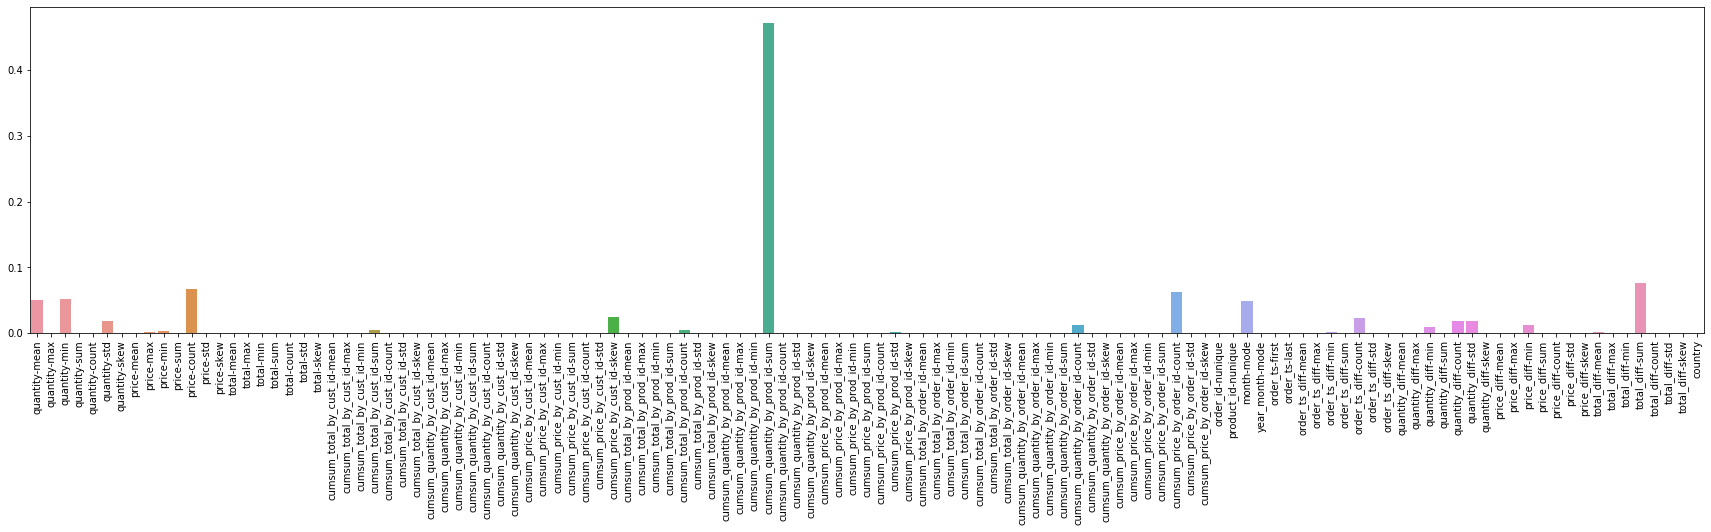

In [ ]:
plt.figure(figsize=(30, 6))
plt.xticks(rotation = 90)
sns.barplot(x=total_features, y=clf.feature_importances_)

In [ ]:
#prediction

pred = clf.predict_proba(test_country[total_features].values)

test_preds = pred[:,1]

In [ ]:
explain_matrix, masks = clf.explain(test_country[total_features].values)

In [ ]:
explain_matrix.shape

(5914, 119)

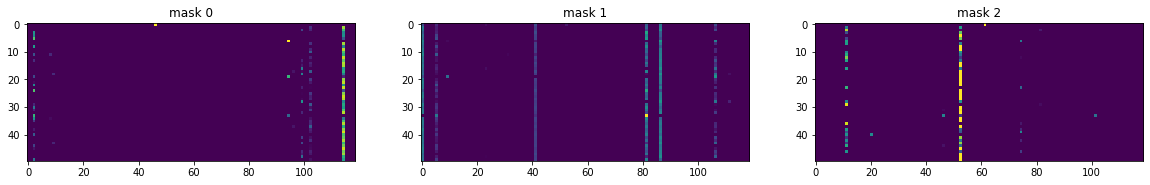

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50]) # 50개 데이터만 제한적으로 열람
    axs[i].set_title(f"mask {i}")

In [ ]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=train_country[total_features].values,
    # eval_set=[X_valid],
    pretraining_ratio=0.8,
)

clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=train_country[total_features].values, y_train=y,
    eval_set=[(train_country[total_features].values, y)], # , (X_valid, y_valid)
    eval_name=['train'], # , 'valid'
    eval_metric=['auc'],
    from_unsupervised=unsupervised_model
)

Device used : cuda
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 92.82129|  0:00:00s
epoch 1  | loss: 93.0071 |  0:00:01s
epoch 2  | loss: 92.50391|  0:00:01s
epoch 3  | loss: 92.68938|  0:00:02s
epoch 4  | loss: 91.82521|  0:00:02s
epoch 5  | loss: 92.02808|  0:00:03s
epoch 6  | loss: 92.86734|  0:00:03s
epoch 7  | loss: 92.24636|  0:00:04s
epoch 8  | loss: 92.44886|  0:00:04s
epoch 9  | loss: 91.87091|  0:00:05s
epoch 10 | loss: 92.88501|  0:00:05s
epoch 11 | loss: 92.16493|  0:00:06s
epoch 12 | loss: 91.59168|  0:00:06s
epoch 13 | loss: 92.39866|  0:00:07s
epoch 14 | loss: 92.38367|  0:00:07s
epoch 15 | loss: 92.61351|  0:00:08s
epoch 16 | loss: 91.85677|  0:00:08s
epoch 17 | loss: 92.36312|  0:00:09s
epoch 18 | loss: 92.18257|  0:00:09s
epoch 19 | loss: 92.5379 |  0:00:10s
epoch 20 | loss: 92.40404|  0:00:10s
epoch 21 | loss: 92.88222|  0:00:11s
epoch 22 | loss: 91.56172|  0:00:11s
epoch 23 | loss: 92.1984 |  0:00:12s
epoch 24 | loss: 92.

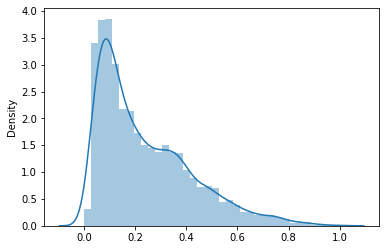

In [ ]:
pred = clf.predict_proba(test_country[total_features].values)
sns.distplot(pred[:, 1])

## stratified k-fold tabnet

In [ ]:
#tabnet hyperparameter

model_params_tab = {
    'n_d': 8,
    'n_a': 47,
    'n_steps':4,
    'n_independent':2,
    'n_shared':3,
    'momentum':0.24296746469311598,
    'seed': 7,
}

In [ ]:
def make_tab_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')
        
        # tabnet 모델 훈련
        clf = TabNetClassifier(
            **model_params,
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=2e-2),
            scheduler_params={"step_size":10, # how to use learning rate scheduler
                              "gamma":0.9},
            scheduler_fn=torch.optim.lr_scheduler.StepLR,
            mask_type='sparsemax' # This will be overwritten if using pretrain model
        )

        clf.fit(
            X_train=x_tr.values, y_train=y_tr.values,
            eval_set=[(x_tr.values, y_tr.values) , (x_val.values, y_val.values)],
            eval_name=['train' , 'valid'], 
            eval_metric=['auc'],
        )
        
        # Validation 데이터 예측
        val_preds = clf.predict_proba(x_val.values)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds[:,1]
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds[:,1])}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds[:,1]) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict_proba(x_test.values)[:,1] / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importances_

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

In [ ]:
#prediction tabnet

y_oof, test_preds4, fi = make_tab_oof_prediction(normal_train_trend, y, normal_test_trend, total_features, model_params = model_params_tab)

fold: 1, x_tr.shape: (5149, 409), x_val.shape: (573, 409)
Device used : cuda
epoch 0  | loss: 0.62677 | train_auc: 0.47375 | valid_auc: 0.50584 |  0:00:00s
epoch 1  | loss: 0.54353 | train_auc: 0.62594 | valid_auc: 0.62782 |  0:00:01s
epoch 2  | loss: 0.49381 | train_auc: 0.62703 | valid_auc: 0.62139 |  0:00:02s
epoch 3  | loss: 0.47147 | train_auc: 0.71029 | valid_auc: 0.68271 |  0:00:03s
epoch 4  | loss: 0.46973 | train_auc: 0.68104 | valid_auc: 0.67112 |  0:00:04s
epoch 5  | loss: 0.45902 | train_auc: 0.72853 | valid_auc: 0.73069 |  0:00:04s
epoch 6  | loss: 0.45465 | train_auc: 0.73824 | valid_auc: 0.72787 |  0:00:05s
epoch 7  | loss: 0.44881 | train_auc: 0.74513 | valid_auc: 0.72872 |  0:00:06s
epoch 8  | loss: 0.44272 | train_auc: 0.75586 | valid_auc: 0.71503 |  0:00:07s
epoch 9  | loss: 0.44773 | train_auc: 0.75532 | valid_auc: 0.74479 |  0:00:08s
epoch 10 | loss: 0.44246 | train_auc: 0.77344 | valid_auc: 0.75719 |  0:00:08s
epoch 11 | loss: 0.43581 | train_auc: 0.775   | valid_

## optuna tabnet hyperparameter tuning

In [ ]:
def objective(trial, label=label_2011_11):
    model_params_tab = {
        'n_d': trial.suggest_int('n_d',8,64),
        'n_a': trial.suggest_int('n_a',8,64),
        'n_steps':trial.suggest_int('n_steps',3,10),
        'n_independent':trial.suggest_int('n_independent', 1, 5),
        'n_shared':trial.suggest_int('n_shared', 1, 5),
        'momentum':trial.suggest_uniform('momentum',0.01,0.4),
        'seed': trial.suggest_int('seed',0,120),
    }
        
    
    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds, fi = make_tab_oof_prediction(train_country, y, test_country, total_features, model_params=model_params_tab)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(label, y_oof)
    
    return val_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) # 100회 동안 하이퍼 파라미터 탐색

[I 2021-04-21 13:46:10,064] A new study created in memory with name: no-name-dbfd54f2-d7f7-416d-88d1-9062e92d43e0


fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.02666 | train_auc: 0.37447 | valid_auc: 0.37751 |  0:00:00s
epoch 1  | loss: 0.81783 | train_auc: 0.49811 | valid_auc: 0.51939 |  0:00:01s
epoch 2  | loss: 0.66382 | train_auc: 0.61014 | valid_auc: 0.61596 |  0:00:02s
epoch 3  | loss: 0.6084  | train_auc: 0.45543 | valid_auc: 0.43016 |  0:00:02s
epoch 4  | loss: 0.61913 | train_auc: 0.56808 | valid_auc: 0.53648 |  0:00:03s
epoch 5  | loss: 0.55599 | train_auc: 0.59226 | valid_auc: 0.5679  |  0:00:04s
epoch 6  | loss: 0.50574 | train_auc: 0.65677 | valid_auc: 0.63617 |  0:00:04s
epoch 7  | loss: 0.48763 | train_auc: 0.57481 | valid_auc: 0.57904 |  0:00:05s
epoch 8  | loss: 0.46928 | train_auc: 0.5727  | valid_auc: 0.51916 |  0:00:06s
epoch 9  | loss: 0.50033 | train_auc: 0.70688 | valid_auc: 0.68349 |  0:00:06s
epoch 10 | loss: 0.45908 | train_auc: 0.62486 | valid_auc: 0.56269 |  0:00:07s
epoch 11 | loss: 0.45469 | train_auc: 0.72194 | valid_

[I 2021-04-21 13:49:20,008] Trial 0 finished with value: 0.7213736022183308 and parameters: {'n_d': 36, 'n_a': 52, 'n_steps': 4, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.24443912390822403, 'seed': 75}. Best is trial 0 with value: 0.7213736022183308.



Mean AUC = 0.7486629659995655
OOF AUC = 0.7213736022183308
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.19249 | train_auc: 0.48693 | valid_auc: 0.49646 |  0:00:02s
epoch 1  | loss: 1.16762 | train_auc: 0.48341 | valid_auc: 0.46813 |  0:00:04s
epoch 2  | loss: 1.52117 | train_auc: 0.50307 | valid_auc: 0.51512 |  0:00:07s
epoch 3  | loss: 2.04628 | train_auc: 0.59164 | valid_auc: 0.6151  |  0:00:09s
epoch 4  | loss: 1.73353 | train_auc: 0.44711 | valid_auc: 0.42359 |  0:00:12s
epoch 5  | loss: 1.42923 | train_auc: 0.43557 | valid_auc: 0.4182  |  0:00:14s
epoch 6  | loss: 1.33912 | train_auc: 0.56448 | valid_auc: 0.61291 |  0:00:17s
epoch 7  | loss: 1.03801 | train_auc: 0.47478 | valid_auc: 0.46115 |  0:00:19s
epoch 8  | loss: 0.97784 | train_auc: 0.5625  | valid_auc: 0.58913 |  0:00:22s
epoch 9  | loss: 0.88039 | train_auc: 0.55232 | valid_auc: 0.49646 |  0:00:24s
epoch 10 | loss: 0.79272 | train_auc: 0.47668 | valid_auc: 0.4941  |  0:0

[I 2021-04-21 14:00:48,875] Trial 1 finished with value: 0.6268510535438193 and parameters: {'n_d': 42, 'n_a': 13, 'n_steps': 8, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.22837335030486713, 'seed': 110}. Best is trial 0 with value: 0.7213736022183308.



Mean AUC = 0.693755209475662
OOF AUC = 0.6268510535438193
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.38567 | train_auc: 0.50628 | valid_auc: 0.50581 |  0:00:01s
epoch 1  | loss: 1.25445 | train_auc: 0.4874  | valid_auc: 0.49741 |  0:00:03s
epoch 2  | loss: 1.18749 | train_auc: 0.45069 | valid_auc: 0.46268 |  0:00:05s
epoch 3  | loss: 1.10184 | train_auc: 0.48753 | valid_auc: 0.44152 |  0:00:07s
epoch 4  | loss: 1.13615 | train_auc: 0.47723 | valid_auc: 0.48503 |  0:00:09s
epoch 5  | loss: 0.90585 | train_auc: 0.52982 | valid_auc: 0.50932 |  0:00:12s
epoch 6  | loss: 1.01617 | train_auc: 0.51417 | valid_auc: 0.5015  |  0:00:14s
epoch 7  | loss: 0.95916 | train_auc: 0.54901 | valid_auc: 0.53619 |  0:00:16s
epoch 8  | loss: 0.80858 | train_auc: 0.47589 | valid_auc: 0.44114 |  0:00:18s
epoch 9  | loss: 0.77718 | train_auc: 0.46789 | valid_auc: 0.47918 |  0:00:20s
epoch 10 | loss: 0.75566 | train_auc: 0.48913 | valid_auc: 0.49211 |  0:00

[I 2021-04-21 14:10:12,769] Trial 2 finished with value: 0.6643722736852424 and parameters: {'n_d': 47, 'n_a': 20, 'n_steps': 9, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.23241329970124194, 'seed': 62}. Best is trial 0 with value: 0.7213736022183308.



Mean AUC = 0.729995037608228
OOF AUC = 0.6643722736852424
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.82064 | train_auc: 0.54046 | valid_auc: 0.58079 |  0:00:01s
epoch 1  | loss: 1.31207 | train_auc: 0.53107 | valid_auc: 0.56444 |  0:00:02s
epoch 2  | loss: 0.98422 | train_auc: 0.47324 | valid_auc: 0.47296 |  0:00:03s
epoch 3  | loss: 0.89057 | train_auc: 0.4996  | valid_auc: 0.50645 |  0:00:04s
epoch 4  | loss: 0.66836 | train_auc: 0.45716 | valid_auc: 0.47948 |  0:00:05s
epoch 5  | loss: 0.61879 | train_auc: 0.57559 | valid_auc: 0.55028 |  0:00:07s
epoch 6  | loss: 0.65852 | train_auc: 0.54928 | valid_auc: 0.58538 |  0:00:08s
epoch 7  | loss: 0.68862 | train_auc: 0.5929  | valid_auc: 0.61071 |  0:00:09s
epoch 8  | loss: 0.58314 | train_auc: 0.48024 | valid_auc: 0.54427 |  0:00:10s
epoch 9  | loss: 0.58388 | train_auc: 0.64361 | valid_auc: 0.59264 |  0:00:12s
epoch 10 | loss: 0.57728 | train_auc: 0.52487 | valid_auc: 0.5211  |  0:00

[I 2021-04-21 14:16:05,395] Trial 3 finished with value: 0.6799005716628125 and parameters: {'n_d': 26, 'n_a': 44, 'n_steps': 9, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.202090495631108, 'seed': 10}. Best is trial 0 with value: 0.7213736022183308.



Mean AUC = 0.7175028174845552
OOF AUC = 0.6799005716628125
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.53284 | train_auc: 0.51748 | valid_auc: 0.50025 |  0:00:01s
epoch 1  | loss: 1.22933 | train_auc: 0.48611 | valid_auc: 0.43862 |  0:00:03s
epoch 2  | loss: 1.19985 | train_auc: 0.42922 | valid_auc: 0.47699 |  0:00:05s
epoch 3  | loss: 1.13522 | train_auc: 0.4178  | valid_auc: 0.42305 |  0:00:06s
epoch 4  | loss: 1.06136 | train_auc: 0.43633 | valid_auc: 0.42062 |  0:00:08s
epoch 5  | loss: 1.00031 | train_auc: 0.5735  | valid_auc: 0.5622  |  0:00:10s
epoch 6  | loss: 0.86764 | train_auc: 0.46511 | valid_auc: 0.4584  |  0:00:12s
epoch 7  | loss: 1.2422  | train_auc: 0.51501 | valid_auc: 0.48872 |  0:00:14s
epoch 8  | loss: 0.83352 | train_auc: 0.43435 | valid_auc: 0.46599 |  0:00:16s
epoch 9  | loss: 0.69453 | train_auc: 0.54355 | valid_auc: 0.57955 |  0:00:18s
epoch 10 | loss: 0.63552 | train_auc: 0.48146 | valid_auc: 0.47879 |  0:0

[I 2021-04-21 14:28:04,515] Trial 4 finished with value: 0.7169866210999867 and parameters: {'n_d': 48, 'n_a': 40, 'n_steps': 7, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.3889438815192816, 'seed': 100}. Best is trial 0 with value: 0.7213736022183308.



Mean AUC = 0.7585872289759766
OOF AUC = 0.7169866210999867
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.86885 | train_auc: 0.6063  | valid_auc: 0.63892 |  0:00:00s
epoch 1  | loss: 0.61778 | train_auc: 0.67231 | valid_auc: 0.63081 |  0:00:00s
epoch 2  | loss: 0.53486 | train_auc: 0.59025 | valid_auc: 0.57108 |  0:00:01s
epoch 3  | loss: 0.51476 | train_auc: 0.47319 | valid_auc: 0.47838 |  0:00:01s
epoch 4  | loss: 0.52604 | train_auc: 0.66092 | valid_auc: 0.62153 |  0:00:02s
epoch 5  | loss: 0.50187 | train_auc: 0.62261 | valid_auc: 0.61124 |  0:00:02s
epoch 6  | loss: 0.47429 | train_auc: 0.64656 | valid_auc: 0.63094 |  0:00:03s
epoch 7  | loss: 0.47125 | train_auc: 0.4941  | valid_auc: 0.48367 |  0:00:03s
epoch 8  | loss: 0.47288 | train_auc: 0.46244 | valid_auc: 0.45347 |  0:00:04s
epoch 9  | loss: 0.45421 | train_auc: 0.5129  | valid_auc: 0.49354 |  0:00:04s
epoch 10 | loss: 0.4421  | train_auc: 0.46097 | valid_auc: 0.48363 |  0:0

[I 2021-04-21 14:30:21,567] Trial 5 finished with value: 0.7117291129201142 and parameters: {'n_d': 51, 'n_a': 39, 'n_steps': 4, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.06310501657643044, 'seed': 28}. Best is trial 0 with value: 0.7213736022183308.



Mean AUC = 0.746298044144933
OOF AUC = 0.7117291129201142
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.84402 | train_auc: 0.43111 | valid_auc: 0.494   |  0:00:01s
epoch 1  | loss: 0.67918 | train_auc: 0.53808 | valid_auc: 0.54653 |  0:00:02s
epoch 2  | loss: 0.67096 | train_auc: 0.59685 | valid_auc: 0.57482 |  0:00:04s
epoch 3  | loss: 0.68947 | train_auc: 0.49037 | valid_auc: 0.45053 |  0:00:05s
epoch 4  | loss: 0.74506 | train_auc: 0.393   | valid_auc: 0.36035 |  0:00:06s
epoch 5  | loss: 0.61722 | train_auc: 0.38872 | valid_auc: 0.38098 |  0:00:08s
epoch 6  | loss: 0.61696 | train_auc: 0.55624 | valid_auc: 0.57787 |  0:00:09s
epoch 7  | loss: 0.5675  | train_auc: 0.66108 | valid_auc: 0.68567 |  0:00:11s
epoch 8  | loss: 0.56781 | train_auc: 0.64696 | valid_auc: 0.69563 |  0:00:12s
epoch 9  | loss: 0.53441 | train_auc: 0.65394 | valid_auc: 0.64012 |  0:00:13s
epoch 10 | loss: 0.53266 | train_auc: 0.69944 | valid_auc: 0.68418 |  0:00

[I 2021-04-21 14:37:42,888] Trial 6 finished with value: 0.6879479807633756 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.15713293196419365, 'seed': 78}. Best is trial 0 with value: 0.7213736022183308.



Mean AUC = 0.7318833108657723
OOF AUC = 0.6879479807633756
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.25121 | train_auc: 0.58761 | valid_auc: 0.52733 |  0:00:02s
epoch 1  | loss: 1.17933 | train_auc: 0.51523 | valid_auc: 0.54597 |  0:00:05s
epoch 2  | loss: 1.10288 | train_auc: 0.48589 | valid_auc: 0.50786 |  0:00:08s
epoch 3  | loss: 1.04179 | train_auc: 0.46108 | valid_auc: 0.44447 |  0:00:11s
epoch 4  | loss: 1.203   | train_auc: 0.52831 | valid_auc: 0.49714 |  0:00:14s
epoch 5  | loss: 1.51849 | train_auc: 0.4827  | valid_auc: 0.51225 |  0:00:17s
epoch 6  | loss: 1.34773 | train_auc: 0.47378 | valid_auc: 0.53497 |  0:00:19s
epoch 7  | loss: 1.26022 | train_auc: 0.3883  | valid_auc: 0.40955 |  0:00:22s
epoch 8  | loss: 2.12706 | train_auc: 0.50749 | valid_auc: 0.50069 |  0:00:24s
epoch 9  | loss: 1.55651 | train_auc: 0.45384 | valid_auc: 0.44774 |  0:00:27s
epoch 10 | loss: 1.00828 | train_auc: 0.49544 | valid_auc: 0.50631 |  0:0

[I 2021-04-21 14:46:05,009] Trial 7 finished with value: 0.5747651674813121 and parameters: {'n_d': 36, 'n_a': 12, 'n_steps': 10, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.39779004763048154, 'seed': 107}. Best is trial 0 with value: 0.7213736022183308.



Mean AUC = 0.6276446653624995
OOF AUC = 0.5747651674813121
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.98914 | train_auc: 0.5114  | valid_auc: 0.49802 |  0:00:02s
epoch 1  | loss: 1.03176 | train_auc: 0.49786 | valid_auc: 0.45541 |  0:00:04s
epoch 2  | loss: 0.99201 | train_auc: 0.44356 | valid_auc: 0.41931 |  0:00:07s
epoch 3  | loss: 0.97822 | train_auc: 0.46646 | valid_auc: 0.49447 |  0:00:09s
epoch 4  | loss: 0.9217  | train_auc: 0.45761 | valid_auc: 0.44396 |  0:00:12s
epoch 5  | loss: 0.86575 | train_auc: 0.45737 | valid_auc: 0.47853 |  0:00:14s
epoch 6  | loss: 0.88342 | train_auc: 0.43359 | valid_auc: 0.44617 |  0:00:16s
epoch 7  | loss: 0.95417 | train_auc: 0.49628 | valid_auc: 0.48866 |  0:00:19s
epoch 8  | loss: 0.85902 | train_auc: 0.36653 | valid_auc: 0.39764 |  0:00:21s
epoch 9  | loss: 0.92861 | train_auc: 0.53256 | valid_auc: 0.51868 |  0:00:24s
epoch 10 | loss: 0.83262 | train_auc: 0.56234 | valid_auc: 0.56522 |  0:0

[I 2021-04-21 14:59:55,319] Trial 8 finished with value: 0.6600949206815991 and parameters: {'n_d': 18, 'n_a': 45, 'n_steps': 9, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.25641023392106554, 'seed': 47}. Best is trial 0 with value: 0.7213736022183308.



Mean AUC = 0.713625261459532
OOF AUC = 0.6600949206815991
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 5.59074 | train_auc: 0.56811 | valid_auc: 0.60214 |  0:00:01s
epoch 1  | loss: 1.49242 | train_auc: 0.43847 | valid_auc: 0.48411 |  0:00:03s
epoch 2  | loss: 1.54886 | train_auc: 0.51168 | valid_auc: 0.47954 |  0:00:04s
epoch 3  | loss: 1.41884 | train_auc: 0.61859 | valid_auc: 0.60068 |  0:00:06s
epoch 4  | loss: 0.99216 | train_auc: 0.55537 | valid_auc: 0.53807 |  0:00:08s
epoch 5  | loss: 1.30923 | train_auc: 0.47822 | valid_auc: 0.43651 |  0:00:09s
epoch 6  | loss: 2.05638 | train_auc: 0.49176 | valid_auc: 0.46668 |  0:00:11s
epoch 7  | loss: 1.07039 | train_auc: 0.59322 | valid_auc: 0.57306 |  0:00:12s
epoch 8  | loss: 1.24403 | train_auc: 0.45656 | valid_auc: 0.45318 |  0:00:14s
epoch 9  | loss: 1.04388 | train_auc: 0.64853 | valid_auc: 0.61594 |  0:00:16s
epoch 10 | loss: 1.19583 | train_auc: 0.53356 | valid_auc: 0.52329 |  0:00

[I 2021-04-21 15:06:29,360] Trial 9 finished with value: 0.6477173402901237 and parameters: {'n_d': 59, 'n_a': 34, 'n_steps': 10, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.36888581688805877, 'seed': 113}. Best is trial 0 with value: 0.7213736022183308.



Mean AUC = 0.7103352728328809
OOF AUC = 0.6477173402901237
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.81352 | train_auc: 0.59933 | valid_auc: 0.63281 |  0:00:00s
epoch 1  | loss: 0.58609 | train_auc: 0.553   | valid_auc: 0.54201 |  0:00:01s
epoch 2  | loss: 0.53936 | train_auc: 0.56062 | valid_auc: 0.508   |  0:00:01s
epoch 3  | loss: 0.50121 | train_auc: 0.50902 | valid_auc: 0.50161 |  0:00:02s
epoch 4  | loss: 0.5077  | train_auc: 0.55887 | valid_auc: 0.56641 |  0:00:02s
epoch 5  | loss: 0.49621 | train_auc: 0.55599 | valid_auc: 0.55908 |  0:00:03s
epoch 6  | loss: 0.45731 | train_auc: 0.70723 | valid_auc: 0.71841 |  0:00:03s
epoch 7  | loss: 0.44569 | train_auc: 0.73284 | valid_auc: 0.71608 |  0:00:04s
epoch 8  | loss: 0.44018 | train_auc: 0.67181 | valid_auc: 0.65065 |  0:00:04s
epoch 9  | loss: 0.44622 | train_auc: 0.75903 | valid_auc: 0.72722 |  0:00:05s
epoch 10 | loss: 0.43739 | train_auc: 0.7547  | valid_auc: 0.72991 |  0:0

[I 2021-04-21 15:08:56,527] Trial 10 finished with value: 0.7108553369305465 and parameters: {'n_d': 32, 'n_a': 64, 'n_steps': 3, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.308171081292367, 'seed': 82}. Best is trial 0 with value: 0.7213736022183308.



Mean AUC = 0.7502895763770554
OOF AUC = 0.7108553369305465
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.03761 | train_auc: 0.47557 | valid_auc: 0.46776 |  0:00:01s
epoch 1  | loss: 0.98797 | train_auc: 0.50065 | valid_auc: 0.46678 |  0:00:02s
epoch 2  | loss: 0.90511 | train_auc: 0.5492  | valid_auc: 0.56908 |  0:00:03s
epoch 3  | loss: 1.12161 | train_auc: 0.60914 | valid_auc: 0.59903 |  0:00:04s
epoch 4  | loss: 0.79571 | train_auc: 0.5807  | valid_auc: 0.57256 |  0:00:05s
epoch 5  | loss: 0.77592 | train_auc: 0.50386 | valid_auc: 0.47449 |  0:00:07s
epoch 6  | loss: 0.64077 | train_auc: 0.56857 | valid_auc: 0.59536 |  0:00:08s
epoch 7  | loss: 0.63379 | train_auc: 0.46901 | valid_auc: 0.41702 |  0:00:09s
epoch 8  | loss: 0.68831 | train_auc: 0.62201 | valid_auc: 0.61696 |  0:00:10s
epoch 9  | loss: 0.55653 | train_auc: 0.61025 | valid_auc: 0.58718 |  0:00:11s
epoch 10 | loss: 0.49932 | train_auc: 0.61873 | valid_auc: 0.60149 |  0:0

[I 2021-04-21 15:15:28,100] Trial 11 finished with value: 0.7356978474644994 and parameters: {'n_d': 62, 'n_a': 57, 'n_steps': 6, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.11075147385368411, 'seed': 88}. Best is trial 11 with value: 0.7356978474644994.



Mean AUC = 0.7640233596414076
OOF AUC = 0.7356978474644994
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.9108  | train_auc: 0.53827 | valid_auc: 0.52878 |  0:00:01s
epoch 1  | loss: 0.93484 | train_auc: 0.61234 | valid_auc: 0.5983  |  0:00:02s
epoch 2  | loss: 0.89647 | train_auc: 0.49098 | valid_auc: 0.53588 |  0:00:03s
epoch 3  | loss: 0.75956 | train_auc: 0.62461 | valid_auc: 0.5682  |  0:00:04s
epoch 4  | loss: 0.68942 | train_auc: 0.44022 | valid_auc: 0.43434 |  0:00:05s
epoch 5  | loss: 0.62324 | train_auc: 0.4671  | valid_auc: 0.41554 |  0:00:06s
epoch 6  | loss: 0.62992 | train_auc: 0.60499 | valid_auc: 0.61234 |  0:00:07s
epoch 7  | loss: 0.62589 | train_auc: 0.69808 | valid_auc: 0.63358 |  0:00:08s
epoch 8  | loss: 0.57368 | train_auc: 0.5469  | valid_auc: 0.54185 |  0:00:10s
epoch 9  | loss: 0.49729 | train_auc: 0.5309  | valid_auc: 0.48925 |  0:00:11s
epoch 10 | loss: 0.50053 | train_auc: 0.61833 | valid_auc: 0.56537 |  0:0

[I 2021-04-21 15:19:53,962] Trial 12 finished with value: 0.6548192185047058 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 5, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.061059549914684784, 'seed': 80}. Best is trial 11 with value: 0.7356978474644994.



Mean AUC = 0.7279846615454221
OOF AUC = 0.6548192185047058
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.14325 | train_auc: 0.44045 | valid_auc: 0.46951 |  0:00:00s
epoch 1  | loss: 0.86897 | train_auc: 0.61196 | valid_auc: 0.58618 |  0:00:01s
epoch 2  | loss: 0.75372 | train_auc: 0.60276 | valid_auc: 0.57794 |  0:00:02s
epoch 3  | loss: 0.813   | train_auc: 0.63157 | valid_auc: 0.61438 |  0:00:03s
epoch 4  | loss: 0.80542 | train_auc: 0.61212 | valid_auc: 0.58021 |  0:00:04s
epoch 5  | loss: 0.86945 | train_auc: 0.64998 | valid_auc: 0.66353 |  0:00:05s
epoch 6  | loss: 1.00446 | train_auc: 0.68986 | valid_auc: 0.65462 |  0:00:06s
epoch 7  | loss: 0.62644 | train_auc: 0.44464 | valid_auc: 0.46135 |  0:00:07s
epoch 8  | loss: 0.7302  | train_auc: 0.44886 | valid_auc: 0.42157 |  0:00:07s
epoch 9  | loss: 0.64596 | train_auc: 0.67804 | valid_auc: 0.64606 |  0:00:08s
epoch 10 | loss: 0.56737 | train_auc: 0.43829 | valid_auc: 0.45874 |  0:0

[I 2021-04-21 15:24:07,616] Trial 13 finished with value: 0.6778878143291465 and parameters: {'n_d': 58, 'n_a': 55, 'n_steps': 6, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.1304458326295294, 'seed': 59}. Best is trial 11 with value: 0.7356978474644994.



Mean AUC = 0.7363931278694851
OOF AUC = 0.6778878143291465
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.69369 | train_auc: 0.62639 | valid_auc: 0.60605 |  0:00:00s
epoch 1  | loss: 0.59789 | train_auc: 0.6053  | valid_auc: 0.65082 |  0:00:01s
epoch 2  | loss: 0.55457 | train_auc: 0.46579 | valid_auc: 0.4564  |  0:00:02s
epoch 3  | loss: 0.55687 | train_auc: 0.52934 | valid_auc: 0.51234 |  0:00:03s
epoch 4  | loss: 0.57537 | train_auc: 0.57722 | valid_auc: 0.52168 |  0:00:04s
epoch 5  | loss: 0.53448 | train_auc: 0.50889 | valid_auc: 0.48279 |  0:00:05s
epoch 6  | loss: 0.50973 | train_auc: 0.55964 | valid_auc: 0.54437 |  0:00:06s
epoch 7  | loss: 0.50504 | train_auc: 0.45559 | valid_auc: 0.44415 |  0:00:07s
epoch 8  | loss: 0.46938 | train_auc: 0.54979 | valid_auc: 0.54846 |  0:00:08s
epoch 9  | loss: 0.45107 | train_auc: 0.68495 | valid_auc: 0.65169 |  0:00:08s
epoch 10 | loss: 0.45146 | train_auc: 0.694   | valid_auc: 0.66925 |  0:0

[I 2021-04-21 15:28:55,866] Trial 14 finished with value: 0.7153149083839423 and parameters: {'n_d': 9, 'n_a': 54, 'n_steps': 3, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.1179276222956154, 'seed': 92}. Best is trial 11 with value: 0.7356978474644994.



Mean AUC = 0.7641740025742196
OOF AUC = 0.7153149083839423
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.74266 | train_auc: 0.51157 | valid_auc: 0.54102 |  0:00:01s
epoch 1  | loss: 0.61114 | train_auc: 0.49706 | valid_auc: 0.44999 |  0:00:02s
epoch 2  | loss: 0.80067 | train_auc: 0.46675 | valid_auc: 0.47275 |  0:00:03s
epoch 3  | loss: 0.93645 | train_auc: 0.41996 | valid_auc: 0.4457  |  0:00:05s
epoch 4  | loss: 0.68965 | train_auc: 0.45858 | valid_auc: 0.49974 |  0:00:06s
epoch 5  | loss: 0.61591 | train_auc: 0.53994 | valid_auc: 0.5943  |  0:00:08s
epoch 6  | loss: 0.55044 | train_auc: 0.48972 | valid_auc: 0.52438 |  0:00:09s
epoch 7  | loss: 0.57063 | train_auc: 0.63886 | valid_auc: 0.63282 |  0:00:10s
epoch 8  | loss: 0.72897 | train_auc: 0.70649 | valid_auc: 0.67564 |  0:00:12s
epoch 9  | loss: 0.57328 | train_auc: 0.61711 | valid_auc: 0.68421 |  0:00:13s
epoch 10 | loss: 0.48999 | train_auc: 0.69284 | valid_auc: 0.68626 |  0:0

[I 2021-04-21 15:37:04,325] Trial 15 finished with value: 0.7026741648212755 and parameters: {'n_d': 29, 'n_a': 55, 'n_steps': 6, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.31798782652790647, 'seed': 59}. Best is trial 11 with value: 0.7356978474644994.



Mean AUC = 0.7419174389041118
OOF AUC = 0.7026741648212755
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.12405 | train_auc: 0.59901 | valid_auc: 0.61171 |  0:00:00s
epoch 1  | loss: 0.74728 | train_auc: 0.57861 | valid_auc: 0.60119 |  0:00:01s
epoch 2  | loss: 0.67147 | train_auc: 0.53425 | valid_auc: 0.53091 |  0:00:02s
epoch 3  | loss: 0.56605 | train_auc: 0.62275 | valid_auc: 0.58289 |  0:00:02s
epoch 4  | loss: 0.55446 | train_auc: 0.54958 | valid_auc: 0.55333 |  0:00:03s
epoch 5  | loss: 0.51077 | train_auc: 0.38523 | valid_auc: 0.35352 |  0:00:04s
epoch 6  | loss: 0.4894  | train_auc: 0.659   | valid_auc: 0.65341 |  0:00:04s
epoch 7  | loss: 0.47218 | train_auc: 0.58981 | valid_auc: 0.59903 |  0:00:05s
epoch 8  | loss: 0.46647 | train_auc: 0.57308 | valid_auc: 0.60783 |  0:00:06s
epoch 9  | loss: 0.52628 | train_auc: 0.58001 | valid_auc: 0.57596 |  0:00:06s
epoch 10 | loss: 0.47689 | train_auc: 0.37479 | valid_auc: 0.36887 |  0:0

[I 2021-04-21 15:39:36,609] Trial 16 finished with value: 0.6709462475066799 and parameters: {'n_d': 64, 'n_a': 29, 'n_steps': 4, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.01585009945052024, 'seed': 39}. Best is trial 11 with value: 0.7356978474644994.



Mean AUC = 0.7400823872578082
OOF AUC = 0.6709462475066799
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.1468  | train_auc: 0.43869 | valid_auc: 0.44768 |  0:00:00s
epoch 1  | loss: 0.80322 | train_auc: 0.47331 | valid_auc: 0.45152 |  0:00:01s
epoch 2  | loss: 0.69829 | train_auc: 0.43116 | valid_auc: 0.41097 |  0:00:02s
epoch 3  | loss: 0.58113 | train_auc: 0.48803 | valid_auc: 0.45946 |  0:00:03s
epoch 4  | loss: 0.57492 | train_auc: 0.63077 | valid_auc: 0.65658 |  0:00:03s
epoch 5  | loss: 0.69687 | train_auc: 0.59176 | valid_auc: 0.52341 |  0:00:04s
epoch 6  | loss: 0.68148 | train_auc: 0.6533  | valid_auc: 0.61644 |  0:00:05s
epoch 7  | loss: 0.57737 | train_auc: 0.49674 | valid_auc: 0.49719 |  0:00:06s
epoch 8  | loss: 0.52724 | train_auc: 0.58664 | valid_auc: 0.52991 |  0:00:06s
epoch 9  | loss: 0.4766  | train_auc: 0.6321  | valid_auc: 0.6159  |  0:00:07s
epoch 10 | loss: 0.47253 | train_auc: 0.6902  | valid_auc: 0.67025 |  0:0

[I 2021-04-21 15:43:30,700] Trial 17 finished with value: 0.7196419235733307 and parameters: {'n_d': 40, 'n_a': 50, 'n_steps': 5, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.17417375311754507, 'seed': 73}. Best is trial 11 with value: 0.7356978474644994.



Mean AUC = 0.7600098619594727
OOF AUC = 0.7196419235733307
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.80598 | train_auc: 0.54179 | valid_auc: 0.56616 |  0:00:00s
epoch 1  | loss: 0.63248 | train_auc: 0.53596 | valid_auc: 0.50725 |  0:00:01s
epoch 2  | loss: 0.59721 | train_auc: 0.64368 | valid_auc: 0.6677  |  0:00:02s
epoch 3  | loss: 0.55115 | train_auc: 0.51893 | valid_auc: 0.53436 |  0:00:02s
epoch 4  | loss: 0.50762 | train_auc: 0.64291 | valid_auc: 0.59495 |  0:00:03s
epoch 5  | loss: 0.48951 | train_auc: 0.68436 | valid_auc: 0.67461 |  0:00:04s
epoch 6  | loss: 0.4869  | train_auc: 0.67074 | valid_auc: 0.65274 |  0:00:05s
epoch 7  | loss: 0.48374 | train_auc: 0.66263 | valid_auc: 0.62727 |  0:00:06s
epoch 8  | loss: 0.49391 | train_auc: 0.65978 | valid_auc: 0.63858 |  0:00:06s
epoch 9  | loss: 0.51161 | train_auc: 0.74371 | valid_auc: 0.69861 |  0:00:07s
epoch 10 | loss: 0.49462 | train_auc: 0.5531  | valid_auc: 0.56313 |  0:0

[I 2021-04-21 15:46:49,982] Trial 18 finished with value: 0.710604798165451 and parameters: {'n_d': 56, 'n_a': 60, 'n_steps': 4, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.08929174641197782, 'seed': 94}. Best is trial 11 with value: 0.7356978474644994.



Mean AUC = 0.7423418194529172
OOF AUC = 0.710604798165451
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.16631 | train_auc: 0.57609 | valid_auc: 0.59618 |  0:00:01s
epoch 1  | loss: 0.77739 | train_auc: 0.43942 | valid_auc: 0.41667 |  0:00:03s
epoch 2  | loss: 0.7948  | train_auc: 0.63379 | valid_auc: 0.62505 |  0:00:04s
epoch 3  | loss: 0.77149 | train_auc: 0.46603 | valid_auc: 0.48226 |  0:00:06s
epoch 4  | loss: 0.79726 | train_auc: 0.54623 | valid_auc: 0.5214  |  0:00:07s
epoch 5  | loss: 0.82636 | train_auc: 0.49915 | valid_auc: 0.46356 |  0:00:09s
epoch 6  | loss: 0.71672 | train_auc: 0.60517 | valid_auc: 0.61531 |  0:00:11s
epoch 7  | loss: 0.73218 | train_auc: 0.61766 | valid_auc: 0.61924 |  0:00:12s
epoch 8  | loss: 0.67083 | train_auc: 0.56795 | valid_auc: 0.61635 |  0:00:14s
epoch 9  | loss: 0.60928 | train_auc: 0.66628 | valid_auc: 0.66456 |  0:00:16s
epoch 10 | loss: 0.60065 | train_auc: 0.5959  | valid_auc: 0.61803 |  0:00

[I 2021-04-21 15:55:29,770] Trial 19 finished with value: 0.7117562182626145 and parameters: {'n_d': 23, 'n_a': 49, 'n_steps': 7, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.28535234961465483, 'seed': 68}. Best is trial 11 with value: 0.7356978474644994.



Mean AUC = 0.7486420187962614
OOF AUC = 0.7117562182626145
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 2.01731 | train_auc: 0.6223  | valid_auc: 0.59397 |  0:00:01s
epoch 1  | loss: 0.91185 | train_auc: 0.49992 | valid_auc: 0.44355 |  0:00:02s
epoch 2  | loss: 0.6083  | train_auc: 0.48692 | valid_auc: 0.4883  |  0:00:03s
epoch 3  | loss: 0.63881 | train_auc: 0.44048 | valid_auc: 0.44351 |  0:00:04s
epoch 4  | loss: 0.64225 | train_auc: 0.53068 | valid_auc: 0.55984 |  0:00:05s
epoch 5  | loss: 0.52625 | train_auc: 0.62058 | valid_auc: 0.67823 |  0:00:07s
epoch 6  | loss: 0.51899 | train_auc: 0.58018 | valid_auc: 0.58272 |  0:00:08s
epoch 7  | loss: 0.5142  | train_auc: 0.64215 | valid_auc: 0.62612 |  0:00:09s
epoch 8  | loss: 0.49336 | train_auc: 0.68012 | valid_auc: 0.67629 |  0:00:10s
epoch 9  | loss: 0.48486 | train_auc: 0.72395 | valid_auc: 0.73163 |  0:00:11s
epoch 10 | loss: 0.47374 | train_auc: 0.72767 | valid_auc: 0.69328 |  0:0

[I 2021-04-21 16:03:02,070] Trial 20 finished with value: 0.7260528940337057 and parameters: {'n_d': 13, 'n_a': 60, 'n_steps': 6, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.18350239380558153, 'seed': 91}. Best is trial 11 with value: 0.7356978474644994.



Mean AUC = 0.7680140277179206
OOF AUC = 0.7260528940337057
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.8933  | train_auc: 0.45761 | valid_auc: 0.5078  |  0:00:01s
epoch 1  | loss: 0.64012 | train_auc: 0.53632 | valid_auc: 0.49221 |  0:00:02s
epoch 2  | loss: 0.59052 | train_auc: 0.50047 | valid_auc: 0.47397 |  0:00:03s
epoch 3  | loss: 0.54986 | train_auc: 0.56667 | valid_auc: 0.53456 |  0:00:04s
epoch 4  | loss: 0.50999 | train_auc: 0.63618 | valid_auc: 0.63054 |  0:00:06s
epoch 5  | loss: 0.47528 | train_auc: 0.65113 | valid_auc: 0.63284 |  0:00:07s
epoch 6  | loss: 0.47865 | train_auc: 0.69101 | valid_auc: 0.65289 |  0:00:08s
epoch 7  | loss: 0.49372 | train_auc: 0.6227  | valid_auc: 0.621   |  0:00:09s
epoch 8  | loss: 0.49839 | train_auc: 0.57036 | valid_auc: 0.56773 |  0:00:11s
epoch 9  | loss: 0.48508 | train_auc: 0.5216  | valid_auc: 0.52978 |  0:00:12s
epoch 10 | loss: 0.46124 | train_auc: 0.7591  | valid_auc: 0.73271 |  0:0

[I 2021-04-21 16:09:19,184] Trial 21 finished with value: 0.7551183612332707 and parameters: {'n_d': 8, 'n_a': 59, 'n_steps': 6, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.18935679708478026, 'seed': 90}. Best is trial 21 with value: 0.7551183612332707.



Mean AUC = 0.7738517954098755
OOF AUC = 0.7551183612332707
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.71816 | train_auc: 0.39674 | valid_auc: 0.37657 |  0:00:01s
epoch 1  | loss: 0.6168  | train_auc: 0.48346 | valid_auc: 0.53196 |  0:00:02s
epoch 2  | loss: 0.56139 | train_auc: 0.61195 | valid_auc: 0.57212 |  0:00:03s
epoch 3  | loss: 0.55157 | train_auc: 0.56073 | valid_auc: 0.55655 |  0:00:04s
epoch 4  | loss: 0.55167 | train_auc: 0.63076 | valid_auc: 0.6686  |  0:00:05s
epoch 5  | loss: 0.50296 | train_auc: 0.54053 | valid_auc: 0.52963 |  0:00:06s
epoch 6  | loss: 0.49368 | train_auc: 0.61757 | valid_auc: 0.58453 |  0:00:07s
epoch 7  | loss: 0.4765  | train_auc: 0.53375 | valid_auc: 0.50098 |  0:00:09s
epoch 8  | loss: 0.48381 | train_auc: 0.53212 | valid_auc: 0.51573 |  0:00:10s
epoch 9  | loss: 0.49635 | train_auc: 0.55401 | valid_auc: 0.5619  |  0:00:11s
epoch 10 | loss: 0.49692 | train_auc: 0.47802 | valid_auc: 0.49108 |  0:0

[I 2021-04-21 16:15:08,370] Trial 22 finished with value: 0.7567942511425088 and parameters: {'n_d': 8, 'n_a': 59, 'n_steps': 6, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.18849846397652345, 'seed': 92}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7729182055413051
OOF AUC = 0.7567942511425088
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.7361  | train_auc: 0.44584 | valid_auc: 0.44923 |  0:00:01s
epoch 1  | loss: 0.6413  | train_auc: 0.4301  | valid_auc: 0.43574 |  0:00:02s
epoch 2  | loss: 0.62145 | train_auc: 0.38182 | valid_auc: 0.3581  |  0:00:03s
epoch 3  | loss: 0.55839 | train_auc: 0.47377 | valid_auc: 0.47337 |  0:00:04s
epoch 4  | loss: 0.52162 | train_auc: 0.52623 | valid_auc: 0.50329 |  0:00:06s
epoch 5  | loss: 0.50581 | train_auc: 0.56292 | valid_auc: 0.55929 |  0:00:07s
epoch 6  | loss: 0.50351 | train_auc: 0.48831 | valid_auc: 0.47988 |  0:00:08s
epoch 7  | loss: 0.4897  | train_auc: 0.50561 | valid_auc: 0.47504 |  0:00:09s
epoch 8  | loss: 0.54654 | train_auc: 0.52666 | valid_auc: 0.52099 |  0:00:10s
epoch 9  | loss: 0.52852 | train_auc: 0.6602  | valid_auc: 0.64971 |  0:00:12s
epoch 10 | loss: 0.5019  | train_auc: 0.45602 | valid_auc: 0.41604 |  0:0

[I 2021-04-21 16:22:03,262] Trial 23 finished with value: 0.7014871921687095 and parameters: {'n_d': 10, 'n_a': 60, 'n_steps': 7, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.13272742030082252, 'seed': 117}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7611023324083462
OOF AUC = 0.7014871921687095
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.17744 | train_auc: 0.43447 | valid_auc: 0.43941 |  0:00:01s
epoch 1  | loss: 0.84417 | train_auc: 0.46994 | valid_auc: 0.49284 |  0:00:02s
epoch 2  | loss: 0.70622 | train_auc: 0.546   | valid_auc: 0.55123 |  0:00:04s
epoch 3  | loss: 0.70479 | train_auc: 0.54721 | valid_auc: 0.54441 |  0:00:05s
epoch 4  | loss: 0.66577 | train_auc: 0.51154 | valid_auc: 0.4586  |  0:00:07s
epoch 5  | loss: 0.63433 | train_auc: 0.50256 | valid_auc: 0.45213 |  0:00:08s
epoch 6  | loss: 0.54697 | train_auc: 0.63282 | valid_auc: 0.60939 |  0:00:09s
epoch 7  | loss: 0.54558 | train_auc: 0.55485 | valid_auc: 0.52745 |  0:00:11s
epoch 8  | loss: 0.49678 | train_auc: 0.63135 | valid_auc: 0.63213 |  0:00:12s
epoch 9  | loss: 0.51122 | train_auc: 0.49684 | valid_auc: 0.48345 |  0:00:14s
epoch 10 | loss: 0.69794 | train_auc: 0.65511 | valid_auc: 0.66975 |  0:0

[I 2021-04-21 16:31:39,011] Trial 24 finished with value: 0.7243340254478323 and parameters: {'n_d': 20, 'n_a': 64, 'n_steps': 8, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.09623223302114534, 'seed': 100}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7639235539622885
OOF AUC = 0.7243340254478323
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.50461 | train_auc: 0.46459 | valid_auc: 0.44447 |  0:00:00s
epoch 1  | loss: 0.84705 | train_auc: 0.55839 | valid_auc: 0.52909 |  0:00:01s
epoch 2  | loss: 0.72782 | train_auc: 0.59012 | valid_auc: 0.5537  |  0:00:02s
epoch 3  | loss: 0.64201 | train_auc: 0.52648 | valid_auc: 0.55894 |  0:00:03s
epoch 4  | loss: 0.58947 | train_auc: 0.67451 | valid_auc: 0.63152 |  0:00:04s
epoch 5  | loss: 0.56219 | train_auc: 0.70846 | valid_auc: 0.7233  |  0:00:05s
epoch 6  | loss: 0.52356 | train_auc: 0.6248  | valid_auc: 0.60585 |  0:00:06s
epoch 7  | loss: 0.52379 | train_auc: 0.72475 | valid_auc: 0.70335 |  0:00:07s
epoch 8  | loss: 0.63196 | train_auc: 0.73722 | valid_auc: 0.72017 |  0:00:08s
epoch 9  | loss: 0.52399 | train_auc: 0.59542 | valid_auc: 0.56976 |  0:00:09s
epoch 10 | loss: 0.64007 | train_auc: 0.60321 | valid_auc: 0.61248 |  0:0

[I 2021-04-21 16:36:08,065] Trial 25 finished with value: 0.6966282810460138 and parameters: {'n_d': 14, 'n_a': 58, 'n_steps': 6, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.15225264074285663, 'seed': 89}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7663792938240862
OOF AUC = 0.6966282810460138
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.66752 | train_auc: 0.41882 | valid_auc: 0.41291 |  0:00:01s
epoch 1  | loss: 0.56103 | train_auc: 0.49589 | valid_auc: 0.52151 |  0:00:02s
epoch 2  | loss: 0.56274 | train_auc: 0.56416 | valid_auc: 0.54353 |  0:00:03s
epoch 3  | loss: 0.55484 | train_auc: 0.48074 | valid_auc: 0.43951 |  0:00:04s
epoch 4  | loss: 0.63202 | train_auc: 0.46809 | valid_auc: 0.43348 |  0:00:05s
epoch 5  | loss: 0.63875 | train_auc: 0.51858 | valid_auc: 0.53803 |  0:00:07s
epoch 6  | loss: 0.61527 | train_auc: 0.58219 | valid_auc: 0.57496 |  0:00:08s
epoch 7  | loss: 0.53663 | train_auc: 0.63901 | valid_auc: 0.6239  |  0:00:09s
epoch 8  | loss: 0.5014  | train_auc: 0.68123 | valid_auc: 0.62788 |  0:00:10s
epoch 9  | loss: 0.50978 | train_auc: 0.57284 | valid_auc: 0.59001 |  0:00:12s
epoch 10 | loss: 0.48769 | train_auc: 0.64845 | valid_auc: 0.6548  |  0:0

[I 2021-04-21 16:43:04,098] Trial 26 finished with value: 0.7150303951142063 and parameters: {'n_d': 9, 'n_a': 47, 'n_steps': 5, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.013662299313263737, 'seed': 103}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7690859811714276
OOF AUC = 0.7150303951142063
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.93798 | train_auc: 0.45472 | valid_auc: 0.52389 |  0:00:01s
epoch 1  | loss: 0.77753 | train_auc: 0.5756  | valid_auc: 0.60244 |  0:00:02s
epoch 2  | loss: 0.73127 | train_auc: 0.46812 | valid_auc: 0.48466 |  0:00:04s
epoch 3  | loss: 0.66886 | train_auc: 0.65579 | valid_auc: 0.64003 |  0:00:05s
epoch 4  | loss: 0.62093 | train_auc: 0.56415 | valid_auc: 0.52173 |  0:00:07s
epoch 5  | loss: 0.56591 | train_auc: 0.58115 | valid_auc: 0.56414 |  0:00:08s
epoch 6  | loss: 0.57208 | train_auc: 0.54695 | valid_auc: 0.55527 |  0:00:09s
epoch 7  | loss: 0.60149 | train_auc: 0.51639 | valid_auc: 0.47462 |  0:00:11s
epoch 8  | loss: 0.61468 | train_auc: 0.69809 | valid_auc: 0.67297 |  0:00:12s
epoch 9  | loss: 0.61136 | train_auc: 0.50336 | valid_auc: 0.51651 |  0:00:14s
epoch 10 | loss: 0.72141 | train_auc: 0.47232 | valid_auc: 0.50513 |  0:0

[I 2021-04-21 16:48:25,350] Trial 27 finished with value: 0.6458362109553111 and parameters: {'n_d': 22, 'n_a': 57, 'n_steps': 8, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.19322470910478012, 'seed': 120}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7023091664003596
OOF AUC = 0.6458362109553111
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.03682 | train_auc: 0.51583 | valid_auc: 0.48114 |  0:00:01s
epoch 1  | loss: 0.86672 | train_auc: 0.40328 | valid_auc: 0.4652  |  0:00:03s
epoch 2  | loss: 0.74821 | train_auc: 0.50209 | valid_auc: 0.60802 |  0:00:04s
epoch 3  | loss: 0.72652 | train_auc: 0.43009 | valid_auc: 0.46931 |  0:00:06s
epoch 4  | loss: 0.69422 | train_auc: 0.52962 | valid_auc: 0.51229 |  0:00:07s
epoch 5  | loss: 0.63808 | train_auc: 0.52875 | valid_auc: 0.52747 |  0:00:09s
epoch 6  | loss: 0.59243 | train_auc: 0.46614 | valid_auc: 0.51823 |  0:00:10s
epoch 7  | loss: 0.55649 | train_auc: 0.48944 | valid_auc: 0.51803 |  0:00:12s
epoch 8  | loss: 0.62403 | train_auc: 0.51147 | valid_auc: 0.49545 |  0:00:14s
epoch 9  | loss: 0.63914 | train_auc: 0.59698 | valid_auc: 0.57336 |  0:00:15s
epoch 10 | loss: 0.56675 | train_auc: 0.63602 | valid_auc: 0.60053 |  0:0

[I 2021-04-21 16:56:15,279] Trial 28 finished with value: 0.6948555730812017 and parameters: {'n_d': 11, 'n_a': 64, 'n_steps': 7, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.04869765911379293, 'seed': 85}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.736899542517073
OOF AUC = 0.6948555730812017
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.84741 | train_auc: 0.44236 | valid_auc: 0.41806 |  0:00:01s
epoch 1  | loss: 0.6885  | train_auc: 0.46205 | valid_auc: 0.50849 |  0:00:02s
epoch 2  | loss: 0.63625 | train_auc: 0.61287 | valid_auc: 0.63097 |  0:00:03s
epoch 3  | loss: 0.59712 | train_auc: 0.48906 | valid_auc: 0.48306 |  0:00:04s
epoch 4  | loss: 0.5847  | train_auc: 0.67783 | valid_auc: 0.71025 |  0:00:05s
epoch 5  | loss: 0.5456  | train_auc: 0.59974 | valid_auc: 0.55301 |  0:00:06s
epoch 6  | loss: 0.54276 | train_auc: 0.70312 | valid_auc: 0.6856  |  0:00:07s
epoch 7  | loss: 0.52871 | train_auc: 0.67113 | valid_auc: 0.65667 |  0:00:08s
epoch 8  | loss: 0.51867 | train_auc: 0.67046 | valid_auc: 0.62501 |  0:00:10s
epoch 9  | loss: 0.49596 | train_auc: 0.64462 | valid_auc: 0.64673 |  0:00:11s
epoch 10 | loss: 0.48666 | train_auc: 0.45815 | valid_auc: 0.42748 |  0:00

[I 2021-04-21 17:02:25,826] Trial 29 finished with value: 0.7534848002150605 and parameters: {'n_d': 8, 'n_a': 51, 'n_steps': 6, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.22786645827174884, 'seed': 71}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7730712644116422
OOF AUC = 0.7534848002150605
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.34464 | train_auc: 0.50499 | valid_auc: 0.51835 |  0:00:00s
epoch 1  | loss: 0.80078 | train_auc: 0.51949 | valid_auc: 0.51653 |  0:00:01s
epoch 2  | loss: 0.72579 | train_auc: 0.5113  | valid_auc: 0.5564  |  0:00:02s
epoch 3  | loss: 0.62993 | train_auc: 0.54017 | valid_auc: 0.52411 |  0:00:03s
epoch 4  | loss: 0.58096 | train_auc: 0.62375 | valid_auc: 0.62964 |  0:00:04s
epoch 5  | loss: 0.54662 | train_auc: 0.56027 | valid_auc: 0.61658 |  0:00:05s
epoch 6  | loss: 0.51207 | train_auc: 0.66445 | valid_auc: 0.67925 |  0:00:05s
epoch 7  | loss: 0.5135  | train_auc: 0.72728 | valid_auc: 0.69282 |  0:00:06s
epoch 8  | loss: 0.52292 | train_auc: 0.66854 | valid_auc: 0.66924 |  0:00:07s
epoch 9  | loss: 0.49994 | train_auc: 0.67678 | valid_auc: 0.67155 |  0:00:08s
epoch 10 | loss: 0.48674 | train_auc: 0.59672 | valid_auc: 0.59984 |  0:0

[I 2021-04-21 17:06:32,643] Trial 30 finished with value: 0.7484482191418672 and parameters: {'n_d': 8, 'n_a': 50, 'n_steps': 5, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.2641674163121755, 'seed': 51}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7718206675795026
OOF AUC = 0.7484482191418672
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.85171 | train_auc: 0.45877 | valid_auc: 0.49408 |  0:00:00s
epoch 1  | loss: 0.60157 | train_auc: 0.45543 | valid_auc: 0.48101 |  0:00:01s
epoch 2  | loss: 0.53318 | train_auc: 0.38035 | valid_auc: 0.40301 |  0:00:02s
epoch 3  | loss: 0.52524 | train_auc: 0.46169 | valid_auc: 0.49156 |  0:00:03s
epoch 4  | loss: 0.49869 | train_auc: 0.50803 | valid_auc: 0.51184 |  0:00:04s
epoch 5  | loss: 0.47371 | train_auc: 0.49974 | valid_auc: 0.50721 |  0:00:05s
epoch 6  | loss: 0.47093 | train_auc: 0.57051 | valid_auc: 0.55777 |  0:00:06s
epoch 7  | loss: 0.46784 | train_auc: 0.62309 | valid_auc: 0.60493 |  0:00:07s
epoch 8  | loss: 0.45085 | train_auc: 0.51741 | valid_auc: 0.53427 |  0:00:08s
epoch 9  | loss: 0.45834 | train_auc: 0.44812 | valid_auc: 0.45418 |  0:00:09s
epoch 10 | loss: 0.45868 | train_auc: 0.46958 | valid_auc: 0.49673 |  0:0

[I 2021-04-21 17:10:49,448] Trial 31 finished with value: 0.6811269955844284 and parameters: {'n_d': 8, 'n_a': 52, 'n_steps': 5, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.2584355913183264, 'seed': 47}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7421825437419981
OOF AUC = 0.6811269955844284
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.64531 | train_auc: 0.60432 | valid_auc: 0.59312 |  0:00:01s
epoch 1  | loss: 0.63568 | train_auc: 0.51967 | valid_auc: 0.52676 |  0:00:02s
epoch 2  | loss: 0.5641  | train_auc: 0.548   | valid_auc: 0.57023 |  0:00:03s
epoch 3  | loss: 0.54069 | train_auc: 0.52248 | valid_auc: 0.52061 |  0:00:04s
epoch 4  | loss: 0.51919 | train_auc: 0.70105 | valid_auc: 0.66506 |  0:00:05s
epoch 5  | loss: 0.5505  | train_auc: 0.57327 | valid_auc: 0.5698  |  0:00:06s
epoch 6  | loss: 0.51335 | train_auc: 0.52831 | valid_auc: 0.502   |  0:00:07s
epoch 7  | loss: 0.53477 | train_auc: 0.56599 | valid_auc: 0.57566 |  0:00:08s
epoch 8  | loss: 0.5014  | train_auc: 0.62495 | valid_auc: 0.58961 |  0:00:10s
epoch 9  | loss: 0.51347 | train_auc: 0.62822 | valid_auc: 0.60976 |  0:00:11s
epoch 10 | loss: 0.48045 | train_auc: 0.71793 | valid_auc: 0.6806  |  0:0

[I 2021-04-21 17:18:58,463] Trial 32 finished with value: 0.7473860981525295 and parameters: {'n_d': 16, 'n_a': 52, 'n_steps': 6, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.22740001702874776, 'seed': 67}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7820227880604378
OOF AUC = 0.7473860981525295
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.76958 | train_auc: 0.35656 | valid_auc: 0.39043 |  0:00:00s
epoch 1  | loss: 0.64986 | train_auc: 0.4671  | valid_auc: 0.45037 |  0:00:01s
epoch 2  | loss: 0.5952  | train_auc: 0.50691 | valid_auc: 0.57242 |  0:00:01s
epoch 3  | loss: 0.54679 | train_auc: 0.62898 | valid_auc: 0.61883 |  0:00:02s
epoch 4  | loss: 0.52777 | train_auc: 0.62612 | valid_auc: 0.60367 |  0:00:03s
epoch 5  | loss: 0.49611 | train_auc: 0.67556 | valid_auc: 0.65517 |  0:00:04s
epoch 6  | loss: 0.48547 | train_auc: 0.62635 | valid_auc: 0.6327  |  0:00:04s
epoch 7  | loss: 0.48855 | train_auc: 0.49177 | valid_auc: 0.51558 |  0:00:05s
epoch 8  | loss: 0.46853 | train_auc: 0.62748 | valid_auc: 0.63245 |  0:00:06s
epoch 9  | loss: 0.45836 | train_auc: 0.72794 | valid_auc: 0.72347 |  0:00:06s
epoch 10 | loss: 0.45495 | train_auc: 0.62117 | valid_auc: 0.59935 |  0:0

[I 2021-04-21 17:22:22,887] Trial 33 finished with value: 0.741501825340599 and parameters: {'n_d': 8, 'n_a': 43, 'n_steps': 5, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.2224251783245362, 'seed': 46}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7523858310719334
OOF AUC = 0.741501825340599
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.8587  | train_auc: 0.47998 | valid_auc: 0.52831 |  0:00:00s
epoch 1  | loss: 0.67879 | train_auc: 0.48281 | valid_auc: 0.55076 |  0:00:01s
epoch 2  | loss: 0.57826 | train_auc: 0.45919 | valid_auc: 0.49194 |  0:00:02s
epoch 3  | loss: 0.53087 | train_auc: 0.49837 | valid_auc: 0.5229  |  0:00:03s
epoch 4  | loss: 0.51115 | train_auc: 0.53276 | valid_auc: 0.54555 |  0:00:04s
epoch 5  | loss: 0.48609 | train_auc: 0.59966 | valid_auc: 0.64043 |  0:00:05s
epoch 6  | loss: 0.48317 | train_auc: 0.59678 | valid_auc: 0.58302 |  0:00:06s
epoch 7  | loss: 0.46759 | train_auc: 0.65912 | valid_auc: 0.64251 |  0:00:07s
epoch 8  | loss: 0.46733 | train_auc: 0.64119 | valid_auc: 0.65706 |  0:00:08s
epoch 9  | loss: 0.45912 | train_auc: 0.59136 | valid_auc: 0.54862 |  0:00:09s
epoch 10 | loss: 0.46805 | train_auc: 0.44211 | valid_auc: 0.45618 |  0:00

[I 2021-04-21 17:26:16,854] Trial 34 finished with value: 0.6588354505204969 and parameters: {'n_d': 12, 'n_a': 33, 'n_steps': 7, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.2800821021732716, 'seed': 55}. Best is trial 22 with value: 0.7567942511425088.



Mean AUC = 0.7096363011776406
OOF AUC = 0.6588354505204969
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.71065 | train_auc: 0.6022  | valid_auc: 0.62535 |  0:00:01s
epoch 1  | loss: 0.64307 | train_auc: 0.61542 | valid_auc: 0.65806 |  0:00:02s
epoch 2  | loss: 0.59433 | train_auc: 0.63271 | valid_auc: 0.60699 |  0:00:03s
epoch 3  | loss: 0.58795 | train_auc: 0.61982 | valid_auc: 0.66718 |  0:00:04s
epoch 4  | loss: 0.58315 | train_auc: 0.61584 | valid_auc: 0.64848 |  0:00:05s
epoch 5  | loss: 0.54262 | train_auc: 0.50211 | valid_auc: 0.53613 |  0:00:06s
epoch 6  | loss: 0.53202 | train_auc: 0.43607 | valid_auc: 0.39623 |  0:00:07s
epoch 7  | loss: 0.50768 | train_auc: 0.51507 | valid_auc: 0.46824 |  0:00:08s
epoch 8  | loss: 0.49483 | train_auc: 0.61508 | valid_auc: 0.60018 |  0:00:09s
epoch 9  | loss: 0.49269 | train_auc: 0.62002 | valid_auc: 0.62461 |  0:00:10s
epoch 10 | loss: 0.47267 | train_auc: 0.56683 | valid_auc: 0.65265 |  0:0

[I 2021-04-21 17:33:01,837] Trial 35 finished with value: 0.7587277346320134 and parameters: {'n_d': 16, 'n_a': 49, 'n_steps': 6, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.20718306681732065, 'seed': 24}. Best is trial 35 with value: 0.7587277346320134.



Mean AUC = 0.7826870312976456
OOF AUC = 0.7587277346320134
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.68458 | train_auc: 0.49354 | valid_auc: 0.45526 |  0:00:01s
epoch 1  | loss: 0.83975 | train_auc: 0.36549 | valid_auc: 0.41776 |  0:00:02s
epoch 2  | loss: 0.80577 | train_auc: 0.56283 | valid_auc: 0.56078 |  0:00:03s
epoch 3  | loss: 0.70433 | train_auc: 0.5561  | valid_auc: 0.59581 |  0:00:04s
epoch 4  | loss: 0.661   | train_auc: 0.55355 | valid_auc: 0.5628  |  0:00:06s
epoch 5  | loss: 0.61987 | train_auc: 0.54684 | valid_auc: 0.48765 |  0:00:07s
epoch 6  | loss: 0.57084 | train_auc: 0.56543 | valid_auc: 0.54318 |  0:00:08s
epoch 7  | loss: 0.53807 | train_auc: 0.62229 | valid_auc: 0.60747 |  0:00:09s
epoch 8  | loss: 0.49047 | train_auc: 0.69102 | valid_auc: 0.67294 |  0:00:11s
epoch 9  | loss: 0.47774 | train_auc: 0.69259 | valid_auc: 0.68456 |  0:00:12s
epoch 10 | loss: 0.48522 | train_auc: 0.74146 | valid_auc: 0.73028 |  0:0

[I 2021-04-21 17:39:03,875] Trial 36 finished with value: 0.6626534979258843 and parameters: {'n_d': 15, 'n_a': 42, 'n_steps': 7, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.2138603985697885, 'seed': 0}. Best is trial 35 with value: 0.7587277346320134.



Mean AUC = 0.7393011602881214
OOF AUC = 0.6626534979258843
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.99924 | train_auc: 0.46222 | valid_auc: 0.43503 |  0:00:01s
epoch 1  | loss: 0.81599 | train_auc: 0.53134 | valid_auc: 0.47336 |  0:00:02s
epoch 2  | loss: 0.7619  | train_auc: 0.54176 | valid_auc: 0.58226 |  0:00:04s
epoch 3  | loss: 0.68526 | train_auc: 0.53363 | valid_auc: 0.5297  |  0:00:05s
epoch 4  | loss: 0.60926 | train_auc: 0.48952 | valid_auc: 0.48008 |  0:00:07s
epoch 5  | loss: 0.59763 | train_auc: 0.60291 | valid_auc: 0.59507 |  0:00:08s
epoch 6  | loss: 0.61758 | train_auc: 0.48281 | valid_auc: 0.48429 |  0:00:10s
epoch 7  | loss: 0.81934 | train_auc: 0.50606 | valid_auc: 0.55027 |  0:00:11s
epoch 8  | loss: 0.89809 | train_auc: 0.46556 | valid_auc: 0.47605 |  0:00:12s
epoch 9  | loss: 0.6854  | train_auc: 0.58189 | valid_auc: 0.56876 |  0:00:14s
epoch 10 | loss: 0.60895 | train_auc: 0.58551 | valid_auc: 0.55045 |  0:0

[I 2021-04-21 17:49:10,007] Trial 37 finished with value: 0.7343998542995015 and parameters: {'n_d': 19, 'n_a': 23, 'n_steps': 8, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.16336453769525364, 'seed': 20}. Best is trial 35 with value: 0.7587277346320134.



Mean AUC = 0.7642154910811627
OOF AUC = 0.7343998542995015
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.37682 | train_auc: 0.48271 | valid_auc: 0.44469 |  0:00:01s
epoch 1  | loss: 1.05748 | train_auc: 0.48237 | valid_auc: 0.45625 |  0:00:02s
epoch 2  | loss: 0.77034 | train_auc: 0.60377 | valid_auc: 0.59217 |  0:00:04s
epoch 3  | loss: 0.98295 | train_auc: 0.65739 | valid_auc: 0.69348 |  0:00:05s
epoch 4  | loss: 0.78323 | train_auc: 0.4811  | valid_auc: 0.49962 |  0:00:07s
epoch 5  | loss: 0.88287 | train_auc: 0.49892 | valid_auc: 0.54204 |  0:00:08s
epoch 6  | loss: 0.67438 | train_auc: 0.49039 | valid_auc: 0.5046  |  0:00:10s
epoch 7  | loss: 0.60254 | train_auc: 0.52806 | valid_auc: 0.53523 |  0:00:11s
epoch 8  | loss: 0.62854 | train_auc: 0.72262 | valid_auc: 0.71827 |  0:00:12s
epoch 9  | loss: 0.60832 | train_auc: 0.60252 | valid_auc: 0.62781 |  0:00:14s
epoch 10 | loss: 0.61826 | train_auc: 0.57296 | valid_auc: 0.51422 |  0:0

[I 2021-04-21 17:57:26,439] Trial 38 finished with value: 0.7208657483525149 and parameters: {'n_d': 27, 'n_a': 37, 'n_steps': 6, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.203992051141483, 'seed': 69}. Best is trial 35 with value: 0.7587277346320134.



Mean AUC = 0.7593002340529248
OOF AUC = 0.7208657483525149
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.37857 | train_auc: 0.43406 | valid_auc: 0.48882 |  0:00:01s
epoch 1  | loss: 0.7548  | train_auc: 0.42351 | valid_auc: 0.46729 |  0:00:02s
epoch 2  | loss: 0.7918  | train_auc: 0.52531 | valid_auc: 0.54933 |  0:00:03s
epoch 3  | loss: 0.63335 | train_auc: 0.60383 | valid_auc: 0.62206 |  0:00:04s
epoch 4  | loss: 0.71893 | train_auc: 0.61269 | valid_auc: 0.58811 |  0:00:06s
epoch 5  | loss: 0.5897  | train_auc: 0.65514 | valid_auc: 0.64518 |  0:00:07s
epoch 6  | loss: 0.54408 | train_auc: 0.64844 | valid_auc: 0.62414 |  0:00:08s
epoch 7  | loss: 0.52345 | train_auc: 0.71953 | valid_auc: 0.69274 |  0:00:09s
epoch 8  | loss: 0.50501 | train_auc: 0.72014 | valid_auc: 0.71123 |  0:00:11s
epoch 9  | loss: 0.524   | train_auc: 0.69407 | valid_auc: 0.70763 |  0:00:12s
epoch 10 | loss: 0.56035 | train_auc: 0.62774 | valid_auc: 0.64301 |  0:0

[I 2021-04-21 18:04:02,425] Trial 39 finished with value: 0.6918127199060151 and parameters: {'n_d': 12, 'n_a': 47, 'n_steps': 7, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.24122798729709582, 'seed': 33}. Best is trial 35 with value: 0.7587277346320134.



Mean AUC = 0.7381853515607255
OOF AUC = 0.6918127199060151
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.83949 | train_auc: 0.4612  | valid_auc: 0.4561  |  0:00:00s
epoch 1  | loss: 0.68771 | train_auc: 0.51513 | valid_auc: 0.50898 |  0:00:01s
epoch 2  | loss: 0.58695 | train_auc: 0.51406 | valid_auc: 0.46525 |  0:00:02s
epoch 3  | loss: 0.53291 | train_auc: 0.57799 | valid_auc: 0.58167 |  0:00:04s
epoch 4  | loss: 0.49068 | train_auc: 0.60915 | valid_auc: 0.60281 |  0:00:05s
epoch 5  | loss: 0.48787 | train_auc: 0.51862 | valid_auc: 0.54203 |  0:00:06s
epoch 6  | loss: 0.50749 | train_auc: 0.52712 | valid_auc: 0.49582 |  0:00:07s
epoch 7  | loss: 0.50622 | train_auc: 0.50642 | valid_auc: 0.50634 |  0:00:08s
epoch 8  | loss: 0.47702 | train_auc: 0.58561 | valid_auc: 0.59854 |  0:00:09s
epoch 9  | loss: 0.50664 | train_auc: 0.54318 | valid_auc: 0.51899 |  0:00:09s
epoch 10 | loss: 0.45596 | train_auc: 0.6458  | valid_auc: 0.61698 |  0:0

[I 2021-04-21 18:08:51,812] Trial 40 finished with value: 0.680228713394792 and parameters: {'n_d': 17, 'n_a': 61, 'n_steps': 6, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.19021325161951108, 'seed': 14}. Best is trial 35 with value: 0.7587277346320134.



Mean AUC = 0.7199055063431703
OOF AUC = 0.680228713394792
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.8643  | train_auc: 0.47791 | valid_auc: 0.49224 |  0:00:00s
epoch 1  | loss: 0.69179 | train_auc: 0.53942 | valid_auc: 0.51334 |  0:00:01s
epoch 2  | loss: 0.61331 | train_auc: 0.57736 | valid_auc: 0.5959  |  0:00:02s
epoch 3  | loss: 0.54236 | train_auc: 0.58073 | valid_auc: 0.56067 |  0:00:03s
epoch 4  | loss: 0.52106 | train_auc: 0.65845 | valid_auc: 0.63229 |  0:00:04s
epoch 5  | loss: 0.50707 | train_auc: 0.6336  | valid_auc: 0.64258 |  0:00:05s
epoch 6  | loss: 0.50609 | train_auc: 0.55301 | valid_auc: 0.54163 |  0:00:06s
epoch 7  | loss: 0.50717 | train_auc: 0.69745 | valid_auc: 0.69529 |  0:00:07s
epoch 8  | loss: 0.51387 | train_auc: 0.68956 | valid_auc: 0.66224 |  0:00:07s
epoch 9  | loss: 0.47057 | train_auc: 0.73975 | valid_auc: 0.7034  |  0:00:08s
epoch 10 | loss: 0.47412 | train_auc: 0.75887 | valid_auc: 0.7611  |  0:00

[I 2021-04-21 18:13:14,185] Trial 41 finished with value: 0.7718689987657787 and parameters: {'n_d': 8, 'n_a': 50, 'n_steps': 5, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.26097196156913993, 'seed': 2}. Best is trial 41 with value: 0.7718689987657787.



Mean AUC = 0.7835791702297502
OOF AUC = 0.7718689987657787
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.65746 | train_auc: 0.41663 | valid_auc: 0.41027 |  0:00:00s
epoch 1  | loss: 0.59219 | train_auc: 0.48619 | valid_auc: 0.50827 |  0:00:01s
epoch 2  | loss: 0.5473  | train_auc: 0.50535 | valid_auc: 0.49974 |  0:00:02s
epoch 3  | loss: 0.52237 | train_auc: 0.58621 | valid_auc: 0.55903 |  0:00:03s
epoch 4  | loss: 0.51992 | train_auc: 0.68802 | valid_auc: 0.71573 |  0:00:04s
epoch 5  | loss: 0.49327 | train_auc: 0.66837 | valid_auc: 0.61387 |  0:00:05s
epoch 6  | loss: 0.47976 | train_auc: 0.68716 | valid_auc: 0.66873 |  0:00:05s
epoch 7  | loss: 0.47109 | train_auc: 0.67593 | valid_auc: 0.63723 |  0:00:06s
epoch 8  | loss: 0.46402 | train_auc: 0.67179 | valid_auc: 0.69307 |  0:00:07s
epoch 9  | loss: 0.45007 | train_auc: 0.74799 | valid_auc: 0.74396 |  0:00:08s
epoch 10 | loss: 0.45059 | train_auc: 0.76049 | valid_auc: 0.74255 |  0:0

[I 2021-04-21 18:18:42,634] Trial 42 finished with value: 0.7802296973558553 and parameters: {'n_d': 8, 'n_a': 47, 'n_steps': 4, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.24296746469311598, 'seed': 7}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7914555962262264
OOF AUC = 0.7802296973558553
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.97306 | train_auc: 0.4485  | valid_auc: 0.49543 |  0:00:00s
epoch 1  | loss: 0.70227 | train_auc: 0.47999 | valid_auc: 0.53781 |  0:00:01s
epoch 2  | loss: 0.58272 | train_auc: 0.51384 | valid_auc: 0.53644 |  0:00:02s
epoch 3  | loss: 0.53308 | train_auc: 0.49581 | valid_auc: 0.48025 |  0:00:03s
epoch 4  | loss: 0.52652 | train_auc: 0.33701 | valid_auc: 0.3784  |  0:00:04s
epoch 5  | loss: 0.51395 | train_auc: 0.52825 | valid_auc: 0.53852 |  0:00:05s
epoch 6  | loss: 0.50802 | train_auc: 0.44412 | valid_auc: 0.43527 |  0:00:06s
epoch 7  | loss: 0.48672 | train_auc: 0.67607 | valid_auc: 0.65594 |  0:00:07s
epoch 8  | loss: 0.48838 | train_auc: 0.4403  | valid_auc: 0.44286 |  0:00:08s
epoch 9  | loss: 0.5177  | train_auc: 0.72632 | valid_auc: 0.71266 |  0:00:09s
epoch 10 | loss: 0.46888 | train_auc: 0.72055 | valid_auc: 0.69304 |  0:0

[I 2021-04-21 18:23:16,634] Trial 43 finished with value: 0.7547514180178495 and parameters: {'n_d': 13, 'n_a': 47, 'n_steps': 4, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.32919206106411364, 'seed': 1}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7675326362549185
OOF AUC = 0.7547514180178495
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.72375 | train_auc: 0.44763 | valid_auc: 0.43085 |  0:00:00s
epoch 1  | loss: 0.58128 | train_auc: 0.46936 | valid_auc: 0.45062 |  0:00:01s
epoch 2  | loss: 0.51671 | train_auc: 0.47626 | valid_auc: 0.514   |  0:00:01s
epoch 3  | loss: 0.49131 | train_auc: 0.63507 | valid_auc: 0.62474 |  0:00:02s
epoch 4  | loss: 0.49583 | train_auc: 0.67642 | valid_auc: 0.63384 |  0:00:02s
epoch 5  | loss: 0.48177 | train_auc: 0.63577 | valid_auc: 0.59984 |  0:00:03s
epoch 6  | loss: 0.45703 | train_auc: 0.64831 | valid_auc: 0.63895 |  0:00:04s
epoch 7  | loss: 0.45245 | train_auc: 0.65227 | valid_auc: 0.66222 |  0:00:04s
epoch 8  | loss: 0.45366 | train_auc: 0.66851 | valid_auc: 0.64462 |  0:00:05s
epoch 9  | loss: 0.45324 | train_auc: 0.69837 | valid_auc: 0.68173 |  0:00:05s
epoch 10 | loss: 0.44279 | train_auc: 0.71502 | valid_auc: 0.67543 |  0:0

[I 2021-04-21 18:25:43,659] Trial 44 finished with value: 0.727723492831565 and parameters: {'n_d': 11, 'n_a': 54, 'n_steps': 3, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.2929397258844066, 'seed': 7}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.761454062543932
OOF AUC = 0.727723492831565
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.72408 | train_auc: 0.72038 | valid_auc: 0.69987 |  0:00:00s
epoch 1  | loss: 0.59221 | train_auc: 0.62509 | valid_auc: 0.59445 |  0:00:01s
epoch 2  | loss: 0.52807 | train_auc: 0.52201 | valid_auc: 0.56097 |  0:00:02s
epoch 3  | loss: 0.52111 | train_auc: 0.56938 | valid_auc: 0.55033 |  0:00:02s
epoch 4  | loss: 0.48441 | train_auc: 0.62221 | valid_auc: 0.56288 |  0:00:03s
epoch 5  | loss: 0.48021 | train_auc: 0.70791 | valid_auc: 0.65422 |  0:00:04s
epoch 6  | loss: 0.4575  | train_auc: 0.70781 | valid_auc: 0.73511 |  0:00:04s
epoch 7  | loss: 0.44589 | train_auc: 0.5806  | valid_auc: 0.56108 |  0:00:05s
epoch 8  | loss: 0.45099 | train_auc: 0.67815 | valid_auc: 0.67791 |  0:00:06s
epoch 9  | loss: 0.44938 | train_auc: 0.72063 | valid_auc: 0.71275 |  0:00:06s
epoch 10 | loss: 0.44222 | train_auc: 0.77538 | valid_auc: 0.75023 |  0:00:

[I 2021-04-21 18:29:09,781] Trial 45 finished with value: 0.7621718768333237 and parameters: {'n_d': 21, 'n_a': 39, 'n_steps': 4, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.2496143393091148, 'seed': 22}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7875376200462803
OOF AUC = 0.7621718768333237
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.36772 | train_auc: 0.61273 | valid_auc: 0.61276 |  0:00:00s
epoch 1  | loss: 0.69027 | train_auc: 0.56641 | valid_auc: 0.59172 |  0:00:00s
epoch 2  | loss: 0.56499 | train_auc: 0.63938 | valid_auc: 0.62314 |  0:00:01s
epoch 3  | loss: 0.53304 | train_auc: 0.42989 | valid_auc: 0.44582 |  0:00:02s
epoch 4  | loss: 0.53782 | train_auc: 0.52629 | valid_auc: 0.4325  |  0:00:02s
epoch 5  | loss: 0.48407 | train_auc: 0.6605  | valid_auc: 0.66702 |  0:00:03s
epoch 6  | loss: 0.48591 | train_auc: 0.66788 | valid_auc: 0.65861 |  0:00:03s
epoch 7  | loss: 0.45827 | train_auc: 0.69703 | valid_auc: 0.68106 |  0:00:04s
epoch 8  | loss: 0.45217 | train_auc: 0.76518 | valid_auc: 0.71299 |  0:00:04s
epoch 9  | loss: 0.44643 | train_auc: 0.72857 | valid_auc: 0.72672 |  0:00:05s
epoch 10 | loss: 0.4375  | train_auc: 0.78055 | valid_auc: 0.7702  |  0:0

[I 2021-04-21 18:31:34,324] Trial 46 finished with value: 0.768061533583148 and parameters: {'n_d': 24, 'n_a': 40, 'n_steps': 4, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.34356944316417315, 'seed': 22}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7841900979122101
OOF AUC = 0.768061533583148
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.787   | train_auc: 0.6454  | valid_auc: 0.67632 |  0:00:00s
epoch 1  | loss: 0.60618 | train_auc: 0.73078 | valid_auc: 0.72543 |  0:00:00s
epoch 2  | loss: 0.54206 | train_auc: 0.66926 | valid_auc: 0.65637 |  0:00:01s
epoch 3  | loss: 0.49442 | train_auc: 0.61846 | valid_auc: 0.64449 |  0:00:01s
epoch 4  | loss: 0.4839  | train_auc: 0.58529 | valid_auc: 0.53493 |  0:00:02s
epoch 5  | loss: 0.4757  | train_auc: 0.51115 | valid_auc: 0.49253 |  0:00:02s
epoch 6  | loss: 0.46224 | train_auc: 0.69357 | valid_auc: 0.64573 |  0:00:03s
epoch 7  | loss: 0.46469 | train_auc: 0.48558 | valid_auc: 0.44161 |  0:00:03s
epoch 8  | loss: 0.45355 | train_auc: 0.71371 | valid_auc: 0.67176 |  0:00:04s
epoch 9  | loss: 0.44394 | train_auc: 0.62722 | valid_auc: 0.64226 |  0:00:04s
epoch 10 | loss: 0.444   | train_auc: 0.7246  | valid_auc: 0.71314 |  0:00

[I 2021-04-21 18:33:26,147] Trial 47 finished with value: 0.7175934280312313 and parameters: {'n_d': 24, 'n_a': 40, 'n_steps': 4, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.34999376768341295, 'seed': 24}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7729884053725181
OOF AUC = 0.7175934280312313
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.78066 | train_auc: 0.66259 | valid_auc: 0.65949 |  0:00:00s
epoch 1  | loss: 0.57018 | train_auc: 0.6257  | valid_auc: 0.65872 |  0:00:00s
epoch 2  | loss: 0.52458 | train_auc: 0.63122 | valid_auc: 0.65009 |  0:00:01s
epoch 3  | loss: 0.49513 | train_auc: 0.46851 | valid_auc: 0.49709 |  0:00:01s
epoch 4  | loss: 0.47935 | train_auc: 0.60135 | valid_auc: 0.64643 |  0:00:02s
epoch 5  | loss: 0.48553 | train_auc: 0.69852 | valid_auc: 0.70174 |  0:00:02s
epoch 6  | loss: 0.47894 | train_auc: 0.75927 | valid_auc: 0.74559 |  0:00:03s
epoch 7  | loss: 0.45029 | train_auc: 0.75053 | valid_auc: 0.72624 |  0:00:03s
epoch 8  | loss: 0.42974 | train_auc: 0.73902 | valid_auc: 0.70604 |  0:00:04s
epoch 9  | loss: 0.43167 | train_auc: 0.74054 | valid_auc: 0.73767 |  0:00:04s
epoch 10 | loss: 0.42903 | train_auc: 0.69931 | valid_auc: 0.68535 |  0:0

[I 2021-04-21 18:35:21,146] Trial 48 finished with value: 0.7410481821597834 and parameters: {'n_d': 30, 'n_a': 37, 'n_steps': 3, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.24561559479139, 'seed': 14}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7740734576604633
OOF AUC = 0.7410481821597834
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.95222 | train_auc: 0.4123  | valid_auc: 0.35344 |  0:00:00s
epoch 1  | loss: 0.65735 | train_auc: 0.73435 | valid_auc: 0.69331 |  0:00:01s
epoch 2  | loss: 0.59821 | train_auc: 0.49596 | valid_auc: 0.49793 |  0:00:01s
epoch 3  | loss: 0.55551 | train_auc: 0.71264 | valid_auc: 0.69561 |  0:00:02s
epoch 4  | loss: 0.51413 | train_auc: 0.66057 | valid_auc: 0.65084 |  0:00:03s
epoch 5  | loss: 0.50239 | train_auc: 0.69214 | valid_auc: 0.68869 |  0:00:03s
epoch 6  | loss: 0.47879 | train_auc: 0.64023 | valid_auc: 0.62308 |  0:00:04s
epoch 7  | loss: 0.48143 | train_auc: 0.69752 | valid_auc: 0.71367 |  0:00:04s
epoch 8  | loss: 0.46096 | train_auc: 0.67447 | valid_auc: 0.66277 |  0:00:05s
epoch 9  | loss: 0.46309 | train_auc: 0.74804 | valid_auc: 0.70022 |  0:00:06s
epoch 10 | loss: 0.45556 | train_auc: 0.67368 | valid_auc: 0.67223 |  0:0

[I 2021-04-21 18:38:30,517] Trial 49 finished with value: 0.7221078599552354 and parameters: {'n_d': 33, 'n_a': 31, 'n_steps': 4, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.34072312531354126, 'seed': 6}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7847392454632844
OOF AUC = 0.7221078599552354
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.78574 | train_auc: 0.51218 | valid_auc: 0.51133 |  0:00:00s
epoch 1  | loss: 0.64715 | train_auc: 0.64613 | valid_auc: 0.62792 |  0:00:00s
epoch 2  | loss: 0.54075 | train_auc: 0.67388 | valid_auc: 0.71028 |  0:00:01s
epoch 3  | loss: 0.48004 | train_auc: 0.53831 | valid_auc: 0.5355  |  0:00:01s
epoch 4  | loss: 0.46809 | train_auc: 0.42381 | valid_auc: 0.44982 |  0:00:02s
epoch 5  | loss: 0.4584  | train_auc: 0.49104 | valid_auc: 0.50355 |  0:00:02s
epoch 6  | loss: 0.45546 | train_auc: 0.75688 | valid_auc: 0.73673 |  0:00:02s
epoch 7  | loss: 0.44546 | train_auc: 0.74892 | valid_auc: 0.73319 |  0:00:03s
epoch 8  | loss: 0.44331 | train_auc: 0.75679 | valid_auc: 0.74025 |  0:00:03s
epoch 9  | loss: 0.43769 | train_auc: 0.3879  | valid_auc: 0.42684 |  0:00:04s
epoch 10 | loss: 0.42382 | train_auc: 0.33319 | valid_auc: 0.34592 |  0:0

[I 2021-04-21 18:39:54,847] Trial 50 finished with value: 0.6841162878602226 and parameters: {'n_d': 21, 'n_a': 40, 'n_steps': 3, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.2703691815539941, 'seed': 29}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7473758143913478
OOF AUC = 0.6841162878602226
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.74758 | train_auc: 0.50431 | valid_auc: 0.45765 |  0:00:00s
epoch 1  | loss: 0.60512 | train_auc: 0.52814 | valid_auc: 0.53198 |  0:00:01s
epoch 2  | loss: 0.55709 | train_auc: 0.49    | valid_auc: 0.51895 |  0:00:02s
epoch 3  | loss: 0.55208 | train_auc: 0.51394 | valid_auc: 0.56902 |  0:00:02s
epoch 4  | loss: 0.59812 | train_auc: 0.48818 | valid_auc: 0.44641 |  0:00:03s
epoch 5  | loss: 0.51611 | train_auc: 0.68498 | valid_auc: 0.65224 |  0:00:04s
epoch 6  | loss: 0.49807 | train_auc: 0.6399  | valid_auc: 0.62311 |  0:00:04s
epoch 7  | loss: 0.48381 | train_auc: 0.64754 | valid_auc: 0.62307 |  0:00:05s
epoch 8  | loss: 0.46848 | train_auc: 0.70014 | valid_auc: 0.69737 |  0:00:06s
epoch 9  | loss: 0.45802 | train_auc: 0.76022 | valid_auc: 0.6945  |  0:00:07s
epoch 10 | loss: 0.44683 | train_auc: 0.76457 | valid_auc: 0.70901 |  0:0

[I 2021-04-21 18:43:43,469] Trial 51 finished with value: 0.7604488310542568 and parameters: {'n_d': 25, 'n_a': 45, 'n_steps': 4, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3845063197695969, 'seed': 19}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7896970011422159
OOF AUC = 0.7604488310542568
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.92145 | train_auc: 0.42358 | valid_auc: 0.41797 |  0:00:00s
epoch 1  | loss: 0.62704 | train_auc: 0.52304 | valid_auc: 0.49323 |  0:00:01s
epoch 2  | loss: 0.58621 | train_auc: 0.56932 | valid_auc: 0.56386 |  0:00:01s
epoch 3  | loss: 0.54989 | train_auc: 0.67951 | valid_auc: 0.68934 |  0:00:02s
epoch 4  | loss: 0.5118  | train_auc: 0.49009 | valid_auc: 0.47083 |  0:00:03s
epoch 5  | loss: 0.47817 | train_auc: 0.41001 | valid_auc: 0.4366  |  0:00:03s
epoch 6  | loss: 0.46679 | train_auc: 0.64257 | valid_auc: 0.6476  |  0:00:04s
epoch 7  | loss: 0.46314 | train_auc: 0.64438 | valid_auc: 0.65998 |  0:00:04s
epoch 8  | loss: 0.45508 | train_auc: 0.60118 | valid_auc: 0.57469 |  0:00:05s
epoch 9  | loss: 0.45147 | train_auc: 0.62965 | valid_auc: 0.53108 |  0:00:06s
epoch 10 | loss: 0.44631 | train_auc: 0.5198  | valid_auc: 0.55249 |  0:0

[I 2021-04-21 18:46:46,659] Trial 52 finished with value: 0.7181345137895645 and parameters: {'n_d': 25, 'n_a': 44, 'n_steps': 4, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.38215536990449117, 'seed': 19}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.765079003421678
OOF AUC = 0.7181345137895645
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.70795 | train_auc: 0.46397 | valid_auc: 0.42883 |  0:00:00s
epoch 1  | loss: 0.57391 | train_auc: 0.57289 | valid_auc: 0.53463 |  0:00:01s
epoch 2  | loss: 0.5163  | train_auc: 0.63858 | valid_auc: 0.61979 |  0:00:02s
epoch 3  | loss: 0.51398 | train_auc: 0.5089  | valid_auc: 0.51437 |  0:00:02s
epoch 4  | loss: 0.48847 | train_auc: 0.64271 | valid_auc: 0.66907 |  0:00:03s
epoch 5  | loss: 0.47727 | train_auc: 0.63507 | valid_auc: 0.61319 |  0:00:04s
epoch 6  | loss: 0.47041 | train_auc: 0.4279  | valid_auc: 0.41729 |  0:00:05s
epoch 7  | loss: 0.47799 | train_auc: 0.40516 | valid_auc: 0.38076 |  0:00:05s
epoch 8  | loss: 0.46723 | train_auc: 0.61188 | valid_auc: 0.58442 |  0:00:06s
epoch 9  | loss: 0.46242 | train_auc: 0.3954  | valid_auc: 0.39996 |  0:00:07s
epoch 10 | loss: 0.44202 | train_auc: 0.54479 | valid_auc: 0.55864 |  0:00

[I 2021-04-21 18:49:37,237] Trial 53 finished with value: 0.7096154531641959 and parameters: {'n_d': 18, 'n_a': 46, 'n_steps': 4, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.2985189650175998, 'seed': 37}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7403219797331035
OOF AUC = 0.7096154531641959
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.71673 | train_auc: 0.60026 | valid_auc: 0.53776 |  0:00:00s
epoch 1  | loss: 0.57756 | train_auc: 0.53235 | valid_auc: 0.52031 |  0:00:01s
epoch 2  | loss: 0.5377  | train_auc: 0.58188 | valid_auc: 0.59314 |  0:00:02s
epoch 3  | loss: 0.51251 | train_auc: 0.50862 | valid_auc: 0.50702 |  0:00:03s
epoch 4  | loss: 0.50191 | train_auc: 0.47091 | valid_auc: 0.4319  |  0:00:04s
epoch 5  | loss: 0.50233 | train_auc: 0.42237 | valid_auc: 0.42048 |  0:00:04s
epoch 6  | loss: 0.48028 | train_auc: 0.57995 | valid_auc: 0.54357 |  0:00:05s
epoch 7  | loss: 0.46485 | train_auc: 0.61848 | valid_auc: 0.59075 |  0:00:06s
epoch 8  | loss: 0.45135 | train_auc: 0.5887  | valid_auc: 0.55212 |  0:00:07s
epoch 9  | loss: 0.45196 | train_auc: 0.73194 | valid_auc: 0.69889 |  0:00:07s
epoch 10 | loss: 0.4299  | train_auc: 0.72948 | valid_auc: 0.71332 |  0:0

[I 2021-04-21 18:53:34,884] Trial 54 finished with value: 0.6769947304243731 and parameters: {'n_d': 28, 'n_a': 41, 'n_steps': 5, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3999982814842481, 'seed': 12}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7481231577766516
OOF AUC = 0.6769947304243731
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.96039 | train_auc: 0.44874 | valid_auc: 0.44038 |  0:00:00s
epoch 1  | loss: 0.60669 | train_auc: 0.64589 | valid_auc: 0.64893 |  0:00:01s
epoch 2  | loss: 0.53674 | train_auc: 0.5994  | valid_auc: 0.61222 |  0:00:02s
epoch 3  | loss: 0.52425 | train_auc: 0.43713 | valid_auc: 0.41636 |  0:00:02s
epoch 4  | loss: 0.49799 | train_auc: 0.65409 | valid_auc: 0.64604 |  0:00:03s
epoch 5  | loss: 0.48759 | train_auc: 0.73301 | valid_auc: 0.70359 |  0:00:04s
epoch 6  | loss: 0.47255 | train_auc: 0.6286  | valid_auc: 0.55994 |  0:00:04s
epoch 7  | loss: 0.47    | train_auc: 0.70636 | valid_auc: 0.67323 |  0:00:05s
epoch 8  | loss: 0.46626 | train_auc: 0.72371 | valid_auc: 0.72117 |  0:00:06s
epoch 9  | loss: 0.45562 | train_auc: 0.74958 | valid_auc: 0.7234  |  0:00:06s
epoch 10 | loss: 0.44788 | train_auc: 0.76487 | valid_auc: 0.7241  |  0:0

[I 2021-04-21 18:56:43,175] Trial 55 finished with value: 0.7472589258264158 and parameters: {'n_d': 33, 'n_a': 35, 'n_steps': 3, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.36721241754216377, 'seed': 19}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.768694167110722
OOF AUC = 0.7472589258264158
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.81356 | train_auc: 0.54589 | valid_auc: 0.55768 |  0:00:00s
epoch 1  | loss: 0.67386 | train_auc: 0.50019 | valid_auc: 0.43259 |  0:00:01s
epoch 2  | loss: 0.56131 | train_auc: 0.70099 | valid_auc: 0.65687 |  0:00:01s
epoch 3  | loss: 0.54497 | train_auc: 0.61874 | valid_auc: 0.61731 |  0:00:02s
epoch 4  | loss: 0.49736 | train_auc: 0.67162 | valid_auc: 0.6714  |  0:00:03s
epoch 5  | loss: 0.47707 | train_auc: 0.68622 | valid_auc: 0.69759 |  0:00:03s
epoch 6  | loss: 0.45094 | train_auc: 0.64982 | valid_auc: 0.6595  |  0:00:04s
epoch 7  | loss: 0.45798 | train_auc: 0.70115 | valid_auc: 0.69367 |  0:00:04s
epoch 8  | loss: 0.449   | train_auc: 0.62786 | valid_auc: 0.64757 |  0:00:05s
epoch 9  | loss: 0.46246 | train_auc: 0.69663 | valid_auc: 0.68389 |  0:00:06s
epoch 10 | loss: 0.46428 | train_auc: 0.75522 | valid_auc: 0.73607 |  0:00

[I 2021-04-21 18:59:38,179] Trial 56 finished with value: 0.7137182923188659 and parameters: {'n_d': 39, 'n_a': 38, 'n_steps': 4, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.24554321727172773, 'seed': 4}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7659945327288799
OOF AUC = 0.7137182923188659
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.82146 | train_auc: 0.40356 | valid_auc: 0.41955 |  0:00:00s
epoch 1  | loss: 0.68648 | train_auc: 0.50139 | valid_auc: 0.53074 |  0:00:01s
epoch 2  | loss: 0.58929 | train_auc: 0.55879 | valid_auc: 0.52891 |  0:00:02s
epoch 3  | loss: 0.53818 | train_auc: 0.5847  | valid_auc: 0.60206 |  0:00:03s
epoch 4  | loss: 0.52078 | train_auc: 0.63112 | valid_auc: 0.62831 |  0:00:05s
epoch 5  | loss: 0.51361 | train_auc: 0.60246 | valid_auc: 0.55788 |  0:00:06s
epoch 6  | loss: 0.49133 | train_auc: 0.72744 | valid_auc: 0.71147 |  0:00:07s
epoch 7  | loss: 0.48846 | train_auc: 0.53498 | valid_auc: 0.55533 |  0:00:08s
epoch 8  | loss: 0.4768  | train_auc: 0.68262 | valid_auc: 0.65263 |  0:00:09s
epoch 9  | loss: 0.46029 | train_auc: 0.59649 | valid_auc: 0.58651 |  0:00:10s
epoch 10 | loss: 0.46264 | train_auc: 0.60789 | valid_auc: 0.56863 |  0:0

[I 2021-04-21 19:03:40,693] Trial 57 finished with value: 0.7010091356143408 and parameters: {'n_d': 25, 'n_a': 43, 'n_steps': 5, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3130575974547075, 'seed': 25}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7359579508639679
OOF AUC = 0.7010091356143408
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.79728 | train_auc: 0.4847  | valid_auc: 0.46772 |  0:00:00s
epoch 1  | loss: 0.59301 | train_auc: 0.49105 | valid_auc: 0.45606 |  0:00:00s
epoch 2  | loss: 0.52997 | train_auc: 0.6507  | valid_auc: 0.64649 |  0:00:01s
epoch 3  | loss: 0.48577 | train_auc: 0.56863 | valid_auc: 0.6031  |  0:00:01s
epoch 4  | loss: 0.48399 | train_auc: 0.59234 | valid_auc: 0.55589 |  0:00:02s
epoch 5  | loss: 0.46788 | train_auc: 0.58323 | valid_auc: 0.53769 |  0:00:02s
epoch 6  | loss: 0.45752 | train_auc: 0.60958 | valid_auc: 0.59879 |  0:00:03s
epoch 7  | loss: 0.45338 | train_auc: 0.52768 | valid_auc: 0.51646 |  0:00:03s
epoch 8  | loss: 0.43906 | train_auc: 0.54366 | valid_auc: 0.53553 |  0:00:04s
epoch 9  | loss: 0.43295 | train_auc: 0.5782  | valid_auc: 0.5626  |  0:00:05s
epoch 10 | loss: 0.42444 | train_auc: 0.5542  | valid_auc: 0.56789 |  0:0

[I 2021-04-21 19:05:19,293] Trial 58 finished with value: 0.615623036719199 and parameters: {'n_d': 22, 'n_a': 45, 'n_steps': 4, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3555402952634964, 'seed': 9}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7021044431717899
OOF AUC = 0.615623036719199
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.87079 | train_auc: 0.49949 | valid_auc: 0.48549 |  0:00:00s
epoch 1  | loss: 0.69256 | train_auc: 0.55668 | valid_auc: 0.51386 |  0:00:01s
epoch 2  | loss: 0.6393  | train_auc: 0.57615 | valid_auc: 0.58494 |  0:00:02s
epoch 3  | loss: 0.5715  | train_auc: 0.60785 | valid_auc: 0.58327 |  0:00:02s
epoch 4  | loss: 0.52286 | train_auc: 0.66963 | valid_auc: 0.64961 |  0:00:03s
epoch 5  | loss: 0.50076 | train_auc: 0.58839 | valid_auc: 0.60232 |  0:00:04s
epoch 6  | loss: 0.50611 | train_auc: 0.66675 | valid_auc: 0.6512  |  0:00:04s
epoch 7  | loss: 0.47792 | train_auc: 0.59999 | valid_auc: 0.61828 |  0:00:05s
epoch 8  | loss: 0.46965 | train_auc: 0.65577 | valid_auc: 0.66586 |  0:00:06s
epoch 9  | loss: 0.46836 | train_auc: 0.6005  | valid_auc: 0.61274 |  0:00:06s
epoch 10 | loss: 0.44457 | train_auc: 0.62136 | valid_auc: 0.61231 |  0:00

[I 2021-04-21 19:08:42,192] Trial 59 finished with value: 0.6735266389820866 and parameters: {'n_d': 31, 'n_a': 48, 'n_steps': 5, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.2116322736129228, 'seed': 32}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7401195411358368
OOF AUC = 0.6735266389820866
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.78713 | train_auc: 0.48251 | valid_auc: 0.46864 |  0:00:00s
epoch 1  | loss: 0.60119 | train_auc: 0.46601 | valid_auc: 0.45623 |  0:00:01s
epoch 2  | loss: 0.54428 | train_auc: 0.66337 | valid_auc: 0.64535 |  0:00:02s
epoch 3  | loss: 0.54753 | train_auc: 0.60675 | valid_auc: 0.53531 |  0:00:03s
epoch 4  | loss: 0.52235 | train_auc: 0.55786 | valid_auc: 0.55368 |  0:00:04s
epoch 5  | loss: 0.50281 | train_auc: 0.57915 | valid_auc: 0.5685  |  0:00:04s
epoch 6  | loss: 0.4803  | train_auc: 0.60099 | valid_auc: 0.55534 |  0:00:05s
epoch 7  | loss: 0.45775 | train_auc: 0.70001 | valid_auc: 0.67112 |  0:00:06s
epoch 8  | loss: 0.45884 | train_auc: 0.6691  | valid_auc: 0.6394  |  0:00:07s
epoch 9  | loss: 0.45765 | train_auc: 0.74999 | valid_auc: 0.74224 |  0:00:07s
epoch 10 | loss: 0.46169 | train_auc: 0.66366 | valid_auc: 0.66598 |  0:0

[I 2021-04-21 19:13:09,259] Trial 60 finished with value: 0.7721631659931176 and parameters: {'n_d': 20, 'n_a': 28, 'n_steps': 4, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3856972867965048, 'seed': 23}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7885847037135563
OOF AUC = 0.7721631659931176
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.71013 | train_auc: 0.48841 | valid_auc: 0.49943 |  0:00:00s
epoch 1  | loss: 0.59254 | train_auc: 0.57038 | valid_auc: 0.58787 |  0:00:01s
epoch 2  | loss: 0.59376 | train_auc: 0.48733 | valid_auc: 0.51325 |  0:00:02s
epoch 3  | loss: 0.54776 | train_auc: 0.62382 | valid_auc: 0.64848 |  0:00:03s
epoch 4  | loss: 0.52757 | train_auc: 0.63611 | valid_auc: 0.59657 |  0:00:04s
epoch 5  | loss: 0.47587 | train_auc: 0.63496 | valid_auc: 0.5939  |  0:00:05s
epoch 6  | loss: 0.47115 | train_auc: 0.72762 | valid_auc: 0.70277 |  0:00:05s
epoch 7  | loss: 0.47111 | train_auc: 0.71081 | valid_auc: 0.69619 |  0:00:06s
epoch 8  | loss: 0.45218 | train_auc: 0.72762 | valid_auc: 0.72811 |  0:00:07s
epoch 9  | loss: 0.45205 | train_auc: 0.74401 | valid_auc: 0.73218 |  0:00:08s
epoch 10 | loss: 0.44595 | train_auc: 0.74931 | valid_auc: 0.75508 |  0:0

[I 2021-04-21 19:16:34,974] Trial 61 finished with value: 0.7147168271451465 and parameters: {'n_d': 17, 'n_a': 28, 'n_steps': 4, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3801150453011022, 'seed': 17}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7567212817928878
OOF AUC = 0.7147168271451465
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.64704 | train_auc: 0.47593 | valid_auc: 0.4314  |  0:00:00s
epoch 1  | loss: 0.58545 | train_auc: 0.50303 | valid_auc: 0.56365 |  0:00:01s
epoch 2  | loss: 0.5557  | train_auc: 0.58205 | valid_auc: 0.65019 |  0:00:02s
epoch 3  | loss: 0.50887 | train_auc: 0.6373  | valid_auc: 0.61679 |  0:00:02s
epoch 4  | loss: 0.4837  | train_auc: 0.59794 | valid_auc: 0.58415 |  0:00:03s
epoch 5  | loss: 0.47455 | train_auc: 0.61124 | valid_auc: 0.59935 |  0:00:04s
epoch 6  | loss: 0.46555 | train_auc: 0.38285 | valid_auc: 0.37805 |  0:00:05s
epoch 7  | loss: 0.45723 | train_auc: 0.66749 | valid_auc: 0.6567  |  0:00:05s
epoch 8  | loss: 0.4561  | train_auc: 0.61546 | valid_auc: 0.57776 |  0:00:06s
epoch 9  | loss: 0.45417 | train_auc: 0.44739 | valid_auc: 0.51055 |  0:00:07s
epoch 10 | loss: 0.44167 | train_auc: 0.6196  | valid_auc: 0.58385 |  0:0

[I 2021-04-21 19:19:59,923] Trial 62 finished with value: 0.6970253000524284 and parameters: {'n_d': 20, 'n_a': 23, 'n_steps': 3, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.39762170176960276, 'seed': 24}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7280585339340938
OOF AUC = 0.6970253000524284
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 1.09868 | train_auc: 0.56042 | valid_auc: 0.53806 |  0:00:00s
epoch 1  | loss: 0.7535  | train_auc: 0.48941 | valid_auc: 0.5298  |  0:00:01s
epoch 2  | loss: 0.59574 | train_auc: 0.51563 | valid_auc: 0.51284 |  0:00:02s
epoch 3  | loss: 0.57119 | train_auc: 0.38128 | valid_auc: 0.36904 |  0:00:02s
epoch 4  | loss: 0.56141 | train_auc: 0.42964 | valid_auc: 0.41111 |  0:00:03s
epoch 5  | loss: 0.52121 | train_auc: 0.36471 | valid_auc: 0.33854 |  0:00:04s
epoch 6  | loss: 0.49945 | train_auc: 0.6571  | valid_auc: 0.61792 |  0:00:04s
epoch 7  | loss: 0.4866  | train_auc: 0.52763 | valid_auc: 0.52296 |  0:00:05s
epoch 8  | loss: 0.47999 | train_auc: 0.63211 | valid_auc: 0.61613 |  0:00:06s
epoch 9  | loss: 0.46901 | train_auc: 0.67518 | valid_auc: 0.61842 |  0:00:06s
epoch 10 | loss: 0.46385 | train_auc: 0.74611 | valid_auc: 0.69455 |  0:0

[I 2021-04-21 19:23:17,805] Trial 63 finished with value: 0.7388263795134108 and parameters: {'n_d': 23, 'n_a': 33, 'n_steps': 4, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.2736134247816988, 'seed': 41}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7590779122586644
OOF AUC = 0.7388263795134108
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.85843 | train_auc: 0.46514 | valid_auc: 0.44857 |  0:00:00s
epoch 1  | loss: 0.69824 | train_auc: 0.49539 | valid_auc: 0.49891 |  0:00:01s
epoch 2  | loss: 0.7029  | train_auc: 0.55102 | valid_auc: 0.57006 |  0:00:02s
epoch 3  | loss: 0.63055 | train_auc: 0.43907 | valid_auc: 0.40305 |  0:00:03s
epoch 4  | loss: 0.5684  | train_auc: 0.43514 | valid_auc: 0.44236 |  0:00:04s
epoch 5  | loss: 0.55626 | train_auc: 0.41968 | valid_auc: 0.4524  |  0:00:05s
epoch 6  | loss: 0.54911 | train_auc: 0.62393 | valid_auc: 0.55885 |  0:00:06s
epoch 7  | loss: 0.50381 | train_auc: 0.55519 | valid_auc: 0.55982 |  0:00:07s
epoch 8  | loss: 0.48672 | train_auc: 0.48868 | valid_auc: 0.45535 |  0:00:08s
epoch 9  | loss: 0.47652 | train_auc: 0.66602 | valid_auc: 0.71225 |  0:00:09s
epoch 10 | loss: 0.46904 | train_auc: 0.62497 | valid_auc: 0.59053 |  0:0

[I 2021-04-21 19:28:56,980] Trial 64 finished with value: 0.7388917293802605 and parameters: {'n_d': 26, 'n_a': 45, 'n_steps': 5, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.326658628323298, 'seed': 28}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7660860618222574
OOF AUC = 0.7388917293802605
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.81024 | train_auc: 0.41005 | valid_auc: 0.3885  |  0:00:00s
epoch 1  | loss: 0.60829 | train_auc: 0.56716 | valid_auc: 0.61417 |  0:00:01s
epoch 2  | loss: 0.56826 | train_auc: 0.54557 | valid_auc: 0.59118 |  0:00:02s
epoch 3  | loss: 0.52874 | train_auc: 0.4642  | valid_auc: 0.4524  |  0:00:02s
epoch 4  | loss: 0.51693 | train_auc: 0.51654 | valid_auc: 0.48993 |  0:00:03s
epoch 5  | loss: 0.52357 | train_auc: 0.59329 | valid_auc: 0.60117 |  0:00:04s
epoch 6  | loss: 0.55157 | train_auc: 0.3529  | valid_auc: 0.34354 |  0:00:04s
epoch 7  | loss: 0.46779 | train_auc: 0.39939 | valid_auc: 0.40045 |  0:00:05s
epoch 8  | loss: 0.47735 | train_auc: 0.72538 | valid_auc: 0.68513 |  0:00:06s
epoch 9  | loss: 0.47484 | train_auc: 0.43597 | valid_auc: 0.43765 |  0:00:07s
epoch 10 | loss: 0.45657 | train_auc: 0.60174 | valid_auc: 0.61646 |  0:0

[I 2021-04-21 19:32:50,402] Trial 65 finished with value: 0.733745705845397 and parameters: {'n_d': 19, 'n_a': 28, 'n_steps': 3, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.36799486439865664, 'seed': 2}. Best is trial 42 with value: 0.7802296973558553.



Mean AUC = 0.7661532068446925
OOF AUC = 0.733745705845397
fold: 1, x_tr.shape: (5149, 119), x_val.shape: (573, 119)
Device used : cuda
epoch 0  | loss: 0.74885 | train_auc: 0.49606 | valid_auc: 0.51365 |  0:00:00s
epoch 1  | loss: 0.675   | train_auc: 0.58921 | valid_auc: 0.62153 |  0:00:01s
epoch 2  | loss: 0.677   | train_auc: 0.46707 | valid_auc: 0.48475 |  0:00:02s
epoch 3  | loss: 0.58579 | train_auc: 0.56409 | valid_auc: 0.56867 |  0:00:03s
epoch 4  | loss: 0.5625  | train_auc: 0.48624 | valid_auc: 0.46171 |  0:00:04s
epoch 5  | loss: 0.54865 | train_auc: 0.65293 | valid_auc: 0.64239 |  0:00:05s
epoch 6  | loss: 0.54595 | train_auc: 0.56639 | valid_auc: 0.55789 |  0:00:06s
epoch 7  | loss: 0.5257  | train_auc: 0.68187 | valid_auc: 0.63984 |  0:00:07s
epoch 8  | loss: 0.48017 | train_auc: 0.69738 | valid_auc: 0.67058 |  0:00:08s
epoch 9  | loss: 0.49214 | train_auc: 0.68494 | valid_auc: 0.65612 |  0:00:09s
epoch 10 | loss: 0.47542 | train_auc: 0.51532 | valid_auc: 0.49082 |  0:00

KeyboardInterrupt: 

## quantile transformation

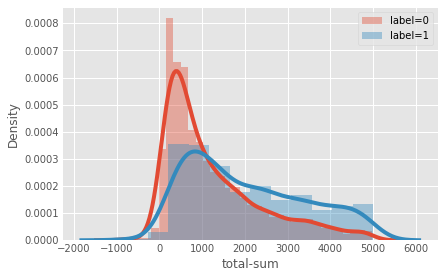

In [ ]:
#check distribution
sample1 = train[(train['total-sum']>-1000)&(train['total-sum']<5000)]
sns.distplot(sample1.loc[sample1['label']==0,'total-sum'],label='label=0')
sns.distplot(sample1.loc[sample1['label']==1,'total-sum'],label='label=1')
plt.legend()
plt.show()

In [ ]:
#extract feature

train_feature = train_country.drop(columns=['customer_id','year_month','label','year_month-mode','country','max_product_id'])
test_feature = test_country.drop(columns=['customer_id','year_month','label','year_month-mode','country','max_product_id'])

In [ ]:
#quantile transform to normal distribution

normal_train_feature = quantile_transform(train_feature,output_distribution='normal')
normal_test_feature = quantile_transform(test_feature,output_distribution='normal')

In [ ]:
normal_train_feature.shape

(5722, 119)

In [ ]:
normal_test_feature.shape

(5914, 119)

In [ ]:
#rename normal feature column

normal_feature_df = pd.DataFrame(normal_train_feature)

In [ ]:
normal_feature_df.columns = train_feature.columns

In [ ]:
normal_feature_df.rename(columns = lambda x: 'normalize_'+x, inplace = True)

In [ ]:
normal_feature_df.head()

normalize_quantity-mean  normalize_quantity-max  normalize_quantity-min  \
0                -2.012010                5.199338               -5.199338   
1                 0.645130                1.562721                0.939747   
2                 1.781258                1.225943                0.253606   
3                 0.045216                0.223916               -0.296607   
4                 0.438581               -0.618059                0.253606   

   normalize_quantity-sum  normalize_quantity-count  normalize_quantity-std  \
0               -1.425011                 -0.037646                5.199338   
1                1.239671                  1.027247                0.949731   
2                1.226834                  0.022584                1.686107   
3                0.545244                  0.543789                0.141000   
4               -0.549616                 -0.776528               -0.877205   

   normalize_quantity-skew  normalize_price-mean  normalize_price-max  \
0                -1.426131              1.936477             1.789905   
1                 2.511446             -0.455878            -0.022584   
2                -0.834546              0.539339             1.349498   
3                -0.239544              1.744647             1.949380   
4                -1.088062              0.570340             1.349498   

   normalize_price-min  normalize_price-sum  normalize_price-count  \
0             1.156839             0.884936              -0.037646   
1            -0.494971             0.851837               1.027247   
2            -0.328223             0.119753               0.022584   
3            -0.015055             1.216582               0.543789   
4             0.855287            -0.667419              -0.776528   

   normalize_price-std  normalize_price-skew  normalize_total-mean  \
0             1.991890              1.365629             -2.196910   
1            -0.454660              0.588434              0.654627   
2             1.654568              0.997395              1.233043   
3             2.084150              1.743834              0.800503   
4             1.589608              1.265996              0.450063   

   normalize_total-max  normalize_total-min  normalize_total-sum  \
0             5.199338            -5.199338            -2.366822   
1             1.313843             0.589456             1.256534   
2             1.277242             0.231641             0.664146   
3             1.324958            -0.608973             0.851693   
4            -0.368215             0.869846            -0.593606   

   normalize_total-count  normalize_total-std  normalize_total-skew  \
0              -0.037646             3.314153             -1.039800   
1               1.027247             0.740463              2.018335   
2               0.022584             1.266842              0.681828   
3               0.543789             1.063254              1.622623   
4              -0.776528            -0.553575             -0.311649   

   normalize_cumsum_total_by_cust_id-mean  \
0                                1.053994   
1                                1.185003   
2                                0.370970   
3                                0.791720   
4                               -0.633562   

   normalize_cumsum_total_by_cust_id-max  \
0                               2.776583   
1                               1.244437   
2                               0.655869   
3                               0.844317   
4                              -0.607708   

   normalize_cumsum_total_by_cust_id-min  \
0                              -2.133517   
1                               0.296607   
2                              -0.240671   
3                              -1.951885   
4                               0.710366   

   normalize_cumsum_total_by_cust_id-sum  \
0                               0.538296   
1                               1.144770   
2        

In [ ]:
only_normal_train = pd.concat([train_country[['customer_id','year_month','label','year_month-mode','country']],normal_feature_df],axis=1)
only_normal_train.head()

customer_id year_month  label  year_month-mode  country  \
0        12346    2011-11      0                6       38   
1        12347    2011-11      0               22       16   
2        12348    2011-11      0                9       12   
3        12349    2011-11      1               10       18   
4        12350    2011-11      0               14       26   

   normalize_quantity-mean  normalize_quantity-max  normalize_quantity-min  \
0                -2.012010                5.199338               -5.199338   
1                 0.645130                1.562721                0.939747   
2                 1.781258                1.225943                0.253606   
3                 0.045216                0.223916               -0.296607   
4                 0.438581               -0.618059                0.253606   

   normalize_quantity-sum  normalize_quantity-count  normalize_quantity-std  \
0               -1.425011                 -0.037646                5.199338   
1                1.239671                  1.027247                0.949731   
2                1.226834                  0.022584                1.686107   
3                0.545244                  0.543789                0.141000   
4               -0.549616                 -0.776528               -0.877205   

   normalize_quantity-skew  normalize_price-mean  normalize_price-max  \
0                -1.426131              1.936477             1.789905   
1                 2.511446             -0.455878            -0.022584   
2                -0.834546              0.539339             1.349498   
3                -0.239544              1.744647             1.949380   
4                -1.088062              0.570340             1.349498   

   normalize_price-min  normalize_price-sum  normalize_price-count  \
0             1.156839             0.884936              -0.037646   
1            -0.494971             0.851837               1.027247   
2            -0.328223             0.119753               0.022584   
3            -0.015055             1.216582               0.543789   
4             0.855287            -0.667419              -0.776528   

   normalize_price-std  normalize_price-skew  normalize_total-mean  \
0             1.991890              1.365629             -2.196910   
1            -0.454660              0.588434              0.654627   
2             1.654568              0.997395              1.233043   
3             2.084150              1.743834              0.800503   
4             1.589608              1.265996              0.450063   

   normalize_total-max  normalize_total-min  normalize_total-sum  \
0             5.199338            -5.199338            -2.366822   
1             1.313843             0.589456             1.256534   
2             1.277242             0.231641             0.664146   
3             1.324958            -0.608973             0.851693   
4            -0.368215             0.869846            -0.593606   

   normalize_total-count  normalize_total-std  normalize_total-skew  \
0              -0.037646             3.314153             -1.039800   
1               1.027247             0.740463              2.018335   
2               0.022584             1.266842              0.681828   
3               0.543789             1.063254              1.622623   
4              -0.776528            -0.553575             -0.311649   

   normalize_cumsum_total_by_cust_id-mean  \
0                                1.053994   
1                                1.185003   
2                                0.370970   
3                                0.791720   
4                               -0.633562   

   normalize_cumsum_total_by_cust_id-max  \
0                               2.776583   
1                               1.244437   
2                               0.655869   
3                               0.844317   
4                              -0.607708   

   normalize_cumsum_total_by_cust

In [ ]:
only_normalize_feature = only_normal_train.drop(columns=['customer_id','year_month','label']).columns
len(only_normalize_feature)

119

In [ ]:
#normal + non-normal feature

normal_train = pd.concat([train_country,normal_feature_df],axis=1)
normal_train.head()

customer_id year_month  label  quantity-mean  quantity-max  quantity-min  \
0        12346    2011-11      0       1.127660       74215.0      -74215.0   
1        12347    2011-11      0      13.151659         240.0           2.0   
2        12348    2011-11      0      53.215686         144.0           1.0   
3        12349    2011-11      1       9.233645          48.0          -1.0   
4        12350    2011-11      0      11.588235          24.0           1.0   

   quantity-sum  quantity-count  quantity-std  quantity-skew  price-mean  \
0          53.0            47.0  15474.897433      -0.000228   19.922872   
1        2775.0           211.0     17.701647      10.216574    4.230803   
2        2714.0            51.0     48.700848       0.822147    6.247353   
3         988.0           107.0      8.408867       1.558634   13.870640   
4         197.0            17.0      4.345383       0.472554    6.337941   

   price-max  price-min  price-sum  price-count  price-std  price-skew  \
0   234.8115     1.6500   936.3750         47.0  40.530554    4.547689   
1    21.0375     0.4125   892.6995        211.0   3.737299    2.511623   
2    66.0000     0.4785   318.6150         51.0  17.617275    3.224035   
3   412.5000     0.6930  1484.1585        107.0  50.462126    7.102276   
4    66.0000     1.4025   107.7450         17.0  15.402339    4.098028   

   total-mean  total-max    total-min  total-sum  total-count     total-std  \
0   -1.816404  127352.94 -127352.9400   -85.3710         47.0  26554.972603   
1   36.727827     411.84       8.3160  7749.5715        211.0     36.057268   
2   65.333529     396.00       1.6500  3332.0100         51.0     72.939156   
3   40.818070     412.50     -24.6675  4367.5335        107.0     54.673882   
4   32.456471      66.00      14.0250   551.7600         17.0     12.004638   

   total-skew  cumsum_total_by_cust_id-mean  cumsum_total_by_cust_id-max  \
0    0.000214                   2953.304457                  127267.5690   
1    6.436852                   3491.749628                    7749.5715   
2    2.528198                   1096.986000                    3332.0100   
3    4.889357                   2014.247369                    4367.5335   
4    1.178640                    281.849118                     551.7600   

   cumsum_total_by_cust_id-min  cumsum_total_by_cust_id-sum  \
0                     -85.3710                  138805.3095   
1                      29.2050                  736759.1715   
2                      21.7800                   55946.2860   
3                     -39.8475                  215524.4685   
4                      41.5800                    4791.4350   

   cumsum_total_by_cust_id-count  cumsum_total_by_cust_id-std  \
0                           47.0                 18527.811314   
1                          211.0                  2302.307503   
2                           51.0                  1000.019165   
3                          107.0                  1402.866250   
4                           17.0                   161.979220   

   cumsum_total_by_cust_id-skew  cumsum_quantity_by_cust_id-mean  \
0                      6.855058                      1631.063830   
1                      0.228741                      1339.677725   
2                      0.812596                      1069.450980   
3                      0.089354                       467.682243   
4                      0.200043                       107.941176   

   cumsum_quantity_by_cust_id-max  cumsum_quantity_by_cust_id-min  \
0                         74268.0                            10.0   
1                          2775.0                             6.0   
2                          2714.0                            24.0   
3                           988.0                            -5.0   
4                           197.0                            12.0   

   cumsum_quantity_by_cust_id-sum  cumsum_quantity_by_cust_id-count  \
0                         766

In [ ]:
#rename test normal feature

normal_feature_test_df = pd.DataFrame(normal_test_feature)

In [ ]:
normal_feature_test_df.columns = test_feature.columns

In [ ]:
normal_feature_test_df.rename(columns = lambda x: 'normalize_'+x,inplace=True)

In [ ]:
normal_feature_test_df.head()

normalize_quantity-mean  normalize_quantity-max  normalize_quantity-min  \
0                -2.019001                5.199338               -5.199338   
1                 0.640846                1.558482                0.941700   
2                 1.786716                1.220640                0.260089   
3                -0.021960                0.196979               -0.286135   
4                 0.427888               -0.650274                0.260089   

   normalize_quantity-sum  normalize_quantity-count  normalize_quantity-std  \
0               -1.439001                 -0.067799                5.199338   
1                1.214263                  0.985610                0.947395   
2                1.197271                 -0.011291                1.687235   
3                0.846614                  0.875354               -0.051646   
4               -0.580524                 -0.798769               -0.897533   

   normalize_quantity-skew  normalize_price-mean  normalize_price-max  \
0                -1.456658              1.954283             1.796399   
1                 2.463813             -0.436365            -0.033880   
2                -0.856016              0.564651             1.352623   
3                -0.159391              1.770069             2.090440   
4                -1.112024              0.594902             1.352623   

   normalize_price-min  normalize_price-sum  normalize_price-count  \
0             1.176663             0.852623              -0.067799   
1            -0.455640             0.817701               0.985610   
2            -0.286135             0.092489              -0.011291   
3             0.053973             1.589325               0.875354   
4             0.908975            -0.676854              -0.798769   

   normalize_price-std  normalize_price-skew  normalize_total-mean  \
0             1.995353              1.356696             -2.221418   
1            -0.444455              0.564621              0.656607   
2             1.668130              0.992632              1.236369   
3             2.105822              1.798678              0.795106   
4             1.589201              1.265362              0.447212   

   normalize_total-max  normalize_total-min  normalize_total-sum  \
0             5.199338            -5.199338            -2.386466   
1             1.304121             0.605955             1.232596   
2             1.270003             0.250569             0.640977   
3             1.475723            -0.590949             1.184661   
4            -0.386302             0.897655            -0.628524   

   normalize_total-count  normalize_total-std  normalize_total-skew  \
0              -0.067799             3.314995             -1.044409   
1               0.985610             0.741591              2.006346   
2              -0.011291             1.265866              0.663585   
3               0.875354             1.067099              1.846025   
4              -0.798769            -0.561439             -0.319308   

   normalize_cumsum_total_by_cust_id-mean  \
0                                1.019952   
1                                1.161294   
2                                0.346933   
3                                1.149526   
4                               -0.669844   

   normalize_cumsum_total_by_cust_id-max  \
0                               2.772355   
1                               1.220640   
2                               0.634037   
3                               1.174509   
4                              -0.642454   

   normalize_cumsum_total_by_cust_id-min  \
0                              -2.145676   
1                               0.300542   
2                              -0.240671   
3                              -1.965724   
4                               0.708752   

   normalize_cumsum_total_by_cust_id-sum  \
0                               0.511720   
1                               1.111998   
2        

In [ ]:
only_normal_test = pd.concat([test_country[['customer_id','year_month','label','year_month-mode','country']],normal_feature_test_df],axis=1)
only_normal_test.head()

customer_id year_month  label  year_month-mode  country  \
0        12346    2011-12      0                6       38   
1        12347    2011-12      0               22       16   
2        12348    2011-12      0                9       12   
3        12349    2011-12      0               23       18   
4        12350    2011-12      0               14       26   

   normalize_quantity-mean  normalize_quantity-max  normalize_quantity-min  \
0                -2.019001                5.199338               -5.199338   
1                 0.640846                1.558482                0.941700   
2                 1.786716                1.220640                0.260089   
3                -0.021960                0.196979               -0.286135   
4                 0.427888               -0.650274                0.260089   

   normalize_quantity-sum  normalize_quantity-count  normalize_quantity-std  \
0               -1.439001                 -0.067799                5.199338   
1                1.214263                  0.985610                0.947395   
2                1.197271                 -0.011291                1.687235   
3                0.846614                  0.875354               -0.051646   
4               -0.580524                 -0.798769               -0.897533   

   normalize_quantity-skew  normalize_price-mean  normalize_price-max  \
0                -1.456658              1.954283             1.796399   
1                 2.463813             -0.436365            -0.033880   
2                -0.856016              0.564651             1.352623   
3                -0.159391              1.770069             2.090440   
4                -1.112024              0.594902             1.352623   

   normalize_price-min  normalize_price-sum  normalize_price-count  \
0             1.176663             0.852623              -0.067799   
1            -0.455640             0.817701               0.985610   
2            -0.286135             0.092489              -0.011291   
3             0.053973             1.589325               0.875354   
4             0.908975            -0.676854              -0.798769   

   normalize_price-std  normalize_price-skew  normalize_total-mean  \
0             1.995353              1.356696             -2.221418   
1            -0.444455              0.564621              0.656607   
2             1.668130              0.992632              1.236369   
3             2.105822              1.798678              0.795106   
4             1.589201              1.265362              0.447212   

   normalize_total-max  normalize_total-min  normalize_total-sum  \
0             5.199338            -5.199338            -2.386466   
1             1.304121             0.605955             1.232596   
2             1.270003             0.250569             0.640977   
3             1.475723            -0.590949             1.184661   
4            -0.386302             0.897655            -0.628524   

   normalize_total-count  normalize_total-std  normalize_total-skew  \
0              -0.067799             3.314995             -1.044409   
1               0.985610             0.741591              2.006346   
2              -0.011291             1.265866              0.663585   
3               0.875354             1.067099              1.846025   
4              -0.798769            -0.561439             -0.319308   

   normalize_cumsum_total_by_cust_id-mean  \
0                                1.019952   
1                                1.161294   
2                                0.346933   
3                                1.149526   
4                               -0.669844   

   normalize_cumsum_total_by_cust_id-max  \
0                               2.772355   
1                               1.220640   
2                               0.634037   
3                               1.174509   
4                              -0.642454   

   normalize_cumsum_total_by_cust

In [ ]:
normal_test = pd.concat([test_country,normal_feature_test_df],axis=1)
normal_test.head()

customer_id year_month  label  quantity-mean  quantity-max  quantity-min  \
0        12346    2011-12      0       1.127660       74215.0      -74215.0   
1        12347    2011-12      0      13.151659         240.0           2.0   
2        12348    2011-12      0      53.215686         144.0           1.0   
3        12349    2011-12      0       8.994444          48.0          -1.0   
4        12350    2011-12      0      11.588235          24.0           1.0   

   quantity-sum  quantity-count  quantity-std  quantity-skew  price-mean  \
0          53.0            47.0  15474.897433      -0.000228   19.922872   
1        2775.0           211.0     17.701647      10.216574    4.230803   
2        2714.0            51.0     48.700848       0.822147    6.247353   
3        1619.0           180.0      7.846643       1.718638   13.792075   
4         197.0            17.0      4.345383       0.472554    6.337941   

   price-max  price-min  price-sum  price-count  price-std  price-skew  \
0   234.8115     1.6500   936.3750         47.0  40.530554    4.547689   
1    21.0375     0.4125   892.6995        211.0   3.737299    2.511623   
2    66.0000     0.4785   318.6150         51.0  17.617275    3.224035   
3   495.0000     0.6930  2482.5735        180.0  53.400142    7.661229   
4    66.0000     1.4025   107.7450         17.0  15.402339    4.098028   

   total-mean  total-max    total-min  total-sum  total-count     total-std  \
0   -1.816404  127352.94 -127352.9400   -85.3710         47.0  26554.972603   
1   36.727827     411.84       8.3160  7749.5715        211.0     36.057268   
2   65.333529     396.00       1.6500  3332.0100         51.0     72.939156   
3   40.374950     495.00     -24.6675  7267.4910        180.0     55.548906   
4   32.456471      66.00      14.0250   551.7600         17.0     12.004638   

   total-skew  cumsum_total_by_cust_id-mean  cumsum_total_by_cust_id-max  \
0    0.000214                   2953.304457                  127267.5690   
1    6.436852                   3491.749628                    7749.5715   
2    2.528198                   1096.986000                    3332.0100   
3    5.864055                   3445.769525                    7267.4910   
4    1.178640                    281.849118                     551.7600   

   cumsum_total_by_cust_id-min  cumsum_total_by_cust_id-sum  \
0                     -85.3710                  138805.3095   
1                      29.2050                  736759.1715   
2                      21.7800                   55946.2860   
3                     -39.8475                  620238.5145   
4                      41.5800                    4791.4350   

   cumsum_total_by_cust_id-count  cumsum_total_by_cust_id-std  \
0                           47.0                 18527.811314   
1                          211.0                  2302.307503   
2                           51.0                  1000.019165   
3                          180.0                  2091.575371   
4                           17.0                   161.979220   

   cumsum_total_by_cust_id-skew  cumsum_quantity_by_cust_id-mean  \
0                      6.855058                      1631.063830   
1                      0.228741                      1339.677725   
2                      0.812596                      1069.450980   
3                     -0.182170                       786.527778   
4                      0.200043                       107.941176   

   cumsum_quantity_by_cust_id-max  cumsum_quantity_by_cust_id-min  \
0                         74268.0                            10.0   
1                          2775.0                             6.0   
2                          2714.0                            24.0   
3                          1619.0                            -5.0   
4                           197.0                            12.0   

   cumsum_quantity_by_cust_id-sum  cumsum_quantity_by_cust_id-count  \
0                         766

In [ ]:
normal_total_features = normal_train.drop(columns=['customer_id','year_month','label']).columns
len(normal_total_features)

241

## country feature

In [ ]:
data_country = data.copy()
data_country.head()

order_id product_id                          description  quantity  \
0   489434      85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434     79323P                   PINK CHERRY LIGHTS        12   
2   489434     79323W                  WHITE CHERRY LIGHTS        12   
3   489434      22041         RECORD FRAME 7" SINGLE SIZE         48   
4   489434      21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           order_date    price  customer_id         country   total  
0 2009-12-01 07:45:00  11.4675        13085  United Kingdom  137.61  
1 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65  
2 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65  
3 2009-12-01 07:45:00   3.4650        13085  United Kingdom  166.32  
4 2009-12-01 07:45:00   2.0625        13085  United Kingdom   49.50

In [ ]:
data_country = data_country.drop_duplicates(['customer_id'])[['customer_id','country']].sort_values(['customer_id']).reset_index(drop=True)

In [ ]:
data_country.head()

customer_id         country
0        12346  United Kingdom
1        12347         Iceland
2        12348         Finland
3        12349           Italy
4        12350          Norway

In [ ]:
le = LabelEncoder()
            
le.fit(list(data_country['country'].values))
            
data_country['country'] = le.transform(list(data_country['country'].values))

In [ ]:
data_country.head()

customer_id  country
0        12346       38
1        12347       16
2        12348       12
3        12349       18
4        12350       26

In [ ]:
train_country = train.merge(data_country,on=['customer_id'],how='left')
test_country = test.merge(data_country,on=['customer_id'],how='left')

In [ ]:
total_features = train_country.drop(columns=['customer_id','year_month','label']).columns
len(total_features)

119

## 2011년 12월 베이스라인 모델 예측 데이터 분포

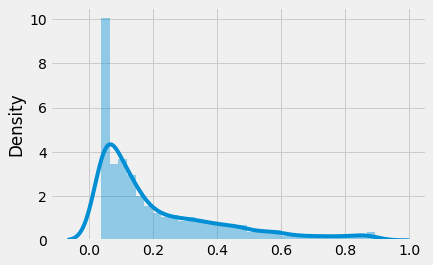

In [ ]:
sns.distplot(test_preds4)
plt.show()

## 피처 중요도 플롯

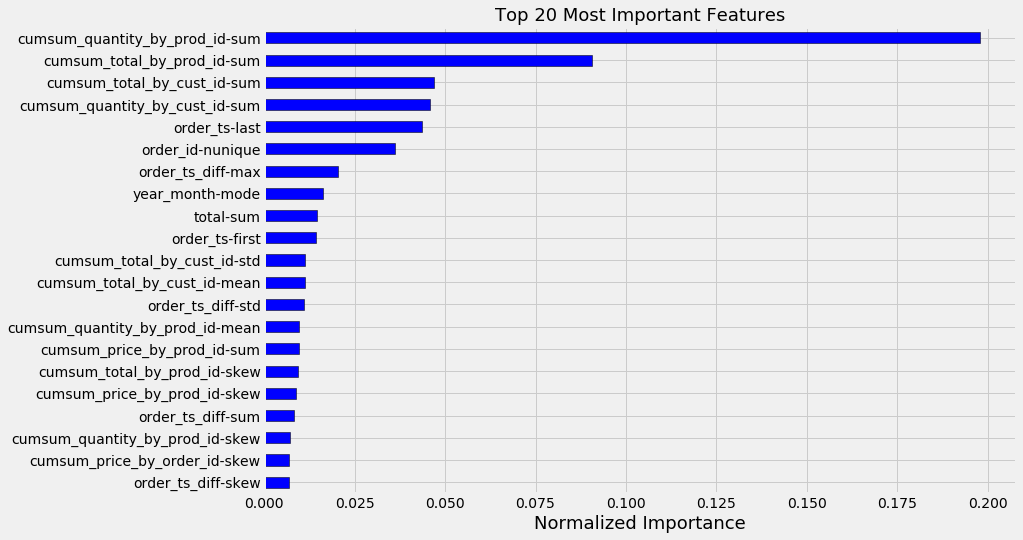

In [ ]:
fi = plot_feature_importances(fi)

In [ ]:
#selection important feature

important_feature=['order_ts-last','year_month-mode','order_ts_diff-max','order_id-nunique','month-mode','order_ts-first','cumsum_total_by_prod_id-sum','total-sum','cumsum_total_by_cust_id-mean',
                  'cumsum_quantity_by_prod_id-sum','cumsum_quantity_by_prod_id-mean','quantity_diff-mean','cumsum_total_by_prod_id-skew','cumsum_total_by_order_id-max','cumsum_total_by_order_id-mean',
                  'cumsum_total_by_order_id-sum','order_ts_diff-std','cumsum_total_by_cust_id-sum','price_diff-skew','cumsum_total_by_prod_id-max','cumsum_quantity_by_order_id-max']

# 제출 파일 생성

In [ ]:
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)
submission = pd.read_csv('../input/sample_submission.csv')
submission['probability'] = (best_lgb_country+best_xgb_country+best_cbt_country+best_rf_country+best_ngb_country)/5
submission.to_csv(os.path.join(output_dir, 'output.csv'), index=False)